In [1]:
"""Undersample GISAID metadata, select sequences by clade"""
import random
from collections import namedtuple, Counter
from pathlib import Path
from tqdm import tqdm
import pandas as pd
tqdm.pandas()

from parameters import PARAMETERS
SEED = PARAMETERS["SEED"]; random.seed(SEED)
PATH_METADATA = PARAMETERS["PATH_METADATA"]
CLADES = PARAMETERS["CLADES"]
SAMPLES_PER_CLADE = PARAMETERS["SAMPLES_PER_CLADE"]

In [2]:
print(">> Undersample sequences <<")
print(PATH_METADATA)
# Load metadata
#COLS = ["Virus name", "Collection date", "Submission date","Clade", "Host", "Is complete?"]
COLS = ["Virus name", "Accession ID","Collection date", "Clade", "Host"]
data = pd.read_csv(PATH_METADATA,sep="\t")#, usecols=COLS)

print(data.columns)

>> Undersample sequences <<
C:/Users/puddi/Desktop/CouGaR-g-master/gisaid_hcov-19_unico.tsv
Index(['Virus name', 'Accession ID', 'Collection date', 'Location', 'Host',
       'Passage', 'Specimen', 'Additional host information',
       'Sequencing technology', 'Assembly method', 'Comment', 'Comment type',
       'Lineage', 'Clade', 'AA Substitutions'],
      dtype='object')


In [3]:
data['Virus name'].duplicated().value_counts(dropna=False)

Virus name
False    49380
True        15
Name: count, dtype: int64

In [4]:
# Remove NaN in Clades and not-complete sequences
print(data.shape)
data.dropna(axis="rows",
            how="any",
            subset=COLS, 
            inplace=True,
            )
data.drop_duplicates(subset=COLS, inplace=True)
print(data.shape)

(49395, 15)
(49395, 15)


In [5]:
# Filter by Clades and Host
CLADES = tuple(clade for clade in CLADES)
data.query(f"`Clade` in {CLADES} and `Host`=='Human'", inplace=True)

## Randomly select a subset of sequences
# Generate id of sequences in fasta file: "Virus name|Accession ID|Collection date"
data["fasta_id"] = data.progress_apply(lambda row: "|".join([
                                        row["Virus name"],
                                        row["Accession ID"],
                                        row["Collection date"]
                                        ]
                                    ), axis=1)

100%|████████████████████████████████████████████████████████████████████████| 49395/49395 [00:00<00:00, 185332.67it/s]


In [6]:
# subsample 
SampleClade = namedtuple("SampleClade", ["fasta_id","clade"])
list_fasta_selected = []
for clade in tqdm(CLADES):
    samples_clade = data.query(f"`Clade` == '{clade}'")["fasta_id"].tolist()
    random.shuffle(samples_clade)
    # select 'SAMPLES_PER_CLADE' samples for each clade, or all of them if available samples are less than required
    list_fasta_selected.extend([SampleClade(fasta_id, clade) for fasta_id in samples_clade[:SAMPLES_PER_CLADE]])

Path("data/train").mkdir(exist_ok=True, parents=True)
fasta_selected = pd.DataFrame(list_fasta_selected)
fasta_selected.to_csv("data/train/undersample_by_clade.csv")
pd.Series(Counter(fasta_selected["clade"])).to_csv("data/train/selected_by_clade.csv")
pd.Series(Counter(data["Clade"])).to_csv("data/train/available_by_clade.csv")

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.92it/s]


In [7]:
### EXTRACT_SEQUENCY.PY ####

"""After undersample the sequences, we extract each one in a separated fasta file
to generates the FCGR as .npy files for training purposes"""
from tqdm import tqdm 
from Bio import SeqIO
from pathlib import Path
import pandas as pd

from parameters import PARAMETERS

print(">> Extracting sequences <<")

PATH_FASTA_GISAID = PARAMETERS["PATH_FASTA_GISAID"]
SPECIE = PARAMETERS["SPECIE"]
FOLDER_FASTA = Path(f"data/{SPECIE}")#Path(PARAMETERS["FOLDER_FASTA"]) # here will be saved the selected sequences by clade
FOLDER_FASTA.mkdir(parents=True, exist_ok=True)

# Create folder for each clade
for clade in PARAMETERS["CLADES"]: 
    FOLDER_FASTA.joinpath(clade).mkdir(parents=True, exist_ok=True)

>> Extracting sequences <<


In [8]:
PARAMETERS

{'KMER': 8,
 'SPECIE': 'hCoV-19',
 'PATH_FASTA_GISAID': 'C:/Users/puddi/Desktop/CouGaR-g-master/gisaid_hcov-19_unico.fasta',
 'PATH_METADATA': 'C:/Users/puddi/Desktop/CouGaR-g-master/gisaid_hcov-19_unico.tsv',
 'PATH_REFERENCE_GENOME': 'C:/Users/puddi/Desktop/CouGaR-g-master/EPI_ISL_402124-ORF1ab.fasta',
 'CLADES': ['L', 'G', 'GR', 'GH', 'GV', 'GK', 'GRY', 'O', 'GRA'],
 'LINEAGE': ['AY.120',
  'AY.4',
  'B.1',
  'B.1.1',
  'B.1.1.214',
  'B.1.1.519',
  'B.1.1.7',
  'B.1.160',
  'B.1.177',
  'B.1.177.21',
  'B.1.2',
  'B.1.221',
  'B.1.243',
  'B.1.258',
  'B.1.351',
  'B.1.427',
  'B.1.427',
  'B.1.526',
  'B.1.617.2',
  'D.2',
  'P.1',
  'R.1',
  'B.1.617.1',
  'B.1.525',
  'C.37',
  'B.1.621',
  'BA.1',
  'BA.2',
  'BA.3',
  'BA.4',
  'BA.5',
  'BA.2.12.1',
  'BA.2.75',
  'BQ.1',
  'XBB',
  'B.1.1.529'],
 'SAMPLES_PER_CLADE': 20000,
 'TRAIN_SIZE': 0.8,
 'BATCH_SIZE': 16,
 'EPOCHS': 50,
 'PREPROCESSING': {'divide_by_max': {}},
 'WEIGHTS_PATH': None,
 'SEED': 42}

In [9]:
# load fasta_id to save
undersample = pd.read_csv("data/train/undersample_by_clade.csv").to_dict("records")
set_fasta_id = set([record.get("fasta_id") for record in undersample])
N_seqs_to_extract = len(set_fasta_id)
clades_by_fastaid = {record.get("fasta_id"): record.get("clade") for record in undersample} 

In [10]:
list(clades_by_fastaid.items())[:10]

[('hCoV-19/Indonesia/JI-ITD-1798N/2020|EPI_ISL_17323200|2020-04-02', 'L'),
 ('hCoV-19/England/PHEC-1B415/2020|EPI_ISL_2737765|2020-04-02', 'L'),
 ('hCoV-19/Norway/09289/2021|EPI_ISL_2001527|2021-04-06', 'G'),
 ('hCoV-19/USA/IL-RUSH-00419/2020|EPI_ISL_14379688|2020-04-02', 'G'),
 ('hCoV-19/Denmark/DCGC-10243/2020|EPI_ISL_669612|2020-11-09', 'G'),
 ('hCoV-19/Czech Republic/NRL_10416/2020|EPI_ISL_737007|2020-10-26', 'G'),
 ('hCoV-19/France/ARA-19394/2020|EPI_ISL_678505|2020-04-03', 'G'),
 ('hCoV-19/Denmark/DCGC-11050/2020|EPI_ISL_670365|2020-11-02', 'G'),
 ('hCoV-19/USA/HI-H200566/2020|EPI_ISL_753094|2020-10-24', 'G'),
 ('hCoV-19/Denmark/DCGC-59223/2021|EPI_ISL_1867794|2021-04-05', 'G')]

In [11]:
pbar = tqdm(total=len(set_fasta_id))
# Read fasta with all sequences from GISAID
with open(PATH_FASTA_GISAID) as handle:
    for record in SeqIO.parse(handle, "fasta"):
        #print(record)
        # save sequence if it was selected
        if record.description in set_fasta_id:
            # save sequence in a fasta file "<accession_id>.fasta"
            clade    = clades_by_fastaid.get(record.description)
            #print(clade)
            filename = record.description.replace("/","_").replace("|","@") # replace '/' to avoid problems when saving fasta file
            #print(filename)
            path_save = FOLDER_FASTA.joinpath(f"{clade}/{filename}.fasta")
            #print(path_save)
            if not path_save.is_file():
                SeqIO.write(record, path_save, "fasta") 
            # remove from the set to be saved   
            set_fasta_id.remove(record.description)
            pbar.update(1)

        # if all sequences has been saved, break the loop
        if not set_fasta_id:
            #print("ciao")
            break
pbar.close()

 98%|████████████████████████████████████████████████████████████████████████▌ | 48412/49395 [00:26<00:00, 1841.17it/s]


In [12]:
if len(set_fasta_id):
    pd.Series(list(set_fasta_id)).to_csv(FOLDER_FASTA.joinpath("not_found.csv"))

with open(f"data/{SPECIE}/extracted_sequences.txt","w") as fp:
    extracted_seqs = len(list(FOLDER_FASTA.rglob("*.fasta")))
    fp.write(f"{extracted_seqs}/{N_seqs_to_extract}")

In [13]:
### FASTA2FCGR.PY ### 

"""Create and FCGR.npy for each sequence.fasta in a folder"""
from pathlib import Path
from parameters import PARAMETERS
from fcgr.generate_fcgr import GenerateFCGR

SPECIE = PARAMETERS["SPECIE"]
FOLDER_FASTA = Path(f"data/{SPECIE}") 
LIST_FASTA   = list(FOLDER_FASTA.rglob("*fasta"))

#Aggiunto
#list_nopath = [str(x).replace("@", "|") for x in LIST_FASTA]
#LIST_FASTA  = [Path(x) for x in list_nopath]

KMER = PARAMETERS["KMER"] 
FOLDER_FCGR = Path(f"data/fcgr-{KMER}-mer")

In [14]:
#Instantiate class to generate FCGR        #MODIFICATO NELLA CARTELLA FCGR IL .GENERATEFCGR \\
generate_fcgr = GenerateFCGR(
                #list_fasta=LIST_FASTA,
                destination_folder=FOLDER_FCGR,
                kmer=KMER,
                )

# Generate FCGR for a list of fasta files
generate_fcgr(list_fasta=LIST_FASTA,)

# count generated FCGR
N_seqs_to_gen = len(LIST_FASTA)
with open(FOLDER_FCGR.joinpath("generated_fcgr.txt"),"w") as fp:
    gen_seqs = len(list(FOLDER_FCGR.rglob("*.npy")))
    fp.write(f"{gen_seqs}/{N_seqs_to_gen}")

Generating FCGR: 100%|███████████████████████████████████████████████████████████| 48412/48412 [16:17<00:00, 49.55it/s]


In [15]:
### SPLIT.DATA.PY ###
"""Divide FCGR generated into train, validation and test sets"""
import json
import pandas as pd
from parameters import PARAMETERS
from pathlib import Path
from data_selector import DataSelector

# Select all data
KMER = PARAMETERS["KMER"] 
FOLDER_FCGR = Path(f"data/fcgr-{KMER}-mer")
LIST_FASTA   = list(FOLDER_FCGR.rglob("*npy"))
TRAIN_SIZE   = float(PARAMETERS["TRAIN_SIZE"])
SEED = PARAMETERS["SEED"]

In [16]:
# Instantiate DataSelector
id_labels = [str(path) for path in LIST_FASTA] 
labels    = [path.parent.stem for path in LIST_FASTA] 
    
ds = DataSelector(
    id_labels,
    labels,
    SEED
    )

In [17]:
# Get train, test and val sets
ds(train_size=TRAIN_SIZE, balanced_on=labels)

with open("data/train/datasets.json", "w", encoding="utf-8") as f: 
    json.dump(ds.datasets["id_labels"], f, ensure_ascii=False, indent=4)

Generating train, validation and test sets...
Datasets successfully generated. See 'datasets' attribute.
{'train': {'GK': 4801, 'GH': 9380, 'GR': 8385, 'GRA': 7318, 'G': 5553, 'GV': 2280, 'GRY': 995, 'O': 14, 'L': 2}, 'val': {'GH': 1173, 'GRA': 915, 'G': 694, 'GR': 1049, 'GK': 600, 'GV': 285, 'GRY': 124, 'O': 2}, 'test': {'GRA': 915, 'GH': 1173, 'G': 694, 'GV': 285, 'GR': 1049, 'GK': 600, 'GRY': 124, 'O': 2}}


In [18]:
# Summary of data selected 
summary_labels =  pd.DataFrame(ds.get_summary_labels())
summary_labels["Total"] = summary_labels.sum(axis=1)
summary_labels.to_csv("data/train/summary_labels.csv")

In [19]:
summary_labels

,train,val,test,Total
GK,4801,600.0,600.0,6001.0
GH,9380,1173.0,1173.0,11726.0
GR,8385,1049.0,1049.0,10483.0
GRA,7318,915.0,915.0,9148.0
G,5553,694.0,694.0,6941.0
GV,2280,285.0,285.0,2850.0
GRY,995,124.0,124.0,1243.0
O,14,2.0,2.0,18.0
L,2,NaN,NaN,2.0


In [20]:
### TRAIN.PY ###
import json
from pathlib import Path
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight

from loaders.model_loader import ModelLoader
from loaders.data_generator import DataGenerator  
from preprocessing import Pipeline
from parameters import PARAMETERS

# parameters 
SEED   = PARAMETERS["SEED"]
KMER = PARAMETERS["KMER"]
CLADES = PARAMETERS["CLADES"]
BATCH_SIZE = PARAMETERS["BATCH_SIZE"]
EPOCHS = PARAMETERS["EPOCHS"]
WEIGHTS_PATH = PARAMETERS["WEIGHTS_PATH"]
PREPROCESSING = [(k,v) for k,v in PARAMETERS["PREPROCESSING"].items()]

MODEL_NAME  = f"resnet50_{KMER}mers"

C:\Users\puddi\Desktop\CouGaR-g-master\src C:\Users\puddi\Desktop\CouGaR-g-master\src\models
Adding divide_by_max
Adding divide_by_sum


In [21]:
# set seed for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)

# -1- Model selection
loader = ModelLoader()
model  = loader(
            model_name=MODEL_NAME,
            n_outputs=len(CLADES),
            weights_path=WEIGHTS_PATH
            ) # get compiled model from ./supervised_dna/models

preprocessing = Pipeline(PREPROCESSING)
Path("data/train").mkdir(exist_ok=True, parents=True)
preprocessing.asJSON("data/train/preprocessing.json")


**Model created**
Pipeline configuration saved at WindowsPath('data/train/preprocessing.json')


In [22]:
# -2- Datasets
# load list of images for train and validation sets
with open("data/train/datasets.json","r") as f:
    datasets = json.load(f)
list_train = datasets["train"]
list_val   = datasets["val"]

In [23]:
## prepare datasets to feed the model
# Instantiate DataGenerator for training set
ds_train = DataGenerator(
    list_train,
    order_output_model = CLADES,
    batch_size = BATCH_SIZE,
    shuffle = True,
    kmer = KMER,
    preprocessing = preprocessing,
)

In [24]:
# Instantiate DataGenerator for validation set
ds_val = DataGenerator(
    list_val,
    order_output_model = CLADES,
    batch_size = BATCH_SIZE,
    shuffle = False,
    kmer = KMER,
    preprocessing = preprocessing,
) 

In [25]:
# -3- Training
# - Callbacks
# checkpoint: save best weights
Path("data/train/checkpoints").mkdir(exist_ok=True, parents=True)
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='data/train/checkpoints/model-{epoch:02d}-{val_accuracy:.3f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [26]:
# reduce learning rate
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=8,
    verbose=1,
    min_lr=0.00001
)

In [27]:
# stop training if
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.001,
    patience=12,
    verbose=1
)

In [28]:
# save history of training
Path("data/train").mkdir(exist_ok=True, parents=True)
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename='data/train/training_log.csv',
    separator=',',
    append=False
)

In [29]:
# weighted loss function
label_from_path = lambda path: path.split("\\")[-2]  ##CAMBIATO CON \\
labels_train = [label_from_path(path) for path in list_train]
weights = class_weight.compute_class_weight(
            "balanced",
            classes=CLADES,
            y=labels_train)

In [30]:
# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
            loss_weights=weights
)

In [31]:
# train model
model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[
        cb_checkpoint,
        cb_reducelr,
        cb_earlystop,
        cb_csvlogger,
        ]
)

Epoch 1/50
2421/2421 [==============================] - ETA: 0s - loss: 85.4706 - accuracy: 0.8998
Epoch 1: val_loss improved from inf to 839.31378, saving model to data/train/checkpoints\model-01-0.452.hdf5


C:\Users\puddi\Desktop\CouGaR-g-master\sevenv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2421/2421 [==============================] - 4121s 2s/step - loss: 85.4706 - accuracy: 0.8998 - val_loss: 839.3138 - val_accuracy: 0.4525 - lr: 0.0010
Epoch 2/50
2421/2421 [==============================] - ETA: 0s - loss: 21.4650 - accuracy: 0.9805
Epoch 2: val_loss improved from 839.31378 to 24.74482, saving model to data/train/checkpoints\model-02-0.964.hdf5
2421/2421 [==============================] - 4192s 2s/step - loss: 21.4650 - accuracy: 0.9805 - val_loss: 24.7448 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 3/50
2421/2421 [==============================] - ETA: 0s - loss: 16.6751 - accuracy: 0.9846
Epoch 3: val_loss did not improve from 24.74482
2421/2421 [==============================] - 4253s 2s/step - loss: 16.6751 - accuracy: 0.9846 - val_loss: 96.2470 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 4/50
2421/2421 [==============================] - ETA: 0s - loss: 9.8682 - accuracy: 0.9919
Epoch 4: val_loss improved from 24.74482 to 8.05641, saving model to data/train/checkpoints

2421/2421 [==============================] - ETA: 0s - loss: 2.4022 - accuracy: 0.9981
Epoch 27: val_loss did not improve from 3.30258
2421/2421 [==============================] - 4161s 2s/step - loss: 2.4022 - accuracy: 0.9981 - val_loss: 86.5978 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 28/50
2421/2421 [==============================] - ETA: 0s - loss: 2.6621 - accuracy: 0.9979
Epoch 28: val_loss did not improve from 3.30258
2421/2421 [==============================] - 4095s 2s/step - loss: 2.6621 - accuracy: 0.9979 - val_loss: 4.7660 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 29/50
2421/2421 [==============================] - ETA: 0s - loss: 2.2343 - accuracy: 0.9981
Epoch 29: val_loss did not improve from 3.30258
2421/2421 [==============================] - 4108s 2s/step - loss: 2.2343 - accuracy: 0.9981 - val_loss: 5.5935 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 30/50
2421/2421 [==============================] - ETA: 0s - loss: 2.2983 - accuracy: 0.9981
Epoch 30: val_loss did not 

In [32]:
### TEST.PY ###
import json 
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import namedtuple
from pathlib import Path
from loaders.model_loader import ModelLoader
from loaders.data_generator import DataGenerator  
from preprocessing import Pipeline
from parameters import PARAMETERS

KMER = PARAMETERS["KMER"]
CLADES     = PARAMETERS["CLADES"] # order output model
PREPROCESSING = [(k,v) for k,v in PARAMETERS["PREPROCESSING"].items()]

MODEL_NAME  = f"resnet50_{KMER}mers"

In [33]:
# get best weights
CHECKPOINTS  = [str(path) for path in Path("data/train/checkpoints").rglob("*.hdf5")]
epoch_from_chkp = lambda chkp: int(chkp.split("/")[-1].split("-")[1])
CHECKPOINTS.sort(key = epoch_from_chkp)
BEST_WEIGHTS =  CHECKPOINTS[-1]
print(f"using weights {BEST_WEIGHTS} to test")

using weights data\train\checkpoints\model-25-0.998.hdf5 to test


In [34]:
# load model 
loader = ModelLoader()
model = loader(model_name = MODEL_NAME,
               n_outputs  = len(CLADES),
               weights_path = BEST_WEIGHTS
            )


 **load model weights_path** : data\train\checkpoints\model-25-0.998.hdf5

**Model created**


In [35]:
preprocessing = Pipeline(PREPROCESSING)
            
# Option 2: from a list of files (test set)
with open("data/train/datasets.json", "r") as fp:
    dataset = json.load(fp)
list_test = dataset["test"]

print("Total files to test:", len(list_test))

Total files to test: 4842


In [36]:
# Instantiate DataGenerator for validation set
ds_test = DataGenerator(
    list_test,
    order_output_model = CLADES,
    batch_size = 1,
    shuffle = False,
    kmer = KMER,
    preprocessing = preprocessing,
) 

In [37]:
# Extract predictions and embeddings
list_preds = []
list_emb   = []

Preds = namedtuple("Preds",["path","ground_truth","prediction","confidence"])

for path, (input_model, labels_model) in tqdm(zip(list_test,iter(ds_test)),total=len(list_test)): 

    idx_gt = np.argmax(labels_model[0])
    gt = CLADES[idx_gt] # ground truth
    probs = model.predict(input_model)[0] # embedding last layer
    idx_pred = np.argmax(probs) # index with argmax
    pred = CLADES[idx_pred] # prediction of the model
    conf = probs[idx_pred] # confidence of the prediction

    # Collect results
    list_preds.append(
        Preds(path, gt, pred, conf)
    )

    list_emb.append(probs)

  0%|                                                                                         | 0/4842 [00:00<?, ?it/s]

1/1 [==============================] - 1s 509ms/step


  0%|                                                                                 | 1/4842 [00:00<45:20,  1.78it/s]

1/1 [==============================] - 0s 74ms/step


  0%|                                                                                 | 3/4842 [00:00<17:53,  4.51it/s]

1/1 [==============================] - 0s 75ms/step


  0%|                                                                                 | 5/4842 [00:00<12:59,  6.21it/s]

1/1 [==============================] - 0s 70ms/step


  0%|                                                                                 | 6/4842 [00:01<11:49,  6.81it/s]

1/1 [==============================] - 0s 67ms/step


  0%|▏                                                                                | 8/4842 [00:01<10:12,  7.90it/s]

1/1 [==============================] - 0s 63ms/step


  0%|▏                                                                                | 9/4842 [00:01<09:51,  8.17it/s]

1/1 [==============================] - 0s 62ms/step


  0%|▏                                                                               | 10/4842 [00:01<09:25,  8.55it/s]

1/1 [==============================] - 0s 68ms/step


  0%|▏                                                                               | 11/4842 [00:01<09:05,  8.85it/s]

1/1 [==============================] - 0s 68ms/step


  0%|▏                                                                               | 12/4842 [00:01<08:58,  8.97it/s]

1/1 [==============================] - 0s 65ms/step


  0%|▏                                                                               | 13/4842 [00:01<08:51,  9.09it/s]

1/1 [==============================] - 0s 69ms/step


  0%|▏                                                                               | 14/4842 [00:01<08:42,  9.24it/s]

1/1 [==============================] - 0s 60ms/step


  0%|▏                                                                               | 15/4842 [00:02<08:35,  9.35it/s]

1/1 [==============================] - 0s 63ms/step


  0%|▎                                                                               | 16/4842 [00:02<08:34,  9.37it/s]

1/1 [==============================] - 0s 70ms/step


  0%|▎                                                                               | 17/4842 [00:02<08:31,  9.44it/s]

1/1 [==============================] - 0s 72ms/step


  0%|▎                                                                               | 18/4842 [00:02<08:30,  9.45it/s]

1/1 [==============================] - 0s 68ms/step


  0%|▎                                                                               | 19/4842 [00:02<08:29,  9.47it/s]

1/1 [==============================] - 0s 72ms/step


  0%|▎                                                                               | 20/4842 [00:02<08:31,  9.43it/s]

1/1 [==============================] - 0s 63ms/step


  0%|▎                                                                               | 21/4842 [00:02<08:24,  9.55it/s]

1/1 [==============================] - 0s 69ms/step


  0%|▎                                                                               | 22/4842 [00:02<08:26,  9.52it/s]

1/1 [==============================] - 0s 64ms/step


  0%|▍                                                                               | 23/4842 [00:02<08:28,  9.48it/s]

1/1 [==============================] - 0s 69ms/step


  0%|▍                                                                               | 24/4842 [00:02<08:32,  9.40it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▍                                                                               | 26/4842 [00:03<08:18,  9.65it/s]

1/1 [==============================] - 0s 72ms/step


  1%|▍                                                                               | 27/4842 [00:03<08:24,  9.55it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▍                                                                               | 28/4842 [00:03<08:22,  9.58it/s]

1/1 [==============================] - 0s 71ms/step


  1%|▍                                                                               | 29/4842 [00:03<08:22,  9.58it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▍                                                                               | 30/4842 [00:03<08:17,  9.67it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                               | 31/4842 [00:03<08:21,  9.60it/s]

1/1 [==============================] - 0s 73ms/step


  1%|▌                                                                               | 32/4842 [00:03<08:24,  9.53it/s]

1/1 [==============================] - 0s 66ms/step


  1%|▌                                                                               | 33/4842 [00:03<08:25,  9.51it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▌                                                                               | 34/4842 [00:04<08:34,  9.34it/s]

1/1 [==============================] - 0s 77ms/step


  1%|▌                                                                               | 35/4842 [00:04<08:27,  9.47it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▌                                                                               | 36/4842 [00:04<08:25,  9.51it/s]

1/1 [==============================] - 0s 72ms/step


  1%|▌                                                                               | 37/4842 [00:04<08:30,  9.42it/s]

1/1 [==============================] - 0s 71ms/step


  1%|▋                                                                               | 38/4842 [00:04<08:30,  9.41it/s]

1/1 [==============================] - 0s 69ms/step


  1%|▋                                                                               | 39/4842 [00:04<08:28,  9.44it/s]

1/1 [==============================] - 0s 71ms/step


  1%|▋                                                                               | 40/4842 [00:04<08:33,  9.36it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▋                                                                               | 41/4842 [00:04<08:33,  9.34it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▋                                                                               | 42/4842 [00:04<08:37,  9.27it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▋                                                                               | 43/4842 [00:04<08:39,  9.24it/s]

1/1 [==============================] - 0s 69ms/step


  1%|▋                                                                               | 44/4842 [00:05<08:38,  9.26it/s]

1/1 [==============================] - 0s 67ms/step


  1%|▋                                                                               | 45/4842 [00:05<08:38,  9.25it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▊                                                                               | 46/4842 [00:05<08:34,  9.33it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▊                                                                               | 47/4842 [00:05<08:34,  9.33it/s]

1/1 [==============================] - 0s 73ms/step


  1%|▊                                                                               | 48/4842 [00:05<08:38,  9.25it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▊                                                                               | 49/4842 [00:05<08:46,  9.10it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▊                                                                               | 50/4842 [00:05<08:40,  9.21it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▊                                                                               | 51/4842 [00:05<08:48,  9.07it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▊                                                                               | 52/4842 [00:05<09:00,  8.86it/s]

1/1 [==============================] - 0s 77ms/step


  1%|▉                                                                               | 53/4842 [00:06<08:52,  9.00it/s]

1/1 [==============================] - 0s 71ms/step


  1%|▉                                                                               | 54/4842 [00:06<08:46,  9.09it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▉                                                                               | 55/4842 [00:06<08:40,  9.21it/s]

1/1 [==============================] - 0s 72ms/step


  1%|▉                                                                               | 56/4842 [00:06<08:41,  9.18it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▉                                                                               | 57/4842 [00:06<08:36,  9.26it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▉                                                                               | 58/4842 [00:06<08:37,  9.24it/s]

1/1 [==============================] - 0s 75ms/step


  1%|▉                                                                               | 59/4842 [00:06<08:46,  9.09it/s]

1/1 [==============================] - 0s 76ms/step


  1%|▉                                                                               | 60/4842 [00:06<08:46,  9.08it/s]

1/1 [==============================] - 0s 67ms/step


  1%|█                                                                               | 61/4842 [00:06<08:43,  9.14it/s]

1/1 [==============================] - 0s 69ms/step


  1%|█                                                                               | 62/4842 [00:07<08:40,  9.19it/s]

1/1 [==============================] - 0s 68ms/step


  1%|█                                                                               | 63/4842 [00:07<08:38,  9.22it/s]

1/1 [==============================] - 0s 73ms/step


  1%|█                                                                               | 64/4842 [00:07<08:35,  9.27it/s]

1/1 [==============================] - 0s 68ms/step


  1%|█                                                                               | 65/4842 [00:07<08:30,  9.36it/s]

1/1 [==============================] - 0s 74ms/step


  1%|█                                                                               | 66/4842 [00:07<08:35,  9.26it/s]

1/1 [==============================] - 0s 68ms/step


  1%|█                                                                               | 67/4842 [00:07<08:33,  9.30it/s]

1/1 [==============================] - 0s 70ms/step


  1%|█                                                                               | 68/4842 [00:07<08:37,  9.22it/s]

1/1 [==============================] - 0s 77ms/step


  1%|█▏                                                                              | 69/4842 [00:07<08:39,  9.19it/s]

1/1 [==============================] - 0s 69ms/step


  1%|█▏                                                                              | 70/4842 [00:07<08:40,  9.16it/s]

1/1 [==============================] - 0s 76ms/step


  1%|█▏                                                                              | 71/4842 [00:08<08:37,  9.22it/s]

1/1 [==============================] - 0s 71ms/step


  1%|█▏                                                                              | 72/4842 [00:08<08:40,  9.16it/s]

1/1 [==============================] - 0s 67ms/step


  2%|█▏                                                                              | 73/4842 [00:08<08:38,  9.20it/s]

1/1 [==============================] - 0s 70ms/step


  2%|█▏                                                                              | 74/4842 [00:08<08:37,  9.21it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▏                                                                              | 75/4842 [00:08<08:29,  9.36it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▎                                                                              | 76/4842 [00:08<08:22,  9.48it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▎                                                                              | 77/4842 [00:08<08:27,  9.38it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▎                                                                              | 78/4842 [00:08<08:32,  9.30it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▎                                                                              | 79/4842 [00:08<08:36,  9.23it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▎                                                                              | 80/4842 [00:08<08:36,  9.23it/s]

1/1 [==============================] - 0s 68ms/step


  2%|█▎                                                                              | 81/4842 [00:09<08:41,  9.13it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▎                                                                              | 82/4842 [00:09<08:32,  9.29it/s]

1/1 [==============================] - 0s 71ms/step


  2%|█▎                                                                              | 83/4842 [00:09<08:27,  9.38it/s]

1/1 [==============================] - 0s 68ms/step


  2%|█▍                                                                              | 84/4842 [00:09<08:31,  9.30it/s]

1/1 [==============================] - 0s 92ms/step


  2%|█▍                                                                              | 85/4842 [00:09<09:03,  8.75it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▍                                                                              | 86/4842 [00:09<09:03,  8.76it/s]

1/1 [==============================] - 0s 82ms/step


  2%|█▍                                                                              | 87/4842 [00:09<09:05,  8.71it/s]

1/1 [==============================] - 0s 82ms/step


  2%|█▍                                                                              | 88/4842 [00:09<09:10,  8.64it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▍                                                                              | 89/4842 [00:10<09:04,  8.73it/s]

1/1 [==============================] - 0s 69ms/step


  2%|█▍                                                                              | 90/4842 [00:10<08:56,  8.86it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▌                                                                              | 91/4842 [00:10<08:52,  8.93it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▌                                                                              | 92/4842 [00:10<08:48,  8.99it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▌                                                                              | 93/4842 [00:10<08:48,  8.99it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▌                                                                              | 94/4842 [00:10<08:48,  8.98it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▌                                                                              | 95/4842 [00:10<08:43,  9.07it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▌                                                                              | 96/4842 [00:10<08:46,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  2%|█▌                                                                              | 97/4842 [00:10<08:46,  9.02it/s]

1/1 [==============================] - 0s 71ms/step


  2%|█▌                                                                              | 98/4842 [00:11<08:37,  9.17it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█▋                                                                              | 99/4842 [00:11<08:41,  9.10it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▋                                                                             | 100/4842 [00:11<08:31,  9.27it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▋                                                                             | 101/4842 [00:11<08:36,  9.18it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▋                                                                             | 102/4842 [00:11<08:35,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█▋                                                                             | 103/4842 [00:11<08:40,  9.10it/s]

1/1 [==============================] - 0s 68ms/step


  2%|█▋                                                                             | 104/4842 [00:11<08:38,  9.13it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▋                                                                             | 105/4842 [00:11<08:43,  9.05it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▋                                                                             | 106/4842 [00:11<08:43,  9.05it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▋                                                                             | 107/4842 [00:11<08:43,  9.05it/s]

1/1 [==============================] - 0s 73ms/step


  2%|█▊                                                                             | 108/4842 [00:12<08:42,  9.06it/s]

1/1 [==============================] - 0s 74ms/step


  2%|█▊                                                                             | 109/4842 [00:12<08:46,  8.98it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▊                                                                             | 110/4842 [00:12<08:42,  9.06it/s]

1/1 [==============================] - 0s 75ms/step


  2%|█▊                                                                             | 111/4842 [00:12<08:43,  9.03it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▊                                                                             | 112/4842 [00:12<08:35,  9.17it/s]

1/1 [==============================] - 0s 81ms/step


  2%|█▊                                                                             | 113/4842 [00:12<08:40,  9.09it/s]

1/1 [==============================] - 0s 79ms/step


  2%|█▊                                                                             | 114/4842 [00:12<08:39,  9.10it/s]

1/1 [==============================] - 0s 71ms/step


  2%|█▉                                                                             | 115/4842 [00:12<08:38,  9.11it/s]

1/1 [==============================] - 0s 73ms/step


  2%|█▉                                                                             | 116/4842 [00:12<08:40,  9.08it/s]

1/1 [==============================] - 0s 78ms/step


  2%|█▉                                                                             | 117/4842 [00:13<08:42,  9.05it/s]

1/1 [==============================] - 0s 76ms/step


  2%|█▉                                                                             | 118/4842 [00:13<08:41,  9.05it/s]

1/1 [==============================] - 0s 73ms/step


  2%|█▉                                                                             | 119/4842 [00:13<08:39,  9.09it/s]

1/1 [==============================] - 0s 70ms/step


  2%|█▉                                                                             | 120/4842 [00:13<08:39,  9.09it/s]

1/1 [==============================] - 0s 77ms/step


  2%|█▉                                                                             | 121/4842 [00:13<08:43,  9.02it/s]

1/1 [==============================] - 0s 74ms/step


  3%|█▉                                                                             | 122/4842 [00:13<08:39,  9.08it/s]

1/1 [==============================] - 0s 78ms/step


  3%|██                                                                             | 123/4842 [00:13<08:45,  8.98it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██                                                                             | 124/4842 [00:13<08:43,  9.01it/s]

1/1 [==============================] - 0s 78ms/step


  3%|██                                                                             | 125/4842 [00:13<08:41,  9.04it/s]

1/1 [==============================] - 0s 71ms/step


  3%|██                                                                             | 126/4842 [00:14<08:39,  9.07it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██                                                                             | 127/4842 [00:14<08:41,  9.04it/s]

1/1 [==============================] - 0s 73ms/step


  3%|██                                                                             | 128/4842 [00:14<08:44,  8.99it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██                                                                             | 129/4842 [00:14<08:43,  9.01it/s]

1/1 [==============================] - 0s 69ms/step


  3%|██                                                                             | 130/4842 [00:14<08:37,  9.10it/s]

1/1 [==============================] - 0s 70ms/step


  3%|██▏                                                                            | 131/4842 [00:14<08:39,  9.07it/s]

1/1 [==============================] - 0s 73ms/step


  3%|██▏                                                                            | 132/4842 [00:14<08:46,  8.95it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██▏                                                                            | 133/4842 [00:14<08:45,  8.96it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▏                                                                            | 134/4842 [00:14<08:41,  9.02it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██▏                                                                            | 135/4842 [00:15<08:43,  9.00it/s]

1/1 [==============================] - 0s 69ms/step


  3%|██▏                                                                            | 136/4842 [00:15<08:39,  9.06it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▏                                                                            | 137/4842 [00:15<08:34,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


  3%|██▎                                                                            | 138/4842 [00:15<08:36,  9.11it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██▎                                                                            | 139/4842 [00:15<08:39,  9.05it/s]

1/1 [==============================] - 0s 72ms/step


  3%|██▎                                                                            | 140/4842 [00:15<08:38,  9.07it/s]

1/1 [==============================] - 0s 73ms/step


  3%|██▎                                                                            | 141/4842 [00:15<08:40,  9.03it/s]

1/1 [==============================] - 0s 71ms/step


  3%|██▎                                                                            | 142/4842 [00:15<08:38,  9.06it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▎                                                                            | 143/4842 [00:15<08:44,  8.97it/s]

1/1 [==============================] - 0s 69ms/step


  3%|██▎                                                                            | 144/4842 [00:16<08:42,  8.99it/s]

1/1 [==============================] - 0s 70ms/step


  3%|██▎                                                                            | 145/4842 [00:16<08:36,  9.09it/s]

1/1 [==============================] - 0s 72ms/step


  3%|██▍                                                                            | 146/4842 [00:16<08:37,  9.08it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▍                                                                            | 147/4842 [00:16<08:36,  9.09it/s]

1/1 [==============================] - 0s 72ms/step


  3%|██▍                                                                            | 148/4842 [00:16<08:40,  9.02it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▍                                                                            | 149/4842 [00:16<08:36,  9.08it/s]

1/1 [==============================] - 0s 69ms/step


  3%|██▍                                                                            | 150/4842 [00:16<08:40,  9.02it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▍                                                                            | 151/4842 [00:16<08:28,  9.22it/s]

1/1 [==============================] - 0s 70ms/step


  3%|██▍                                                                            | 152/4842 [00:16<08:31,  9.16it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▍                                                                            | 153/4842 [00:17<08:34,  9.11it/s]

1/1 [==============================] - 0s 77ms/step


  3%|██▌                                                                            | 154/4842 [00:17<08:36,  9.08it/s]

1/1 [==============================] - 0s 79ms/step


  3%|██▌                                                                            | 155/4842 [00:17<08:32,  9.15it/s]

1/1 [==============================] - 0s 72ms/step


  3%|██▌                                                                            | 156/4842 [00:17<08:30,  9.18it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▌                                                                            | 157/4842 [00:17<08:34,  9.10it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██▌                                                                            | 158/4842 [00:17<08:38,  9.03it/s]

1/1 [==============================] - 0s 73ms/step


  3%|██▌                                                                            | 159/4842 [00:17<08:42,  8.96it/s]

1/1 [==============================] - 0s 69ms/step


  3%|██▌                                                                            | 160/4842 [00:17<08:39,  9.01it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▋                                                                            | 161/4842 [00:17<08:45,  8.91it/s]

1/1 [==============================] - 0s 86ms/step


  3%|██▋                                                                            | 162/4842 [00:18<08:46,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


  3%|██▋                                                                            | 163/4842 [00:18<08:50,  8.81it/s]

1/1 [==============================] - 0s 75ms/step


  3%|██▋                                                                            | 164/4842 [00:18<08:46,  8.88it/s]

1/1 [==============================] - 0s 81ms/step


  3%|██▋                                                                            | 165/4842 [00:18<08:50,  8.81it/s]

1/1 [==============================] - 0s 70ms/step


  3%|██▋                                                                            | 166/4842 [00:18<08:47,  8.87it/s]

1/1 [==============================] - 0s 85ms/step


  3%|██▋                                                                            | 167/4842 [00:18<08:41,  8.96it/s]

1/1 [==============================] - 0s 78ms/step


  3%|██▋                                                                            | 168/4842 [00:18<08:43,  8.93it/s]

1/1 [==============================] - 0s 74ms/step


  3%|██▊                                                                            | 169/4842 [00:18<08:46,  8.87it/s]

1/1 [==============================] - 0s 75ms/step


  4%|██▊                                                                            | 170/4842 [00:18<08:48,  8.84it/s]

1/1 [==============================] - 0s 86ms/step


  4%|██▊                                                                            | 171/4842 [00:19<08:48,  8.84it/s]

1/1 [==============================] - 0s 76ms/step


  4%|██▊                                                                            | 172/4842 [00:19<08:43,  8.93it/s]

1/1 [==============================] - 0s 90ms/step


  4%|██▊                                                                            | 173/4842 [00:19<08:39,  8.98it/s]

1/1 [==============================] - 0s 74ms/step


  4%|██▊                                                                            | 174/4842 [00:19<08:33,  9.09it/s]

1/1 [==============================] - 0s 71ms/step


  4%|██▊                                                                            | 175/4842 [00:19<08:38,  9.01it/s]

1/1 [==============================] - 0s 74ms/step


  4%|██▊                                                                            | 176/4842 [00:19<08:44,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


  4%|██▉                                                                            | 177/4842 [00:19<08:55,  8.71it/s]

1/1 [==============================] - 0s 72ms/step


  4%|██▉                                                                            | 178/4842 [00:19<08:51,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


  4%|██▉                                                                            | 179/4842 [00:19<08:50,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


  4%|██▉                                                                            | 180/4842 [00:20<08:51,  8.77it/s]

1/1 [==============================] - 0s 77ms/step


  4%|██▉                                                                            | 181/4842 [00:20<08:52,  8.76it/s]

1/1 [==============================] - 0s 78ms/step


  4%|██▉                                                                            | 182/4842 [00:20<08:46,  8.85it/s]

1/1 [==============================] - 0s 80ms/step


  4%|██▉                                                                            | 183/4842 [00:20<08:49,  8.79it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███                                                                            | 184/4842 [00:20<08:48,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


  4%|███                                                                            | 185/4842 [00:20<08:47,  8.83it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███                                                                            | 186/4842 [00:20<08:42,  8.91it/s]

1/1 [==============================] - 0s 74ms/step


  4%|███                                                                            | 187/4842 [00:20<08:46,  8.84it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███                                                                            | 188/4842 [00:21<08:50,  8.77it/s]

1/1 [==============================] - 0s 76ms/step


  4%|███                                                                            | 189/4842 [00:21<08:55,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


  4%|███                                                                            | 190/4842 [00:21<08:55,  8.69it/s]

1/1 [==============================] - 0s 77ms/step


  4%|███                                                                            | 191/4842 [00:21<08:47,  8.82it/s]

1/1 [==============================] - 0s 69ms/step


  4%|███▏                                                                           | 192/4842 [00:21<08:41,  8.91it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███▏                                                                           | 193/4842 [00:21<08:44,  8.87it/s]

1/1 [==============================] - 0s 72ms/step


  4%|███▏                                                                           | 194/4842 [00:21<08:41,  8.91it/s]

1/1 [==============================] - 0s 75ms/step


  4%|███▏                                                                           | 195/4842 [00:21<08:46,  8.83it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███▏                                                                           | 196/4842 [00:21<08:44,  8.85it/s]

1/1 [==============================] - 0s 82ms/step


  4%|███▏                                                                           | 197/4842 [00:22<08:48,  8.78it/s]

1/1 [==============================] - 0s 76ms/step


  4%|███▏                                                                           | 198/4842 [00:22<08:46,  8.83it/s]

1/1 [==============================] - 0s 91ms/step


  4%|███▏                                                                           | 199/4842 [00:22<08:50,  8.76it/s]

1/1 [==============================] - 0s 72ms/step


  4%|███▎                                                                           | 200/4842 [00:22<08:52,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


  4%|███▎                                                                           | 201/4842 [00:22<08:49,  8.76it/s]

1/1 [==============================] - 0s 76ms/step


  4%|███▎                                                                           | 202/4842 [00:22<08:50,  8.74it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███▎                                                                           | 203/4842 [00:22<08:54,  8.68it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███▎                                                                           | 204/4842 [00:22<08:58,  8.61it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███▎                                                                           | 205/4842 [00:22<08:54,  8.67it/s]

1/1 [==============================] - 0s 78ms/step


  4%|███▎                                                                           | 206/4842 [00:23<08:47,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


  4%|███▍                                                                           | 207/4842 [00:23<08:40,  8.91it/s]

1/1 [==============================] - 0s 81ms/step


  4%|███▍                                                                           | 208/4842 [00:23<08:41,  8.89it/s]

1/1 [==============================] - 0s 80ms/step


  4%|███▍                                                                           | 209/4842 [00:23<08:51,  8.72it/s]

1/1 [==============================] - 0s 87ms/step


  4%|███▍                                                                           | 210/4842 [00:23<09:04,  8.51it/s]

1/1 [==============================] - 0s 109ms/step


  4%|███▍                                                                           | 211/4842 [00:23<09:51,  7.83it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███▍                                                                           | 212/4842 [00:23<09:51,  7.83it/s]

1/1 [==============================] - 0s 91ms/step


  4%|███▍                                                                           | 213/4842 [00:23<09:55,  7.78it/s]

1/1 [==============================] - 0s 97ms/step


  4%|███▍                                                                           | 214/4842 [00:24<10:10,  7.58it/s]

1/1 [==============================] - 0s 84ms/step


  4%|███▌                                                                           | 215/4842 [00:24<09:40,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


  4%|███▌                                                                           | 216/4842 [00:24<09:22,  8.23it/s]

1/1 [==============================] - 0s 70ms/step


  4%|███▌                                                                           | 217/4842 [00:24<09:08,  8.43it/s]

1/1 [==============================] - 0s 77ms/step


  5%|███▌                                                                           | 218/4842 [00:24<09:02,  8.52it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▌                                                                           | 219/4842 [00:24<08:50,  8.72it/s]

1/1 [==============================] - 0s 81ms/step


  5%|███▌                                                                           | 220/4842 [00:24<08:48,  8.74it/s]

1/1 [==============================] - 0s 81ms/step


  5%|███▌                                                                           | 221/4842 [00:24<08:43,  8.82it/s]

1/1 [==============================] - 0s 78ms/step


  5%|███▌                                                                           | 222/4842 [00:24<08:44,  8.80it/s]

1/1 [==============================] - 0s 77ms/step


  5%|███▋                                                                           | 223/4842 [00:25<08:46,  8.77it/s]

1/1 [==============================] - 0s 77ms/step


  5%|███▋                                                                           | 224/4842 [00:25<08:48,  8.73it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▋                                                                           | 225/4842 [00:25<09:10,  8.39it/s]

1/1 [==============================] - 0s 88ms/step


  5%|███▋                                                                           | 226/4842 [00:25<09:27,  8.13it/s]

1/1 [==============================] - 0s 96ms/step


  5%|███▋                                                                           | 227/4842 [00:25<09:53,  7.78it/s]

1/1 [==============================] - 0s 85ms/step


  5%|███▋                                                                           | 228/4842 [00:25<09:57,  7.72it/s]

1/1 [==============================] - 0s 91ms/step


  5%|███▋                                                                           | 229/4842 [00:25<10:00,  7.69it/s]

1/1 [==============================] - 0s 79ms/step


  5%|███▊                                                                           | 230/4842 [00:25<09:37,  7.98it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███▊                                                                           | 231/4842 [00:26<09:26,  8.14it/s]

1/1 [==============================] - 0s 74ms/step


  5%|███▊                                                                           | 232/4842 [00:26<09:05,  8.45it/s]

1/1 [==============================] - 0s 83ms/step


  5%|███▊                                                                           | 233/4842 [00:26<09:04,  8.46it/s]

1/1 [==============================] - 0s 90ms/step


  5%|███▊                                                                           | 234/4842 [00:26<09:00,  8.53it/s]

1/1 [==============================] - 0s 85ms/step


  5%|███▊                                                                           | 235/4842 [00:26<08:56,  8.59it/s]

1/1 [==============================] - 0s 75ms/step


  5%|███▊                                                                           | 236/4842 [00:26<08:48,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


  5%|███▊                                                                           | 237/4842 [00:26<08:52,  8.65it/s]

1/1 [==============================] - 0s 79ms/step


  5%|███▉                                                                           | 238/4842 [00:26<08:52,  8.65it/s]

1/1 [==============================] - 0s 72ms/step


  5%|███▉                                                                           | 239/4842 [00:27<08:46,  8.74it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███▉                                                                           | 240/4842 [00:27<08:50,  8.67it/s]

1/1 [==============================] - 0s 75ms/step


  5%|███▉                                                                           | 241/4842 [00:27<08:51,  8.66it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███▉                                                                           | 242/4842 [00:27<08:40,  8.84it/s]

1/1 [==============================] - 0s 79ms/step


  5%|███▉                                                                           | 243/4842 [00:27<08:41,  8.81it/s]

1/1 [==============================] - 0s 77ms/step


  5%|███▉                                                                           | 244/4842 [00:27<08:38,  8.87it/s]

1/1 [==============================] - 0s 92ms/step


  5%|███▉                                                                           | 245/4842 [00:27<08:45,  8.75it/s]

1/1 [==============================] - 0s 78ms/step


  5%|████                                                                           | 246/4842 [00:27<08:48,  8.69it/s]

1/1 [==============================] - 0s 91ms/step


  5%|████                                                                           | 247/4842 [00:27<08:49,  8.68it/s]

1/1 [==============================] - 0s 84ms/step


  5%|████                                                                           | 248/4842 [00:28<08:50,  8.67it/s]

1/1 [==============================] - 0s 83ms/step


  5%|████                                                                           | 249/4842 [00:28<08:54,  8.59it/s]

1/1 [==============================] - 0s 82ms/step


  5%|████                                                                           | 250/4842 [00:28<08:53,  8.61it/s]

1/1 [==============================] - 0s 86ms/step


  5%|████                                                                           | 251/4842 [00:28<08:53,  8.60it/s]

1/1 [==============================] - 0s 92ms/step


  5%|████                                                                           | 252/4842 [00:28<08:54,  8.59it/s]

1/1 [==============================] - 0s 77ms/step


  5%|████▏                                                                          | 253/4842 [00:28<08:49,  8.66it/s]

1/1 [==============================] - 0s 83ms/step


  5%|████▏                                                                          | 254/4842 [00:28<08:47,  8.70it/s]

1/1 [==============================] - 0s 77ms/step


  5%|████▏                                                                          | 255/4842 [00:28<08:49,  8.67it/s]

1/1 [==============================] - 0s 80ms/step


  5%|████▏                                                                          | 256/4842 [00:28<08:39,  8.83it/s]

1/1 [==============================] - 0s 89ms/step


  5%|████▏                                                                          | 257/4842 [00:29<08:45,  8.72it/s]

1/1 [==============================] - 0s 72ms/step


  5%|████▏                                                                          | 258/4842 [00:29<08:45,  8.73it/s]

1/1 [==============================] - 0s 88ms/step


  5%|████▏                                                                          | 259/4842 [00:29<08:47,  8.69it/s]

1/1 [==============================] - 0s 76ms/step


  5%|████▏                                                                          | 260/4842 [00:29<08:46,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


  5%|████▎                                                                          | 261/4842 [00:29<08:47,  8.69it/s]

1/1 [==============================] - 0s 85ms/step


  5%|████▎                                                                          | 262/4842 [00:29<08:42,  8.76it/s]

1/1 [==============================] - 0s 80ms/step


  5%|████▎                                                                          | 263/4842 [00:29<08:42,  8.76it/s]

1/1 [==============================] - 0s 71ms/step


  5%|████▎                                                                          | 264/4842 [00:29<08:39,  8.82it/s]

1/1 [==============================] - 0s 81ms/step


  5%|████▎                                                                          | 265/4842 [00:29<08:44,  8.72it/s]

1/1 [==============================] - 0s 74ms/step


  5%|████▎                                                                          | 266/4842 [00:30<08:38,  8.82it/s]

1/1 [==============================] - 0s 76ms/step


  6%|████▎                                                                          | 267/4842 [00:30<08:44,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▎                                                                          | 268/4842 [00:30<08:46,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


  6%|████▍                                                                          | 269/4842 [00:30<08:46,  8.69it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▍                                                                          | 270/4842 [00:30<08:42,  8.75it/s]

1/1 [==============================] - 0s 79ms/step


  6%|████▍                                                                          | 271/4842 [00:30<08:44,  8.71it/s]

1/1 [==============================] - 0s 79ms/step


  6%|████▍                                                                          | 272/4842 [00:30<08:39,  8.80it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▍                                                                          | 273/4842 [00:30<08:34,  8.88it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▍                                                                          | 274/4842 [00:31<08:31,  8.93it/s]

1/1 [==============================] - 0s 73ms/step


  6%|████▍                                                                          | 275/4842 [00:31<08:34,  8.88it/s]

1/1 [==============================] - 0s 71ms/step


  6%|████▌                                                                          | 276/4842 [00:31<08:35,  8.86it/s]

1/1 [==============================] - 0s 76ms/step


  6%|████▌                                                                          | 277/4842 [00:31<08:27,  8.99it/s]

1/1 [==============================] - 0s 70ms/step


  6%|████▌                                                                          | 278/4842 [00:31<08:31,  8.93it/s]

1/1 [==============================] - 0s 74ms/step


  6%|████▌                                                                          | 279/4842 [00:31<08:32,  8.90it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▌                                                                          | 280/4842 [00:31<08:27,  8.98it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▌                                                                          | 281/4842 [00:31<08:29,  8.96it/s]

1/1 [==============================] - 0s 74ms/step


  6%|████▌                                                                          | 282/4842 [00:31<08:31,  8.91it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▌                                                                          | 283/4842 [00:32<08:22,  9.06it/s]

1/1 [==============================] - 0s 71ms/step


  6%|████▋                                                                          | 284/4842 [00:32<08:23,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


  6%|████▋                                                                          | 285/4842 [00:32<08:21,  9.08it/s]

1/1 [==============================] - 0s 71ms/step


  6%|████▋                                                                          | 286/4842 [00:32<08:16,  9.18it/s]

1/1 [==============================] - 0s 75ms/step


  6%|████▋                                                                          | 287/4842 [00:32<08:17,  9.16it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████▋                                                                          | 288/4842 [00:32<08:20,  9.10it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▋                                                                          | 289/4842 [00:32<08:17,  9.15it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▋                                                                          | 290/4842 [00:32<08:25,  9.01it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▋                                                                          | 291/4842 [00:32<08:25,  9.00it/s]

1/1 [==============================] - 0s 85ms/step


  6%|████▊                                                                          | 292/4842 [00:33<08:21,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


  6%|████▊                                                                          | 293/4842 [00:33<08:28,  8.95it/s]

1/1 [==============================] - 0s 75ms/step


  6%|████▊                                                                          | 294/4842 [00:33<08:31,  8.89it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▊                                                                          | 295/4842 [00:33<08:25,  9.00it/s]

1/1 [==============================] - 0s 74ms/step


  6%|████▊                                                                          | 296/4842 [00:33<08:30,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


  6%|████▊                                                                          | 297/4842 [00:33<08:33,  8.86it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▊                                                                          | 298/4842 [00:33<08:33,  8.84it/s]

1/1 [==============================] - 0s 78ms/step


  6%|████▉                                                                          | 299/4842 [00:33<08:31,  8.88it/s]

1/1 [==============================] - 0s 72ms/step


  6%|████▉                                                                          | 300/4842 [00:33<08:33,  8.84it/s]

1/1 [==============================] - 0s 81ms/step


  6%|████▉                                                                          | 301/4842 [00:34<08:34,  8.82it/s]

1/1 [==============================] - 0s 83ms/step


  6%|████▉                                                                          | 302/4842 [00:34<08:35,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


  6%|████▉                                                                          | 303/4842 [00:34<08:34,  8.83it/s]

1/1 [==============================] - 0s 72ms/step


  6%|████▉                                                                          | 304/4842 [00:34<08:27,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


  6%|████▉                                                                          | 305/4842 [00:34<08:32,  8.86it/s]

1/1 [==============================] - 0s 77ms/step


  6%|████▉                                                                          | 306/4842 [00:34<08:35,  8.80it/s]

1/1 [==============================] - 0s 82ms/step


  6%|█████                                                                          | 307/4842 [00:34<08:27,  8.93it/s]

1/1 [==============================] - 0s 74ms/step


  6%|█████                                                                          | 308/4842 [00:34<08:26,  8.96it/s]

1/1 [==============================] - 0s 78ms/step


  6%|█████                                                                          | 309/4842 [00:34<08:12,  9.21it/s]

1/1 [==============================] - 0s 73ms/step


  6%|█████                                                                          | 310/4842 [00:35<08:15,  9.15it/s]

1/1 [==============================] - 0s 76ms/step


  6%|█████                                                                          | 311/4842 [00:35<08:13,  9.18it/s]

1/1 [==============================] - 0s 70ms/step


  6%|█████                                                                          | 312/4842 [00:35<08:16,  9.13it/s]

1/1 [==============================] - 0s 68ms/step


  6%|█████                                                                          | 313/4842 [00:35<08:10,  9.23it/s]

1/1 [==============================] - 0s 76ms/step


  6%|█████                                                                          | 314/4842 [00:35<08:13,  9.18it/s]

1/1 [==============================] - 0s 80ms/step


  7%|█████▏                                                                         | 315/4842 [00:35<08:14,  9.16it/s]

1/1 [==============================] - 0s 67ms/step


  7%|█████▏                                                                         | 316/4842 [00:35<08:15,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▏                                                                         | 317/4842 [00:35<08:24,  8.96it/s]

1/1 [==============================] - 0s 72ms/step


  7%|█████▏                                                                         | 318/4842 [00:35<08:24,  8.96it/s]

1/1 [==============================] - 0s 75ms/step


  7%|█████▏                                                                         | 319/4842 [00:36<08:22,  9.00it/s]

1/1 [==============================] - 0s 70ms/step


  7%|█████▏                                                                         | 320/4842 [00:36<08:19,  9.06it/s]

1/1 [==============================] - 0s 74ms/step


  7%|█████▏                                                                         | 321/4842 [00:36<08:17,  9.09it/s]

1/1 [==============================] - 0s 70ms/step


  7%|█████▎                                                                         | 322/4842 [00:36<08:15,  9.12it/s]

1/1 [==============================] - 0s 74ms/step


  7%|█████▎                                                                         | 323/4842 [00:36<08:15,  9.13it/s]

1/1 [==============================] - 0s 70ms/step


  7%|█████▎                                                                         | 324/4842 [00:36<08:14,  9.14it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▎                                                                         | 325/4842 [00:36<08:11,  9.20it/s]

1/1 [==============================] - 0s 77ms/step


  7%|█████▎                                                                         | 326/4842 [00:36<08:12,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  7%|█████▎                                                                         | 327/4842 [00:36<08:12,  9.16it/s]

1/1 [==============================] - 0s 68ms/step


  7%|█████▎                                                                         | 328/4842 [00:36<08:10,  9.20it/s]

1/1 [==============================] - 0s 68ms/step


  7%|█████▎                                                                         | 329/4842 [00:37<08:02,  9.35it/s]

1/1 [==============================] - 0s 71ms/step


  7%|█████▍                                                                         | 330/4842 [00:37<08:07,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


  7%|█████▍                                                                         | 331/4842 [00:37<08:10,  9.19it/s]

1/1 [==============================] - 0s 71ms/step


  7%|█████▍                                                                         | 332/4842 [00:37<08:10,  9.19it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▍                                                                         | 333/4842 [00:37<08:15,  9.10it/s]

1/1 [==============================] - 0s 79ms/step


  7%|█████▍                                                                         | 334/4842 [00:37<08:19,  9.03it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▍                                                                         | 335/4842 [00:37<08:24,  8.94it/s]

1/1 [==============================] - 0s 70ms/step


  7%|█████▍                                                                         | 336/4842 [00:37<08:27,  8.88it/s]

1/1 [==============================] - 0s 75ms/step


  7%|█████▍                                                                         | 337/4842 [00:37<08:21,  8.99it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▌                                                                         | 338/4842 [00:38<08:22,  8.96it/s]

1/1 [==============================] - 0s 67ms/step


  7%|█████▌                                                                         | 339/4842 [00:38<08:20,  9.00it/s]

1/1 [==============================] - 0s 72ms/step


  7%|█████▌                                                                         | 340/4842 [00:38<08:23,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▌                                                                         | 341/4842 [00:38<08:21,  8.98it/s]

1/1 [==============================] - 0s 70ms/step


  7%|█████▌                                                                         | 342/4842 [00:38<08:21,  8.98it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▌                                                                         | 343/4842 [00:38<08:18,  9.03it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▌                                                                         | 344/4842 [00:38<08:14,  9.09it/s]

1/1 [==============================] - 0s 70ms/step


  7%|█████▋                                                                         | 345/4842 [00:38<08:10,  9.17it/s]

1/1 [==============================] - 0s 68ms/step


  7%|█████▋                                                                         | 346/4842 [00:38<08:10,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


  7%|█████▋                                                                         | 347/4842 [00:39<08:25,  8.89it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▋                                                                         | 348/4842 [00:39<08:28,  8.83it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▋                                                                         | 349/4842 [00:39<08:18,  9.01it/s]

1/1 [==============================] - 0s 71ms/step


  7%|█████▋                                                                         | 350/4842 [00:39<08:13,  9.10it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▋                                                                         | 351/4842 [00:39<08:15,  9.06it/s]

1/1 [==============================] - 0s 65ms/step


  7%|█████▋                                                                         | 352/4842 [00:39<08:10,  9.16it/s]

1/1 [==============================] - 0s 78ms/step


  7%|█████▊                                                                         | 353/4842 [00:39<08:13,  9.09it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▊                                                                         | 354/4842 [00:39<08:11,  9.14it/s]

1/1 [==============================] - 0s 73ms/step


  7%|█████▊                                                                         | 355/4842 [00:39<08:13,  9.10it/s]

1/1 [==============================] - 0s 81ms/step


  7%|█████▊                                                                         | 356/4842 [00:40<08:17,  9.01it/s]

1/1 [==============================] - 0s 88ms/step


  7%|█████▊                                                                         | 357/4842 [00:40<08:26,  8.86it/s]

1/1 [==============================] - 0s 82ms/step


  7%|█████▊                                                                         | 358/4842 [00:40<08:24,  8.89it/s]

1/1 [==============================] - 0s 71ms/step


  7%|█████▊                                                                         | 359/4842 [00:40<08:23,  8.91it/s]

1/1 [==============================] - 0s 73ms/step


  7%|█████▊                                                                         | 360/4842 [00:40<08:24,  8.88it/s]

1/1 [==============================] - 0s 76ms/step


  7%|█████▉                                                                         | 361/4842 [00:40<08:27,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


  7%|█████▉                                                                         | 362/4842 [00:40<08:28,  8.81it/s]

1/1 [==============================] - 0s 74ms/step


  7%|█████▉                                                                         | 363/4842 [00:40<08:23,  8.90it/s]

1/1 [==============================] - 0s 72ms/step


  8%|█████▉                                                                         | 364/4842 [00:40<08:22,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


  8%|█████▉                                                                         | 365/4842 [00:41<08:22,  8.91it/s]

1/1 [==============================] - 0s 74ms/step


  8%|█████▉                                                                         | 366/4842 [00:41<08:20,  8.94it/s]

1/1 [==============================] - 0s 71ms/step


  8%|█████▉                                                                         | 367/4842 [00:41<08:16,  9.01it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████                                                                         | 368/4842 [00:41<08:19,  8.95it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████                                                                         | 369/4842 [00:41<08:18,  8.97it/s]

1/1 [==============================] - 0s 73ms/step


  8%|██████                                                                         | 370/4842 [00:41<08:14,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████                                                                         | 371/4842 [00:41<08:13,  9.05it/s]

1/1 [==============================] - 0s 70ms/step


  8%|██████                                                                         | 372/4842 [00:41<08:13,  9.06it/s]

1/1 [==============================] - 0s 70ms/step


  8%|██████                                                                         | 373/4842 [00:41<08:10,  9.11it/s]

1/1 [==============================] - 0s 78ms/step


  8%|██████                                                                         | 374/4842 [00:42<08:11,  9.10it/s]

1/1 [==============================] - 0s 72ms/step


  8%|██████                                                                         | 375/4842 [00:42<08:09,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▏                                                                        | 376/4842 [00:42<08:14,  9.03it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▏                                                                        | 377/4842 [00:42<08:17,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


  8%|██████▏                                                                        | 378/4842 [00:42<08:08,  9.14it/s]

1/1 [==============================] - 0s 71ms/step


  8%|██████▏                                                                        | 379/4842 [00:42<08:07,  9.15it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▏                                                                        | 380/4842 [00:42<08:12,  9.06it/s]

1/1 [==============================] - 0s 76ms/step


  8%|██████▏                                                                        | 381/4842 [00:42<08:17,  8.98it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▏                                                                        | 382/4842 [00:42<08:18,  8.96it/s]

1/1 [==============================] - 0s 71ms/step


  8%|██████▏                                                                        | 383/4842 [00:43<08:15,  9.00it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▎                                                                        | 384/4842 [00:43<08:21,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▎                                                                        | 385/4842 [00:43<08:15,  8.99it/s]

1/1 [==============================] - 0s 75ms/step


  8%|██████▎                                                                        | 386/4842 [00:43<08:15,  8.99it/s]

1/1 [==============================] - 0s 72ms/step


  8%|██████▎                                                                        | 387/4842 [00:43<08:18,  8.94it/s]

1/1 [==============================] - 0s 71ms/step


  8%|██████▎                                                                        | 388/4842 [00:43<08:22,  8.86it/s]

1/1 [==============================] - 0s 87ms/step


  8%|██████▎                                                                        | 389/4842 [00:43<08:22,  8.86it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▎                                                                        | 390/4842 [00:43<08:14,  9.00it/s]

1/1 [==============================] - 0s 69ms/step


  8%|██████▍                                                                        | 391/4842 [00:43<08:17,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▍                                                                        | 392/4842 [00:44<08:25,  8.80it/s]

1/1 [==============================] - 0s 76ms/step


  8%|██████▍                                                                        | 393/4842 [00:44<08:23,  8.83it/s]

1/1 [==============================] - 0s 76ms/step


  8%|██████▍                                                                        | 394/4842 [00:44<08:22,  8.85it/s]

1/1 [==============================] - 0s 78ms/step


  8%|██████▍                                                                        | 395/4842 [00:44<08:17,  8.94it/s]

1/1 [==============================] - 0s 73ms/step


  8%|██████▍                                                                        | 396/4842 [00:44<08:19,  8.91it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████▍                                                                        | 397/4842 [00:44<08:20,  8.88it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▍                                                                        | 398/4842 [00:44<08:18,  8.91it/s]

1/1 [==============================] - 0s 82ms/step


  8%|██████▌                                                                        | 399/4842 [00:44<08:21,  8.87it/s]

1/1 [==============================] - 0s 71ms/step


  8%|██████▌                                                                        | 400/4842 [00:45<08:22,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


  8%|██████▌                                                                        | 401/4842 [00:45<08:23,  8.83it/s]

1/1 [==============================] - 0s 74ms/step


  8%|██████▌                                                                        | 402/4842 [00:45<08:23,  8.82it/s]

1/1 [==============================] - 0s 72ms/step


  8%|██████▌                                                                        | 403/4842 [00:45<08:14,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


  8%|██████▌                                                                        | 404/4842 [00:45<08:19,  8.88it/s]

1/1 [==============================] - 0s 87ms/step


  8%|██████▌                                                                        | 405/4842 [00:45<08:23,  8.81it/s]

1/1 [==============================] - 0s 80ms/step


  8%|██████▌                                                                        | 406/4842 [00:45<08:25,  8.77it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▋                                                                        | 407/4842 [00:45<08:21,  8.85it/s]

1/1 [==============================] - 0s 70ms/step


  8%|██████▋                                                                        | 408/4842 [00:45<08:19,  8.87it/s]

1/1 [==============================] - 0s 92ms/step


  8%|██████▋                                                                        | 409/4842 [00:46<08:23,  8.80it/s]

1/1 [==============================] - 0s 86ms/step


  8%|██████▋                                                                        | 410/4842 [00:46<08:33,  8.63it/s]

1/1 [==============================] - 0s 79ms/step


  8%|██████▋                                                                        | 411/4842 [00:46<08:31,  8.66it/s]

1/1 [==============================] - 0s 73ms/step


  9%|██████▋                                                                        | 412/4842 [00:46<08:31,  8.67it/s]

1/1 [==============================] - 0s 82ms/step


  9%|██████▋                                                                        | 413/4842 [00:46<08:29,  8.70it/s]

1/1 [==============================] - 0s 84ms/step


  9%|██████▊                                                                        | 414/4842 [00:46<08:23,  8.80it/s]

1/1 [==============================] - 0s 79ms/step


  9%|██████▊                                                                        | 415/4842 [00:46<08:23,  8.80it/s]

1/1 [==============================] - 0s 77ms/step


  9%|██████▊                                                                        | 416/4842 [00:46<08:28,  8.71it/s]

1/1 [==============================] - 0s 81ms/step


  9%|██████▊                                                                        | 417/4842 [00:46<08:30,  8.68it/s]

1/1 [==============================] - 0s 80ms/step


  9%|██████▊                                                                        | 418/4842 [00:47<08:28,  8.70it/s]

1/1 [==============================] - 0s 73ms/step


  9%|██████▊                                                                        | 419/4842 [00:47<08:24,  8.76it/s]

1/1 [==============================] - 0s 86ms/step


  9%|██████▊                                                                        | 420/4842 [00:47<08:24,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


  9%|██████▊                                                                        | 421/4842 [00:47<08:27,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


  9%|██████▉                                                                        | 422/4842 [00:47<08:29,  8.68it/s]

1/1 [==============================] - 0s 78ms/step


  9%|██████▉                                                                        | 423/4842 [00:47<08:25,  8.74it/s]

1/1 [==============================] - 0s 81ms/step


  9%|██████▉                                                                        | 424/4842 [00:47<08:26,  8.72it/s]

1/1 [==============================] - 0s 71ms/step


  9%|██████▉                                                                        | 425/4842 [00:47<08:24,  8.76it/s]

1/1 [==============================] - 0s 82ms/step


  9%|██████▉                                                                        | 426/4842 [00:47<08:15,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


  9%|██████▉                                                                        | 427/4842 [00:48<08:23,  8.77it/s]

1/1 [==============================] - 0s 84ms/step


  9%|██████▉                                                                        | 428/4842 [00:48<08:31,  8.63it/s]

1/1 [==============================] - 0s 80ms/step


  9%|██████▉                                                                        | 429/4842 [00:48<08:34,  8.58it/s]

1/1 [==============================] - 0s 87ms/step


  9%|███████                                                                        | 430/4842 [00:48<08:32,  8.60it/s]

1/1 [==============================] - 0s 88ms/step


  9%|███████                                                                        | 431/4842 [00:48<08:33,  8.59it/s]

1/1 [==============================] - 0s 86ms/step


  9%|███████                                                                        | 432/4842 [00:48<08:36,  8.54it/s]

1/1 [==============================] - 0s 70ms/step


  9%|███████                                                                        | 433/4842 [00:48<08:27,  8.68it/s]

1/1 [==============================] - 0s 76ms/step


  9%|███████                                                                        | 434/4842 [00:48<08:25,  8.72it/s]

1/1 [==============================] - 0s 81ms/step


  9%|███████                                                                        | 435/4842 [00:49<08:21,  8.78it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████                                                                        | 436/4842 [00:49<08:26,  8.70it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███████▏                                                                       | 437/4842 [00:49<08:32,  8.60it/s]

1/1 [==============================] - 0s 70ms/step


  9%|███████▏                                                                       | 438/4842 [00:49<08:22,  8.77it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███████▏                                                                       | 439/4842 [00:49<08:13,  8.91it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▏                                                                       | 440/4842 [00:49<08:14,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███████▏                                                                       | 441/4842 [00:49<08:21,  8.78it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███████▏                                                                       | 442/4842 [00:49<08:23,  8.74it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▏                                                                       | 443/4842 [00:49<08:24,  8.73it/s]

1/1 [==============================] - 0s 77ms/step


  9%|███████▏                                                                       | 444/4842 [00:50<08:22,  8.75it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                       | 445/4842 [00:50<08:20,  8.79it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▎                                                                       | 446/4842 [00:50<08:14,  8.89it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▎                                                                       | 447/4842 [00:50<08:19,  8.79it/s]

1/1 [==============================] - 0s 77ms/step


  9%|███████▎                                                                       | 448/4842 [00:50<08:18,  8.82it/s]

1/1 [==============================] - 0s 83ms/step


  9%|███████▎                                                                       | 449/4842 [00:50<08:16,  8.84it/s]

1/1 [==============================] - 0s 79ms/step


  9%|███████▎                                                                       | 450/4842 [00:50<08:08,  8.99it/s]

1/1 [==============================] - 0s 82ms/step


  9%|███████▎                                                                       | 451/4842 [00:50<08:19,  8.80it/s]

1/1 [==============================] - 0s 72ms/step


  9%|███████▎                                                                       | 452/4842 [00:50<08:16,  8.85it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▍                                                                       | 453/4842 [00:51<08:15,  8.85it/s]

1/1 [==============================] - 0s 80ms/step


  9%|███████▍                                                                       | 454/4842 [00:51<08:20,  8.77it/s]

1/1 [==============================] - 0s 78ms/step


  9%|███████▍                                                                       | 455/4842 [00:51<08:23,  8.71it/s]

1/1 [==============================] - 0s 81ms/step


  9%|███████▍                                                                       | 456/4842 [00:51<08:24,  8.69it/s]

1/1 [==============================] - 0s 74ms/step


  9%|███████▍                                                                       | 457/4842 [00:51<08:24,  8.69it/s]

1/1 [==============================] - 0s 81ms/step


  9%|███████▍                                                                       | 458/4842 [00:51<08:22,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


  9%|███████▍                                                                       | 459/4842 [00:51<08:27,  8.64it/s]

1/1 [==============================] - 0s 79ms/step


 10%|███████▌                                                                       | 460/4842 [00:51<08:24,  8.68it/s]

1/1 [==============================] - 0s 74ms/step


 10%|███████▌                                                                       | 461/4842 [00:51<08:22,  8.72it/s]

1/1 [==============================] - 0s 80ms/step


 10%|███████▌                                                                       | 462/4842 [00:52<08:12,  8.90it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▌                                                                       | 463/4842 [00:52<08:16,  8.82it/s]

1/1 [==============================] - 0s 75ms/step


 10%|███████▌                                                                       | 464/4842 [00:52<08:14,  8.86it/s]

1/1 [==============================] - 0s 74ms/step


 10%|███████▌                                                                       | 465/4842 [00:52<08:16,  8.82it/s]

1/1 [==============================] - 0s 76ms/step


 10%|███████▌                                                                       | 466/4842 [00:52<08:17,  8.79it/s]

1/1 [==============================] - 0s 75ms/step


 10%|███████▌                                                                       | 467/4842 [00:52<08:18,  8.78it/s]

1/1 [==============================] - 0s 86ms/step


 10%|███████▋                                                                       | 468/4842 [00:52<08:21,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


 10%|███████▋                                                                       | 469/4842 [00:52<08:18,  8.77it/s]

1/1 [==============================] - 0s 68ms/step


 10%|███████▋                                                                       | 470/4842 [00:53<08:14,  8.85it/s]

1/1 [==============================] - 0s 77ms/step


 10%|███████▋                                                                       | 471/4842 [00:53<08:09,  8.93it/s]

1/1 [==============================] - 0s 82ms/step


 10%|███████▋                                                                       | 472/4842 [00:53<08:12,  8.88it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▋                                                                       | 473/4842 [00:53<08:12,  8.87it/s]

1/1 [==============================] - 0s 73ms/step


 10%|███████▋                                                                       | 474/4842 [00:53<08:12,  8.87it/s]

1/1 [==============================] - 0s 86ms/step


 10%|███████▋                                                                       | 475/4842 [00:53<08:27,  8.60it/s]

1/1 [==============================] - 0s 75ms/step


 10%|███████▊                                                                       | 476/4842 [00:53<08:25,  8.64it/s]

1/1 [==============================] - 0s 72ms/step


 10%|███████▊                                                                       | 477/4842 [00:53<08:20,  8.72it/s]

1/1 [==============================] - 0s 76ms/step


 10%|███████▊                                                                       | 478/4842 [00:53<08:10,  8.89it/s]

1/1 [==============================] - 0s 70ms/step


 10%|███████▊                                                                       | 479/4842 [00:54<08:09,  8.91it/s]

1/1 [==============================] - 0s 72ms/step


 10%|███████▊                                                                       | 480/4842 [00:54<08:11,  8.88it/s]

1/1 [==============================] - 0s 76ms/step


 10%|███████▊                                                                       | 481/4842 [00:54<08:12,  8.85it/s]

1/1 [==============================] - 0s 75ms/step


 10%|███████▊                                                                       | 482/4842 [00:54<08:17,  8.77it/s]

1/1 [==============================] - 0s 83ms/step


 10%|███████▉                                                                       | 483/4842 [00:54<08:18,  8.75it/s]

1/1 [==============================] - 0s 76ms/step


 10%|███████▉                                                                       | 484/4842 [00:54<08:10,  8.89it/s]

1/1 [==============================] - 0s 71ms/step


 10%|███████▉                                                                       | 485/4842 [00:54<08:13,  8.84it/s]

1/1 [==============================] - 0s 81ms/step


 10%|███████▉                                                                       | 486/4842 [00:54<08:09,  8.89it/s]

1/1 [==============================] - 0s 77ms/step


 10%|███████▉                                                                       | 487/4842 [00:54<08:08,  8.91it/s]

1/1 [==============================] - 0s 78ms/step


 10%|███████▉                                                                       | 488/4842 [00:55<08:09,  8.89it/s]

1/1 [==============================] - 0s 71ms/step


 10%|███████▉                                                                       | 489/4842 [00:55<08:06,  8.95it/s]

1/1 [==============================] - 0s 80ms/step


 10%|███████▉                                                                       | 490/4842 [00:55<08:09,  8.89it/s]

1/1 [==============================] - 0s 76ms/step


 10%|████████                                                                       | 491/4842 [00:55<08:11,  8.85it/s]

1/1 [==============================] - 0s 75ms/step


 10%|████████                                                                       | 492/4842 [00:55<08:12,  8.83it/s]

1/1 [==============================] - 0s 71ms/step


 10%|████████                                                                       | 493/4842 [00:55<08:06,  8.93it/s]

1/1 [==============================] - 0s 77ms/step


 10%|████████                                                                       | 494/4842 [00:55<08:08,  8.90it/s]

1/1 [==============================] - 0s 80ms/step


 10%|████████                                                                       | 495/4842 [00:55<08:09,  8.88it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████████                                                                       | 496/4842 [00:55<08:10,  8.87it/s]

1/1 [==============================] - 0s 71ms/step


 10%|████████                                                                       | 497/4842 [00:56<08:06,  8.92it/s]

1/1 [==============================] - 0s 77ms/step


 10%|████████▏                                                                      | 498/4842 [00:56<07:56,  9.11it/s]

1/1 [==============================] - 0s 79ms/step


 10%|████████▏                                                                      | 499/4842 [00:56<07:59,  9.06it/s]

1/1 [==============================] - 0s 82ms/step


 10%|████████▏                                                                      | 500/4842 [00:56<08:08,  8.89it/s]

1/1 [==============================] - 0s 81ms/step


 10%|████████▏                                                                      | 501/4842 [00:56<08:13,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████████▏                                                                      | 502/4842 [00:56<08:18,  8.70it/s]

1/1 [==============================] - 0s 76ms/step


 10%|████████▏                                                                      | 503/4842 [00:56<08:22,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 10%|████████▏                                                                      | 504/4842 [00:56<08:15,  8.75it/s]

1/1 [==============================] - 0s 80ms/step


 10%|████████▏                                                                      | 505/4842 [00:56<08:16,  8.73it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████████▎                                                                      | 506/4842 [00:57<08:17,  8.71it/s]

1/1 [==============================] - 0s 80ms/step


 10%|████████▎                                                                      | 507/4842 [00:57<08:17,  8.71it/s]

1/1 [==============================] - 0s 83ms/step


 10%|████████▎                                                                      | 508/4842 [00:57<08:18,  8.69it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▎                                                                      | 509/4842 [00:57<08:18,  8.69it/s]

1/1 [==============================] - 0s 76ms/step


 11%|████████▎                                                                      | 510/4842 [00:57<08:14,  8.76it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████████▎                                                                      | 511/4842 [00:57<08:17,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████████▎                                                                      | 512/4842 [00:57<08:19,  8.66it/s]

1/1 [==============================] - 0s 85ms/step


 11%|████████▎                                                                      | 513/4842 [00:57<08:19,  8.67it/s]

1/1 [==============================] - 0s 89ms/step


 11%|████████▍                                                                      | 514/4842 [00:58<08:22,  8.60it/s]

1/1 [==============================] - 0s 76ms/step


 11%|████████▍                                                                      | 515/4842 [00:58<08:18,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████████▍                                                                      | 516/4842 [00:58<08:17,  8.69it/s]

1/1 [==============================] - 0s 75ms/step


 11%|████████▍                                                                      | 517/4842 [00:58<08:12,  8.78it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▍                                                                      | 518/4842 [00:58<08:13,  8.76it/s]

1/1 [==============================] - 0s 74ms/step


 11%|████████▍                                                                      | 519/4842 [00:58<08:07,  8.87it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▍                                                                      | 520/4842 [00:58<08:06,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▌                                                                      | 521/4842 [00:58<08:06,  8.88it/s]

1/1 [==============================] - 0s 76ms/step


 11%|████████▌                                                                      | 522/4842 [00:58<07:59,  9.01it/s]

1/1 [==============================] - 0s 73ms/step


 11%|████████▌                                                                      | 523/4842 [00:59<07:57,  9.05it/s]

1/1 [==============================] - 0s 73ms/step


 11%|████████▌                                                                      | 524/4842 [00:59<07:59,  9.00it/s]

1/1 [==============================] - 0s 76ms/step


 11%|████████▌                                                                      | 525/4842 [00:59<08:06,  8.87it/s]

1/1 [==============================] - 0s 74ms/step


 11%|████████▌                                                                      | 526/4842 [00:59<08:11,  8.78it/s]

1/1 [==============================] - 0s 74ms/step


 11%|████████▌                                                                      | 527/4842 [00:59<08:06,  8.87it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████████▌                                                                      | 528/4842 [00:59<08:04,  8.90it/s]

1/1 [==============================] - 0s 75ms/step


 11%|████████▋                                                                      | 529/4842 [00:59<08:04,  8.91it/s]

1/1 [==============================] - 0s 87ms/step


 11%|████████▋                                                                      | 530/4842 [00:59<08:09,  8.81it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████████▋                                                                      | 531/4842 [00:59<08:11,  8.78it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▋                                                                      | 532/4842 [01:00<08:10,  8.78it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▋                                                                      | 533/4842 [01:00<08:11,  8.77it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▋                                                                      | 534/4842 [01:00<08:11,  8.76it/s]

1/1 [==============================] - 0s 75ms/step


 11%|████████▋                                                                      | 535/4842 [01:00<08:08,  8.82it/s]

1/1 [==============================] - 0s 79ms/step


 11%|████████▋                                                                      | 536/4842 [01:00<08:06,  8.86it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▊                                                                      | 537/4842 [01:00<08:10,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▊                                                                      | 538/4842 [01:00<08:08,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████████▊                                                                      | 539/4842 [01:00<08:14,  8.70it/s]

1/1 [==============================] - 0s 70ms/step


 11%|████████▊                                                                      | 540/4842 [01:00<08:08,  8.80it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▊                                                                      | 541/4842 [01:01<08:07,  8.81it/s]

1/1 [==============================] - 0s 86ms/step


 11%|████████▊                                                                      | 542/4842 [01:01<08:06,  8.83it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▊                                                                      | 543/4842 [01:01<08:03,  8.88it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▉                                                                      | 544/4842 [01:01<08:04,  8.86it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████████▉                                                                      | 545/4842 [01:01<08:06,  8.83it/s]

1/1 [==============================] - 0s 84ms/step


 11%|████████▉                                                                      | 546/4842 [01:01<08:02,  8.90it/s]

1/1 [==============================] - 0s 81ms/step


 11%|████████▉                                                                      | 547/4842 [01:01<08:04,  8.86it/s]

1/1 [==============================] - 0s 78ms/step


 11%|████████▉                                                                      | 548/4842 [01:01<08:03,  8.88it/s]

1/1 [==============================] - 0s 80ms/step


 11%|████████▉                                                                      | 549/4842 [01:01<08:04,  8.87it/s]

1/1 [==============================] - 0s 82ms/step


 11%|████████▉                                                                      | 550/4842 [01:02<08:03,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 11%|████████▉                                                                      | 551/4842 [01:02<08:08,  8.79it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█████████                                                                      | 552/4842 [01:02<08:07,  8.80it/s]

1/1 [==============================] - 0s 78ms/step


 11%|█████████                                                                      | 553/4842 [01:02<08:08,  8.78it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█████████                                                                      | 554/4842 [01:02<08:07,  8.80it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█████████                                                                      | 555/4842 [01:02<08:10,  8.75it/s]

1/1 [==============================] - 0s 76ms/step


 11%|█████████                                                                      | 556/4842 [01:02<08:05,  8.83it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████                                                                      | 557/4842 [01:02<08:13,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█████████                                                                      | 558/4842 [01:02<08:07,  8.79it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████                                                                      | 559/4842 [01:03<08:10,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▏                                                                     | 560/4842 [01:03<08:08,  8.77it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▏                                                                     | 561/4842 [01:03<08:04,  8.84it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▏                                                                     | 562/4842 [01:03<08:03,  8.85it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█████████▏                                                                     | 563/4842 [01:03<08:02,  8.86it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█████████▏                                                                     | 564/4842 [01:03<07:57,  8.96it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▏                                                                     | 565/4842 [01:03<07:58,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▏                                                                     | 566/4842 [01:03<08:03,  8.85it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▎                                                                     | 567/4842 [01:03<08:00,  8.89it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▎                                                                     | 568/4842 [01:04<07:59,  8.91it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█████████▎                                                                     | 569/4842 [01:04<07:56,  8.97it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▎                                                                     | 570/4842 [01:04<07:49,  9.10it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█████████▎                                                                     | 571/4842 [01:04<07:51,  9.05it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▎                                                                     | 572/4842 [01:04<07:56,  8.95it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▎                                                                     | 573/4842 [01:04<08:00,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▎                                                                     | 574/4842 [01:04<08:02,  8.85it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▍                                                                     | 575/4842 [01:04<08:04,  8.81it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▍                                                                     | 576/4842 [01:05<08:07,  8.75it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█████████▍                                                                     | 577/4842 [01:05<08:06,  8.76it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█████████▍                                                                     | 578/4842 [01:05<08:09,  8.71it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█████████▍                                                                     | 579/4842 [01:05<08:09,  8.71it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▍                                                                     | 580/4842 [01:05<08:08,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▍                                                                     | 581/4842 [01:05<08:07,  8.74it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█████████▍                                                                     | 582/4842 [01:05<07:58,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█████████▌                                                                     | 583/4842 [01:05<08:01,  8.85it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▌                                                                     | 584/4842 [01:05<07:58,  8.91it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▌                                                                     | 585/4842 [01:06<07:57,  8.91it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█████████▌                                                                     | 586/4842 [01:06<07:56,  8.93it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█████████▌                                                                     | 587/4842 [01:06<07:56,  8.93it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█████████▌                                                                     | 588/4842 [01:06<07:51,  9.03it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▌                                                                     | 589/4842 [01:06<07:48,  9.07it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█████████▋                                                                     | 590/4842 [01:06<07:54,  8.97it/s]

1/1 [==============================] - 0s 79ms/step


 12%|█████████▋                                                                     | 591/4842 [01:06<07:58,  8.89it/s]

1/1 [==============================] - 0s 72ms/step


 12%|█████████▋                                                                     | 592/4842 [01:06<08:03,  8.80it/s]

1/1 [==============================] - 0s 70ms/step


 12%|█████████▋                                                                     | 593/4842 [01:06<08:00,  8.85it/s]

1/1 [==============================] - 0s 73ms/step


 12%|█████████▋                                                                     | 594/4842 [01:07<08:03,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 12%|█████████▋                                                                     | 595/4842 [01:07<08:06,  8.72it/s]

1/1 [==============================] - 0s 86ms/step


 12%|█████████▋                                                                     | 596/4842 [01:07<08:09,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▋                                                                     | 597/4842 [01:07<08:16,  8.55it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█████████▊                                                                     | 598/4842 [01:07<08:13,  8.60it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▊                                                                     | 599/4842 [01:07<08:09,  8.66it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█████████▊                                                                     | 600/4842 [01:07<08:16,  8.55it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█████████▊                                                                     | 601/4842 [01:07<08:16,  8.54it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█████████▊                                                                     | 602/4842 [01:07<08:10,  8.65it/s]

1/1 [==============================] - 0s 83ms/step


 12%|█████████▊                                                                     | 603/4842 [01:08<08:04,  8.75it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▊                                                                     | 604/4842 [01:08<08:02,  8.78it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█████████▊                                                                     | 605/4842 [01:08<08:03,  8.77it/s]

1/1 [==============================] - 0s 79ms/step


 13%|█████████▉                                                                     | 606/4842 [01:08<07:54,  8.92it/s]

1/1 [==============================] - 0s 80ms/step


 13%|█████████▉                                                                     | 607/4842 [01:08<07:57,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████████▉                                                                     | 608/4842 [01:08<07:53,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████████▉                                                                     | 609/4842 [01:08<08:00,  8.80it/s]

1/1 [==============================] - 0s 73ms/step


 13%|█████████▉                                                                     | 610/4842 [01:08<08:01,  8.78it/s]

1/1 [==============================] - 0s 75ms/step


 13%|█████████▉                                                                     | 611/4842 [01:08<08:03,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█████████▉                                                                     | 612/4842 [01:09<08:07,  8.68it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████                                                                     | 613/4842 [01:09<08:07,  8.67it/s]

1/1 [==============================] - 0s 76ms/step


 13%|██████████                                                                     | 614/4842 [01:09<08:00,  8.81it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████                                                                     | 615/4842 [01:09<08:03,  8.74it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████                                                                     | 616/4842 [01:09<08:02,  8.77it/s]

1/1 [==============================] - 0s 77ms/step


 13%|██████████                                                                     | 617/4842 [01:09<08:03,  8.75it/s]

1/1 [==============================] - 0s 90ms/step


 13%|██████████                                                                     | 618/4842 [01:09<08:00,  8.79it/s]

1/1 [==============================] - 0s 82ms/step


 13%|██████████                                                                     | 619/4842 [01:09<07:58,  8.83it/s]

1/1 [==============================] - 0s 73ms/step


 13%|██████████                                                                     | 620/4842 [01:10<08:00,  8.78it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▏                                                                    | 621/4842 [01:10<08:00,  8.78it/s]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▏                                                                    | 622/4842 [01:10<08:05,  8.70it/s]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▏                                                                    | 623/4842 [01:10<08:00,  8.79it/s]

1/1 [==============================] - 0s 76ms/step


 13%|██████████▏                                                                    | 624/4842 [01:10<08:01,  8.75it/s]

1/1 [==============================] - 0s 86ms/step


 13%|██████████▏                                                                    | 625/4842 [01:10<07:59,  8.79it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▏                                                                    | 626/4842 [01:10<08:00,  8.78it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▏                                                                    | 627/4842 [01:10<08:05,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▏                                                                    | 628/4842 [01:10<08:07,  8.65it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                    | 629/4842 [01:11<08:08,  8.62it/s]

1/1 [==============================] - 0s 73ms/step


 13%|██████████▎                                                                    | 630/4842 [01:11<07:59,  8.78it/s]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▎                                                                    | 631/4842 [01:11<08:03,  8.71it/s]

1/1 [==============================] - 0s 73ms/step


 13%|██████████▎                                                                    | 632/4842 [01:11<08:03,  8.71it/s]

1/1 [==============================] - 0s 80ms/step


 13%|██████████▎                                                                    | 633/4842 [01:11<08:02,  8.72it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▎                                                                    | 634/4842 [01:11<08:00,  8.77it/s]

1/1 [==============================] - 0s 72ms/step


 13%|██████████▎                                                                    | 635/4842 [01:11<07:57,  8.81it/s]

1/1 [==============================] - 0s 77ms/step


 13%|██████████▍                                                                    | 636/4842 [01:11<07:55,  8.84it/s]

1/1 [==============================] - 0s 73ms/step


 13%|██████████▍                                                                    | 637/4842 [01:11<07:54,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▍                                                                    | 638/4842 [01:12<07:58,  8.79it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▍                                                                    | 639/4842 [01:12<08:01,  8.73it/s]

1/1 [==============================] - 0s 86ms/step


 13%|██████████▍                                                                    | 640/4842 [01:12<08:03,  8.69it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▍                                                                    | 641/4842 [01:12<08:04,  8.67it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▍                                                                    | 642/4842 [01:12<08:00,  8.74it/s]

1/1 [==============================] - 0s 70ms/step


 13%|██████████▍                                                                    | 643/4842 [01:12<07:53,  8.86it/s]

1/1 [==============================] - 0s 73ms/step


 13%|██████████▌                                                                    | 644/4842 [01:12<07:55,  8.83it/s]

1/1 [==============================] - 0s 75ms/step


 13%|██████████▌                                                                    | 645/4842 [01:12<07:57,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▌                                                                    | 646/4842 [01:12<07:59,  8.75it/s]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▌                                                                    | 647/4842 [01:13<08:01,  8.71it/s]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▌                                                                    | 648/4842 [01:13<08:08,  8.58it/s]

1/1 [==============================] - 0s 82ms/step


 13%|██████████▌                                                                    | 649/4842 [01:13<08:05,  8.64it/s]

1/1 [==============================] - 0s 83ms/step


 13%|██████████▌                                                                    | 650/4842 [01:13<08:07,  8.59it/s]

1/1 [==============================] - 0s 79ms/step


 13%|██████████▌                                                                    | 651/4842 [01:13<08:08,  8.58it/s]

1/1 [==============================] - 0s 84ms/step


 13%|██████████▋                                                                    | 652/4842 [01:13<08:05,  8.63it/s]

1/1 [==============================] - 0s 81ms/step


 13%|██████████▋                                                                    | 653/4842 [01:13<08:02,  8.68it/s]

1/1 [==============================] - 0s 82ms/step


 14%|██████████▋                                                                    | 654/4842 [01:13<07:58,  8.76it/s]

1/1 [==============================] - 0s 81ms/step


 14%|██████████▋                                                                    | 655/4842 [01:14<07:59,  8.74it/s]

1/1 [==============================] - 0s 84ms/step


 14%|██████████▋                                                                    | 656/4842 [01:14<08:06,  8.60it/s]

1/1 [==============================] - 0s 80ms/step


 14%|██████████▋                                                                    | 657/4842 [01:14<08:04,  8.63it/s]

1/1 [==============================] - 0s 71ms/step


 14%|██████████▋                                                                    | 658/4842 [01:14<08:03,  8.66it/s]

1/1 [==============================] - 0s 73ms/step


 14%|██████████▊                                                                    | 659/4842 [01:14<08:02,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 14%|██████████▊                                                                    | 660/4842 [01:14<08:04,  8.64it/s]

1/1 [==============================] - 0s 76ms/step


 14%|██████████▊                                                                    | 661/4842 [01:14<08:00,  8.71it/s]

1/1 [==============================] - 0s 75ms/step


 14%|██████████▊                                                                    | 662/4842 [01:14<08:04,  8.63it/s]

1/1 [==============================] - 0s 83ms/step


 14%|██████████▊                                                                    | 663/4842 [01:14<08:04,  8.63it/s]

1/1 [==============================] - 0s 82ms/step


 14%|██████████▊                                                                    | 664/4842 [01:15<08:01,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 14%|██████████▊                                                                    | 665/4842 [01:15<07:58,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


 14%|██████████▊                                                                    | 666/4842 [01:15<07:53,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


 14%|██████████▉                                                                    | 667/4842 [01:15<07:56,  8.75it/s]

1/1 [==============================] - 0s 77ms/step


 14%|██████████▉                                                                    | 668/4842 [01:15<07:54,  8.80it/s]

1/1 [==============================] - 0s 78ms/step


 14%|██████████▉                                                                    | 669/4842 [01:15<07:59,  8.71it/s]

1/1 [==============================] - 0s 82ms/step


 14%|██████████▉                                                                    | 670/4842 [01:15<08:00,  8.69it/s]

1/1 [==============================] - 0s 75ms/step


 14%|██████████▉                                                                    | 671/4842 [01:15<08:03,  8.62it/s]

1/1 [==============================] - 0s 84ms/step


 14%|██████████▉                                                                    | 672/4842 [01:15<08:03,  8.62it/s]

1/1 [==============================] - 0s 82ms/step


 14%|██████████▉                                                                    | 673/4842 [01:16<08:05,  8.59it/s]

1/1 [==============================] - 0s 82ms/step


 14%|██████████▉                                                                    | 674/4842 [01:16<08:01,  8.66it/s]

1/1 [==============================] - 0s 83ms/step


 14%|███████████                                                                    | 675/4842 [01:16<08:03,  8.63it/s]

1/1 [==============================] - 0s 73ms/step


 14%|███████████                                                                    | 676/4842 [01:16<08:01,  8.64it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████                                                                    | 677/4842 [01:16<07:57,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 14%|███████████                                                                    | 678/4842 [01:16<07:50,  8.84it/s]

1/1 [==============================] - 0s 87ms/step


 14%|███████████                                                                    | 679/4842 [01:16<07:58,  8.70it/s]

1/1 [==============================] - 0s 76ms/step


 14%|███████████                                                                    | 680/4842 [01:16<07:46,  8.93it/s]

1/1 [==============================] - 0s 78ms/step


 14%|███████████                                                                    | 681/4842 [01:17<07:50,  8.85it/s]

1/1 [==============================] - 0s 72ms/step


 14%|███████████▏                                                                   | 682/4842 [01:17<07:51,  8.82it/s]

1/1 [==============================] - 0s 82ms/step


 14%|███████████▏                                                                   | 683/4842 [01:17<07:57,  8.72it/s]

1/1 [==============================] - 0s 76ms/step


 14%|███████████▏                                                                   | 684/4842 [01:17<07:57,  8.71it/s]

1/1 [==============================] - 0s 74ms/step


 14%|███████████▏                                                                   | 685/4842 [01:17<07:59,  8.66it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▏                                                                   | 686/4842 [01:17<08:01,  8.62it/s]

1/1 [==============================] - 0s 75ms/step


 14%|███████████▏                                                                   | 687/4842 [01:17<08:00,  8.64it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▏                                                                   | 688/4842 [01:17<08:00,  8.64it/s]

1/1 [==============================] - 0s 82ms/step


 14%|███████████▏                                                                   | 689/4842 [01:17<08:01,  8.62it/s]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▎                                                                   | 690/4842 [01:18<08:04,  8.57it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▎                                                                   | 691/4842 [01:18<08:04,  8.56it/s]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▎                                                                   | 692/4842 [01:18<08:11,  8.45it/s]

1/1 [==============================] - 0s 88ms/step


 14%|███████████▎                                                                   | 693/4842 [01:18<08:16,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▎                                                                   | 694/4842 [01:18<08:15,  8.37it/s]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▎                                                                   | 695/4842 [01:18<08:08,  8.50it/s]

1/1 [==============================] - 0s 83ms/step


 14%|███████████▎                                                                   | 696/4842 [01:18<08:05,  8.54it/s]

1/1 [==============================] - 0s 70ms/step


 14%|███████████▎                                                                   | 697/4842 [01:18<07:55,  8.71it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▍                                                                   | 698/4842 [01:18<07:50,  8.80it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▍                                                                   | 699/4842 [01:19<08:00,  8.62it/s]

1/1 [==============================] - 0s 84ms/step


 14%|███████████▍                                                                   | 700/4842 [01:19<07:57,  8.68it/s]

1/1 [==============================] - 0s 74ms/step


 14%|███████████▍                                                                   | 701/4842 [01:19<07:49,  8.82it/s]

1/1 [==============================] - 0s 80ms/step


 14%|███████████▍                                                                   | 702/4842 [01:19<07:51,  8.79it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▍                                                                   | 703/4842 [01:19<07:51,  8.78it/s]

1/1 [==============================] - 0s 73ms/step


 15%|███████████▍                                                                   | 704/4842 [01:19<07:52,  8.76it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▌                                                                   | 705/4842 [01:19<07:54,  8.72it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▌                                                                   | 706/4842 [01:19<08:01,  8.60it/s]

1/1 [==============================] - 0s 69ms/step


 15%|███████████▌                                                                   | 707/4842 [01:20<07:54,  8.72it/s]

1/1 [==============================] - 0s 79ms/step


 15%|███████████▌                                                                   | 708/4842 [01:20<07:56,  8.68it/s]

1/1 [==============================] - 0s 83ms/step


 15%|███████████▌                                                                   | 709/4842 [01:20<07:53,  8.72it/s]

1/1 [==============================] - 0s 71ms/step


 15%|███████████▌                                                                   | 710/4842 [01:20<07:48,  8.81it/s]

1/1 [==============================] - 0s 71ms/step


 15%|███████████▌                                                                   | 711/4842 [01:20<07:49,  8.80it/s]

1/1 [==============================] - 0s 77ms/step


 15%|███████████▌                                                                   | 712/4842 [01:20<07:43,  8.90it/s]

1/1 [==============================] - 0s 70ms/step


 15%|███████████▋                                                                   | 713/4842 [01:20<07:31,  9.14it/s]

1/1 [==============================] - 0s 77ms/step


 15%|███████████▋                                                                   | 714/4842 [01:20<07:38,  9.00it/s]

1/1 [==============================] - 0s 73ms/step


 15%|███████████▋                                                                   | 715/4842 [01:20<07:41,  8.94it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▋                                                                   | 716/4842 [01:21<07:41,  8.93it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▋                                                                   | 717/4842 [01:21<07:49,  8.79it/s]

1/1 [==============================] - 0s 82ms/step


 15%|███████████▋                                                                   | 718/4842 [01:21<07:55,  8.68it/s]

1/1 [==============================] - 0s 71ms/step


 15%|███████████▋                                                                   | 719/4842 [01:21<07:51,  8.74it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▋                                                                   | 720/4842 [01:21<07:54,  8.68it/s]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▊                                                                   | 721/4842 [01:21<07:51,  8.73it/s]

1/1 [==============================] - 0s 84ms/step


 15%|███████████▊                                                                   | 722/4842 [01:21<07:54,  8.68it/s]

1/1 [==============================] - 0s 88ms/step


 15%|███████████▊                                                                   | 723/4842 [01:21<08:03,  8.51it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▊                                                                   | 724/4842 [01:21<08:03,  8.52it/s]

1/1 [==============================] - 0s 81ms/step


 15%|███████████▊                                                                   | 725/4842 [01:22<07:54,  8.67it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▊                                                                   | 726/4842 [01:22<08:03,  8.52it/s]

1/1 [==============================] - 0s 78ms/step


 15%|███████████▊                                                                   | 727/4842 [01:22<08:03,  8.51it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▉                                                                   | 728/4842 [01:22<08:03,  8.52it/s]

1/1 [==============================] - 0s 80ms/step


 15%|███████████▉                                                                   | 729/4842 [01:22<08:01,  8.54it/s]

1/1 [==============================] - 0s 76ms/step


 15%|███████████▉                                                                   | 730/4842 [01:22<08:00,  8.55it/s]

1/1 [==============================] - 0s 85ms/step


 15%|███████████▉                                                                   | 731/4842 [01:22<08:02,  8.51it/s]

1/1 [==============================] - 0s 79ms/step


 15%|███████████▉                                                                   | 732/4842 [01:22<07:56,  8.63it/s]

1/1 [==============================] - 0s 84ms/step


 15%|███████████▉                                                                   | 733/4842 [01:23<07:58,  8.58it/s]

1/1 [==============================] - 0s 84ms/step


 15%|███████████▉                                                                   | 734/4842 [01:23<07:56,  8.62it/s]

1/1 [==============================] - 0s 82ms/step


 15%|███████████▉                                                                   | 735/4842 [01:23<07:59,  8.56it/s]

1/1 [==============================] - 0s 80ms/step


 15%|████████████                                                                   | 736/4842 [01:23<11:59,  5.71it/s]

1/1 [==============================] - 0s 85ms/step


 15%|████████████                                                                   | 737/4842 [01:23<10:41,  6.39it/s]

1/1 [==============================] - 0s 90ms/step


 15%|████████████                                                                   | 738/4842 [01:23<10:05,  6.78it/s]

1/1 [==============================] - 0s 88ms/step


 15%|████████████                                                                   | 739/4842 [01:23<09:47,  6.99it/s]

1/1 [==============================] - 0s 83ms/step


 15%|████████████                                                                   | 740/4842 [01:24<09:30,  7.19it/s]

1/1 [==============================] - 0s 100ms/step


 15%|████████████                                                                   | 741/4842 [01:24<09:23,  7.28it/s]

1/1 [==============================] - 0s 91ms/step


 15%|████████████                                                                   | 742/4842 [01:24<09:17,  7.36it/s]

1/1 [==============================] - 0s 82ms/step


 15%|████████████                                                                   | 743/4842 [01:24<08:53,  7.68it/s]

1/1 [==============================] - 0s 80ms/step


 15%|████████████▏                                                                  | 744/4842 [01:24<08:42,  7.84it/s]

1/1 [==============================] - 0s 79ms/step


 15%|████████████▏                                                                  | 745/4842 [01:24<08:33,  7.97it/s]

1/1 [==============================] - 0s 77ms/step


 15%|████████████▏                                                                  | 746/4842 [01:24<08:13,  8.30it/s]

1/1 [==============================] - 0s 91ms/step


 15%|████████████▏                                                                  | 747/4842 [01:24<08:05,  8.43it/s]

1/1 [==============================] - 0s 83ms/step


 15%|████████████▏                                                                  | 748/4842 [01:25<08:03,  8.47it/s]

1/1 [==============================] - 0s 86ms/step


 15%|████████████▏                                                                  | 749/4842 [01:25<08:02,  8.48it/s]

1/1 [==============================] - 0s 79ms/step


 15%|████████████▏                                                                  | 750/4842 [01:25<08:00,  8.52it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▎                                                                  | 751/4842 [01:25<08:08,  8.37it/s]

1/1 [==============================] - 0s 93ms/step


 16%|████████████▎                                                                  | 752/4842 [01:25<08:35,  7.94it/s]

1/1 [==============================] - 0s 97ms/step


 16%|████████████▎                                                                  | 753/4842 [01:25<09:00,  7.56it/s]

1/1 [==============================] - 0s 101ms/step


 16%|████████████▎                                                                  | 754/4842 [01:25<09:01,  7.55it/s]

1/1 [==============================] - 0s 88ms/step


 16%|████████████▎                                                                  | 755/4842 [01:25<08:51,  7.68it/s]

1/1 [==============================] - 0s 95ms/step


 16%|████████████▎                                                                  | 756/4842 [01:26<08:56,  7.62it/s]

1/1 [==============================] - 0s 89ms/step


 16%|████████████▎                                                                  | 757/4842 [01:26<08:37,  7.89it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▎                                                                  | 758/4842 [01:26<08:31,  7.99it/s]

1/1 [==============================] - 0s 83ms/step


 16%|████████████▍                                                                  | 759/4842 [01:26<08:22,  8.12it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▍                                                                  | 760/4842 [01:26<08:17,  8.21it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▍                                                                  | 761/4842 [01:26<08:13,  8.27it/s]

1/1 [==============================] - 0s 91ms/step


 16%|████████████▍                                                                  | 762/4842 [01:26<08:15,  8.23it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▍                                                                  | 763/4842 [01:26<08:09,  8.33it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▍                                                                  | 764/4842 [01:27<08:06,  8.37it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▍                                                                  | 765/4842 [01:27<08:04,  8.41it/s]

1/1 [==============================] - 0s 101ms/step


 16%|████████████▍                                                                  | 766/4842 [01:27<08:19,  8.16it/s]

1/1 [==============================] - 0s 81ms/step


 16%|████████████▌                                                                  | 767/4842 [01:27<08:12,  8.27it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▌                                                                  | 768/4842 [01:27<08:03,  8.43it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▌                                                                  | 769/4842 [01:27<07:59,  8.50it/s]

1/1 [==============================] - 0s 85ms/step


 16%|████████████▌                                                                  | 770/4842 [01:27<07:53,  8.60it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▌                                                                  | 771/4842 [01:27<07:55,  8.57it/s]

1/1 [==============================] - 0s 83ms/step


 16%|████████████▌                                                                  | 772/4842 [01:27<07:56,  8.53it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▌                                                                  | 773/4842 [01:28<07:54,  8.58it/s]

1/1 [==============================] - 0s 83ms/step


 16%|████████████▋                                                                  | 774/4842 [01:28<07:57,  8.51it/s]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▋                                                                  | 775/4842 [01:28<07:58,  8.49it/s]

1/1 [==============================] - 0s 90ms/step


 16%|████████████▋                                                                  | 776/4842 [01:28<08:01,  8.44it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▋                                                                  | 777/4842 [01:28<08:00,  8.46it/s]

1/1 [==============================] - 0s 89ms/step


 16%|████████████▋                                                                  | 778/4842 [01:28<07:58,  8.50it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▋                                                                  | 779/4842 [01:28<07:59,  8.48it/s]

1/1 [==============================] - 0s 75ms/step


 16%|████████████▋                                                                  | 780/4842 [01:28<07:52,  8.59it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▋                                                                  | 781/4842 [01:29<07:57,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 16%|████████████▊                                                                  | 782/4842 [01:29<08:00,  8.45it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▊                                                                  | 783/4842 [01:29<07:59,  8.46it/s]

1/1 [==============================] - 0s 75ms/step


 16%|████████████▊                                                                  | 784/4842 [01:29<07:48,  8.65it/s]

1/1 [==============================] - 0s 75ms/step


 16%|████████████▊                                                                  | 785/4842 [01:29<07:48,  8.66it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▊                                                                  | 786/4842 [01:29<07:54,  8.55it/s]

1/1 [==============================] - 0s 80ms/step


 16%|████████████▊                                                                  | 787/4842 [01:29<07:57,  8.50it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▊                                                                  | 788/4842 [01:29<07:53,  8.57it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▊                                                                  | 789/4842 [01:29<07:58,  8.46it/s]

1/1 [==============================] - 0s 82ms/step


 16%|████████████▉                                                                  | 790/4842 [01:30<07:56,  8.50it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▉                                                                  | 791/4842 [01:30<07:57,  8.49it/s]

1/1 [==============================] - 0s 86ms/step


 16%|████████████▉                                                                  | 792/4842 [01:30<07:56,  8.50it/s]

1/1 [==============================] - 0s 84ms/step


 16%|████████████▉                                                                  | 793/4842 [01:30<07:53,  8.54it/s]

1/1 [==============================] - 0s 78ms/step


 16%|████████████▉                                                                  | 794/4842 [01:30<07:55,  8.51it/s]

1/1 [==============================] - 0s 79ms/step


 16%|████████████▉                                                                  | 795/4842 [01:30<07:41,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 16%|████████████▉                                                                  | 796/4842 [01:30<07:51,  8.58it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█████████████                                                                  | 797/4842 [01:30<07:40,  8.79it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█████████████                                                                  | 798/4842 [01:30<07:41,  8.76it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█████████████                                                                  | 799/4842 [01:31<07:43,  8.73it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████                                                                  | 800/4842 [01:31<07:43,  8.73it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█████████████                                                                  | 801/4842 [01:31<07:38,  8.81it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████                                                                  | 802/4842 [01:31<07:41,  8.75it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████                                                                  | 803/4842 [01:31<07:47,  8.64it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████                                                                  | 804/4842 [01:31<07:47,  8.63it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█████████████▏                                                                 | 805/4842 [01:31<07:47,  8.64it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█████████████▏                                                                 | 806/4842 [01:31<07:46,  8.66it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█████████████▏                                                                 | 807/4842 [01:32<07:47,  8.64it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█████████████▏                                                                 | 808/4842 [01:32<07:44,  8.68it/s]

1/1 [==============================] - 0s 89ms/step


 17%|█████████████▏                                                                 | 809/4842 [01:32<07:45,  8.66it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▏                                                                 | 810/4842 [01:32<07:44,  8.68it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▏                                                                 | 811/4842 [01:32<07:48,  8.61it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▏                                                                 | 812/4842 [01:32<07:50,  8.57it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▎                                                                 | 813/4842 [01:32<07:49,  8.59it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█████████████▎                                                                 | 814/4842 [01:32<07:45,  8.66it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█████████████▎                                                                 | 815/4842 [01:32<07:40,  8.74it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█████████████▎                                                                 | 816/4842 [01:33<07:42,  8.70it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▎                                                                 | 817/4842 [01:33<07:43,  8.69it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▎                                                                 | 818/4842 [01:33<07:37,  8.80it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█████████████▎                                                                 | 819/4842 [01:33<07:38,  8.77it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█████████████▍                                                                 | 820/4842 [01:33<07:37,  8.79it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▍                                                                 | 821/4842 [01:33<07:39,  8.76it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▍                                                                 | 822/4842 [01:33<07:37,  8.80it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█████████████▍                                                                 | 823/4842 [01:33<07:37,  8.78it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▍                                                                 | 824/4842 [01:33<07:37,  8.78it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█████████████▍                                                                 | 825/4842 [01:34<07:42,  8.68it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▍                                                                 | 826/4842 [01:34<07:48,  8.58it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▍                                                                 | 827/4842 [01:34<07:43,  8.67it/s]

1/1 [==============================] - 0s 85ms/step


 17%|█████████████▌                                                                 | 828/4842 [01:34<07:49,  8.55it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█████████████▌                                                                 | 829/4842 [01:34<07:44,  8.63it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█████████████▌                                                                 | 830/4842 [01:34<07:52,  8.50it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▌                                                                 | 831/4842 [01:34<07:50,  8.52it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▌                                                                 | 832/4842 [01:34<07:50,  8.52it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█████████████▌                                                                 | 833/4842 [01:35<07:52,  8.49it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████▌                                                                 | 834/4842 [01:35<07:57,  8.39it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█████████████▌                                                                 | 835/4842 [01:35<08:03,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█████████████▋                                                                 | 836/4842 [01:35<08:13,  8.12it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▋                                                                 | 837/4842 [01:35<08:05,  8.25it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▋                                                                 | 838/4842 [01:35<08:04,  8.27it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█████████████▋                                                                 | 839/4842 [01:35<08:03,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 17%|█████████████▋                                                                 | 840/4842 [01:35<08:09,  8.17it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█████████████▋                                                                 | 841/4842 [01:36<08:06,  8.22it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█████████████▋                                                                 | 842/4842 [01:36<07:58,  8.35it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█████████████▊                                                                 | 843/4842 [01:36<08:00,  8.33it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█████████████▊                                                                 | 844/4842 [01:36<07:56,  8.38it/s]

1/1 [==============================] - 0s 87ms/step


 17%|█████████████▊                                                                 | 845/4842 [01:36<08:01,  8.31it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▊                                                                 | 846/4842 [01:36<08:01,  8.30it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█████████████▊                                                                 | 847/4842 [01:36<08:00,  8.31it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█████████████▊                                                                 | 848/4842 [01:36<07:50,  8.48it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█████████████▊                                                                 | 849/4842 [01:36<07:46,  8.55it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█████████████▊                                                                 | 850/4842 [01:37<07:37,  8.73it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█████████████▉                                                                 | 851/4842 [01:37<07:41,  8.65it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█████████████▉                                                                 | 852/4842 [01:37<07:37,  8.72it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█████████████▉                                                                 | 853/4842 [01:37<07:40,  8.66it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█████████████▉                                                                 | 854/4842 [01:37<07:45,  8.56it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█████████████▉                                                                 | 855/4842 [01:37<07:47,  8.53it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█████████████▉                                                                 | 856/4842 [01:37<07:49,  8.49it/s]

1/1 [==============================] - 0s 84ms/step


 18%|█████████████▉                                                                 | 857/4842 [01:37<07:51,  8.45it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█████████████▉                                                                 | 858/4842 [01:38<07:51,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 18%|██████████████                                                                 | 859/4842 [01:38<07:52,  8.43it/s]

1/1 [==============================] - 0s 85ms/step


 18%|██████████████                                                                 | 860/4842 [01:38<07:57,  8.34it/s]

1/1 [==============================] - 0s 77ms/step


 18%|██████████████                                                                 | 861/4842 [01:38<07:59,  8.31it/s]

1/1 [==============================] - 0s 81ms/step


 18%|██████████████                                                                 | 862/4842 [01:38<07:57,  8.34it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████                                                                 | 863/4842 [01:38<07:57,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 18%|██████████████                                                                 | 864/4842 [01:38<07:52,  8.42it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████                                                                 | 865/4842 [01:38<07:51,  8.44it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▏                                                                | 866/4842 [01:38<07:54,  8.39it/s]

1/1 [==============================] - 0s 76ms/step


 18%|██████████████▏                                                                | 867/4842 [01:39<07:51,  8.43it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▏                                                                | 868/4842 [01:39<07:45,  8.55it/s]

1/1 [==============================] - 0s 77ms/step


 18%|██████████████▏                                                                | 869/4842 [01:39<07:45,  8.54it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▏                                                                | 870/4842 [01:39<07:49,  8.46it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▏                                                                | 871/4842 [01:39<07:47,  8.49it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▏                                                                | 872/4842 [01:39<07:46,  8.50it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▏                                                                | 873/4842 [01:39<07:44,  8.54it/s]

1/1 [==============================] - 0s 80ms/step


 18%|██████████████▎                                                                | 874/4842 [01:39<07:46,  8.50it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▎                                                                | 875/4842 [01:40<07:49,  8.46it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▎                                                                | 876/4842 [01:40<07:49,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 18%|██████████████▎                                                                | 877/4842 [01:40<07:50,  8.43it/s]

1/1 [==============================] - 0s 81ms/step


 18%|██████████████▎                                                                | 878/4842 [01:40<07:52,  8.40it/s]

1/1 [==============================] - 0s 80ms/step


 18%|██████████████▎                                                                | 879/4842 [01:40<07:53,  8.38it/s]

1/1 [==============================] - 0s 84ms/step


 18%|██████████████▎                                                                | 880/4842 [01:40<07:49,  8.44it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▎                                                                | 881/4842 [01:40<07:46,  8.50it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▍                                                                | 882/4842 [01:40<07:45,  8.51it/s]

1/1 [==============================] - 0s 76ms/step


 18%|██████████████▍                                                                | 883/4842 [01:40<07:44,  8.51it/s]

1/1 [==============================] - 0s 79ms/step


 18%|██████████████▍                                                                | 884/4842 [01:41<07:46,  8.49it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▍                                                                | 885/4842 [01:41<07:38,  8.63it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████████▍                                                                | 886/4842 [01:41<07:34,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 18%|██████████████▍                                                                | 887/4842 [01:41<07:41,  8.56it/s]

1/1 [==============================] - 0s 77ms/step


 18%|██████████████▍                                                                | 888/4842 [01:41<07:50,  8.40it/s]

1/1 [==============================] - 0s 75ms/step


 18%|██████████████▌                                                                | 889/4842 [01:41<07:39,  8.61it/s]

1/1 [==============================] - 0s 75ms/step


 18%|██████████████▌                                                                | 890/4842 [01:41<07:28,  8.82it/s]

1/1 [==============================] - 0s 78ms/step


 18%|██████████████▌                                                                | 891/4842 [01:41<07:26,  8.85it/s]

1/1 [==============================] - 0s 77ms/step


 18%|██████████████▌                                                                | 892/4842 [01:42<07:23,  8.92it/s]

1/1 [==============================] - 0s 73ms/step


 18%|██████████████▌                                                                | 893/4842 [01:42<07:23,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████████▌                                                                | 894/4842 [01:42<07:21,  8.94it/s]

1/1 [==============================] - 0s 80ms/step


 18%|██████████████▌                                                                | 895/4842 [01:42<07:24,  8.88it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▌                                                                | 896/4842 [01:42<07:26,  8.84it/s]

1/1 [==============================] - 0s 89ms/step


 19%|██████████████▋                                                                | 897/4842 [01:42<07:26,  8.84it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▋                                                                | 898/4842 [01:42<07:31,  8.74it/s]

1/1 [==============================] - 0s 79ms/step


 19%|██████████████▋                                                                | 899/4842 [01:42<07:33,  8.70it/s]

1/1 [==============================] - 0s 76ms/step


 19%|██████████████▋                                                                | 900/4842 [01:42<07:33,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 19%|██████████████▋                                                                | 901/4842 [01:43<07:31,  8.72it/s]

1/1 [==============================] - 0s 83ms/step


 19%|██████████████▋                                                                | 902/4842 [01:43<07:34,  8.67it/s]

1/1 [==============================] - 0s 81ms/step


 19%|██████████████▋                                                                | 903/4842 [01:43<07:30,  8.74it/s]

1/1 [==============================] - 0s 70ms/step


 19%|██████████████▋                                                                | 904/4842 [01:43<07:27,  8.80it/s]

1/1 [==============================] - 0s 82ms/step


 19%|██████████████▊                                                                | 905/4842 [01:43<07:23,  8.87it/s]

1/1 [==============================] - 0s 72ms/step


 19%|██████████████▊                                                                | 906/4842 [01:43<07:33,  8.68it/s]

1/1 [==============================] - 0s 73ms/step


 19%|██████████████▊                                                                | 907/4842 [01:43<07:23,  8.88it/s]

1/1 [==============================] - 0s 78ms/step


 19%|██████████████▊                                                                | 908/4842 [01:43<07:30,  8.73it/s]

1/1 [==============================] - 0s 81ms/step


 19%|██████████████▊                                                                | 909/4842 [01:43<07:33,  8.67it/s]

1/1 [==============================] - 0s 89ms/step


 19%|██████████████▊                                                                | 910/4842 [01:44<07:51,  8.34it/s]

1/1 [==============================] - 0s 69ms/step


 19%|██████████████▊                                                                | 911/4842 [01:44<07:40,  8.53it/s]

1/1 [==============================] - 0s 75ms/step


 19%|██████████████▉                                                                | 912/4842 [01:44<07:39,  8.55it/s]

1/1 [==============================] - 0s 72ms/step


 19%|██████████████▉                                                                | 913/4842 [01:44<07:36,  8.61it/s]

1/1 [==============================] - 0s 82ms/step


 19%|██████████████▉                                                                | 914/4842 [01:44<07:33,  8.67it/s]

1/1 [==============================] - 0s 83ms/step


 19%|██████████████▉                                                                | 915/4842 [01:44<07:37,  8.59it/s]

1/1 [==============================] - 0s 86ms/step


 19%|██████████████▉                                                                | 916/4842 [01:44<07:34,  8.64it/s]

1/1 [==============================] - 0s 74ms/step


 19%|██████████████▉                                                                | 917/4842 [01:44<07:32,  8.67it/s]

1/1 [==============================] - 0s 74ms/step


 19%|██████████████▉                                                                | 918/4842 [01:44<07:29,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


 19%|██████████████▉                                                                | 919/4842 [01:45<07:25,  8.81it/s]

1/1 [==============================] - 0s 74ms/step


 19%|███████████████                                                                | 920/4842 [01:45<07:28,  8.75it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████                                                                | 921/4842 [01:45<07:25,  8.81it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████                                                                | 922/4842 [01:45<07:27,  8.76it/s]

1/1 [==============================] - 0s 77ms/step


 19%|███████████████                                                                | 923/4842 [01:45<07:30,  8.70it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████                                                                | 924/4842 [01:45<07:33,  8.64it/s]

1/1 [==============================] - 0s 75ms/step


 19%|███████████████                                                                | 925/4842 [01:45<07:34,  8.62it/s]

1/1 [==============================] - 0s 73ms/step


 19%|███████████████                                                                | 926/4842 [01:45<07:31,  8.68it/s]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████                                                                | 927/4842 [01:46<07:29,  8.72it/s]

1/1 [==============================] - 0s 70ms/step


 19%|███████████████▏                                                               | 928/4842 [01:46<07:28,  8.73it/s]

1/1 [==============================] - 0s 73ms/step


 19%|███████████████▏                                                               | 929/4842 [01:46<07:28,  8.72it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████▏                                                               | 930/4842 [01:46<07:29,  8.69it/s]

1/1 [==============================] - 0s 78ms/step


 19%|███████████████▏                                                               | 931/4842 [01:46<07:32,  8.65it/s]

1/1 [==============================] - 0s 71ms/step


 19%|███████████████▏                                                               | 932/4842 [01:46<07:24,  8.79it/s]

1/1 [==============================] - 0s 80ms/step


 19%|███████████████▏                                                               | 933/4842 [01:46<07:26,  8.75it/s]

1/1 [==============================] - 0s 74ms/step


 19%|███████████████▏                                                               | 934/4842 [01:46<07:27,  8.72it/s]

1/1 [==============================] - 0s 72ms/step


 19%|███████████████▎                                                               | 935/4842 [01:46<07:24,  8.80it/s]

1/1 [==============================] - 0s 71ms/step


 19%|███████████████▎                                                               | 936/4842 [01:47<07:23,  8.80it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▎                                                               | 937/4842 [01:47<07:24,  8.79it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▎                                                               | 938/4842 [01:47<07:19,  8.88it/s]

1/1 [==============================] - 0s 72ms/step


 19%|███████████████▎                                                               | 939/4842 [01:47<07:20,  8.86it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▎                                                               | 940/4842 [01:47<07:23,  8.79it/s]

1/1 [==============================] - 0s 72ms/step


 19%|███████████████▎                                                               | 941/4842 [01:47<07:27,  8.73it/s]

1/1 [==============================] - 0s 81ms/step


 19%|███████████████▎                                                               | 942/4842 [01:47<07:29,  8.67it/s]

1/1 [==============================] - 0s 72ms/step


 19%|███████████████▍                                                               | 943/4842 [01:47<07:28,  8.69it/s]

1/1 [==============================] - 0s 75ms/step


 19%|███████████████▍                                                               | 944/4842 [01:47<07:19,  8.88it/s]

1/1 [==============================] - 0s 74ms/step


 20%|███████████████▍                                                               | 945/4842 [01:48<07:20,  8.85it/s]

1/1 [==============================] - 0s 72ms/step


 20%|███████████████▍                                                               | 946/4842 [01:48<07:22,  8.80it/s]

1/1 [==============================] - 0s 77ms/step


 20%|███████████████▍                                                               | 947/4842 [01:48<07:23,  8.78it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▍                                                               | 948/4842 [01:48<07:27,  8.69it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▍                                                               | 949/4842 [01:48<07:28,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▍                                                               | 950/4842 [01:48<07:29,  8.65it/s]

1/1 [==============================] - 0s 85ms/step


 20%|███████████████▌                                                               | 951/4842 [01:48<07:29,  8.67it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▌                                                               | 952/4842 [01:48<07:31,  8.62it/s]

1/1 [==============================] - 0s 85ms/step


 20%|███████████████▌                                                               | 953/4842 [01:49<07:33,  8.58it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▌                                                               | 954/4842 [01:49<07:34,  8.55it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▌                                                               | 955/4842 [01:49<07:35,  8.53it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▌                                                               | 956/4842 [01:49<07:27,  8.69it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▌                                                               | 957/4842 [01:49<07:30,  8.63it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▋                                                               | 958/4842 [01:49<07:33,  8.56it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▋                                                               | 959/4842 [01:49<07:36,  8.51it/s]

1/1 [==============================] - 0s 87ms/step


 20%|███████████████▋                                                               | 960/4842 [01:49<07:33,  8.55it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▋                                                               | 961/4842 [01:49<07:34,  8.54it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▋                                                               | 962/4842 [01:50<07:34,  8.53it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▋                                                               | 963/4842 [01:50<07:33,  8.56it/s]

1/1 [==============================] - 0s 89ms/step


 20%|███████████████▋                                                               | 964/4842 [01:50<07:29,  8.62it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▋                                                               | 965/4842 [01:50<07:27,  8.66it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▊                                                               | 966/4842 [01:50<07:27,  8.67it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▊                                                               | 967/4842 [01:50<07:27,  8.65it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▊                                                               | 968/4842 [01:50<07:27,  8.65it/s]

1/1 [==============================] - 0s 75ms/step


 20%|███████████████▊                                                               | 969/4842 [01:50<07:32,  8.56it/s]

1/1 [==============================] - 0s 80ms/step


 20%|███████████████▊                                                               | 970/4842 [01:50<07:28,  8.63it/s]

1/1 [==============================] - 0s 78ms/step


 20%|███████████████▊                                                               | 971/4842 [01:51<07:30,  8.59it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▊                                                               | 972/4842 [01:51<07:30,  8.59it/s]

1/1 [==============================] - 0s 79ms/step


 20%|███████████████▉                                                               | 973/4842 [01:51<07:29,  8.60it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████████▉                                                               | 974/4842 [01:51<07:32,  8.54it/s]

1/1 [==============================] - 0s 70ms/step


 20%|███████████████▉                                                               | 975/4842 [01:51<07:29,  8.60it/s]

1/1 [==============================] - 0s 72ms/step


 20%|███████████████▉                                                               | 976/4842 [01:51<07:29,  8.59it/s]

1/1 [==============================] - 0s 77ms/step


 20%|███████████████▉                                                               | 977/4842 [01:51<07:24,  8.69it/s]

1/1 [==============================] - 0s 70ms/step


 20%|███████████████▉                                                               | 978/4842 [01:51<07:26,  8.66it/s]

1/1 [==============================] - 0s 72ms/step


 20%|███████████████▉                                                               | 979/4842 [01:52<07:24,  8.69it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████████▉                                                               | 980/4842 [01:52<07:25,  8.66it/s]

1/1 [==============================] - 0s 83ms/step


 20%|████████████████                                                               | 981/4842 [01:52<07:29,  8.60it/s]

1/1 [==============================] - 0s 73ms/step


 20%|████████████████                                                               | 982/4842 [01:52<07:28,  8.61it/s]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████                                                               | 983/4842 [01:52<07:26,  8.64it/s]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████                                                               | 984/4842 [01:52<07:28,  8.61it/s]

1/1 [==============================] - 0s 78ms/step


 20%|████████████████                                                               | 985/4842 [01:52<07:28,  8.60it/s]

1/1 [==============================] - 0s 85ms/step


 20%|████████████████                                                               | 986/4842 [01:52<07:32,  8.52it/s]

1/1 [==============================] - 0s 81ms/step


 20%|████████████████                                                               | 987/4842 [01:52<07:33,  8.51it/s]

1/1 [==============================] - 0s 83ms/step


 20%|████████████████                                                               | 988/4842 [01:53<07:31,  8.54it/s]

1/1 [==============================] - 0s 72ms/step


 20%|████████████████▏                                                              | 989/4842 [01:53<07:26,  8.64it/s]

1/1 [==============================] - 0s 85ms/step


 20%|████████████████▏                                                              | 990/4842 [01:53<07:19,  8.77it/s]

1/1 [==============================] - 0s 75ms/step


 20%|████████████████▏                                                              | 991/4842 [01:53<07:15,  8.84it/s]

1/1 [==============================] - 0s 74ms/step


 20%|████████████████▏                                                              | 992/4842 [01:53<07:13,  8.87it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▏                                                              | 993/4842 [01:53<07:16,  8.83it/s]

1/1 [==============================] - 0s 74ms/step


 21%|████████████████▏                                                              | 994/4842 [01:53<07:12,  8.90it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▏                                                              | 995/4842 [01:53<07:14,  8.86it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▎                                                              | 996/4842 [01:53<07:16,  8.82it/s]

1/1 [==============================] - 0s 74ms/step


 21%|████████████████▎                                                              | 997/4842 [01:54<07:16,  8.80it/s]

1/1 [==============================] - 0s 74ms/step


 21%|████████████████▎                                                              | 998/4842 [01:54<07:20,  8.73it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▎                                                              | 999/4842 [01:54<07:21,  8.70it/s]

1/1 [==============================] - 0s 77ms/step


 21%|████████████████                                                              | 1000/4842 [01:54<07:21,  8.71it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▏                                                             | 1001/4842 [01:54<07:20,  8.72it/s]

1/1 [==============================] - 0s 73ms/step


 21%|████████████████▏                                                             | 1002/4842 [01:54<07:17,  8.77it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▏                                                             | 1003/4842 [01:54<07:15,  8.81it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▏                                                             | 1004/4842 [01:54<07:18,  8.75it/s]

1/1 [==============================] - 0s 72ms/step


 21%|████████████████▏                                                             | 1005/4842 [01:55<07:22,  8.68it/s]

1/1 [==============================] - 0s 89ms/step


 21%|████████████████▏                                                             | 1006/4842 [01:55<07:21,  8.68it/s]

1/1 [==============================] - 0s 76ms/step


 21%|████████████████▏                                                             | 1007/4842 [01:55<07:18,  8.76it/s]

1/1 [==============================] - 0s 82ms/step


 21%|████████████████▏                                                             | 1008/4842 [01:55<07:22,  8.66it/s]

1/1 [==============================] - 0s 89ms/step


 21%|████████████████▎                                                             | 1009/4842 [01:55<07:27,  8.56it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▎                                                             | 1010/4842 [01:55<07:26,  8.58it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▎                                                             | 1011/4842 [01:55<07:28,  8.55it/s]

1/1 [==============================] - 0s 88ms/step


 21%|████████████████▎                                                             | 1012/4842 [01:55<07:24,  8.61it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▎                                                             | 1013/4842 [01:55<07:19,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 21%|████████████████▎                                                             | 1014/4842 [01:56<07:25,  8.59it/s]

1/1 [==============================] - 0s 82ms/step


 21%|████████████████▎                                                             | 1015/4842 [01:56<07:21,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▎                                                             | 1016/4842 [01:56<07:20,  8.69it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▍                                                             | 1017/4842 [01:56<07:16,  8.76it/s]

1/1 [==============================] - 0s 74ms/step


 21%|████████████████▍                                                             | 1018/4842 [01:56<07:16,  8.76it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▍                                                             | 1019/4842 [01:56<07:26,  8.56it/s]

1/1 [==============================] - 0s 70ms/step


 21%|████████████████▍                                                             | 1020/4842 [01:56<07:23,  8.62it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▍                                                             | 1021/4842 [01:56<07:20,  8.67it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▍                                                             | 1022/4842 [01:56<07:21,  8.66it/s]

1/1 [==============================] - 0s 80ms/step


 21%|████████████████▍                                                             | 1023/4842 [01:57<07:23,  8.62it/s]

1/1 [==============================] - 0s 83ms/step


 21%|████████████████▍                                                             | 1024/4842 [01:57<07:20,  8.66it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▌                                                             | 1025/4842 [01:57<07:14,  8.78it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▌                                                             | 1026/4842 [01:57<07:18,  8.70it/s]

1/1 [==============================] - 0s 78ms/step


 21%|████████████████▌                                                             | 1027/4842 [01:57<07:13,  8.80it/s]

1/1 [==============================] - 0s 76ms/step


 21%|████████████████▌                                                             | 1028/4842 [01:57<07:14,  8.77it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▌                                                             | 1029/4842 [01:57<07:16,  8.74it/s]

1/1 [==============================] - 0s 76ms/step


 21%|████████████████▌                                                             | 1030/4842 [01:57<07:14,  8.78it/s]

1/1 [==============================] - 0s 74ms/step


 21%|████████████████▌                                                             | 1031/4842 [01:58<07:11,  8.84it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▌                                                             | 1032/4842 [01:58<07:14,  8.77it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▋                                                             | 1033/4842 [01:58<07:15,  8.75it/s]

1/1 [==============================] - 0s 71ms/step


 21%|████████████████▋                                                             | 1034/4842 [01:58<07:14,  8.77it/s]

1/1 [==============================] - 0s 82ms/step


 21%|████████████████▋                                                             | 1035/4842 [01:58<07:19,  8.67it/s]

1/1 [==============================] - 0s 71ms/step


 21%|████████████████▋                                                             | 1036/4842 [01:58<07:19,  8.65it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▋                                                             | 1037/4842 [01:58<07:17,  8.70it/s]

1/1 [==============================] - 0s 85ms/step


 21%|████████████████▋                                                             | 1038/4842 [01:58<07:17,  8.70it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▋                                                             | 1039/4842 [01:58<07:15,  8.72it/s]

1/1 [==============================] - 0s 79ms/step


 21%|████████████████▊                                                             | 1040/4842 [01:59<07:17,  8.69it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████████▊                                                             | 1041/4842 [01:59<07:21,  8.61it/s]

1/1 [==============================] - 0s 81ms/step


 22%|████████████████▊                                                             | 1042/4842 [01:59<07:22,  8.58it/s]

1/1 [==============================] - 0s 83ms/step


 22%|████████████████▊                                                             | 1043/4842 [01:59<07:18,  8.66it/s]

1/1 [==============================] - 0s 80ms/step


 22%|████████████████▊                                                             | 1044/4842 [01:59<07:18,  8.67it/s]

1/1 [==============================] - 0s 83ms/step


 22%|████████████████▊                                                             | 1045/4842 [01:59<07:21,  8.59it/s]

1/1 [==============================] - 0s 81ms/step


 22%|████████████████▊                                                             | 1046/4842 [01:59<07:21,  8.60it/s]

1/1 [==============================] - 0s 79ms/step


 22%|████████████████▊                                                             | 1047/4842 [01:59<07:22,  8.57it/s]

1/1 [==============================] - 0s 79ms/step


 22%|████████████████▉                                                             | 1048/4842 [01:59<07:26,  8.50it/s]

1/1 [==============================] - 0s 80ms/step


 22%|████████████████▉                                                             | 1049/4842 [02:00<07:26,  8.49it/s]

1/1 [==============================] - 0s 75ms/step


 22%|████████████████▉                                                             | 1050/4842 [02:00<07:28,  8.46it/s]

1/1 [==============================] - 0s 79ms/step


 22%|████████████████▉                                                             | 1051/4842 [02:00<07:30,  8.41it/s]

1/1 [==============================] - 0s 71ms/step


 22%|████████████████▉                                                             | 1052/4842 [02:00<07:25,  8.51it/s]

1/1 [==============================] - 0s 77ms/step


 22%|████████████████▉                                                             | 1053/4842 [02:00<07:19,  8.61it/s]

1/1 [==============================] - 0s 81ms/step


 22%|████████████████▉                                                             | 1054/4842 [02:00<07:16,  8.68it/s]

1/1 [==============================] - 0s 86ms/step


 22%|████████████████▉                                                             | 1055/4842 [02:00<07:19,  8.62it/s]

1/1 [==============================] - 0s 76ms/step


 22%|█████████████████                                                             | 1056/4842 [02:00<07:11,  8.77it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████                                                             | 1057/4842 [02:01<07:14,  8.70it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████                                                             | 1058/4842 [02:01<07:18,  8.62it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████                                                             | 1059/4842 [02:01<07:21,  8.56it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████                                                             | 1060/4842 [02:01<07:18,  8.63it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████                                                             | 1061/4842 [02:01<07:20,  8.59it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████                                                             | 1062/4842 [02:01<07:18,  8.61it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████                                                             | 1063/4842 [02:01<07:24,  8.51it/s]

1/1 [==============================] - 0s 85ms/step


 22%|█████████████████▏                                                            | 1064/4842 [02:01<07:24,  8.50it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▏                                                            | 1065/4842 [02:01<07:24,  8.50it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▏                                                            | 1066/4842 [02:02<07:22,  8.53it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▏                                                            | 1067/4842 [02:02<07:23,  8.52it/s]

1/1 [==============================] - 0s 83ms/step


 22%|█████████████████▏                                                            | 1068/4842 [02:02<07:24,  8.49it/s]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████████▏                                                            | 1069/4842 [02:02<07:24,  8.49it/s]

1/1 [==============================] - 0s 75ms/step


 22%|█████████████████▏                                                            | 1070/4842 [02:02<07:21,  8.53it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████████▎                                                            | 1071/4842 [02:02<07:17,  8.62it/s]

1/1 [==============================] - 0s 85ms/step


 22%|█████████████████▎                                                            | 1072/4842 [02:02<07:19,  8.59it/s]

1/1 [==============================] - 0s 83ms/step


 22%|█████████████████▎                                                            | 1073/4842 [02:02<07:16,  8.63it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▎                                                            | 1074/4842 [02:02<07:07,  8.82it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▎                                                            | 1075/4842 [02:03<07:06,  8.83it/s]

1/1 [==============================] - 0s 83ms/step


 22%|█████████████████▎                                                            | 1076/4842 [02:03<07:05,  8.85it/s]

1/1 [==============================] - 0s 77ms/step


 22%|█████████████████▎                                                            | 1077/4842 [02:03<07:14,  8.66it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▎                                                            | 1078/4842 [02:03<07:10,  8.74it/s]

1/1 [==============================] - 0s 76ms/step


 22%|█████████████████▍                                                            | 1079/4842 [02:03<07:08,  8.77it/s]

1/1 [==============================] - 0s 79ms/step


 22%|█████████████████▍                                                            | 1080/4842 [02:03<07:10,  8.74it/s]

1/1 [==============================] - 0s 78ms/step


 22%|█████████████████▍                                                            | 1081/4842 [02:03<07:06,  8.83it/s]

1/1 [==============================] - 0s 72ms/step


 22%|█████████████████▍                                                            | 1082/4842 [02:03<07:09,  8.75it/s]

1/1 [==============================] - 0s 70ms/step


 22%|█████████████████▍                                                            | 1083/4842 [02:04<07:12,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████████▍                                                            | 1084/4842 [02:04<07:10,  8.73it/s]

1/1 [==============================] - 0s 83ms/step


 22%|█████████████████▍                                                            | 1085/4842 [02:04<07:11,  8.72it/s]

1/1 [==============================] - 0s 77ms/step


 22%|█████████████████▍                                                            | 1086/4842 [02:04<07:10,  8.73it/s]

1/1 [==============================] - 0s 73ms/step


 22%|█████████████████▌                                                            | 1087/4842 [02:04<07:11,  8.71it/s]

1/1 [==============================] - 0s 80ms/step


 22%|█████████████████▌                                                            | 1088/4842 [02:04<07:13,  8.67it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████████▌                                                            | 1089/4842 [02:04<07:15,  8.62it/s]

1/1 [==============================] - 0s 76ms/step


 23%|█████████████████▌                                                            | 1090/4842 [02:04<07:14,  8.64it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▌                                                            | 1091/4842 [02:04<07:13,  8.66it/s]

1/1 [==============================] - 0s 74ms/step


 23%|█████████████████▌                                                            | 1092/4842 [02:05<07:09,  8.72it/s]

1/1 [==============================] - 0s 84ms/step


 23%|█████████████████▌                                                            | 1093/4842 [02:05<07:13,  8.64it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████████▌                                                            | 1094/4842 [02:05<07:15,  8.61it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████████▋                                                            | 1095/4842 [02:05<07:15,  8.60it/s]

1/1 [==============================] - 0s 81ms/step


 23%|█████████████████▋                                                            | 1096/4842 [02:05<07:15,  8.59it/s]

1/1 [==============================] - 0s 81ms/step


 23%|█████████████████▋                                                            | 1097/4842 [02:05<07:15,  8.59it/s]

1/1 [==============================] - 0s 84ms/step


 23%|█████████████████▋                                                            | 1098/4842 [02:05<07:12,  8.66it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▋                                                            | 1099/4842 [02:05<07:10,  8.70it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▋                                                            | 1100/4842 [02:05<07:10,  8.69it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▋                                                            | 1101/4842 [02:06<07:11,  8.67it/s]

1/1 [==============================] - 0s 76ms/step


 23%|█████████████████▊                                                            | 1102/4842 [02:06<07:16,  8.57it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▊                                                            | 1103/4842 [02:06<07:16,  8.57it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▊                                                            | 1104/4842 [02:06<07:17,  8.54it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▊                                                            | 1105/4842 [02:06<07:15,  8.57it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▊                                                            | 1106/4842 [02:06<07:19,  8.50it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▊                                                            | 1107/4842 [02:06<07:16,  8.56it/s]

1/1 [==============================] - 0s 69ms/step


 23%|█████████████████▊                                                            | 1108/4842 [02:06<07:12,  8.63it/s]

1/1 [==============================] - 0s 77ms/step


 23%|█████████████████▊                                                            | 1109/4842 [02:07<07:05,  8.77it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▉                                                            | 1110/4842 [02:07<07:08,  8.70it/s]

1/1 [==============================] - 0s 81ms/step


 23%|█████████████████▉                                                            | 1111/4842 [02:07<07:06,  8.74it/s]

1/1 [==============================] - 0s 76ms/step


 23%|█████████████████▉                                                            | 1112/4842 [02:07<07:00,  8.86it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▉                                                            | 1113/4842 [02:07<07:09,  8.69it/s]

1/1 [==============================] - 0s 79ms/step


 23%|█████████████████▉                                                            | 1114/4842 [02:07<07:10,  8.66it/s]

1/1 [==============================] - 0s 76ms/step


 23%|█████████████████▉                                                            | 1115/4842 [02:07<07:16,  8.53it/s]

1/1 [==============================] - 0s 78ms/step


 23%|█████████████████▉                                                            | 1116/4842 [02:07<07:16,  8.53it/s]

1/1 [==============================] - 0s 83ms/step


 23%|█████████████████▉                                                            | 1117/4842 [02:07<07:14,  8.58it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████                                                            | 1118/4842 [02:08<07:12,  8.61it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██████████████████                                                            | 1119/4842 [02:08<07:11,  8.64it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████████                                                            | 1120/4842 [02:08<07:15,  8.54it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██████████████████                                                            | 1121/4842 [02:08<07:07,  8.71it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██████████████████                                                            | 1122/4842 [02:08<07:15,  8.55it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██████████████████                                                            | 1123/4842 [02:08<07:16,  8.52it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████                                                            | 1124/4842 [02:08<07:14,  8.56it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████                                                            | 1125/4842 [02:08<07:16,  8.51it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██████████████████▏                                                           | 1126/4842 [02:09<07:16,  8.51it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██████████████████▏                                                           | 1127/4842 [02:09<07:16,  8.52it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████████▏                                                           | 1128/4842 [02:09<07:13,  8.57it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▏                                                           | 1129/4842 [02:09<07:12,  8.59it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▏                                                           | 1130/4842 [02:09<07:17,  8.48it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██████████████████▏                                                           | 1131/4842 [02:09<07:19,  8.45it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▏                                                           | 1132/4842 [02:09<07:20,  8.42it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██████████████████▎                                                           | 1133/4842 [02:09<07:17,  8.48it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██████████████████▎                                                           | 1134/4842 [02:09<07:13,  8.54it/s]

1/1 [==============================] - 0s 78ms/step


 23%|██████████████████▎                                                           | 1135/4842 [02:10<07:14,  8.52it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██████████████████▎                                                           | 1136/4842 [02:10<07:16,  8.49it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██████████████████▎                                                           | 1137/4842 [02:10<07:17,  8.47it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▎                                                           | 1138/4842 [02:10<07:20,  8.41it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██████████████████▎                                                           | 1139/4842 [02:10<07:20,  8.41it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▎                                                           | 1140/4842 [02:10<07:22,  8.37it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▍                                                           | 1141/4842 [02:10<07:21,  8.38it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▍                                                           | 1142/4842 [02:10<07:18,  8.43it/s]

1/1 [==============================] - 0s 74ms/step


 24%|██████████████████▍                                                           | 1143/4842 [02:11<07:13,  8.54it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▍                                                           | 1144/4842 [02:11<07:10,  8.59it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▍                                                           | 1145/4842 [02:11<07:15,  8.49it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██████████████████▍                                                           | 1146/4842 [02:11<07:10,  8.59it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▍                                                           | 1147/4842 [02:11<07:14,  8.51it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████████▍                                                           | 1148/4842 [02:11<07:14,  8.49it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▌                                                           | 1149/4842 [02:11<07:20,  8.38it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▌                                                           | 1150/4842 [02:11<07:13,  8.51it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████████▌                                                           | 1151/4842 [02:11<07:10,  8.57it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██████████████████▌                                                           | 1152/4842 [02:12<07:04,  8.69it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▌                                                           | 1153/4842 [02:12<07:06,  8.66it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██████████████████▌                                                           | 1154/4842 [02:12<07:02,  8.72it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██████████████████▌                                                           | 1155/4842 [02:12<07:05,  8.67it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▌                                                           | 1156/4842 [02:12<07:08,  8.60it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████████▋                                                           | 1157/4842 [02:12<07:11,  8.53it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▋                                                           | 1158/4842 [02:12<07:16,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██████████████████▋                                                           | 1159/4842 [02:12<07:21,  8.34it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▋                                                           | 1160/4842 [02:13<07:20,  8.37it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▋                                                           | 1161/4842 [02:13<07:22,  8.33it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▋                                                           | 1162/4842 [02:13<07:29,  8.20it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██████████████████▋                                                           | 1163/4842 [02:13<07:18,  8.39it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████████▊                                                           | 1164/4842 [02:13<07:17,  8.41it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▊                                                           | 1165/4842 [02:13<07:20,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▊                                                           | 1166/4842 [02:13<07:09,  8.56it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██████████████████▊                                                           | 1167/4842 [02:13<07:11,  8.51it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▊                                                           | 1168/4842 [02:13<07:14,  8.46it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▊                                                           | 1169/4842 [02:14<07:13,  8.48it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██████████████████▊                                                           | 1170/4842 [02:14<07:19,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▊                                                           | 1171/4842 [02:14<07:18,  8.38it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▉                                                           | 1172/4842 [02:14<07:18,  8.36it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██████████████████▉                                                           | 1173/4842 [02:14<07:21,  8.31it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▉                                                           | 1174/4842 [02:14<07:18,  8.37it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██████████████████▉                                                           | 1175/4842 [02:14<07:18,  8.36it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██████████████████▉                                                           | 1176/4842 [02:14<07:20,  8.33it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▉                                                           | 1177/4842 [02:15<07:20,  8.32it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████████▉                                                           | 1178/4842 [02:15<07:18,  8.36it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██████████████████▉                                                           | 1179/4842 [02:15<07:14,  8.44it/s]

1/1 [==============================] - 0s 81ms/step


 24%|███████████████████                                                           | 1180/4842 [02:15<07:14,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 24%|███████████████████                                                           | 1181/4842 [02:15<07:14,  8.42it/s]

1/1 [==============================] - 0s 84ms/step


 24%|███████████████████                                                           | 1182/4842 [02:15<07:17,  8.37it/s]

1/1 [==============================] - 0s 80ms/step


 24%|███████████████████                                                           | 1183/4842 [02:15<07:16,  8.37it/s]

1/1 [==============================] - 0s 83ms/step


 24%|███████████████████                                                           | 1184/4842 [02:15<07:14,  8.41it/s]

1/1 [==============================] - 0s 79ms/step


 24%|███████████████████                                                           | 1185/4842 [02:16<07:19,  8.32it/s]

1/1 [==============================] - 0s 104ms/step


 24%|███████████████████                                                           | 1186/4842 [02:16<07:39,  7.96it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████                                                           | 1187/4842 [02:16<07:27,  8.16it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▏                                                          | 1188/4842 [02:16<07:22,  8.27it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▏                                                          | 1189/4842 [02:16<07:22,  8.26it/s]

1/1 [==============================] - 0s 77ms/step


 25%|███████████████████▏                                                          | 1190/4842 [02:16<07:15,  8.38it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▏                                                          | 1191/4842 [02:16<07:16,  8.37it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▏                                                          | 1192/4842 [02:16<07:19,  8.30it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▏                                                          | 1193/4842 [02:16<07:16,  8.37it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▏                                                          | 1194/4842 [02:17<07:16,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▎                                                          | 1195/4842 [02:17<07:14,  8.40it/s]

1/1 [==============================] - 0s 76ms/step


 25%|███████████████████▎                                                          | 1196/4842 [02:17<07:09,  8.49it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▎                                                          | 1197/4842 [02:17<07:09,  8.49it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▎                                                          | 1198/4842 [02:17<07:10,  8.47it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▎                                                          | 1199/4842 [02:17<07:13,  8.40it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████▎                                                          | 1200/4842 [02:17<07:14,  8.38it/s]

1/1 [==============================] - 0s 75ms/step


 25%|███████████████████▎                                                          | 1201/4842 [02:17<07:15,  8.37it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▎                                                          | 1202/4842 [02:18<07:17,  8.32it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▍                                                          | 1203/4842 [02:18<07:16,  8.33it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▍                                                          | 1204/4842 [02:18<07:15,  8.36it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▍                                                          | 1205/4842 [02:18<07:15,  8.35it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▍                                                          | 1206/4842 [02:18<07:13,  8.38it/s]

1/1 [==============================] - 0s 86ms/step


 25%|███████████████████▍                                                          | 1207/4842 [02:18<07:10,  8.45it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▍                                                          | 1208/4842 [02:18<07:07,  8.50it/s]

1/1 [==============================] - 0s 73ms/step


 25%|███████████████████▍                                                          | 1209/4842 [02:18<07:08,  8.48it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▍                                                          | 1210/4842 [02:18<07:10,  8.44it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▌                                                          | 1211/4842 [02:19<07:12,  8.40it/s]

1/1 [==============================] - 0s 76ms/step


 25%|███████████████████▌                                                          | 1212/4842 [02:19<07:14,  8.35it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▌                                                          | 1213/4842 [02:19<07:04,  8.55it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▌                                                          | 1214/4842 [02:19<07:08,  8.46it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▌                                                          | 1215/4842 [02:19<07:11,  8.41it/s]

1/1 [==============================] - 0s 78ms/step


 25%|███████████████████▌                                                          | 1216/4842 [02:19<07:11,  8.40it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████████▌                                                          | 1217/4842 [02:19<07:16,  8.30it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▌                                                          | 1218/4842 [02:19<07:20,  8.23it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▋                                                          | 1219/4842 [02:20<07:18,  8.27it/s]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████████▋                                                          | 1220/4842 [02:20<07:15,  8.31it/s]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████████▋                                                          | 1221/4842 [02:20<07:19,  8.23it/s]

1/1 [==============================] - 0s 86ms/step


 25%|███████████████████▋                                                          | 1222/4842 [02:20<07:20,  8.22it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████████▋                                                          | 1223/4842 [02:20<07:19,  8.23it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▋                                                          | 1224/4842 [02:20<07:17,  8.27it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▋                                                          | 1225/4842 [02:20<07:17,  8.28it/s]

1/1 [==============================] - 0s 85ms/step


 25%|███████████████████▋                                                          | 1226/4842 [02:20<07:16,  8.29it/s]

1/1 [==============================] - 0s 79ms/step


 25%|███████████████████▊                                                          | 1227/4842 [02:21<07:14,  8.32it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▊                                                          | 1228/4842 [02:21<07:15,  8.31it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████████▊                                                          | 1229/4842 [02:21<07:11,  8.38it/s]

1/1 [==============================] - 0s 90ms/step


 25%|███████████████████▊                                                          | 1230/4842 [02:21<07:17,  8.26it/s]

1/1 [==============================] - 0s 80ms/step


 25%|███████████████████▊                                                          | 1231/4842 [02:21<07:16,  8.27it/s]

1/1 [==============================] - 0s 91ms/step


 25%|███████████████████▊                                                          | 1232/4842 [02:21<07:13,  8.32it/s]

1/1 [==============================] - 0s 90ms/step


 25%|███████████████████▊                                                          | 1233/4842 [02:21<07:17,  8.25it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████████▉                                                          | 1234/4842 [02:21<07:16,  8.26it/s]

1/1 [==============================] - 0s 78ms/step


 26%|███████████████████▉                                                          | 1235/4842 [02:21<07:14,  8.31it/s]

1/1 [==============================] - 0s 79ms/step


 26%|███████████████████▉                                                          | 1236/4842 [02:22<07:12,  8.33it/s]

1/1 [==============================] - 0s 82ms/step


 26%|███████████████████▉                                                          | 1237/4842 [02:22<07:19,  8.20it/s]

1/1 [==============================] - 0s 80ms/step


 26%|███████████████████▉                                                          | 1238/4842 [02:22<07:20,  8.18it/s]

1/1 [==============================] - 0s 87ms/step


 26%|███████████████████▉                                                          | 1239/4842 [02:22<07:21,  8.17it/s]

1/1 [==============================] - 0s 78ms/step


 26%|███████████████████▉                                                          | 1240/4842 [02:22<07:16,  8.25it/s]

1/1 [==============================] - 0s 78ms/step


 26%|███████████████████▉                                                          | 1241/4842 [02:22<07:19,  8.20it/s]

1/1 [==============================] - 0s 82ms/step


 26%|████████████████████                                                          | 1242/4842 [02:22<07:21,  8.16it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████                                                          | 1243/4842 [02:22<07:18,  8.21it/s]

1/1 [==============================] - 0s 95ms/step


 26%|████████████████████                                                          | 1244/4842 [02:23<07:35,  7.90it/s]

1/1 [==============================] - 0s 90ms/step


 26%|████████████████████                                                          | 1245/4842 [02:23<07:50,  7.64it/s]

1/1 [==============================] - 0s 102ms/step


 26%|████████████████████                                                          | 1246/4842 [02:23<07:57,  7.53it/s]

1/1 [==============================] - 0s 99ms/step


 26%|████████████████████                                                          | 1247/4842 [02:23<08:03,  7.44it/s]

1/1 [==============================] - 0s 94ms/step


 26%|████████████████████                                                          | 1248/4842 [02:23<08:03,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


 26%|████████████████████                                                          | 1249/4842 [02:23<07:46,  7.71it/s]

1/1 [==============================] - 0s 84ms/step


 26%|████████████████████▏                                                         | 1250/4842 [02:23<07:33,  7.92it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▏                                                         | 1251/4842 [02:24<07:30,  7.97it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▏                                                         | 1252/4842 [02:24<07:24,  8.07it/s]

1/1 [==============================] - 0s 91ms/step


 26%|████████████████████▏                                                         | 1253/4842 [02:24<07:27,  8.02it/s]

1/1 [==============================] - 0s 100ms/step


 26%|████████████████████▏                                                         | 1254/4842 [02:24<07:40,  7.79it/s]

1/1 [==============================] - 0s 84ms/step


 26%|████████████████████▏                                                         | 1255/4842 [02:24<07:36,  7.86it/s]

1/1 [==============================] - 0s 86ms/step


 26%|████████████████████▏                                                         | 1256/4842 [02:24<07:33,  7.90it/s]

1/1 [==============================] - 0s 100ms/step


 26%|████████████████████▏                                                         | 1257/4842 [02:24<07:39,  7.80it/s]

1/1 [==============================] - 0s 99ms/step


 26%|████████████████████▎                                                         | 1258/4842 [02:24<07:49,  7.63it/s]

1/1 [==============================] - 0s 89ms/step


 26%|████████████████████▎                                                         | 1259/4842 [02:25<07:52,  7.58it/s]

1/1 [==============================] - 0s 100ms/step


 26%|████████████████████▎                                                         | 1260/4842 [02:25<08:03,  7.40it/s]

1/1 [==============================] - 0s 106ms/step


 26%|████████████████████▎                                                         | 1261/4842 [02:25<08:18,  7.19it/s]

1/1 [==============================] - 0s 91ms/step


 26%|████████████████████▎                                                         | 1262/4842 [02:25<08:03,  7.41it/s]

1/1 [==============================] - 0s 83ms/step


 26%|████████████████████▎                                                         | 1263/4842 [02:25<07:46,  7.67it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▎                                                         | 1264/4842 [02:25<07:34,  7.87it/s]

1/1 [==============================] - 0s 83ms/step


 26%|████████████████████▍                                                         | 1265/4842 [02:25<07:32,  7.90it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                         | 1266/4842 [02:25<07:26,  8.01it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▍                                                         | 1267/4842 [02:26<07:18,  8.15it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▍                                                         | 1268/4842 [02:26<07:09,  8.33it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                         | 1269/4842 [02:26<07:01,  8.47it/s]

1/1 [==============================] - 0s 71ms/step


 26%|████████████████████▍                                                         | 1270/4842 [02:26<06:58,  8.54it/s]

1/1 [==============================] - 0s 79ms/step


 26%|████████████████████▍                                                         | 1271/4842 [02:26<06:57,  8.55it/s]

1/1 [==============================] - 0s 78ms/step


 26%|████████████████████▍                                                         | 1272/4842 [02:26<06:57,  8.56it/s]

1/1 [==============================] - 0s 87ms/step


 26%|████████████████████▌                                                         | 1273/4842 [02:26<07:06,  8.37it/s]

1/1 [==============================] - 0s 87ms/step


 26%|████████████████████▌                                                         | 1274/4842 [02:26<07:08,  8.32it/s]

1/1 [==============================] - 0s 77ms/step


 26%|████████████████████▌                                                         | 1275/4842 [02:27<07:15,  8.19it/s]

1/1 [==============================] - 0s 89ms/step


 26%|████████████████████▌                                                         | 1276/4842 [02:27<07:18,  8.13it/s]

1/1 [==============================] - 0s 89ms/step


 26%|████████████████████▌                                                         | 1277/4842 [02:27<07:20,  8.09it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▌                                                         | 1278/4842 [02:27<07:17,  8.15it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████████▌                                                         | 1279/4842 [02:27<07:11,  8.26it/s]

1/1 [==============================] - 0s 93ms/step


 26%|████████████████████▌                                                         | 1280/4842 [02:27<07:06,  8.36it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▋                                                         | 1281/4842 [02:27<07:04,  8.38it/s]

1/1 [==============================] - 0s 85ms/step


 26%|████████████████████▋                                                         | 1282/4842 [02:27<07:04,  8.39it/s]

1/1 [==============================] - 0s 80ms/step


 26%|████████████████████▋                                                         | 1283/4842 [02:27<07:02,  8.43it/s]

1/1 [==============================] - 0s 78ms/step


 27%|████████████████████▋                                                         | 1284/4842 [02:28<07:02,  8.42it/s]

1/1 [==============================] - 0s 82ms/step


 27%|████████████████████▋                                                         | 1285/4842 [02:28<07:02,  8.41it/s]

1/1 [==============================] - 0s 86ms/step


 27%|████████████████████▋                                                         | 1286/4842 [02:28<07:06,  8.34it/s]

1/1 [==============================] - 0s 75ms/step


 27%|████████████████████▋                                                         | 1287/4842 [02:28<07:04,  8.37it/s]

1/1 [==============================] - 0s 83ms/step


 27%|████████████████████▋                                                         | 1288/4842 [02:28<07:03,  8.40it/s]

1/1 [==============================] - 0s 81ms/step


 27%|████████████████████▊                                                         | 1289/4842 [02:28<06:59,  8.48it/s]

1/1 [==============================] - 0s 82ms/step


 27%|████████████████████▊                                                         | 1290/4842 [02:28<07:00,  8.45it/s]

1/1 [==============================] - 0s 81ms/step


 27%|████████████████████▊                                                         | 1291/4842 [02:28<07:02,  8.40it/s]

1/1 [==============================] - 0s 82ms/step


 27%|████████████████████▊                                                         | 1292/4842 [02:29<07:06,  8.32it/s]

1/1 [==============================] - 0s 77ms/step


 27%|████████████████████▊                                                         | 1293/4842 [02:29<07:07,  8.31it/s]

1/1 [==============================] - 0s 77ms/step


 27%|████████████████████▊                                                         | 1294/4842 [02:29<07:05,  8.35it/s]

1/1 [==============================] - 0s 74ms/step


 27%|████████████████████▊                                                         | 1295/4842 [02:29<07:04,  8.35it/s]

1/1 [==============================] - 0s 80ms/step


 27%|████████████████████▉                                                         | 1296/4842 [02:29<07:04,  8.35it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▉                                                         | 1297/4842 [02:29<07:06,  8.32it/s]

1/1 [==============================] - 0s 88ms/step


 27%|████████████████████▉                                                         | 1298/4842 [02:29<07:09,  8.26it/s]

1/1 [==============================] - 0s 92ms/step


 27%|████████████████████▉                                                         | 1299/4842 [02:29<07:14,  8.16it/s]

1/1 [==============================] - 0s 80ms/step


 27%|████████████████████▉                                                         | 1300/4842 [02:30<07:11,  8.20it/s]

1/1 [==============================] - 0s 79ms/step


 27%|████████████████████▉                                                         | 1301/4842 [02:30<07:04,  8.35it/s]

1/1 [==============================] - 0s 75ms/step


 27%|████████████████████▉                                                         | 1302/4842 [02:30<06:58,  8.47it/s]

1/1 [==============================] - 0s 83ms/step


 27%|████████████████████▉                                                         | 1303/4842 [02:30<06:56,  8.49it/s]

1/1 [==============================] - 0s 81ms/step


 27%|█████████████████████                                                         | 1304/4842 [02:30<06:58,  8.46it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████                                                         | 1305/4842 [02:30<07:01,  8.39it/s]

1/1 [==============================] - 0s 81ms/step


 27%|█████████████████████                                                         | 1306/4842 [02:30<07:06,  8.30it/s]

1/1 [==============================] - 0s 81ms/step


 27%|█████████████████████                                                         | 1307/4842 [02:30<07:10,  8.22it/s]

1/1 [==============================] - 0s 85ms/step


 27%|█████████████████████                                                         | 1308/4842 [02:30<07:13,  8.16it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████                                                         | 1309/4842 [02:31<07:11,  8.20it/s]

1/1 [==============================] - 0s 82ms/step


 27%|█████████████████████                                                         | 1310/4842 [02:31<07:06,  8.27it/s]

1/1 [==============================] - 0s 83ms/step


 27%|█████████████████████                                                         | 1311/4842 [02:31<07:05,  8.30it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▏                                                        | 1312/4842 [02:31<07:01,  8.37it/s]

1/1 [==============================] - 0s 84ms/step


 27%|█████████████████████▏                                                        | 1313/4842 [02:31<07:00,  8.40it/s]

1/1 [==============================] - 0s 77ms/step


 27%|█████████████████████▏                                                        | 1314/4842 [02:31<07:08,  8.23it/s]

1/1 [==============================] - 0s 88ms/step


 27%|█████████████████████▏                                                        | 1315/4842 [02:31<07:13,  8.14it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▏                                                        | 1316/4842 [02:31<07:12,  8.14it/s]

1/1 [==============================] - 0s 86ms/step


 27%|█████████████████████▏                                                        | 1317/4842 [02:32<07:12,  8.15it/s]

1/1 [==============================] - 0s 89ms/step


 27%|█████████████████████▏                                                        | 1318/4842 [02:32<07:10,  8.19it/s]

1/1 [==============================] - 0s 87ms/step


 27%|█████████████████████▏                                                        | 1319/4842 [02:32<07:11,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 27%|█████████████████████▎                                                        | 1320/4842 [02:32<07:15,  8.09it/s]

1/1 [==============================] - 0s 90ms/step


 27%|█████████████████████▎                                                        | 1321/4842 [02:32<07:18,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 27%|█████████████████████▎                                                        | 1322/4842 [02:32<07:13,  8.12it/s]

1/1 [==============================] - 0s 87ms/step


 27%|█████████████████████▎                                                        | 1323/4842 [02:32<07:10,  8.17it/s]

1/1 [==============================] - 0s 84ms/step


 27%|█████████████████████▎                                                        | 1324/4842 [02:32<07:06,  8.24it/s]

1/1 [==============================] - 0s 79ms/step


 27%|█████████████████████▎                                                        | 1325/4842 [02:33<07:04,  8.29it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▎                                                        | 1326/4842 [02:33<06:57,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 27%|█████████████████████▍                                                        | 1327/4842 [02:33<07:01,  8.34it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▍                                                        | 1328/4842 [02:33<07:04,  8.28it/s]

1/1 [==============================] - 0s 80ms/step


 27%|█████████████████████▍                                                        | 1329/4842 [02:33<07:01,  8.33it/s]

1/1 [==============================] - 0s 84ms/step


 27%|█████████████████████▍                                                        | 1330/4842 [02:33<07:02,  8.31it/s]

1/1 [==============================] - 0s 86ms/step


 27%|█████████████████████▍                                                        | 1331/4842 [02:33<06:59,  8.37it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▍                                                        | 1332/4842 [02:33<07:06,  8.23it/s]

1/1 [==============================] - 0s 77ms/step


 28%|█████████████████████▍                                                        | 1333/4842 [02:34<07:00,  8.35it/s]

1/1 [==============================] - 0s 84ms/step


 28%|█████████████████████▍                                                        | 1334/4842 [02:34<07:01,  8.32it/s]

1/1 [==============================] - 0s 86ms/step


 28%|█████████████████████▌                                                        | 1335/4842 [02:34<07:04,  8.27it/s]

1/1 [==============================] - 0s 89ms/step


 28%|█████████████████████▌                                                        | 1336/4842 [02:34<07:01,  8.31it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▌                                                        | 1337/4842 [02:34<07:06,  8.22it/s]

1/1 [==============================] - 0s 78ms/step


 28%|█████████████████████▌                                                        | 1338/4842 [02:34<07:09,  8.15it/s]

1/1 [==============================] - 0s 88ms/step


 28%|█████████████████████▌                                                        | 1339/4842 [02:34<07:11,  8.12it/s]

1/1 [==============================] - 0s 81ms/step


 28%|█████████████████████▌                                                        | 1340/4842 [02:34<07:10,  8.13it/s]

1/1 [==============================] - 0s 85ms/step


 28%|█████████████████████▌                                                        | 1341/4842 [02:35<07:08,  8.18it/s]

1/1 [==============================] - 0s 78ms/step


 28%|█████████████████████▌                                                        | 1342/4842 [02:35<07:08,  8.17it/s]

1/1 [==============================] - 0s 89ms/step


 28%|█████████████████████▋                                                        | 1343/4842 [02:35<07:11,  8.11it/s]

1/1 [==============================] - 0s 86ms/step


 28%|█████████████████████▋                                                        | 1344/4842 [02:35<07:03,  8.25it/s]

1/1 [==============================] - 0s 81ms/step


 28%|█████████████████████▋                                                        | 1345/4842 [02:35<07:06,  8.19it/s]

1/1 [==============================] - 0s 94ms/step


 28%|█████████████████████▋                                                        | 1346/4842 [02:35<07:16,  8.01it/s]

1/1 [==============================] - 0s 92ms/step


 28%|█████████████████████▋                                                        | 1347/4842 [02:35<07:17,  7.99it/s]

1/1 [==============================] - 0s 77ms/step


 28%|█████████████████████▋                                                        | 1348/4842 [02:35<07:14,  8.03it/s]

1/1 [==============================] - 0s 85ms/step


 28%|█████████████████████▋                                                        | 1349/4842 [02:35<07:10,  8.11it/s]

1/1 [==============================] - 0s 80ms/step


 28%|█████████████████████▋                                                        | 1350/4842 [02:36<07:11,  8.10it/s]

1/1 [==============================] - 0s 84ms/step


 28%|█████████████████████▊                                                        | 1351/4842 [02:36<07:06,  8.19it/s]

1/1 [==============================] - 0s 84ms/step


 28%|█████████████████████▊                                                        | 1352/4842 [02:36<07:03,  8.24it/s]

1/1 [==============================] - 0s 78ms/step


 28%|█████████████████████▊                                                        | 1353/4842 [02:36<07:02,  8.25it/s]

1/1 [==============================] - 0s 93ms/step


 28%|█████████████████████▊                                                        | 1354/4842 [02:36<06:59,  8.32it/s]

1/1 [==============================] - 0s 82ms/step


 28%|█████████████████████▊                                                        | 1355/4842 [02:36<06:59,  8.31it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████████▊                                                        | 1356/4842 [02:36<07:05,  8.19it/s]

1/1 [==============================] - 0s 73ms/step


 28%|█████████████████████▊                                                        | 1357/4842 [02:36<07:00,  8.28it/s]

1/1 [==============================] - 0s 78ms/step


 28%|█████████████████████▉                                                        | 1358/4842 [02:37<06:51,  8.47it/s]

1/1 [==============================] - 0s 80ms/step


 28%|█████████████████████▉                                                        | 1359/4842 [02:37<06:49,  8.51it/s]

1/1 [==============================] - 0s 80ms/step


 28%|█████████████████████▉                                                        | 1360/4842 [02:37<06:41,  8.68it/s]

1/1 [==============================] - 0s 80ms/step


 28%|█████████████████████▉                                                        | 1361/4842 [02:37<06:44,  8.61it/s]

1/1 [==============================] - 0s 78ms/step


 28%|█████████████████████▉                                                        | 1362/4842 [02:37<06:47,  8.53it/s]

1/1 [==============================] - 0s 88ms/step


 28%|█████████████████████▉                                                        | 1363/4842 [02:37<06:56,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 28%|█████████████████████▉                                                        | 1364/4842 [02:37<07:01,  8.25it/s]

1/1 [==============================] - 0s 86ms/step


 28%|█████████████████████▉                                                        | 1365/4842 [02:37<07:06,  8.16it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████                                                        | 1366/4842 [02:38<07:09,  8.09it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██████████████████████                                                        | 1367/4842 [02:38<07:09,  8.08it/s]

1/1 [==============================] - 0s 92ms/step


 28%|██████████████████████                                                        | 1368/4842 [02:38<07:13,  8.01it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██████████████████████                                                        | 1369/4842 [02:38<07:03,  8.19it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████                                                        | 1370/4842 [02:38<06:59,  8.28it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██████████████████████                                                        | 1371/4842 [02:38<07:01,  8.23it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██████████████████████                                                        | 1372/4842 [02:38<07:02,  8.20it/s]

1/1 [==============================] - 0s 85ms/step


 28%|██████████████████████                                                        | 1373/4842 [02:38<07:03,  8.19it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██████████████████████▏                                                       | 1374/4842 [02:39<07:10,  8.05it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██████████████████████▏                                                       | 1375/4842 [02:39<07:07,  8.11it/s]

1/1 [==============================] - 0s 88ms/step


 28%|██████████████████████▏                                                       | 1376/4842 [02:39<07:08,  8.09it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████▏                                                       | 1377/4842 [02:39<07:03,  8.18it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██████████████████████▏                                                       | 1378/4842 [02:39<07:00,  8.24it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██████████████████████▏                                                       | 1379/4842 [02:39<06:58,  8.28it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▏                                                       | 1380/4842 [02:39<06:58,  8.27it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██████████████████████▏                                                       | 1381/4842 [02:39<06:59,  8.25it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██████████████████████▎                                                       | 1382/4842 [02:39<07:05,  8.13it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▎                                                       | 1383/4842 [02:40<07:07,  8.09it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▎                                                       | 1384/4842 [02:40<07:04,  8.15it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▎                                                       | 1385/4842 [02:40<07:03,  8.16it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██████████████████████▎                                                       | 1386/4842 [02:40<07:04,  8.14it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██████████████████████▎                                                       | 1387/4842 [02:40<07:03,  8.15it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▎                                                       | 1388/4842 [02:40<07:01,  8.20it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▍                                                       | 1389/4842 [02:40<07:02,  8.18it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▍                                                       | 1390/4842 [02:40<07:05,  8.10it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██████████████████████▍                                                       | 1391/4842 [02:41<07:07,  8.08it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▍                                                       | 1392/4842 [02:41<07:06,  8.09it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▍                                                       | 1393/4842 [02:41<07:02,  8.15it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▍                                                       | 1394/4842 [02:41<07:02,  8.16it/s]

1/1 [==============================] - 0s 89ms/step


 29%|██████████████████████▍                                                       | 1395/4842 [02:41<07:08,  8.05it/s]

1/1 [==============================] - 0s 76ms/step


 29%|██████████████████████▍                                                       | 1396/4842 [02:41<06:58,  8.24it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▌                                                       | 1397/4842 [02:41<06:49,  8.42it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██████████████████████▌                                                       | 1398/4842 [02:41<06:52,  8.35it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▌                                                       | 1399/4842 [02:42<06:49,  8.42it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▌                                                       | 1400/4842 [02:42<06:53,  8.33it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▌                                                       | 1401/4842 [02:42<06:57,  8.24it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▌                                                       | 1402/4842 [02:42<07:01,  8.16it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██████████████████████▌                                                       | 1403/4842 [02:42<06:49,  8.39it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██████████████████████▌                                                       | 1404/4842 [02:42<06:55,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 29%|██████████████████████▋                                                       | 1405/4842 [02:42<06:58,  8.21it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▋                                                       | 1406/4842 [02:42<07:01,  8.15it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▋                                                       | 1407/4842 [02:43<07:00,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██████████████████████▋                                                       | 1408/4842 [02:43<07:02,  8.14it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▋                                                       | 1409/4842 [02:43<07:02,  8.13it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▋                                                       | 1410/4842 [02:43<06:56,  8.24it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▋                                                       | 1411/4842 [02:43<06:52,  8.31it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▋                                                       | 1412/4842 [02:43<06:51,  8.34it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██████████████████████▊                                                       | 1413/4842 [02:43<06:49,  8.37it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██████████████████████▊                                                       | 1414/4842 [02:43<06:49,  8.37it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██████████████████████▊                                                       | 1415/4842 [02:43<06:52,  8.31it/s]

1/1 [==============================] - 0s 86ms/step


 29%|██████████████████████▊                                                       | 1416/4842 [02:44<06:55,  8.25it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██████████████████████▊                                                       | 1417/4842 [02:44<06:56,  8.22it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██████████████████████▊                                                       | 1418/4842 [02:44<06:58,  8.17it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██████████████████████▊                                                       | 1419/4842 [02:44<07:00,  8.13it/s]

1/1 [==============================] - 0s 80ms/step


 29%|██████████████████████▊                                                       | 1420/4842 [02:44<06:57,  8.19it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██████████████████████▉                                                       | 1421/4842 [02:44<06:52,  8.29it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██████████████████████▉                                                       | 1422/4842 [02:44<06:50,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██████████████████████▉                                                       | 1423/4842 [02:44<06:56,  8.20it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██████████████████████▉                                                       | 1424/4842 [02:45<06:56,  8.21it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██████████████████████▉                                                       | 1425/4842 [02:45<06:56,  8.20it/s]

1/1 [==============================] - 0s 89ms/step


 29%|██████████████████████▉                                                       | 1426/4842 [02:45<06:52,  8.29it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██████████████████████▉                                                       | 1427/4842 [02:45<06:53,  8.27it/s]

1/1 [==============================] - 0s 88ms/step


 29%|███████████████████████                                                       | 1428/4842 [02:45<07:00,  8.11it/s]

1/1 [==============================] - 0s 79ms/step


 30%|███████████████████████                                                       | 1429/4842 [02:45<06:59,  8.14it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████                                                       | 1430/4842 [02:45<07:01,  8.09it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████                                                       | 1431/4842 [02:45<06:57,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████                                                       | 1432/4842 [02:46<07:01,  8.09it/s]

1/1 [==============================] - 0s 81ms/step


 30%|███████████████████████                                                       | 1433/4842 [02:46<06:57,  8.16it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████                                                       | 1434/4842 [02:46<06:54,  8.23it/s]

1/1 [==============================] - 0s 84ms/step


 30%|███████████████████████                                                       | 1435/4842 [02:46<06:57,  8.17it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▏                                                      | 1436/4842 [02:46<06:56,  8.18it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▏                                                      | 1437/4842 [02:46<07:01,  8.08it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████▏                                                      | 1438/4842 [02:46<06:56,  8.18it/s]

1/1 [==============================] - 0s 89ms/step


 30%|███████████████████████▏                                                      | 1439/4842 [02:46<06:57,  8.14it/s]

1/1 [==============================] - 0s 84ms/step


 30%|███████████████████████▏                                                      | 1440/4842 [02:47<06:54,  8.21it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▏                                                      | 1441/4842 [02:47<06:52,  8.25it/s]

1/1 [==============================] - 0s 93ms/step


 30%|███████████████████████▏                                                      | 1442/4842 [02:47<06:54,  8.21it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▏                                                      | 1443/4842 [02:47<06:56,  8.16it/s]

1/1 [==============================] - 0s 81ms/step


 30%|███████████████████████▎                                                      | 1444/4842 [02:47<06:53,  8.21it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▎                                                      | 1445/4842 [02:47<06:57,  8.13it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▎                                                      | 1446/4842 [02:47<07:03,  8.02it/s]

1/1 [==============================] - 0s 82ms/step


 30%|███████████████████████▎                                                      | 1447/4842 [02:47<06:58,  8.12it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████▎                                                      | 1448/4842 [02:48<07:01,  8.06it/s]

1/1 [==============================] - 0s 81ms/step


 30%|███████████████████████▎                                                      | 1449/4842 [02:48<06:59,  8.09it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███████████████████████▎                                                      | 1450/4842 [02:48<06:59,  8.09it/s]

1/1 [==============================] - 0s 77ms/step


 30%|███████████████████████▎                                                      | 1451/4842 [02:48<06:56,  8.15it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████▍                                                      | 1452/4842 [02:48<06:53,  8.20it/s]

1/1 [==============================] - 0s 79ms/step


 30%|███████████████████████▍                                                      | 1453/4842 [02:48<06:51,  8.23it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████▍                                                      | 1454/4842 [02:48<06:50,  8.24it/s]

1/1 [==============================] - 0s 77ms/step


 30%|███████████████████████▍                                                      | 1455/4842 [02:48<06:53,  8.19it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███████████████████████▍                                                      | 1456/4842 [02:49<06:50,  8.25it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▍                                                      | 1457/4842 [02:49<06:53,  8.19it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███████████████████████▍                                                      | 1458/4842 [02:49<07:03,  8.00it/s]

1/1 [==============================] - 0s 91ms/step


 30%|███████████████████████▌                                                      | 1459/4842 [02:49<07:05,  7.95it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████▌                                                      | 1460/4842 [02:49<06:57,  8.11it/s]

1/1 [==============================] - 0s 81ms/step


 30%|███████████████████████▌                                                      | 1461/4842 [02:49<07:01,  8.03it/s]

1/1 [==============================] - 0s 88ms/step


 30%|███████████████████████▌                                                      | 1462/4842 [02:49<07:03,  7.99it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███████████████████████▌                                                      | 1463/4842 [02:49<07:02,  7.99it/s]

1/1 [==============================] - 0s 78ms/step


 30%|███████████████████████▌                                                      | 1464/4842 [02:50<07:06,  7.92it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████▌                                                      | 1465/4842 [02:50<07:02,  8.00it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████▌                                                      | 1466/4842 [02:50<06:58,  8.06it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▋                                                      | 1467/4842 [02:50<06:59,  8.05it/s]

1/1 [==============================] - 0s 86ms/step


 30%|███████████████████████▋                                                      | 1468/4842 [02:50<06:59,  8.04it/s]

1/1 [==============================] - 0s 79ms/step


 30%|███████████████████████▋                                                      | 1469/4842 [02:50<06:56,  8.10it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███████████████████████▋                                                      | 1470/4842 [02:50<06:57,  8.07it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▋                                                      | 1471/4842 [02:50<06:55,  8.12it/s]

1/1 [==============================] - 0s 87ms/step


 30%|███████████████████████▋                                                      | 1472/4842 [02:51<06:52,  8.17it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▋                                                      | 1473/4842 [02:51<07:01,  7.99it/s]

1/1 [==============================] - 0s 84ms/step


 30%|███████████████████████▋                                                      | 1474/4842 [02:51<06:58,  8.04it/s]

1/1 [==============================] - 0s 78ms/step


 30%|███████████████████████▊                                                      | 1475/4842 [02:51<06:52,  8.16it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▊                                                      | 1476/4842 [02:51<06:51,  8.17it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███████████████████████▊                                                      | 1477/4842 [02:51<06:53,  8.15it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███████████████████████▊                                                      | 1478/4842 [02:51<06:51,  8.18it/s]

1/1 [==============================] - 0s 78ms/step


 31%|███████████████████████▊                                                      | 1479/4842 [02:51<06:52,  8.14it/s]

1/1 [==============================] - 0s 83ms/step


 31%|███████████████████████▊                                                      | 1480/4842 [02:51<06:52,  8.15it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███████████████████████▊                                                      | 1481/4842 [02:52<06:48,  8.23it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███████████████████████▊                                                      | 1482/4842 [02:52<06:50,  8.19it/s]

1/1 [==============================] - 0s 86ms/step


 31%|███████████████████████▉                                                      | 1483/4842 [02:52<06:59,  8.01it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███████████████████████▉                                                      | 1484/4842 [02:52<06:58,  8.02it/s]

1/1 [==============================] - 0s 82ms/step


 31%|███████████████████████▉                                                      | 1485/4842 [02:52<06:54,  8.11it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███████████████████████▉                                                      | 1486/4842 [02:52<06:52,  8.14it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███████████████████████▉                                                      | 1487/4842 [02:52<06:54,  8.10it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███████████████████████▉                                                      | 1488/4842 [02:52<06:51,  8.14it/s]

1/1 [==============================] - 0s 86ms/step


 31%|███████████████████████▉                                                      | 1489/4842 [02:53<06:50,  8.16it/s]

1/1 [==============================] - 0s 85ms/step


 31%|████████████████████████                                                      | 1490/4842 [02:53<06:54,  8.08it/s]

1/1 [==============================] - 0s 82ms/step


 31%|████████████████████████                                                      | 1491/4842 [02:53<06:56,  8.04it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████                                                      | 1492/4842 [02:53<06:56,  8.04it/s]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████                                                      | 1493/4842 [02:53<06:48,  8.19it/s]

1/1 [==============================] - 0s 81ms/step


 31%|████████████████████████                                                      | 1494/4842 [02:53<06:45,  8.26it/s]

1/1 [==============================] - 0s 89ms/step


 31%|████████████████████████                                                      | 1495/4842 [02:53<06:40,  8.35it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████                                                      | 1496/4842 [02:53<06:47,  8.21it/s]

1/1 [==============================] - 0s 84ms/step


 31%|████████████████████████                                                      | 1497/4842 [02:54<06:49,  8.17it/s]

1/1 [==============================] - 0s 82ms/step


 31%|████████████████████████▏                                                     | 1498/4842 [02:54<06:47,  8.21it/s]

1/1 [==============================] - 0s 81ms/step


 31%|████████████████████████▏                                                     | 1499/4842 [02:54<06:49,  8.16it/s]

1/1 [==============================] - 0s 87ms/step


 31%|████████████████████████▏                                                     | 1500/4842 [02:54<06:53,  8.08it/s]

1/1 [==============================] - 0s 84ms/step


 31%|████████████████████████▏                                                     | 1501/4842 [02:54<06:59,  7.96it/s]

1/1 [==============================] - 0s 90ms/step


 31%|████████████████████████▏                                                     | 1502/4842 [02:54<06:59,  7.96it/s]

1/1 [==============================] - 0s 83ms/step


 31%|████████████████████████▏                                                     | 1503/4842 [02:54<06:47,  8.19it/s]

1/1 [==============================] - 0s 77ms/step


 31%|████████████████████████▏                                                     | 1504/4842 [02:54<06:44,  8.26it/s]

1/1 [==============================] - 0s 85ms/step


 31%|████████████████████████▏                                                     | 1505/4842 [02:55<06:51,  8.10it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▎                                                     | 1506/4842 [02:55<06:53,  8.06it/s]

1/1 [==============================] - 0s 85ms/step


 31%|████████████████████████▎                                                     | 1507/4842 [02:55<06:46,  8.21it/s]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▎                                                     | 1508/4842 [02:55<06:43,  8.26it/s]

1/1 [==============================] - 0s 81ms/step


 31%|████████████████████████▎                                                     | 1509/4842 [02:55<06:44,  8.24it/s]

1/1 [==============================] - 0s 85ms/step


 31%|████████████████████████▎                                                     | 1510/4842 [02:55<06:50,  8.11it/s]

1/1 [==============================] - 0s 84ms/step


 31%|████████████████████████▎                                                     | 1511/4842 [02:55<06:53,  8.06it/s]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▎                                                     | 1512/4842 [02:55<06:50,  8.11it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▎                                                     | 1513/4842 [02:56<06:54,  8.04it/s]

1/1 [==============================] - 0s 90ms/step


 31%|████████████████████████▍                                                     | 1514/4842 [02:56<06:52,  8.08it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▍                                                     | 1515/4842 [02:56<06:48,  8.15it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████▍                                                     | 1516/4842 [02:56<06:50,  8.10it/s]

1/1 [==============================] - 0s 88ms/step


 31%|████████████████████████▍                                                     | 1517/4842 [02:56<06:52,  8.06it/s]

1/1 [==============================] - 0s 80ms/step


 31%|████████████████████████▍                                                     | 1518/4842 [02:56<06:52,  8.05it/s]

1/1 [==============================] - 0s 79ms/step


 31%|████████████████████████▍                                                     | 1519/4842 [02:56<06:47,  8.15it/s]

1/1 [==============================] - 0s 91ms/step


 31%|████████████████████████▍                                                     | 1520/4842 [02:56<06:50,  8.09it/s]

1/1 [==============================] - 0s 89ms/step


 31%|████████████████████████▌                                                     | 1521/4842 [02:57<06:56,  7.98it/s]

1/1 [==============================] - 0s 83ms/step


 31%|████████████████████████▌                                                     | 1522/4842 [02:57<06:55,  7.98it/s]

1/1 [==============================] - 0s 93ms/step


 31%|████████████████████████▌                                                     | 1523/4842 [02:57<06:58,  7.93it/s]

1/1 [==============================] - 0s 81ms/step


 31%|████████████████████████▌                                                     | 1524/4842 [02:57<06:56,  7.97it/s]

1/1 [==============================] - 0s 86ms/step


 31%|████████████████████████▌                                                     | 1525/4842 [02:57<06:53,  8.02it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▌                                                     | 1526/4842 [02:57<06:54,  8.00it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▌                                                     | 1527/4842 [02:57<06:52,  8.04it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▌                                                     | 1528/4842 [02:57<06:51,  8.06it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▋                                                     | 1529/4842 [02:58<06:48,  8.10it/s]

1/1 [==============================] - 0s 83ms/step


 32%|████████████████████████▋                                                     | 1530/4842 [02:58<06:50,  8.07it/s]

1/1 [==============================] - 0s 93ms/step


 32%|████████████████████████▋                                                     | 1531/4842 [02:58<06:55,  7.98it/s]

1/1 [==============================] - 0s 89ms/step


 32%|████████████████████████▋                                                     | 1532/4842 [02:58<06:55,  7.96it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▋                                                     | 1533/4842 [02:58<06:57,  7.92it/s]

1/1 [==============================] - 0s 84ms/step


 32%|████████████████████████▋                                                     | 1534/4842 [02:58<06:58,  7.90it/s]

1/1 [==============================] - 0s 90ms/step


 32%|████████████████████████▋                                                     | 1535/4842 [02:58<06:53,  8.00it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▋                                                     | 1536/4842 [02:58<06:54,  7.97it/s]

1/1 [==============================] - 0s 88ms/step


 32%|████████████████████████▊                                                     | 1537/4842 [02:59<06:56,  7.93it/s]

1/1 [==============================] - 0s 79ms/step


 32%|████████████████████████▊                                                     | 1538/4842 [02:59<06:54,  7.97it/s]

1/1 [==============================] - 0s 88ms/step


 32%|████████████████████████▊                                                     | 1539/4842 [02:59<06:52,  8.00it/s]

1/1 [==============================] - 0s 81ms/step


 32%|████████████████████████▊                                                     | 1540/4842 [02:59<06:45,  8.14it/s]

1/1 [==============================] - 0s 80ms/step


 32%|████████████████████████▊                                                     | 1541/4842 [02:59<06:49,  8.06it/s]

1/1 [==============================] - 0s 80ms/step


 32%|████████████████████████▊                                                     | 1542/4842 [02:59<06:49,  8.05it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▊                                                     | 1543/4842 [02:59<06:51,  8.02it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▊                                                     | 1544/4842 [02:59<06:56,  7.91it/s]

1/1 [==============================] - 0s 77ms/step


 32%|████████████████████████▉                                                     | 1545/4842 [03:00<06:53,  7.97it/s]

1/1 [==============================] - 0s 89ms/step


 32%|████████████████████████▉                                                     | 1546/4842 [03:00<06:55,  7.93it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▉                                                     | 1547/4842 [03:00<06:56,  7.92it/s]

1/1 [==============================] - 0s 80ms/step


 32%|████████████████████████▉                                                     | 1548/4842 [03:00<06:55,  7.93it/s]

1/1 [==============================] - 0s 86ms/step


 32%|████████████████████████▉                                                     | 1549/4842 [03:00<06:58,  7.86it/s]

1/1 [==============================] - 0s 87ms/step


 32%|████████████████████████▉                                                     | 1550/4842 [03:00<07:00,  7.84it/s]

1/1 [==============================] - 0s 78ms/step


 32%|████████████████████████▉                                                     | 1551/4842 [03:00<06:57,  7.89it/s]

1/1 [==============================] - 0s 84ms/step


 32%|█████████████████████████                                                     | 1552/4842 [03:00<06:53,  7.95it/s]

1/1 [==============================] - 0s 91ms/step


 32%|█████████████████████████                                                     | 1553/4842 [03:01<06:55,  7.92it/s]

1/1 [==============================] - 0s 87ms/step


 32%|█████████████████████████                                                     | 1554/4842 [03:01<06:57,  7.87it/s]

1/1 [==============================] - 0s 86ms/step


 32%|█████████████████████████                                                     | 1555/4842 [03:01<06:57,  7.87it/s]

1/1 [==============================] - 0s 90ms/step


 32%|█████████████████████████                                                     | 1556/4842 [03:01<06:59,  7.82it/s]

1/1 [==============================] - 0s 83ms/step


 32%|█████████████████████████                                                     | 1557/4842 [03:01<06:48,  8.05it/s]

1/1 [==============================] - 0s 88ms/step


 32%|█████████████████████████                                                     | 1558/4842 [03:01<06:49,  8.02it/s]

1/1 [==============================] - 0s 88ms/step


 32%|█████████████████████████                                                     | 1559/4842 [03:01<06:54,  7.91it/s]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▏                                                    | 1560/4842 [03:01<06:54,  7.92it/s]

1/1 [==============================] - 0s 82ms/step


 32%|█████████████████████████▏                                                    | 1561/4842 [03:02<06:51,  7.97it/s]

1/1 [==============================] - 0s 91ms/step


 32%|█████████████████████████▏                                                    | 1562/4842 [03:02<06:51,  7.97it/s]

1/1 [==============================] - 0s 82ms/step


 32%|█████████████████████████▏                                                    | 1563/4842 [03:02<06:52,  7.95it/s]

1/1 [==============================] - 0s 79ms/step


 32%|█████████████████████████▏                                                    | 1564/4842 [03:02<06:51,  7.97it/s]

1/1 [==============================] - 0s 83ms/step


 32%|█████████████████████████▏                                                    | 1565/4842 [03:02<06:48,  8.01it/s]

1/1 [==============================] - 0s 81ms/step


 32%|█████████████████████████▏                                                    | 1566/4842 [03:02<06:48,  8.03it/s]

1/1 [==============================] - 0s 88ms/step


 32%|█████████████████████████▏                                                    | 1567/4842 [03:02<06:44,  8.09it/s]

1/1 [==============================] - 0s 89ms/step


 32%|█████████████████████████▎                                                    | 1568/4842 [03:02<06:46,  8.06it/s]

1/1 [==============================] - 0s 88ms/step


 32%|█████████████████████████▎                                                    | 1569/4842 [03:03<06:49,  7.99it/s]

1/1 [==============================] - 0s 85ms/step


 32%|█████████████████████████▎                                                    | 1570/4842 [03:03<06:43,  8.10it/s]

1/1 [==============================] - 0s 92ms/step


 32%|█████████████████████████▎                                                    | 1571/4842 [03:03<06:46,  8.05it/s]

1/1 [==============================] - 0s 89ms/step


 32%|█████████████████████████▎                                                    | 1572/4842 [03:03<06:46,  8.04it/s]

1/1 [==============================] - 0s 79ms/step


 32%|█████████████████████████▎                                                    | 1573/4842 [03:03<06:46,  8.04it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▎                                                    | 1574/4842 [03:03<06:46,  8.04it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▎                                                    | 1575/4842 [03:03<06:46,  8.03it/s]

1/1 [==============================] - 0s 91ms/step


 33%|█████████████████████████▍                                                    | 1576/4842 [03:03<06:47,  8.01it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▍                                                    | 1577/4842 [03:04<06:49,  7.97it/s]

1/1 [==============================] - 0s 86ms/step


 33%|█████████████████████████▍                                                    | 1578/4842 [03:04<06:51,  7.93it/s]

1/1 [==============================] - 0s 86ms/step


 33%|█████████████████████████▍                                                    | 1579/4842 [03:04<06:47,  8.01it/s]

1/1 [==============================] - 0s 79ms/step


 33%|█████████████████████████▍                                                    | 1580/4842 [03:04<06:46,  8.03it/s]

1/1 [==============================] - 0s 93ms/step


 33%|█████████████████████████▍                                                    | 1581/4842 [03:04<06:49,  7.96it/s]

1/1 [==============================] - 0s 79ms/step


 33%|█████████████████████████▍                                                    | 1582/4842 [03:04<06:45,  8.05it/s]

1/1 [==============================] - 0s 90ms/step


 33%|█████████████████████████▌                                                    | 1583/4842 [03:04<06:49,  7.96it/s]

1/1 [==============================] - 0s 85ms/step


 33%|█████████████████████████▌                                                    | 1584/4842 [03:04<06:47,  7.99it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▌                                                    | 1585/4842 [03:05<06:51,  7.92it/s]

1/1 [==============================] - 0s 84ms/step


 33%|█████████████████████████▌                                                    | 1586/4842 [03:05<06:53,  7.87it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▌                                                    | 1587/4842 [03:05<06:48,  7.97it/s]

1/1 [==============================] - 0s 90ms/step


 33%|█████████████████████████▌                                                    | 1588/4842 [03:05<06:42,  8.08it/s]

1/1 [==============================] - 0s 83ms/step


 33%|█████████████████████████▌                                                    | 1589/4842 [03:05<06:40,  8.13it/s]

1/1 [==============================] - 0s 84ms/step


 33%|█████████████████████████▌                                                    | 1590/4842 [03:05<06:42,  8.08it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▋                                                    | 1591/4842 [03:05<06:42,  8.07it/s]

1/1 [==============================] - 0s 85ms/step


 33%|█████████████████████████▋                                                    | 1592/4842 [03:05<06:38,  8.16it/s]

1/1 [==============================] - 0s 83ms/step


 33%|█████████████████████████▋                                                    | 1593/4842 [03:06<06:36,  8.20it/s]

1/1 [==============================] - 0s 87ms/step


 33%|█████████████████████████▋                                                    | 1594/4842 [03:06<06:40,  8.11it/s]

1/1 [==============================] - 0s 81ms/step


 33%|█████████████████████████▋                                                    | 1595/4842 [03:06<06:48,  7.96it/s]

1/1 [==============================] - 0s 82ms/step


 33%|█████████████████████████▋                                                    | 1596/4842 [03:06<06:43,  8.04it/s]

1/1 [==============================] - 0s 89ms/step


 33%|█████████████████████████▋                                                    | 1597/4842 [03:06<06:43,  8.05it/s]

1/1 [==============================] - 0s 93ms/step


 33%|█████████████████████████▋                                                    | 1598/4842 [03:06<06:44,  8.03it/s]

1/1 [==============================] - 0s 85ms/step


 33%|█████████████████████████▊                                                    | 1599/4842 [03:06<06:46,  7.98it/s]

1/1 [==============================] - 0s 86ms/step


 33%|█████████████████████████▊                                                    | 1600/4842 [03:06<06:41,  8.08it/s]

1/1 [==============================] - 0s 85ms/step


 33%|█████████████████████████▊                                                    | 1601/4842 [03:07<06:32,  8.27it/s]

1/1 [==============================] - 0s 80ms/step


 33%|█████████████████████████▊                                                    | 1602/4842 [03:07<06:31,  8.28it/s]

1/1 [==============================] - 0s 91ms/step


 33%|█████████████████████████▊                                                    | 1603/4842 [03:07<06:40,  8.09it/s]

1/1 [==============================] - 0s 78ms/step


 33%|█████████████████████████▊                                                    | 1604/4842 [03:07<06:40,  8.09it/s]

1/1 [==============================] - 0s 83ms/step


 33%|█████████████████████████▊                                                    | 1605/4842 [03:07<06:38,  8.12it/s]

1/1 [==============================] - 0s 82ms/step


 33%|█████████████████████████▊                                                    | 1606/4842 [03:07<06:41,  8.05it/s]

1/1 [==============================] - 0s 88ms/step


 33%|█████████████████████████▉                                                    | 1607/4842 [03:07<06:49,  7.89it/s]

1/1 [==============================] - 0s 90ms/step


 33%|█████████████████████████▉                                                    | 1608/4842 [03:07<06:52,  7.83it/s]

1/1 [==============================] - 0s 77ms/step


 33%|█████████████████████████▉                                                    | 1609/4842 [03:08<06:44,  7.99it/s]

1/1 [==============================] - 0s 87ms/step


 33%|█████████████████████████▉                                                    | 1610/4842 [03:08<06:46,  7.95it/s]

1/1 [==============================] - 0s 85ms/step


 33%|█████████████████████████▉                                                    | 1611/4842 [03:08<06:43,  8.02it/s]

1/1 [==============================] - 0s 94ms/step


 33%|█████████████████████████▉                                                    | 1612/4842 [03:08<06:44,  7.99it/s]

1/1 [==============================] - 0s 83ms/step


 33%|█████████████████████████▉                                                    | 1613/4842 [03:08<06:44,  7.99it/s]

1/1 [==============================] - 0s 87ms/step


 33%|██████████████████████████                                                    | 1614/4842 [03:08<06:50,  7.86it/s]

1/1 [==============================] - 0s 93ms/step


 33%|██████████████████████████                                                    | 1615/4842 [03:08<06:49,  7.87it/s]

1/1 [==============================] - 0s 90ms/step


 33%|██████████████████████████                                                    | 1616/4842 [03:08<06:50,  7.86it/s]

1/1 [==============================] - 0s 86ms/step


 33%|██████████████████████████                                                    | 1617/4842 [03:09<06:50,  7.86it/s]

1/1 [==============================] - 0s 89ms/step


 33%|██████████████████████████                                                    | 1618/4842 [03:09<06:51,  7.83it/s]

1/1 [==============================] - 0s 83ms/step


 33%|██████████████████████████                                                    | 1619/4842 [03:09<06:44,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 33%|██████████████████████████                                                    | 1620/4842 [03:09<06:42,  8.00it/s]

1/1 [==============================] - 0s 86ms/step


 33%|██████████████████████████                                                    | 1621/4842 [03:09<06:43,  7.98it/s]

1/1 [==============================] - 0s 83ms/step


 33%|██████████████████████████▏                                                   | 1622/4842 [03:09<06:39,  8.05it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▏                                                   | 1623/4842 [03:09<06:34,  8.15it/s]

1/1 [==============================] - 0s 89ms/step


 34%|██████████████████████████▏                                                   | 1624/4842 [03:09<06:38,  8.07it/s]

1/1 [==============================] - 0s 94ms/step


 34%|██████████████████████████▏                                                   | 1625/4842 [03:10<06:46,  7.91it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▏                                                   | 1626/4842 [03:10<06:50,  7.84it/s]

1/1 [==============================] - 0s 87ms/step


 34%|██████████████████████████▏                                                   | 1627/4842 [03:10<06:49,  7.84it/s]

1/1 [==============================] - 0s 91ms/step


 34%|██████████████████████████▏                                                   | 1628/4842 [03:10<06:49,  7.85it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▏                                                   | 1629/4842 [03:10<06:50,  7.83it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▎                                                   | 1630/4842 [03:10<06:47,  7.88it/s]

1/1 [==============================] - 0s 89ms/step


 34%|██████████████████████████▎                                                   | 1631/4842 [03:10<06:44,  7.94it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▎                                                   | 1632/4842 [03:10<06:46,  7.90it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▎                                                   | 1633/4842 [03:11<06:44,  7.93it/s]

1/1 [==============================] - 0s 87ms/step


 34%|██████████████████████████▎                                                   | 1634/4842 [03:11<06:41,  7.98it/s]

1/1 [==============================] - 0s 89ms/step


 34%|██████████████████████████▎                                                   | 1635/4842 [03:11<06:41,  7.99it/s]

1/1 [==============================] - 0s 87ms/step


 34%|██████████████████████████▎                                                   | 1636/4842 [03:11<06:40,  8.00it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▎                                                   | 1637/4842 [03:11<06:42,  7.96it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▍                                                   | 1638/4842 [03:11<06:40,  7.99it/s]

1/1 [==============================] - 0s 89ms/step


 34%|██████████████████████████▍                                                   | 1639/4842 [03:11<06:35,  8.09it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▍                                                   | 1640/4842 [03:11<06:33,  8.14it/s]

1/1 [==============================] - 0s 79ms/step


 34%|██████████████████████████▍                                                   | 1641/4842 [03:12<06:28,  8.23it/s]

1/1 [==============================] - 0s 81ms/step


 34%|██████████████████████████▍                                                   | 1642/4842 [03:12<06:31,  8.17it/s]

1/1 [==============================] - 0s 85ms/step


 34%|██████████████████████████▍                                                   | 1643/4842 [03:12<06:33,  8.14it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▍                                                   | 1644/4842 [03:12<06:34,  8.10it/s]

1/1 [==============================] - 0s 80ms/step


 34%|██████████████████████████▍                                                   | 1645/4842 [03:12<06:25,  8.29it/s]

1/1 [==============================] - 0s 81ms/step


 34%|██████████████████████████▌                                                   | 1646/4842 [03:12<06:29,  8.20it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▌                                                   | 1647/4842 [03:12<06:31,  8.17it/s]

1/1 [==============================] - 0s 80ms/step


 34%|██████████████████████████▌                                                   | 1648/4842 [03:12<06:34,  8.10it/s]

1/1 [==============================] - 0s 82ms/step


 34%|██████████████████████████▌                                                   | 1649/4842 [03:13<06:39,  7.99it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▌                                                   | 1650/4842 [03:13<06:32,  8.12it/s]

1/1 [==============================] - 0s 90ms/step


 34%|██████████████████████████▌                                                   | 1651/4842 [03:13<06:36,  8.05it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▌                                                   | 1652/4842 [03:13<06:37,  8.04it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▋                                                   | 1653/4842 [03:13<06:40,  7.96it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▋                                                   | 1654/4842 [03:13<06:40,  7.97it/s]

1/1 [==============================] - 0s 85ms/step


 34%|██████████████████████████▋                                                   | 1655/4842 [03:13<06:42,  7.92it/s]

1/1 [==============================] - 0s 91ms/step


 34%|██████████████████████████▋                                                   | 1656/4842 [03:13<06:40,  7.95it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▋                                                   | 1657/4842 [03:14<06:38,  8.00it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▋                                                   | 1658/4842 [03:14<06:38,  7.99it/s]

1/1 [==============================] - 0s 90ms/step


 34%|██████████████████████████▋                                                   | 1659/4842 [03:14<06:35,  8.04it/s]

1/1 [==============================] - 0s 81ms/step


 34%|██████████████████████████▋                                                   | 1660/4842 [03:14<06:37,  8.00it/s]

1/1 [==============================] - 0s 87ms/step


 34%|██████████████████████████▊                                                   | 1661/4842 [03:14<06:35,  8.05it/s]

1/1 [==============================] - 0s 94ms/step


 34%|██████████████████████████▊                                                   | 1662/4842 [03:14<06:43,  7.88it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▊                                                   | 1663/4842 [03:14<06:40,  7.93it/s]

1/1 [==============================] - 0s 88ms/step


 34%|██████████████████████████▊                                                   | 1664/4842 [03:14<06:41,  7.91it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▊                                                   | 1665/4842 [03:15<06:46,  7.82it/s]

1/1 [==============================] - 0s 84ms/step


 34%|██████████████████████████▊                                                   | 1666/4842 [03:15<06:43,  7.87it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▊                                                   | 1667/4842 [03:15<06:37,  7.98it/s]

1/1 [==============================] - 0s 83ms/step


 34%|██████████████████████████▊                                                   | 1668/4842 [03:15<06:36,  8.01it/s]

1/1 [==============================] - 0s 81ms/step


 34%|██████████████████████████▉                                                   | 1669/4842 [03:15<06:36,  8.00it/s]

1/1 [==============================] - 0s 86ms/step


 34%|██████████████████████████▉                                                   | 1670/4842 [03:15<06:37,  7.98it/s]

1/1 [==============================] - 0s 84ms/step


 35%|██████████████████████████▉                                                   | 1671/4842 [03:15<06:42,  7.87it/s]

1/1 [==============================] - 0s 89ms/step


 35%|██████████████████████████▉                                                   | 1672/4842 [03:15<06:45,  7.81it/s]

1/1 [==============================] - 0s 86ms/step


 35%|██████████████████████████▉                                                   | 1673/4842 [03:16<06:40,  7.91it/s]

1/1 [==============================] - 0s 87ms/step


 35%|██████████████████████████▉                                                   | 1674/4842 [03:16<06:38,  7.95it/s]

1/1 [==============================] - 0s 91ms/step


 35%|██████████████████████████▉                                                   | 1675/4842 [03:16<06:39,  7.93it/s]

1/1 [==============================] - 0s 81ms/step


 35%|██████████████████████████▉                                                   | 1676/4842 [03:16<06:36,  7.98it/s]

1/1 [==============================] - 0s 93ms/step


 35%|███████████████████████████                                                   | 1677/4842 [03:16<06:41,  7.88it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███████████████████████████                                                   | 1678/4842 [03:16<06:36,  7.99it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████                                                   | 1679/4842 [03:16<06:41,  7.88it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████                                                   | 1680/4842 [03:16<06:42,  7.85it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████                                                   | 1681/4842 [03:17<06:38,  7.93it/s]

1/1 [==============================] - 0s 88ms/step


 35%|███████████████████████████                                                   | 1682/4842 [03:17<06:40,  7.89it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████                                                   | 1683/4842 [03:17<06:39,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███████████████████████████▏                                                  | 1684/4842 [03:17<06:43,  7.83it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████▏                                                  | 1685/4842 [03:17<06:40,  7.88it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▏                                                  | 1686/4842 [03:17<06:41,  7.86it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▏                                                  | 1687/4842 [03:17<06:46,  7.76it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███████████████████████████▏                                                  | 1688/4842 [03:17<06:40,  7.87it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████▏                                                  | 1689/4842 [03:18<06:42,  7.84it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▏                                                  | 1690/4842 [03:18<06:43,  7.82it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████▏                                                  | 1691/4842 [03:18<06:40,  7.87it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▎                                                  | 1692/4842 [03:18<06:38,  7.90it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███████████████████████████▎                                                  | 1693/4842 [03:18<06:33,  8.00it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███████████████████████████▎                                                  | 1694/4842 [03:18<06:34,  7.98it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▎                                                  | 1695/4842 [03:18<06:36,  7.95it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▎                                                  | 1696/4842 [03:18<06:30,  8.05it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▎                                                  | 1697/4842 [03:19<06:29,  8.08it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███████████████████████████▎                                                  | 1698/4842 [03:19<06:33,  7.99it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███████████████████████████▎                                                  | 1699/4842 [03:19<06:30,  8.06it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▍                                                  | 1700/4842 [03:19<06:27,  8.12it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███████████████████████████▍                                                  | 1701/4842 [03:19<06:33,  7.98it/s]

1/1 [==============================] - 0s 79ms/step


 35%|███████████████████████████▍                                                  | 1702/4842 [03:19<06:34,  7.97it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███████████████████████████▍                                                  | 1703/4842 [03:19<06:36,  7.93it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▍                                                  | 1704/4842 [03:19<06:37,  7.89it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███████████████████████████▍                                                  | 1705/4842 [03:20<06:39,  7.85it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▍                                                  | 1706/4842 [03:20<06:43,  7.77it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▍                                                  | 1707/4842 [03:20<06:40,  7.82it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▌                                                  | 1708/4842 [03:20<06:41,  7.80it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███████████████████████████▌                                                  | 1709/4842 [03:20<06:33,  7.97it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███████████████████████████▌                                                  | 1710/4842 [03:20<06:28,  8.05it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███████████████████████████▌                                                  | 1711/4842 [03:20<06:27,  8.08it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▌                                                  | 1712/4842 [03:20<06:31,  7.99it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███████████████████████████▌                                                  | 1713/4842 [03:21<06:30,  8.02it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▌                                                  | 1714/4842 [03:21<06:28,  8.06it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▋                                                  | 1715/4842 [03:21<06:27,  8.06it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███████████████████████████▋                                                  | 1716/4842 [03:21<06:32,  7.96it/s]

1/1 [==============================] - 0s 95ms/step


 35%|███████████████████████████▋                                                  | 1717/4842 [03:21<06:35,  7.91it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███████████████████████████▋                                                  | 1718/4842 [03:21<06:37,  7.85it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███████████████████████████▋                                                  | 1719/4842 [03:21<06:40,  7.79it/s]

1/1 [==============================] - 0s 87ms/step


 36%|███████████████████████████▋                                                  | 1720/4842 [03:21<06:40,  7.79it/s]

1/1 [==============================] - 0s 81ms/step


 36%|███████████████████████████▋                                                  | 1721/4842 [03:22<06:34,  7.91it/s]

1/1 [==============================] - 0s 88ms/step


 36%|███████████████████████████▋                                                  | 1722/4842 [03:22<06:31,  7.97it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███████████████████████████▊                                                  | 1723/4842 [03:22<06:31,  7.97it/s]

1/1 [==============================] - 0s 81ms/step


 36%|███████████████████████████▊                                                  | 1724/4842 [03:22<06:28,  8.02it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███████████████████████████▊                                                  | 1725/4842 [03:22<06:34,  7.90it/s]

1/1 [==============================] - 0s 87ms/step


 36%|███████████████████████████▊                                                  | 1726/4842 [03:22<06:33,  7.92it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███████████████████████████▊                                                  | 1727/4842 [03:22<06:36,  7.86it/s]

1/1 [==============================] - 0s 81ms/step


 36%|███████████████████████████▊                                                  | 1728/4842 [03:23<06:34,  7.89it/s]

1/1 [==============================] - 0s 88ms/step


 36%|███████████████████████████▊                                                  | 1729/4842 [03:23<06:36,  7.86it/s]

1/1 [==============================] - 0s 82ms/step


 36%|███████████████████████████▊                                                  | 1730/4842 [03:23<06:36,  7.85it/s]

1/1 [==============================] - 0s 93ms/step


 36%|███████████████████████████▉                                                  | 1731/4842 [03:23<06:38,  7.81it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███████████████████████████▉                                                  | 1732/4842 [03:23<07:00,  7.40it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███████████████████████████▉                                                  | 1733/4842 [03:23<07:13,  7.18it/s]

1/1 [==============================] - 0s 104ms/step


 36%|███████████████████████████▉                                                  | 1734/4842 [03:23<07:16,  7.12it/s]

1/1 [==============================] - 0s 109ms/step


 36%|███████████████████████████▉                                                  | 1735/4842 [03:23<07:23,  7.00it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███████████████████████████▉                                                  | 1736/4842 [03:24<07:12,  7.18it/s]

1/1 [==============================] - 0s 90ms/step


 36%|███████████████████████████▉                                                  | 1737/4842 [03:24<07:07,  7.27it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███████████████████████████▉                                                  | 1738/4842 [03:24<06:52,  7.53it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████                                                  | 1739/4842 [03:24<06:45,  7.65it/s]

1/1 [==============================] - 0s 91ms/step


 36%|████████████████████████████                                                  | 1740/4842 [03:24<06:42,  7.71it/s]

1/1 [==============================] - 0s 91ms/step


 36%|████████████████████████████                                                  | 1741/4842 [03:24<06:43,  7.68it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████                                                  | 1742/4842 [03:24<06:39,  7.77it/s]

1/1 [==============================] - 0s 87ms/step


 36%|████████████████████████████                                                  | 1743/4842 [03:25<06:40,  7.73it/s]

1/1 [==============================] - 0s 91ms/step


 36%|████████████████████████████                                                  | 1744/4842 [03:25<06:36,  7.81it/s]

1/1 [==============================] - 0s 107ms/step


 36%|████████████████████████████                                                  | 1745/4842 [03:25<06:58,  7.40it/s]

1/1 [==============================] - 0s 102ms/step


 36%|████████████████████████████▏                                                 | 1746/4842 [03:25<07:08,  7.23it/s]

1/1 [==============================] - 0s 115ms/step


 36%|████████████████████████████▏                                                 | 1747/4842 [03:25<07:25,  6.95it/s]

1/1 [==============================] - 0s 113ms/step


 36%|████████████████████████████▏                                                 | 1748/4842 [03:25<07:30,  6.86it/s]

1/1 [==============================] - 0s 87ms/step


 36%|████████████████████████████▏                                                 | 1749/4842 [03:25<07:24,  6.96it/s]

1/1 [==============================] - 0s 81ms/step


 36%|████████████████████████████▏                                                 | 1750/4842 [03:26<07:06,  7.24it/s]

1/1 [==============================] - 0s 81ms/step


 36%|████████████████████████████▏                                                 | 1751/4842 [03:26<06:49,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 36%|████████████████████████████▏                                                 | 1752/4842 [03:26<06:42,  7.68it/s]

1/1 [==============================] - 0s 96ms/step


 36%|████████████████████████████▏                                                 | 1753/4842 [03:26<06:43,  7.66it/s]

1/1 [==============================] - 0s 91ms/step


 36%|████████████████████████████▎                                                 | 1754/4842 [03:26<06:40,  7.70it/s]

1/1 [==============================] - 0s 97ms/step


 36%|████████████████████████████▎                                                 | 1755/4842 [03:26<06:41,  7.68it/s]

1/1 [==============================] - 0s 90ms/step


 36%|████████████████████████████▎                                                 | 1756/4842 [03:26<06:38,  7.75it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████▎                                                 | 1757/4842 [03:26<06:32,  7.87it/s]

1/1 [==============================] - 0s 83ms/step


 36%|████████████████████████████▎                                                 | 1758/4842 [03:27<06:28,  7.94it/s]

1/1 [==============================] - 0s 87ms/step


 36%|████████████████████████████▎                                                 | 1759/4842 [03:27<06:29,  7.91it/s]

1/1 [==============================] - 0s 86ms/step


 36%|████████████████████████████▎                                                 | 1760/4842 [03:27<06:28,  7.94it/s]

1/1 [==============================] - 0s 91ms/step


 36%|████████████████████████████▎                                                 | 1761/4842 [03:27<06:34,  7.81it/s]

1/1 [==============================] - 0s 98ms/step


 36%|████████████████████████████▍                                                 | 1762/4842 [03:27<06:33,  7.83it/s]

1/1 [==============================] - 0s 92ms/step


 36%|████████████████████████████▍                                                 | 1763/4842 [03:27<06:32,  7.84it/s]

1/1 [==============================] - 0s 95ms/step


 36%|████████████████████████████▍                                                 | 1764/4842 [03:27<06:32,  7.83it/s]

1/1 [==============================] - 0s 90ms/step


 36%|████████████████████████████▍                                                 | 1765/4842 [03:27<06:36,  7.75it/s]

1/1 [==============================] - 0s 93ms/step


 36%|████████████████████████████▍                                                 | 1766/4842 [03:28<06:40,  7.67it/s]

1/1 [==============================] - 0s 88ms/step


 36%|████████████████████████████▍                                                 | 1767/4842 [03:28<06:34,  7.80it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▍                                                 | 1768/4842 [03:28<06:35,  7.77it/s]

1/1 [==============================] - 0s 91ms/step


 37%|████████████████████████████▍                                                 | 1769/4842 [03:28<06:39,  7.69it/s]

1/1 [==============================] - 0s 86ms/step


 37%|████████████████████████████▌                                                 | 1770/4842 [03:28<06:39,  7.68it/s]

1/1 [==============================] - 0s 85ms/step


 37%|████████████████████████████▌                                                 | 1771/4842 [03:28<06:38,  7.71it/s]

1/1 [==============================] - 0s 86ms/step


 37%|████████████████████████████▌                                                 | 1772/4842 [03:28<06:35,  7.76it/s]

1/1 [==============================] - 0s 95ms/step


 37%|████████████████████████████▌                                                 | 1773/4842 [03:28<06:35,  7.76it/s]

1/1 [==============================] - 0s 85ms/step


 37%|████████████████████████████▌                                                 | 1774/4842 [03:29<06:34,  7.77it/s]

1/1 [==============================] - 0s 92ms/step


 37%|████████████████████████████▌                                                 | 1775/4842 [03:29<06:33,  7.80it/s]

1/1 [==============================] - 0s 91ms/step


 37%|████████████████████████████▌                                                 | 1776/4842 [03:29<06:26,  7.94it/s]

1/1 [==============================] - 0s 85ms/step


 37%|████████████████████████████▋                                                 | 1777/4842 [03:29<06:25,  7.94it/s]

1/1 [==============================] - 0s 87ms/step


 37%|████████████████████████████▋                                                 | 1778/4842 [03:29<06:28,  7.88it/s]

1/1 [==============================] - 0s 94ms/step


 37%|████████████████████████████▋                                                 | 1779/4842 [03:29<06:35,  7.74it/s]

1/1 [==============================] - 0s 96ms/step


 37%|████████████████████████████▋                                                 | 1780/4842 [03:29<06:37,  7.70it/s]

1/1 [==============================] - 0s 91ms/step


 37%|████████████████████████████▋                                                 | 1781/4842 [03:29<06:33,  7.77it/s]

1/1 [==============================] - 0s 89ms/step


 37%|████████████████████████████▋                                                 | 1782/4842 [03:30<06:34,  7.75it/s]

1/1 [==============================] - 0s 98ms/step


 37%|████████████████████████████▋                                                 | 1783/4842 [03:30<06:30,  7.82it/s]

1/1 [==============================] - 0s 93ms/step


 37%|████████████████████████████▋                                                 | 1784/4842 [03:30<06:29,  7.85it/s]

1/1 [==============================] - 0s 93ms/step


 37%|████████████████████████████▊                                                 | 1785/4842 [03:30<06:29,  7.84it/s]

1/1 [==============================] - 0s 90ms/step


 37%|████████████████████████████▊                                                 | 1786/4842 [03:30<06:31,  7.81it/s]

1/1 [==============================] - 0s 100ms/step


 37%|████████████████████████████▊                                                 | 1787/4842 [03:30<06:23,  7.96it/s]

1/1 [==============================] - 0s 93ms/step


 37%|████████████████████████████▊                                                 | 1788/4842 [03:30<06:23,  7.97it/s]

1/1 [==============================] - 0s 88ms/step


 37%|████████████████████████████▊                                                 | 1789/4842 [03:30<06:20,  8.02it/s]

1/1 [==============================] - 0s 85ms/step


 37%|████████████████████████████▊                                                 | 1790/4842 [03:31<06:17,  8.08it/s]

1/1 [==============================] - 0s 80ms/step


 37%|████████████████████████████▊                                                 | 1791/4842 [03:31<06:18,  8.07it/s]

1/1 [==============================] - 0s 85ms/step


 37%|████████████████████████████▊                                                 | 1792/4842 [03:31<06:19,  8.03it/s]

1/1 [==============================] - 0s 89ms/step


 37%|████████████████████████████▉                                                 | 1793/4842 [03:31<06:17,  8.08it/s]

1/1 [==============================] - 0s 86ms/step


 37%|████████████████████████████▉                                                 | 1794/4842 [03:31<06:12,  8.18it/s]

1/1 [==============================] - 0s 90ms/step


 37%|████████████████████████████▉                                                 | 1795/4842 [03:31<06:22,  7.96it/s]

1/1 [==============================] - 0s 88ms/step


 37%|████████████████████████████▉                                                 | 1796/4842 [03:31<06:23,  7.95it/s]

1/1 [==============================] - 0s 89ms/step


 37%|████████████████████████████▉                                                 | 1797/4842 [03:31<06:28,  7.85it/s]

1/1 [==============================] - 0s 100ms/step


 37%|████████████████████████████▉                                                 | 1798/4842 [03:32<06:29,  7.82it/s]

1/1 [==============================] - 0s 88ms/step


 37%|████████████████████████████▉                                                 | 1799/4842 [03:32<06:30,  7.78it/s]

1/1 [==============================] - 0s 84ms/step


 37%|████████████████████████████▉                                                 | 1800/4842 [03:32<06:27,  7.86it/s]

1/1 [==============================] - 0s 88ms/step


 37%|█████████████████████████████                                                 | 1801/4842 [03:32<06:25,  7.88it/s]

1/1 [==============================] - 0s 92ms/step


 37%|█████████████████████████████                                                 | 1802/4842 [03:32<06:26,  7.86it/s]

1/1 [==============================] - 0s 88ms/step


 37%|█████████████████████████████                                                 | 1803/4842 [03:32<06:27,  7.85it/s]

1/1 [==============================] - 0s 91ms/step


 37%|█████████████████████████████                                                 | 1804/4842 [03:32<06:30,  7.78it/s]

1/1 [==============================] - 0s 100ms/step


 37%|█████████████████████████████                                                 | 1805/4842 [03:32<06:27,  7.83it/s]

1/1 [==============================] - 0s 83ms/step


 37%|█████████████████████████████                                                 | 1806/4842 [03:33<06:30,  7.78it/s]

1/1 [==============================] - 0s 86ms/step


 37%|█████████████████████████████                                                 | 1807/4842 [03:33<06:29,  7.79it/s]

1/1 [==============================] - 0s 93ms/step


 37%|█████████████████████████████▏                                                | 1808/4842 [03:33<06:29,  7.79it/s]

1/1 [==============================] - 0s 87ms/step


 37%|█████████████████████████████▏                                                | 1809/4842 [03:33<06:25,  7.87it/s]

1/1 [==============================] - 0s 81ms/step


 37%|█████████████████████████████▏                                                | 1810/4842 [03:33<06:25,  7.86it/s]

1/1 [==============================] - 0s 89ms/step


 37%|█████████████████████████████▏                                                | 1811/4842 [03:33<06:19,  7.98it/s]

1/1 [==============================] - 0s 85ms/step


 37%|█████████████████████████████▏                                                | 1812/4842 [03:33<06:14,  8.09it/s]

1/1 [==============================] - 0s 87ms/step


 37%|█████████████████████████████▏                                                | 1813/4842 [03:34<06:16,  8.05it/s]

1/1 [==============================] - 0s 87ms/step


 37%|█████████████████████████████▏                                                | 1814/4842 [03:34<06:18,  8.01it/s]

1/1 [==============================] - 0s 88ms/step


 37%|█████████████████████████████▏                                                | 1815/4842 [03:34<06:26,  7.83it/s]

1/1 [==============================] - 0s 90ms/step


 38%|█████████████████████████████▎                                                | 1816/4842 [03:34<06:31,  7.72it/s]

1/1 [==============================] - 0s 90ms/step


 38%|█████████████████████████████▎                                                | 1817/4842 [03:34<06:33,  7.69it/s]

1/1 [==============================] - 0s 88ms/step


 38%|█████████████████████████████▎                                                | 1818/4842 [03:34<06:31,  7.73it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▎                                                | 1819/4842 [03:34<06:31,  7.73it/s]

1/1 [==============================] - 0s 88ms/step


 38%|█████████████████████████████▎                                                | 1820/4842 [03:34<06:28,  7.79it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▎                                                | 1821/4842 [03:35<06:23,  7.88it/s]

1/1 [==============================] - 0s 91ms/step


 38%|█████████████████████████████▎                                                | 1822/4842 [03:35<06:25,  7.84it/s]

1/1 [==============================] - 0s 98ms/step


 38%|█████████████████████████████▎                                                | 1823/4842 [03:35<06:29,  7.75it/s]

1/1 [==============================] - 0s 100ms/step


 38%|█████████████████████████████▍                                                | 1824/4842 [03:35<06:35,  7.63it/s]

1/1 [==============================] - 0s 86ms/step


 38%|█████████████████████████████▍                                                | 1825/4842 [03:35<06:30,  7.73it/s]

1/1 [==============================] - 0s 87ms/step


 38%|█████████████████████████████▍                                                | 1826/4842 [03:35<06:23,  7.86it/s]

1/1 [==============================] - 0s 92ms/step


 38%|█████████████████████████████▍                                                | 1827/4842 [03:35<06:21,  7.91it/s]

1/1 [==============================] - 0s 90ms/step


 38%|█████████████████████████████▍                                                | 1828/4842 [03:35<06:24,  7.83it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▍                                                | 1829/4842 [03:36<06:26,  7.80it/s]

1/1 [==============================] - 0s 91ms/step


 38%|█████████████████████████████▍                                                | 1830/4842 [03:36<06:33,  7.66it/s]

1/1 [==============================] - 0s 95ms/step


 38%|█████████████████████████████▍                                                | 1831/4842 [03:36<06:34,  7.64it/s]

1/1 [==============================] - 0s 90ms/step


 38%|█████████████████████████████▌                                                | 1832/4842 [03:36<06:31,  7.68it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▌                                                | 1833/4842 [03:36<06:36,  7.59it/s]

1/1 [==============================] - 0s 95ms/step


 38%|█████████████████████████████▌                                                | 1834/4842 [03:36<06:36,  7.58it/s]

1/1 [==============================] - 0s 84ms/step


 38%|█████████████████████████████▌                                                | 1835/4842 [03:36<06:32,  7.65it/s]

1/1 [==============================] - 0s 92ms/step


 38%|█████████████████████████████▌                                                | 1836/4842 [03:36<06:36,  7.58it/s]

1/1 [==============================] - 0s 97ms/step


 38%|█████████████████████████████▌                                                | 1837/4842 [03:37<06:36,  7.58it/s]

1/1 [==============================] - 0s 95ms/step


 38%|█████████████████████████████▌                                                | 1838/4842 [03:37<06:36,  7.58it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▌                                                | 1839/4842 [03:37<06:31,  7.66it/s]

1/1 [==============================] - 0s 91ms/step


 38%|█████████████████████████████▋                                                | 1840/4842 [03:37<06:33,  7.63it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▋                                                | 1841/4842 [03:37<06:32,  7.65it/s]

1/1 [==============================] - 0s 93ms/step


 38%|█████████████████████████████▋                                                | 1842/4842 [03:37<06:34,  7.59it/s]

1/1 [==============================] - 0s 87ms/step


 38%|█████████████████████████████▋                                                | 1843/4842 [03:37<06:32,  7.64it/s]

1/1 [==============================] - 0s 103ms/step


 38%|█████████████████████████████▋                                                | 1844/4842 [03:38<06:31,  7.66it/s]

1/1 [==============================] - 0s 96ms/step


 38%|█████████████████████████████▋                                                | 1845/4842 [03:38<06:36,  7.56it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▋                                                | 1846/4842 [03:38<06:31,  7.65it/s]

1/1 [==============================] - 0s 91ms/step


 38%|█████████████████████████████▊                                                | 1847/4842 [03:38<06:27,  7.73it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▊                                                | 1848/4842 [03:38<06:29,  7.68it/s]

1/1 [==============================] - 0s 90ms/step


 38%|█████████████████████████████▊                                                | 1849/4842 [03:38<06:27,  7.72it/s]

1/1 [==============================] - 0s 92ms/step


 38%|█████████████████████████████▊                                                | 1850/4842 [03:38<06:26,  7.73it/s]

1/1 [==============================] - 0s 86ms/step


 38%|█████████████████████████████▊                                                | 1851/4842 [03:38<06:21,  7.85it/s]

1/1 [==============================] - 0s 86ms/step


 38%|█████████████████████████████▊                                                | 1852/4842 [03:39<06:17,  7.91it/s]

1/1 [==============================] - 0s 86ms/step


 38%|█████████████████████████████▊                                                | 1853/4842 [03:39<06:16,  7.93it/s]

1/1 [==============================] - 0s 92ms/step


 38%|█████████████████████████████▊                                                | 1854/4842 [03:39<06:15,  7.96it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▉                                                | 1855/4842 [03:39<06:12,  8.01it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▉                                                | 1856/4842 [03:39<06:19,  7.87it/s]

1/1 [==============================] - 0s 96ms/step


 38%|█████████████████████████████▉                                                | 1857/4842 [03:39<06:26,  7.73it/s]

1/1 [==============================] - 0s 88ms/step


 38%|█████████████████████████████▉                                                | 1858/4842 [03:39<06:23,  7.77it/s]

1/1 [==============================] - 0s 88ms/step


 38%|█████████████████████████████▉                                                | 1859/4842 [03:39<06:18,  7.88it/s]

1/1 [==============================] - 0s 89ms/step


 38%|█████████████████████████████▉                                                | 1860/4842 [03:40<06:22,  7.79it/s]

1/1 [==============================] - 0s 94ms/step


 38%|█████████████████████████████▉                                                | 1861/4842 [03:40<06:25,  7.74it/s]

1/1 [==============================] - 0s 81ms/step


 38%|█████████████████████████████▉                                                | 1862/4842 [03:40<06:20,  7.84it/s]

1/1 [==============================] - 0s 96ms/step


 38%|██████████████████████████████                                                | 1863/4842 [03:40<06:23,  7.77it/s]

1/1 [==============================] - 0s 88ms/step


 38%|██████████████████████████████                                                | 1864/4842 [03:40<06:18,  7.87it/s]

1/1 [==============================] - 0s 89ms/step


 39%|██████████████████████████████                                                | 1865/4842 [03:40<06:18,  7.87it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████                                                | 1866/4842 [03:40<06:20,  7.82it/s]

1/1 [==============================] - 0s 82ms/step


 39%|██████████████████████████████                                                | 1867/4842 [03:40<06:22,  7.77it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████                                                | 1868/4842 [03:41<06:20,  7.82it/s]

1/1 [==============================] - 0s 85ms/step


 39%|██████████████████████████████                                                | 1869/4842 [03:41<06:24,  7.74it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████                                                | 1870/4842 [03:41<06:15,  7.92it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▏                                               | 1871/4842 [03:41<06:12,  7.97it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▏                                               | 1872/4842 [03:41<06:13,  7.95it/s]

1/1 [==============================] - 0s 84ms/step


 39%|██████████████████████████████▏                                               | 1873/4842 [03:41<06:15,  7.90it/s]

1/1 [==============================] - 0s 80ms/step


 39%|██████████████████████████████▏                                               | 1874/4842 [03:41<06:08,  8.05it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▏                                               | 1875/4842 [03:41<06:12,  7.96it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████▏                                               | 1876/4842 [03:42<06:12,  7.95it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▏                                               | 1877/4842 [03:42<06:12,  7.97it/s]

1/1 [==============================] - 0s 82ms/step


 39%|██████████████████████████████▎                                               | 1878/4842 [03:42<06:12,  7.95it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▎                                               | 1879/4842 [03:42<06:12,  7.95it/s]

1/1 [==============================] - 0s 87ms/step


 39%|██████████████████████████████▎                                               | 1880/4842 [03:42<06:12,  7.95it/s]

1/1 [==============================] - 0s 89ms/step


 39%|██████████████████████████████▎                                               | 1881/4842 [03:42<06:17,  7.84it/s]

1/1 [==============================] - 0s 88ms/step


 39%|██████████████████████████████▎                                               | 1882/4842 [03:42<06:17,  7.83it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████▎                                               | 1883/4842 [03:42<06:15,  7.88it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▎                                               | 1884/4842 [03:43<06:22,  7.74it/s]

1/1 [==============================] - 0s 95ms/step


 39%|██████████████████████████████▎                                               | 1885/4842 [03:43<06:26,  7.66it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▍                                               | 1886/4842 [03:43<06:27,  7.64it/s]

1/1 [==============================] - 0s 100ms/step


 39%|██████████████████████████████▍                                               | 1887/4842 [03:43<06:33,  7.52it/s]

1/1 [==============================] - 0s 95ms/step


 39%|██████████████████████████████▍                                               | 1888/4842 [03:43<06:29,  7.59it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▍                                               | 1889/4842 [03:43<06:21,  7.73it/s]

1/1 [==============================] - 0s 94ms/step


 39%|██████████████████████████████▍                                               | 1890/4842 [03:43<06:21,  7.73it/s]

1/1 [==============================] - 0s 85ms/step


 39%|██████████████████████████████▍                                               | 1891/4842 [03:44<06:19,  7.78it/s]

1/1 [==============================] - 0s 93ms/step


 39%|██████████████████████████████▍                                               | 1892/4842 [03:44<06:21,  7.73it/s]

1/1 [==============================] - 0s 87ms/step


 39%|██████████████████████████████▍                                               | 1893/4842 [03:44<06:18,  7.79it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▌                                               | 1894/4842 [03:44<06:23,  7.69it/s]

1/1 [==============================] - 0s 80ms/step


 39%|██████████████████████████████▌                                               | 1895/4842 [03:44<06:21,  7.73it/s]

1/1 [==============================] - 0s 85ms/step


 39%|██████████████████████████████▌                                               | 1896/4842 [03:44<06:23,  7.69it/s]

1/1 [==============================] - 0s 90ms/step


 39%|██████████████████████████████▌                                               | 1897/4842 [03:44<06:21,  7.73it/s]

1/1 [==============================] - 0s 102ms/step


 39%|██████████████████████████████▌                                               | 1898/4842 [03:44<06:23,  7.67it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████▌                                               | 1899/4842 [03:45<06:17,  7.79it/s]

1/1 [==============================] - 0s 86ms/step


 39%|██████████████████████████████▌                                               | 1900/4842 [03:45<06:15,  7.83it/s]

1/1 [==============================] - 0s 87ms/step


 39%|██████████████████████████████▌                                               | 1901/4842 [03:45<06:15,  7.83it/s]

1/1 [==============================] - 0s 87ms/step


 39%|██████████████████████████████▋                                               | 1902/4842 [03:45<06:19,  7.75it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▋                                               | 1903/4842 [03:45<06:17,  7.79it/s]

1/1 [==============================] - 0s 89ms/step


 39%|██████████████████████████████▋                                               | 1904/4842 [03:45<06:15,  7.82it/s]

1/1 [==============================] - 0s 83ms/step


 39%|██████████████████████████████▋                                               | 1905/4842 [03:45<06:16,  7.81it/s]

1/1 [==============================] - 0s 78ms/step


 39%|██████████████████████████████▋                                               | 1906/4842 [03:45<06:07,  8.00it/s]

1/1 [==============================] - 0s 97ms/step


 39%|██████████████████████████████▋                                               | 1907/4842 [03:46<06:14,  7.84it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▋                                               | 1908/4842 [03:46<06:14,  7.84it/s]

1/1 [==============================] - 0s 89ms/step


 39%|██████████████████████████████▊                                               | 1909/4842 [03:46<06:09,  7.93it/s]

1/1 [==============================] - 0s 96ms/step


 39%|██████████████████████████████▊                                               | 1910/4842 [03:46<06:09,  7.94it/s]

1/1 [==============================] - 0s 85ms/step


 39%|██████████████████████████████▊                                               | 1911/4842 [03:46<06:07,  7.97it/s]

1/1 [==============================] - 0s 91ms/step


 39%|██████████████████████████████▊                                               | 1912/4842 [03:46<06:11,  7.89it/s]

1/1 [==============================] - 0s 83ms/step


 40%|██████████████████████████████▊                                               | 1913/4842 [03:46<06:11,  7.88it/s]

1/1 [==============================] - 0s 90ms/step


 40%|██████████████████████████████▊                                               | 1914/4842 [03:46<06:15,  7.79it/s]

1/1 [==============================] - 0s 88ms/step


 40%|██████████████████████████████▊                                               | 1915/4842 [03:47<06:11,  7.89it/s]

1/1 [==============================] - 0s 88ms/step


 40%|██████████████████████████████▊                                               | 1916/4842 [03:47<06:19,  7.71it/s]

1/1 [==============================] - 0s 89ms/step


 40%|██████████████████████████████▉                                               | 1917/4842 [03:47<06:21,  7.68it/s]

1/1 [==============================] - 0s 81ms/step


 40%|██████████████████████████████▉                                               | 1918/4842 [03:47<06:13,  7.82it/s]

1/1 [==============================] - 0s 90ms/step


 40%|██████████████████████████████▉                                               | 1919/4842 [03:47<06:13,  7.83it/s]

1/1 [==============================] - 0s 90ms/step


 40%|██████████████████████████████▉                                               | 1920/4842 [03:47<06:14,  7.80it/s]

1/1 [==============================] - 0s 92ms/step


 40%|██████████████████████████████▉                                               | 1921/4842 [03:47<06:11,  7.86it/s]

1/1 [==============================] - 0s 91ms/step


 40%|██████████████████████████████▉                                               | 1922/4842 [03:48<06:12,  7.85it/s]

1/1 [==============================] - 0s 92ms/step


 40%|██████████████████████████████▉                                               | 1923/4842 [03:48<06:14,  7.80it/s]

1/1 [==============================] - 0s 104ms/step


 40%|██████████████████████████████▉                                               | 1924/4842 [03:48<06:20,  7.67it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████                                               | 1925/4842 [03:48<06:22,  7.62it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███████████████████████████████                                               | 1926/4842 [03:48<06:24,  7.59it/s]

1/1 [==============================] - 0s 82ms/step


 40%|███████████████████████████████                                               | 1927/4842 [03:48<06:19,  7.68it/s]

1/1 [==============================] - 0s 94ms/step


 40%|███████████████████████████████                                               | 1928/4842 [03:48<06:23,  7.60it/s]

1/1 [==============================] - 0s 94ms/step


 40%|███████████████████████████████                                               | 1929/4842 [03:48<06:20,  7.66it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████                                               | 1930/4842 [03:49<06:19,  7.67it/s]

1/1 [==============================] - 0s 84ms/step


 40%|███████████████████████████████                                               | 1931/4842 [03:49<06:19,  7.67it/s]

1/1 [==============================] - 0s 86ms/step


 40%|███████████████████████████████                                               | 1932/4842 [03:49<06:20,  7.65it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███████████████████████████████▏                                              | 1933/4842 [03:49<06:16,  7.73it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███████████████████████████████▏                                              | 1934/4842 [03:49<06:17,  7.71it/s]

1/1 [==============================] - 0s 91ms/step


 40%|███████████████████████████████▏                                              | 1935/4842 [03:49<06:14,  7.76it/s]

1/1 [==============================] - 0s 88ms/step


 40%|███████████████████████████████▏                                              | 1936/4842 [03:49<06:09,  7.86it/s]

1/1 [==============================] - 0s 91ms/step


 40%|███████████████████████████████▏                                              | 1937/4842 [03:49<06:13,  7.79it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▏                                              | 1938/4842 [03:50<06:11,  7.81it/s]

1/1 [==============================] - 0s 88ms/step


 40%|███████████████████████████████▏                                              | 1939/4842 [03:50<06:15,  7.73it/s]

1/1 [==============================] - 0s 95ms/step


 40%|███████████████████████████████▎                                              | 1940/4842 [03:50<06:15,  7.73it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███████████████████████████████▎                                              | 1941/4842 [03:50<06:14,  7.74it/s]

1/1 [==============================] - 0s 91ms/step


 40%|███████████████████████████████▎                                              | 1942/4842 [03:50<06:19,  7.64it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▎                                              | 1943/4842 [03:50<06:20,  7.62it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████▎                                              | 1944/4842 [03:50<06:17,  7.68it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███████████████████████████████▎                                              | 1945/4842 [03:51<06:19,  7.63it/s]

1/1 [==============================] - 0s 86ms/step


 40%|███████████████████████████████▎                                              | 1946/4842 [03:51<06:15,  7.71it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▎                                              | 1947/4842 [03:51<06:12,  7.78it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▍                                              | 1948/4842 [03:51<06:12,  7.77it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███████████████████████████████▍                                              | 1949/4842 [03:51<06:20,  7.61it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▍                                              | 1950/4842 [03:51<06:20,  7.60it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███████████████████████████████▍                                              | 1951/4842 [03:51<06:21,  7.58it/s]

1/1 [==============================] - 0s 87ms/step


 40%|███████████████████████████████▍                                              | 1952/4842 [03:51<06:16,  7.67it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███████████████████████████████▍                                              | 1953/4842 [03:52<06:18,  7.63it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████▍                                              | 1954/4842 [03:52<06:19,  7.61it/s]

1/1 [==============================] - 0s 97ms/step


 40%|███████████████████████████████▍                                              | 1955/4842 [03:52<06:19,  7.60it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████▌                                              | 1956/4842 [03:52<06:19,  7.60it/s]

1/1 [==============================] - 0s 95ms/step


 40%|███████████████████████████████▌                                              | 1957/4842 [03:52<06:19,  7.61it/s]

1/1 [==============================] - 0s 90ms/step


 40%|███████████████████████████████▌                                              | 1958/4842 [03:52<06:22,  7.54it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███████████████████████████████▌                                              | 1959/4842 [03:52<06:24,  7.51it/s]

1/1 [==============================] - 0s 91ms/step


 40%|███████████████████████████████▌                                              | 1960/4842 [03:52<06:17,  7.64it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███████████████████████████████▌                                              | 1961/4842 [03:53<06:19,  7.58it/s]

1/1 [==============================] - 0s 88ms/step


 41%|███████████████████████████████▌                                              | 1962/4842 [03:53<06:20,  7.57it/s]

1/1 [==============================] - 0s 95ms/step


 41%|███████████████████████████████▌                                              | 1963/4842 [03:53<06:13,  7.70it/s]

1/1 [==============================] - 0s 94ms/step


 41%|███████████████████████████████▋                                              | 1964/4842 [03:53<06:16,  7.64it/s]

1/1 [==============================] - 0s 89ms/step


 41%|███████████████████████████████▋                                              | 1965/4842 [03:53<06:14,  7.68it/s]

1/1 [==============================] - 0s 98ms/step


 41%|███████████████████████████████▋                                              | 1966/4842 [03:53<06:17,  7.62it/s]

1/1 [==============================] - 0s 89ms/step


 41%|███████████████████████████████▋                                              | 1967/4842 [03:53<06:16,  7.64it/s]

1/1 [==============================] - 0s 87ms/step


 41%|███████████████████████████████▋                                              | 1968/4842 [03:54<06:19,  7.58it/s]

1/1 [==============================] - 0s 98ms/step


 41%|███████████████████████████████▋                                              | 1969/4842 [03:54<06:20,  7.55it/s]

1/1 [==============================] - 0s 90ms/step


 41%|███████████████████████████████▋                                              | 1970/4842 [03:54<06:12,  7.70it/s]

1/1 [==============================] - 0s 83ms/step


 41%|███████████████████████████████▊                                              | 1971/4842 [03:54<06:10,  7.74it/s]

1/1 [==============================] - 0s 91ms/step


 41%|███████████████████████████████▊                                              | 1972/4842 [03:54<06:11,  7.72it/s]

1/1 [==============================] - 0s 91ms/step


 41%|███████████████████████████████▊                                              | 1973/4842 [03:54<06:08,  7.79it/s]

1/1 [==============================] - 0s 94ms/step


 41%|███████████████████████████████▊                                              | 1974/4842 [03:54<06:08,  7.78it/s]

1/1 [==============================] - 0s 94ms/step


 41%|███████████████████████████████▊                                              | 1975/4842 [03:54<06:11,  7.71it/s]

1/1 [==============================] - 0s 91ms/step


 41%|███████████████████████████████▊                                              | 1976/4842 [03:55<06:13,  7.68it/s]

1/1 [==============================] - 0s 98ms/step


 41%|███████████████████████████████▊                                              | 1977/4842 [03:55<06:19,  7.55it/s]

1/1 [==============================] - 0s 93ms/step


 41%|███████████████████████████████▊                                              | 1978/4842 [03:55<06:11,  7.72it/s]

1/1 [==============================] - 0s 86ms/step


 41%|███████████████████████████████▉                                              | 1979/4842 [03:55<06:13,  7.67it/s]

1/1 [==============================] - 0s 85ms/step


 41%|███████████████████████████████▉                                              | 1980/4842 [03:55<06:09,  7.74it/s]

1/1 [==============================] - 0s 89ms/step


 41%|███████████████████████████████▉                                              | 1981/4842 [03:55<06:11,  7.69it/s]

1/1 [==============================] - 0s 87ms/step


 41%|███████████████████████████████▉                                              | 1982/4842 [03:55<06:09,  7.73it/s]

1/1 [==============================] - 0s 89ms/step


 41%|███████████████████████████████▉                                              | 1983/4842 [03:55<06:15,  7.62it/s]

1/1 [==============================] - 0s 95ms/step


 41%|███████████████████████████████▉                                              | 1984/4842 [03:56<06:09,  7.74it/s]

1/1 [==============================] - 0s 94ms/step


 41%|███████████████████████████████▉                                              | 1985/4842 [03:56<06:10,  7.70it/s]

1/1 [==============================] - 0s 94ms/step


 41%|███████████████████████████████▉                                              | 1986/4842 [03:56<06:11,  7.68it/s]

1/1 [==============================] - 0s 102ms/step


 41%|████████████████████████████████                                              | 1987/4842 [03:56<06:14,  7.62it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████████████████████████████████                                              | 1988/4842 [03:56<06:16,  7.58it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████████████████████████████████                                              | 1989/4842 [03:56<06:11,  7.69it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████████████████████████████████                                              | 1990/4842 [03:56<06:14,  7.62it/s]

1/1 [==============================] - 0s 90ms/step


 41%|████████████████████████████████                                              | 1991/4842 [03:57<06:14,  7.61it/s]

1/1 [==============================] - 0s 89ms/step


 41%|████████████████████████████████                                              | 1992/4842 [03:57<06:07,  7.75it/s]

1/1 [==============================] - 0s 96ms/step


 41%|████████████████████████████████                                              | 1993/4842 [03:57<06:10,  7.70it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████████████████████████████████                                              | 1994/4842 [03:57<06:10,  7.69it/s]

1/1 [==============================] - 0s 93ms/step


 41%|████████████████████████████████▏                                             | 1995/4842 [03:57<06:10,  7.68it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████████████████████████████████▏                                             | 1996/4842 [03:57<06:06,  7.77it/s]

1/1 [==============================] - 0s 95ms/step


 41%|████████████████████████████████▏                                             | 1997/4842 [03:57<06:10,  7.69it/s]

1/1 [==============================] - 0s 89ms/step


 41%|████████████████████████████████▏                                             | 1998/4842 [03:57<06:09,  7.69it/s]

1/1 [==============================] - 0s 96ms/step


 41%|████████████████████████████████▏                                             | 1999/4842 [03:58<06:12,  7.62it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████████████████████████████████▏                                             | 2000/4842 [03:58<06:08,  7.71it/s]

1/1 [==============================] - 0s 88ms/step


 41%|████████████████████████████████▏                                             | 2001/4842 [03:58<06:13,  7.61it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████████████████████████████████▎                                             | 2002/4842 [03:58<06:14,  7.58it/s]

1/1 [==============================] - 0s 90ms/step


 41%|████████████████████████████████▎                                             | 2003/4842 [03:58<06:15,  7.57it/s]

1/1 [==============================] - 0s 89ms/step


 41%|████████████████████████████████▎                                             | 2004/4842 [03:58<06:14,  7.57it/s]

1/1 [==============================] - 0s 90ms/step


 41%|████████████████████████████████▎                                             | 2005/4842 [03:58<06:09,  7.69it/s]

1/1 [==============================] - 0s 94ms/step


 41%|████████████████████████████████▎                                             | 2006/4842 [03:58<06:03,  7.80it/s]

1/1 [==============================] - 0s 91ms/step


 41%|████████████████████████████████▎                                             | 2007/4842 [03:59<06:03,  7.80it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████████████████████████████████▎                                             | 2008/4842 [03:59<06:01,  7.84it/s]

1/1 [==============================] - 0s 91ms/step


 41%|████████████████████████████████▎                                             | 2009/4842 [03:59<06:05,  7.76it/s]

1/1 [==============================] - 0s 88ms/step


 42%|████████████████████████████████▍                                             | 2010/4842 [03:59<06:05,  7.74it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▍                                             | 2011/4842 [03:59<06:08,  7.68it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████████████████████████████████▍                                             | 2012/4842 [03:59<06:12,  7.59it/s]

1/1 [==============================] - 0s 87ms/step


 42%|████████████████████████████████▍                                             | 2013/4842 [03:59<06:10,  7.63it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████████████████████████████████▍                                             | 2014/4842 [04:00<06:14,  7.56it/s]

1/1 [==============================] - 0s 92ms/step


 42%|████████████████████████████████▍                                             | 2015/4842 [04:00<06:10,  7.62it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████████████████████████████████▍                                             | 2016/4842 [04:00<06:11,  7.61it/s]

1/1 [==============================] - 0s 90ms/step


 42%|████████████████████████████████▍                                             | 2017/4842 [04:00<06:11,  7.60it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████████████████████████████████▌                                             | 2018/4842 [04:00<06:13,  7.55it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▌                                             | 2019/4842 [04:00<06:13,  7.55it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████████████████████████████████▌                                             | 2020/4842 [04:00<06:12,  7.59it/s]

1/1 [==============================] - 0s 92ms/step


 42%|████████████████████████████████▌                                             | 2021/4842 [04:00<06:09,  7.64it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▌                                             | 2022/4842 [04:01<06:08,  7.65it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████████████████████████████████▌                                             | 2023/4842 [04:01<06:07,  7.67it/s]

1/1 [==============================] - 0s 98ms/step


 42%|████████████████████████████████▌                                             | 2024/4842 [04:01<06:06,  7.69it/s]

1/1 [==============================] - 0s 87ms/step


 42%|████████████████████████████████▌                                             | 2025/4842 [04:01<06:08,  7.64it/s]

1/1 [==============================] - 0s 98ms/step


 42%|████████████████████████████████▋                                             | 2026/4842 [04:01<06:11,  7.58it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████████████████████████████████▋                                             | 2027/4842 [04:01<06:13,  7.53it/s]

1/1 [==============================] - 0s 86ms/step


 42%|████████████████████████████████▋                                             | 2028/4842 [04:01<06:11,  7.58it/s]

1/1 [==============================] - 0s 93ms/step


 42%|████████████████████████████████▋                                             | 2029/4842 [04:01<06:08,  7.63it/s]

1/1 [==============================] - 0s 91ms/step


 42%|████████████████████████████████▋                                             | 2030/4842 [04:02<06:08,  7.63it/s]

1/1 [==============================] - 0s 93ms/step


 42%|████████████████████████████████▋                                             | 2031/4842 [04:02<06:10,  7.58it/s]

1/1 [==============================] - 0s 83ms/step


 42%|████████████████████████████████▋                                             | 2032/4842 [04:02<06:05,  7.69it/s]

1/1 [==============================] - 0s 87ms/step


 42%|████████████████████████████████▋                                             | 2033/4842 [04:02<06:05,  7.68it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████████████████████████████████▊                                             | 2034/4842 [04:02<06:07,  7.64it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████████████████████████████████▊                                             | 2035/4842 [04:02<06:12,  7.53it/s]

1/1 [==============================] - 0s 91ms/step


 42%|████████████████████████████████▊                                             | 2036/4842 [04:02<06:09,  7.59it/s]

1/1 [==============================] - 0s 90ms/step


 42%|████████████████████████████████▊                                             | 2037/4842 [04:03<06:11,  7.54it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▊                                             | 2038/4842 [04:03<06:08,  7.60it/s]

1/1 [==============================] - 0s 86ms/step


 42%|████████████████████████████████▊                                             | 2039/4842 [04:03<06:10,  7.57it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████████████████████████████████▊                                             | 2040/4842 [04:03<06:22,  7.32it/s]

1/1 [==============================] - 0s 96ms/step


 42%|████████████████████████████████▉                                             | 2041/4842 [04:03<06:22,  7.32it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████████████████████████████████▉                                             | 2042/4842 [04:03<06:14,  7.47it/s]

1/1 [==============================] - 0s 93ms/step


 42%|████████████████████████████████▉                                             | 2043/4842 [04:03<06:16,  7.44it/s]

1/1 [==============================] - 0s 87ms/step


 42%|████████████████████████████████▉                                             | 2044/4842 [04:03<06:09,  7.58it/s]

1/1 [==============================] - 0s 92ms/step


 42%|████████████████████████████████▉                                             | 2045/4842 [04:04<06:13,  7.48it/s]

1/1 [==============================] - 0s 91ms/step


 42%|████████████████████████████████▉                                             | 2046/4842 [04:04<06:15,  7.45it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████████████████████████████████▉                                             | 2047/4842 [04:04<06:15,  7.44it/s]

1/1 [==============================] - 0s 88ms/step


 42%|████████████████████████████████▉                                             | 2048/4842 [04:04<06:14,  7.45it/s]

1/1 [==============================] - 0s 92ms/step


 42%|█████████████████████████████████                                             | 2049/4842 [04:04<06:15,  7.45it/s]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████                                             | 2050/4842 [04:04<06:12,  7.49it/s]

1/1 [==============================] - 0s 84ms/step


 42%|█████████████████████████████████                                             | 2051/4842 [04:04<06:06,  7.61it/s]

1/1 [==============================] - 0s 91ms/step


 42%|█████████████████████████████████                                             | 2052/4842 [04:05<06:10,  7.53it/s]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████                                             | 2053/4842 [04:05<06:10,  7.52it/s]

1/1 [==============================] - 0s 96ms/step


 42%|█████████████████████████████████                                             | 2054/4842 [04:05<06:13,  7.47it/s]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████████████                                             | 2055/4842 [04:05<06:10,  7.51it/s]

1/1 [==============================] - 0s 103ms/step


 42%|█████████████████████████████████                                             | 2056/4842 [04:05<06:15,  7.42it/s]

1/1 [==============================] - 0s 97ms/step


 42%|█████████████████████████████████▏                                            | 2057/4842 [04:05<06:13,  7.46it/s]

1/1 [==============================] - 0s 95ms/step


 43%|█████████████████████████████████▏                                            | 2058/4842 [04:05<06:11,  7.49it/s]

1/1 [==============================] - 0s 90ms/step


 43%|█████████████████████████████████▏                                            | 2059/4842 [04:05<06:10,  7.51it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████████████▏                                            | 2060/4842 [04:06<06:06,  7.60it/s]

1/1 [==============================] - 0s 86ms/step


 43%|█████████████████████████████████▏                                            | 2061/4842 [04:06<06:04,  7.63it/s]

1/1 [==============================] - 0s 83ms/step


 43%|█████████████████████████████████▏                                            | 2062/4842 [04:06<06:02,  7.67it/s]

1/1 [==============================] - 0s 82ms/step


 43%|█████████████████████████████████▏                                            | 2063/4842 [04:06<05:57,  7.77it/s]

1/1 [==============================] - 0s 91ms/step


 43%|█████████████████████████████████▏                                            | 2064/4842 [04:06<06:03,  7.64it/s]

1/1 [==============================] - 0s 95ms/step


 43%|█████████████████████████████████▎                                            | 2065/4842 [04:06<06:02,  7.66it/s]

1/1 [==============================] - 0s 88ms/step


 43%|█████████████████████████████████▎                                            | 2066/4842 [04:06<06:02,  7.66it/s]

1/1 [==============================] - 0s 96ms/step


 43%|█████████████████████████████████▎                                            | 2067/4842 [04:07<06:10,  7.50it/s]

1/1 [==============================] - 0s 92ms/step


 43%|█████████████████████████████████▎                                            | 2068/4842 [04:07<06:08,  7.52it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████████████▎                                            | 2069/4842 [04:07<06:04,  7.60it/s]

1/1 [==============================] - 0s 89ms/step


 43%|█████████████████████████████████▎                                            | 2070/4842 [04:07<06:03,  7.63it/s]

1/1 [==============================] - 0s 90ms/step


 43%|█████████████████████████████████▎                                            | 2071/4842 [04:07<06:00,  7.68it/s]

1/1 [==============================] - 0s 93ms/step


 43%|█████████████████████████████████▍                                            | 2072/4842 [04:07<05:59,  7.71it/s]

1/1 [==============================] - 0s 91ms/step


 43%|█████████████████████████████████▍                                            | 2073/4842 [04:07<06:01,  7.67it/s]

1/1 [==============================] - 0s 89ms/step


 43%|█████████████████████████████████▍                                            | 2074/4842 [04:07<06:01,  7.65it/s]

1/1 [==============================] - 0s 87ms/step


 43%|█████████████████████████████████▍                                            | 2075/4842 [04:08<06:00,  7.67it/s]

1/1 [==============================] - 0s 89ms/step


 43%|█████████████████████████████████▍                                            | 2076/4842 [04:08<06:06,  7.55it/s]

1/1 [==============================] - 0s 93ms/step


 43%|█████████████████████████████████▍                                            | 2077/4842 [04:08<06:04,  7.59it/s]

1/1 [==============================] - 0s 86ms/step


 43%|█████████████████████████████████▍                                            | 2078/4842 [04:08<06:05,  7.56it/s]

1/1 [==============================] - 0s 92ms/step


 43%|█████████████████████████████████▍                                            | 2079/4842 [04:08<06:10,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


 43%|█████████████████████████████████▌                                            | 2080/4842 [04:08<06:06,  7.53it/s]

1/1 [==============================] - 0s 86ms/step


 43%|█████████████████████████████████▌                                            | 2081/4842 [04:08<06:05,  7.55it/s]

1/1 [==============================] - 0s 95ms/step


 43%|█████████████████████████████████▌                                            | 2082/4842 [04:09<06:06,  7.53it/s]

1/1 [==============================] - 0s 92ms/step


 43%|█████████████████████████████████▌                                            | 2083/4842 [04:09<06:04,  7.58it/s]

1/1 [==============================] - 0s 100ms/step


 43%|█████████████████████████████████▌                                            | 2084/4842 [04:09<06:07,  7.50it/s]

1/1 [==============================] - 0s 90ms/step


 43%|█████████████████████████████████▌                                            | 2085/4842 [04:09<06:05,  7.55it/s]

1/1 [==============================] - 0s 84ms/step


 43%|█████████████████████████████████▌                                            | 2086/4842 [04:09<05:57,  7.70it/s]

1/1 [==============================] - 0s 96ms/step


 43%|█████████████████████████████████▌                                            | 2087/4842 [04:09<06:01,  7.61it/s]

1/1 [==============================] - 0s 102ms/step


 43%|█████████████████████████████████▋                                            | 2088/4842 [04:09<06:01,  7.61it/s]

1/1 [==============================] - 0s 95ms/step


 43%|█████████████████████████████████▋                                            | 2089/4842 [04:09<06:03,  7.58it/s]

1/1 [==============================] - 0s 91ms/step


 43%|█████████████████████████████████▋                                            | 2090/4842 [04:10<06:07,  7.49it/s]

1/1 [==============================] - 0s 97ms/step


 43%|█████████████████████████████████▋                                            | 2091/4842 [04:10<06:11,  7.41it/s]

1/1 [==============================] - 0s 100ms/step


 43%|█████████████████████████████████▋                                            | 2092/4842 [04:10<06:11,  7.40it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████████████▋                                            | 2093/4842 [04:10<06:09,  7.43it/s]

1/1 [==============================] - 0s 99ms/step


 43%|█████████████████████████████████▋                                            | 2094/4842 [04:10<06:13,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 43%|█████████████████████████████████▋                                            | 2095/4842 [04:10<06:12,  7.38it/s]

1/1 [==============================] - 0s 93ms/step


 43%|█████████████████████████████████▊                                            | 2096/4842 [04:10<06:11,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


 43%|█████████████████████████████████▊                                            | 2097/4842 [04:11<06:08,  7.45it/s]

1/1 [==============================] - 0s 95ms/step


 43%|█████████████████████████████████▊                                            | 2098/4842 [04:11<06:05,  7.50it/s]

1/1 [==============================] - 0s 101ms/step


 43%|█████████████████████████████████▊                                            | 2099/4842 [04:11<06:07,  7.46it/s]

1/1 [==============================] - 0s 90ms/step


 43%|█████████████████████████████████▊                                            | 2100/4842 [04:11<06:04,  7.52it/s]

1/1 [==============================] - 0s 89ms/step


 43%|█████████████████████████████████▊                                            | 2101/4842 [04:11<06:01,  7.59it/s]

1/1 [==============================] - 0s 95ms/step


 43%|█████████████████████████████████▊                                            | 2102/4842 [04:11<05:58,  7.64it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████████████▉                                            | 2103/4842 [04:11<06:04,  7.52it/s]

1/1 [==============================] - 0s 96ms/step


 43%|█████████████████████████████████▉                                            | 2104/4842 [04:11<06:03,  7.53it/s]

1/1 [==============================] - 0s 91ms/step


 43%|█████████████████████████████████▉                                            | 2105/4842 [04:12<06:04,  7.50it/s]

1/1 [==============================] - 0s 98ms/step


 43%|█████████████████████████████████▉                                            | 2106/4842 [04:12<06:08,  7.43it/s]

1/1 [==============================] - 0s 91ms/step


 44%|█████████████████████████████████▉                                            | 2107/4842 [04:12<06:11,  7.37it/s]

1/1 [==============================] - 0s 93ms/step


 44%|█████████████████████████████████▉                                            | 2108/4842 [04:12<06:03,  7.53it/s]

1/1 [==============================] - 0s 93ms/step


 44%|█████████████████████████████████▉                                            | 2109/4842 [04:12<06:00,  7.59it/s]

1/1 [==============================] - 0s 98ms/step


 44%|█████████████████████████████████▉                                            | 2110/4842 [04:12<06:02,  7.54it/s]

1/1 [==============================] - 0s 95ms/step


 44%|██████████████████████████████████                                            | 2111/4842 [04:12<05:59,  7.60it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████                                            | 2112/4842 [04:12<05:59,  7.59it/s]

1/1 [==============================] - 0s 101ms/step


 44%|██████████████████████████████████                                            | 2113/4842 [04:13<06:00,  7.57it/s]

1/1 [==============================] - 0s 88ms/step


 44%|██████████████████████████████████                                            | 2114/4842 [04:13<05:58,  7.60it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████                                            | 2115/4842 [04:13<05:58,  7.61it/s]

1/1 [==============================] - 0s 98ms/step


 44%|██████████████████████████████████                                            | 2116/4842 [04:13<05:59,  7.57it/s]

1/1 [==============================] - 0s 90ms/step


 44%|██████████████████████████████████                                            | 2117/4842 [04:13<06:01,  7.54it/s]

1/1 [==============================] - 0s 98ms/step


 44%|██████████████████████████████████                                            | 2118/4842 [04:13<06:04,  7.47it/s]

1/1 [==============================] - 0s 93ms/step


 44%|██████████████████████████████████▏                                           | 2119/4842 [04:13<06:01,  7.53it/s]

1/1 [==============================] - 0s 96ms/step


 44%|██████████████████████████████████▏                                           | 2120/4842 [04:14<06:02,  7.52it/s]

1/1 [==============================] - 0s 92ms/step


 44%|██████████████████████████████████▏                                           | 2121/4842 [04:14<06:05,  7.44it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████▏                                           | 2122/4842 [04:14<06:07,  7.41it/s]

1/1 [==============================] - 0s 94ms/step


 44%|██████████████████████████████████▏                                           | 2123/4842 [04:14<06:05,  7.44it/s]

1/1 [==============================] - 0s 93ms/step


 44%|██████████████████████████████████▏                                           | 2124/4842 [04:14<06:04,  7.45it/s]

1/1 [==============================] - 0s 89ms/step


 44%|██████████████████████████████████▏                                           | 2125/4842 [04:14<06:01,  7.53it/s]

1/1 [==============================] - 0s 98ms/step


 44%|██████████████████████████████████▏                                           | 2126/4842 [04:14<06:04,  7.46it/s]

1/1 [==============================] - 0s 89ms/step


 44%|██████████████████████████████████▎                                           | 2127/4842 [04:14<05:58,  7.58it/s]

1/1 [==============================] - 0s 87ms/step


 44%|██████████████████████████████████▎                                           | 2128/4842 [04:15<05:54,  7.65it/s]

1/1 [==============================] - 0s 96ms/step


 44%|██████████████████████████████████▎                                           | 2129/4842 [04:15<05:53,  7.68it/s]

1/1 [==============================] - 0s 86ms/step


 44%|██████████████████████████████████▎                                           | 2130/4842 [04:15<05:53,  7.68it/s]

1/1 [==============================] - 0s 90ms/step


 44%|██████████████████████████████████▎                                           | 2131/4842 [04:15<05:58,  7.57it/s]

1/1 [==============================] - 0s 93ms/step


 44%|██████████████████████████████████▎                                           | 2132/4842 [04:15<05:59,  7.55it/s]

1/1 [==============================] - 0s 95ms/step


 44%|██████████████████████████████████▎                                           | 2133/4842 [04:15<05:55,  7.63it/s]

1/1 [==============================] - 0s 98ms/step


 44%|██████████████████████████████████▍                                           | 2134/4842 [04:15<05:58,  7.55it/s]

1/1 [==============================] - 0s 91ms/step


 44%|██████████████████████████████████▍                                           | 2135/4842 [04:16<05:56,  7.59it/s]

1/1 [==============================] - 0s 99ms/step


 44%|██████████████████████████████████▍                                           | 2136/4842 [04:16<06:02,  7.47it/s]

1/1 [==============================] - 0s 98ms/step


 44%|██████████████████████████████████▍                                           | 2137/4842 [04:16<06:00,  7.50it/s]

1/1 [==============================] - 0s 100ms/step


 44%|██████████████████████████████████▍                                           | 2138/4842 [04:16<06:01,  7.48it/s]

1/1 [==============================] - 0s 99ms/step


 44%|██████████████████████████████████▍                                           | 2139/4842 [04:16<06:01,  7.48it/s]

1/1 [==============================] - 0s 95ms/step


 44%|██████████████████████████████████▍                                           | 2140/4842 [04:16<06:02,  7.45it/s]

1/1 [==============================] - 0s 96ms/step


 44%|██████████████████████████████████▍                                           | 2141/4842 [04:16<06:00,  7.48it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████▌                                           | 2142/4842 [04:16<05:59,  7.50it/s]

1/1 [==============================] - 0s 94ms/step


 44%|██████████████████████████████████▌                                           | 2143/4842 [04:17<06:00,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 44%|██████████████████████████████████▌                                           | 2144/4842 [04:17<05:57,  7.54it/s]

1/1 [==============================] - 0s 102ms/step


 44%|██████████████████████████████████▌                                           | 2145/4842 [04:17<05:59,  7.50it/s]

1/1 [==============================] - 0s 98ms/step


 44%|██████████████████████████████████▌                                           | 2146/4842 [04:17<05:57,  7.53it/s]

1/1 [==============================] - 0s 90ms/step


 44%|██████████████████████████████████▌                                           | 2147/4842 [04:17<06:03,  7.41it/s]

1/1 [==============================] - 0s 103ms/step


 44%|██████████████████████████████████▌                                           | 2148/4842 [04:17<06:08,  7.30it/s]

1/1 [==============================] - 0s 93ms/step


 44%|██████████████████████████████████▌                                           | 2149/4842 [04:17<06:01,  7.46it/s]

1/1 [==============================] - 0s 91ms/step


 44%|██████████████████████████████████▋                                           | 2150/4842 [04:18<06:00,  7.47it/s]

1/1 [==============================] - 0s 94ms/step


 44%|██████████████████████████████████▋                                           | 2151/4842 [04:18<06:03,  7.41it/s]

1/1 [==============================] - 0s 100ms/step


 44%|██████████████████████████████████▋                                           | 2152/4842 [04:18<06:04,  7.39it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████▋                                           | 2153/4842 [04:18<06:02,  7.41it/s]

1/1 [==============================] - 0s 97ms/step


 44%|██████████████████████████████████▋                                           | 2154/4842 [04:18<05:59,  7.48it/s]

1/1 [==============================] - 0s 87ms/step


 45%|██████████████████████████████████▋                                           | 2155/4842 [04:18<05:55,  7.55it/s]

1/1 [==============================] - 0s 92ms/step


 45%|██████████████████████████████████▋                                           | 2156/4842 [04:18<06:00,  7.45it/s]

1/1 [==============================] - 0s 93ms/step


 45%|██████████████████████████████████▋                                           | 2157/4842 [04:18<05:58,  7.49it/s]

1/1 [==============================] - 0s 93ms/step


 45%|██████████████████████████████████▊                                           | 2158/4842 [04:19<05:59,  7.46it/s]

1/1 [==============================] - 0s 109ms/step


 45%|██████████████████████████████████▊                                           | 2159/4842 [04:19<06:08,  7.28it/s]

1/1 [==============================] - 0s 96ms/step


 45%|██████████████████████████████████▊                                           | 2160/4842 [04:19<06:06,  7.32it/s]

1/1 [==============================] - 0s 91ms/step


 45%|██████████████████████████████████▊                                           | 2161/4842 [04:19<06:08,  7.29it/s]

1/1 [==============================] - 0s 97ms/step


 45%|██████████████████████████████████▊                                           | 2162/4842 [04:19<06:04,  7.34it/s]

1/1 [==============================] - 0s 94ms/step


 45%|██████████████████████████████████▊                                           | 2163/4842 [04:19<06:11,  7.22it/s]

1/1 [==============================] - 0s 90ms/step


 45%|██████████████████████████████████▊                                           | 2164/4842 [04:19<06:05,  7.32it/s]

1/1 [==============================] - 0s 93ms/step


 45%|██████████████████████████████████▉                                           | 2165/4842 [04:20<06:07,  7.28it/s]

1/1 [==============================] - 0s 98ms/step


 45%|██████████████████████████████████▉                                           | 2166/4842 [04:20<06:06,  7.29it/s]

1/1 [==============================] - 0s 88ms/step


 45%|██████████████████████████████████▉                                           | 2167/4842 [04:20<06:00,  7.42it/s]

1/1 [==============================] - 0s 96ms/step


 45%|██████████████████████████████████▉                                           | 2168/4842 [04:20<05:55,  7.51it/s]

1/1 [==============================] - 0s 90ms/step


 45%|██████████████████████████████████▉                                           | 2169/4842 [04:20<05:59,  7.43it/s]

1/1 [==============================] - 0s 109ms/step


 45%|██████████████████████████████████▉                                           | 2170/4842 [04:20<06:01,  7.38it/s]

1/1 [==============================] - 0s 97ms/step


 45%|██████████████████████████████████▉                                           | 2171/4842 [04:20<05:59,  7.43it/s]

1/1 [==============================] - 0s 95ms/step


 45%|██████████████████████████████████▉                                           | 2172/4842 [04:21<05:58,  7.46it/s]

1/1 [==============================] - 0s 95ms/step


 45%|███████████████████████████████████                                           | 2173/4842 [04:21<05:58,  7.44it/s]

1/1 [==============================] - 0s 95ms/step


 45%|███████████████████████████████████                                           | 2174/4842 [04:21<05:54,  7.53it/s]

1/1 [==============================] - 0s 90ms/step


 45%|███████████████████████████████████                                           | 2175/4842 [04:21<05:56,  7.47it/s]

1/1 [==============================] - 0s 93ms/step


 45%|███████████████████████████████████                                           | 2176/4842 [04:21<05:59,  7.41it/s]

1/1 [==============================] - 0s 89ms/step


 45%|███████████████████████████████████                                           | 2177/4842 [04:21<05:57,  7.46it/s]

1/1 [==============================] - 0s 94ms/step


 45%|███████████████████████████████████                                           | 2178/4842 [04:21<05:54,  7.52it/s]

1/1 [==============================] - 0s 95ms/step


 45%|███████████████████████████████████                                           | 2179/4842 [04:21<05:55,  7.49it/s]

1/1 [==============================] - 0s 104ms/step


 45%|███████████████████████████████████                                           | 2180/4842 [04:22<06:02,  7.35it/s]

1/1 [==============================] - 0s 91ms/step


 45%|███████████████████████████████████▏                                          | 2181/4842 [04:22<06:02,  7.34it/s]

1/1 [==============================] - 0s 89ms/step


 45%|███████████████████████████████████▏                                          | 2182/4842 [04:22<05:59,  7.40it/s]

1/1 [==============================] - 0s 103ms/step


 45%|███████████████████████████████████▏                                          | 2183/4842 [04:22<06:06,  7.25it/s]

1/1 [==============================] - 0s 100ms/step


 45%|███████████████████████████████████▏                                          | 2184/4842 [04:22<06:10,  7.17it/s]

1/1 [==============================] - 0s 98ms/step


 45%|███████████████████████████████████▏                                          | 2185/4842 [04:22<06:11,  7.16it/s]

1/1 [==============================] - 0s 86ms/step


 45%|███████████████████████████████████▏                                          | 2186/4842 [04:22<06:03,  7.30it/s]

1/1 [==============================] - 0s 91ms/step


 45%|███████████████████████████████████▏                                          | 2187/4842 [04:23<05:59,  7.38it/s]

1/1 [==============================] - 0s 96ms/step


 45%|███████████████████████████████████▏                                          | 2188/4842 [04:23<05:55,  7.46it/s]

1/1 [==============================] - 0s 103ms/step


 45%|███████████████████████████████████▎                                          | 2189/4842 [04:23<05:56,  7.44it/s]

1/1 [==============================] - 0s 103ms/step


 45%|███████████████████████████████████▎                                          | 2190/4842 [04:23<06:01,  7.33it/s]

1/1 [==============================] - 0s 104ms/step


 45%|███████████████████████████████████▎                                          | 2191/4842 [04:23<06:12,  7.11it/s]

1/1 [==============================] - 0s 128ms/step


 45%|███████████████████████████████████▎                                          | 2192/4842 [04:23<06:39,  6.64it/s]

1/1 [==============================] - 0s 113ms/step


 45%|███████████████████████████████████▎                                          | 2193/4842 [04:23<06:47,  6.51it/s]

1/1 [==============================] - 0s 89ms/step


 45%|███████████████████████████████████▎                                          | 2194/4842 [04:24<09:32,  4.63it/s]

1/1 [==============================] - 0s 89ms/step


 45%|███████████████████████████████████▎                                          | 2195/4842 [04:24<08:23,  5.26it/s]

1/1 [==============================] - 0s 91ms/step


 45%|███████████████████████████████████▍                                          | 2196/4842 [04:24<07:33,  5.84it/s]

1/1 [==============================] - 0s 97ms/step


 45%|███████████████████████████████████▍                                          | 2197/4842 [04:24<07:06,  6.20it/s]

1/1 [==============================] - 0s 93ms/step


 45%|███████████████████████████████████▍                                          | 2198/4842 [04:24<06:44,  6.54it/s]

1/1 [==============================] - 0s 86ms/step


 45%|███████████████████████████████████▍                                          | 2199/4842 [04:24<06:22,  6.90it/s]

1/1 [==============================] - 0s 89ms/step


 45%|███████████████████████████████████▍                                          | 2200/4842 [04:25<06:13,  7.07it/s]

1/1 [==============================] - 0s 102ms/step


 45%|███████████████████████████████████▍                                          | 2201/4842 [04:25<06:19,  6.96it/s]

1/1 [==============================] - 0s 107ms/step


 45%|███████████████████████████████████▍                                          | 2202/4842 [04:25<06:26,  6.84it/s]

1/1 [==============================] - 0s 118ms/step


 45%|███████████████████████████████████▍                                          | 2203/4842 [04:25<06:38,  6.62it/s]

1/1 [==============================] - 0s 111ms/step


 46%|███████████████████████████████████▌                                          | 2204/4842 [04:25<06:43,  6.54it/s]

1/1 [==============================] - 0s 89ms/step


 46%|███████████████████████████████████▌                                          | 2205/4842 [04:25<06:22,  6.89it/s]

1/1 [==============================] - 0s 95ms/step


 46%|███████████████████████████████████▌                                          | 2206/4842 [04:25<06:10,  7.12it/s]

1/1 [==============================] - 0s 87ms/step


 46%|███████████████████████████████████▌                                          | 2207/4842 [04:26<06:00,  7.32it/s]

1/1 [==============================] - 0s 97ms/step


 46%|███████████████████████████████████▌                                          | 2208/4842 [04:26<05:56,  7.39it/s]

1/1 [==============================] - 0s 91ms/step


 46%|███████████████████████████████████▌                                          | 2209/4842 [04:26<06:00,  7.30it/s]

1/1 [==============================] - 0s 98ms/step


 46%|███████████████████████████████████▌                                          | 2210/4842 [04:26<05:59,  7.32it/s]

1/1 [==============================] - 0s 93ms/step


 46%|███████████████████████████████████▌                                          | 2211/4842 [04:26<05:57,  7.37it/s]

1/1 [==============================] - 0s 98ms/step


 46%|███████████████████████████████████▋                                          | 2212/4842 [04:26<05:57,  7.36it/s]

1/1 [==============================] - 0s 98ms/step


 46%|███████████████████████████████████▋                                          | 2213/4842 [04:26<06:00,  7.29it/s]

1/1 [==============================] - 0s 97ms/step


 46%|███████████████████████████████████▋                                          | 2214/4842 [04:27<05:56,  7.37it/s]

1/1 [==============================] - 0s 93ms/step


 46%|███████████████████████████████████▋                                          | 2215/4842 [04:27<05:51,  7.48it/s]

1/1 [==============================] - 0s 94ms/step


 46%|███████████████████████████████████▋                                          | 2216/4842 [04:27<05:47,  7.56it/s]

1/1 [==============================] - 0s 98ms/step


 46%|███████████████████████████████████▋                                          | 2217/4842 [04:27<05:47,  7.56it/s]

1/1 [==============================] - 0s 99ms/step


 46%|███████████████████████████████████▋                                          | 2218/4842 [04:27<05:48,  7.53it/s]

1/1 [==============================] - 0s 95ms/step


 46%|███████████████████████████████████▋                                          | 2219/4842 [04:27<05:51,  7.47it/s]

1/1 [==============================] - 0s 96ms/step


 46%|███████████████████████████████████▊                                          | 2220/4842 [04:27<05:52,  7.44it/s]

1/1 [==============================] - 0s 100ms/step


 46%|███████████████████████████████████▊                                          | 2221/4842 [04:27<05:51,  7.46it/s]

1/1 [==============================] - 0s 99ms/step


 46%|███████████████████████████████████▊                                          | 2222/4842 [04:28<05:57,  7.33it/s]

1/1 [==============================] - 0s 97ms/step


 46%|███████████████████████████████████▊                                          | 2223/4842 [04:28<05:55,  7.36it/s]

1/1 [==============================] - 0s 100ms/step


 46%|███████████████████████████████████▊                                          | 2224/4842 [04:28<05:54,  7.38it/s]

1/1 [==============================] - 0s 96ms/step


 46%|███████████████████████████████████▊                                          | 2225/4842 [04:28<05:57,  7.33it/s]

1/1 [==============================] - 0s 94ms/step


 46%|███████████████████████████████████▊                                          | 2226/4842 [04:28<05:59,  7.29it/s]

1/1 [==============================] - 0s 95ms/step


 46%|███████████████████████████████████▊                                          | 2227/4842 [04:28<05:55,  7.35it/s]

1/1 [==============================] - 0s 89ms/step


 46%|███████████████████████████████████▉                                          | 2228/4842 [04:28<05:50,  7.45it/s]

1/1 [==============================] - 0s 100ms/step


 46%|███████████████████████████████████▉                                          | 2229/4842 [04:29<05:51,  7.43it/s]

1/1 [==============================] - 0s 103ms/step


 46%|███████████████████████████████████▉                                          | 2230/4842 [04:29<05:48,  7.50it/s]

1/1 [==============================] - 0s 91ms/step


 46%|███████████████████████████████████▉                                          | 2231/4842 [04:29<05:51,  7.43it/s]

1/1 [==============================] - 0s 95ms/step


 46%|███████████████████████████████████▉                                          | 2232/4842 [04:29<05:55,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 46%|███████████████████████████████████▉                                          | 2233/4842 [04:29<05:51,  7.42it/s]

1/1 [==============================] - 0s 100ms/step


 46%|███████████████████████████████████▉                                          | 2234/4842 [04:29<05:52,  7.39it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████████████████████████████████████                                          | 2235/4842 [04:29<05:52,  7.40it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████████████████████████████████████                                          | 2236/4842 [04:30<05:47,  7.50it/s]

1/1 [==============================] - 0s 99ms/step


 46%|████████████████████████████████████                                          | 2237/4842 [04:30<05:49,  7.45it/s]

1/1 [==============================] - 0s 97ms/step


 46%|████████████████████████████████████                                          | 2238/4842 [04:30<05:51,  7.41it/s]

1/1 [==============================] - 0s 99ms/step


 46%|████████████████████████████████████                                          | 2239/4842 [04:30<05:53,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████████████████████████████████████                                          | 2240/4842 [04:30<05:49,  7.45it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████                                          | 2241/4842 [04:30<05:49,  7.44it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████                                          | 2242/4842 [04:30<05:44,  7.54it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████████████████████████████████████▏                                         | 2243/4842 [04:30<05:44,  7.53it/s]

1/1 [==============================] - 0s 99ms/step


 46%|████████████████████████████████████▏                                         | 2244/4842 [04:31<05:52,  7.37it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████████████████████████████████████▏                                         | 2245/4842 [04:31<05:52,  7.36it/s]

1/1 [==============================] - 0s 98ms/step


 46%|████████████████████████████████████▏                                         | 2246/4842 [04:31<05:54,  7.32it/s]

1/1 [==============================] - 0s 99ms/step


 46%|████████████████████████████████████▏                                         | 2247/4842 [04:31<05:57,  7.25it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████████████████████████████████████▏                                         | 2248/4842 [04:31<05:57,  7.26it/s]

1/1 [==============================] - 0s 103ms/step


 46%|████████████████████████████████████▏                                         | 2249/4842 [04:31<05:59,  7.21it/s]

1/1 [==============================] - 0s 98ms/step


 46%|████████████████████████████████████▏                                         | 2250/4842 [04:31<06:00,  7.20it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████████████████████████████████████▎                                         | 2251/4842 [04:32<05:58,  7.22it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████████████████████████████████████▎                                         | 2252/4842 [04:32<05:57,  7.24it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▎                                         | 2253/4842 [04:32<05:56,  7.27it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████████████████████████████████████▎                                         | 2254/4842 [04:32<05:57,  7.25it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████████████████████████████████████▎                                         | 2255/4842 [04:32<05:53,  7.31it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████████████████████████████████████▎                                         | 2256/4842 [04:32<05:57,  7.23it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▎                                         | 2257/4842 [04:32<05:56,  7.25it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▎                                         | 2258/4842 [04:33<05:59,  7.19it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████████████████████████████████████▍                                         | 2259/4842 [04:33<05:56,  7.25it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████████████████████████████████████▍                                         | 2260/4842 [04:33<05:50,  7.37it/s]

1/1 [==============================] - 0s 96ms/step


 47%|████████████████████████████████████▍                                         | 2261/4842 [04:33<05:46,  7.45it/s]

1/1 [==============================] - 0s 91ms/step


 47%|████████████████████████████████████▍                                         | 2262/4842 [04:33<05:47,  7.43it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████████████████████████████████████▍                                         | 2263/4842 [04:33<05:45,  7.46it/s]

1/1 [==============================] - 0s 110ms/step


 47%|████████████████████████████████████▍                                         | 2264/4842 [04:33<05:56,  7.23it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████████████████████████████████████▍                                         | 2265/4842 [04:33<05:57,  7.21it/s]

1/1 [==============================] - 0s 96ms/step


 47%|████████████████████████████████████▌                                         | 2266/4842 [04:34<05:56,  7.23it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████████████████████████████████████▌                                         | 2267/4842 [04:34<05:57,  7.21it/s]

1/1 [==============================] - 0s 102ms/step


 47%|████████████████████████████████████▌                                         | 2268/4842 [04:34<05:59,  7.15it/s]

1/1 [==============================] - 0s 100ms/step


 47%|████████████████████████████████████▌                                         | 2269/4842 [04:34<05:59,  7.16it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████████████████████████████████████▌                                         | 2270/4842 [04:34<05:56,  7.21it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████████████████████████████████████▌                                         | 2271/4842 [04:34<05:50,  7.33it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████████████████████████████████████▌                                         | 2272/4842 [04:34<05:46,  7.42it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▌                                         | 2273/4842 [04:35<05:48,  7.38it/s]

1/1 [==============================] - 0s 99ms/step


 47%|████████████████████████████████████▋                                         | 2274/4842 [04:35<05:49,  7.35it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████████████████████████████████████▋                                         | 2275/4842 [04:35<05:42,  7.50it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████████████████████████████████████▋                                         | 2276/4842 [04:35<05:39,  7.55it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████████████████████████████████████▋                                         | 2277/4842 [04:35<05:42,  7.49it/s]

1/1 [==============================] - 0s 88ms/step


 47%|████████████████████████████████████▋                                         | 2278/4842 [04:35<05:39,  7.54it/s]

1/1 [==============================] - 0s 99ms/step


 47%|████████████████████████████████████▋                                         | 2279/4842 [04:35<05:43,  7.45it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████████████████████████████████████▋                                         | 2280/4842 [04:36<05:42,  7.48it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████████████████████████████████████▋                                         | 2281/4842 [04:36<05:39,  7.55it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▊                                         | 2282/4842 [04:36<05:48,  7.34it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████████████████████████████████████▊                                         | 2283/4842 [04:36<05:48,  7.34it/s]

1/1 [==============================] - 0s 88ms/step


 47%|████████████████████████████████████▊                                         | 2284/4842 [04:36<05:48,  7.35it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▊                                         | 2285/4842 [04:36<05:47,  7.36it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████████████████████████████████████▊                                         | 2286/4842 [04:36<05:53,  7.24it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████████████████████████████████████▊                                         | 2287/4842 [04:36<05:48,  7.33it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████████████████████████████████████▊                                         | 2288/4842 [04:37<05:47,  7.36it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████████████████████████████████████▊                                         | 2289/4842 [04:37<05:45,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


 47%|████████████████████████████████████▉                                         | 2290/4842 [04:37<05:47,  7.35it/s]

1/1 [==============================] - 0s 107ms/step


 47%|████████████████████████████████████▉                                         | 2291/4842 [04:37<05:52,  7.24it/s]

1/1 [==============================] - 0s 99ms/step


 47%|████████████████████████████████████▉                                         | 2292/4842 [04:37<05:49,  7.29it/s]

1/1 [==============================] - 0s 99ms/step


 47%|████████████████████████████████████▉                                         | 2293/4842 [04:37<05:48,  7.32it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████████████▉                                         | 2294/4842 [04:37<05:50,  7.27it/s]

1/1 [==============================] - 0s 96ms/step


 47%|████████████████████████████████████▉                                         | 2295/4842 [04:38<05:50,  7.27it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████████████████████████████████████▉                                         | 2296/4842 [04:38<05:51,  7.24it/s]

1/1 [==============================] - 0s 100ms/step


 47%|█████████████████████████████████████                                         | 2297/4842 [04:38<05:54,  7.17it/s]

1/1 [==============================] - 0s 102ms/step


 47%|█████████████████████████████████████                                         | 2298/4842 [04:38<05:55,  7.16it/s]

1/1 [==============================] - 0s 91ms/step


 47%|█████████████████████████████████████                                         | 2299/4842 [04:38<05:53,  7.19it/s]

1/1 [==============================] - 0s 108ms/step


 48%|█████████████████████████████████████                                         | 2300/4842 [04:38<05:51,  7.23it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████                                         | 2301/4842 [04:38<05:54,  7.17it/s]

1/1 [==============================] - 0s 95ms/step


 48%|█████████████████████████████████████                                         | 2302/4842 [04:39<05:52,  7.20it/s]

1/1 [==============================] - 0s 102ms/step


 48%|█████████████████████████████████████                                         | 2303/4842 [04:39<05:59,  7.07it/s]

1/1 [==============================] - 0s 96ms/step


 48%|█████████████████████████████████████                                         | 2304/4842 [04:39<05:51,  7.21it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▏                                        | 2305/4842 [04:39<05:53,  7.18it/s]

1/1 [==============================] - 0s 100ms/step


 48%|█████████████████████████████████████▏                                        | 2306/4842 [04:39<05:53,  7.17it/s]

1/1 [==============================] - 0s 95ms/step


 48%|█████████████████████████████████████▏                                        | 2307/4842 [04:39<05:50,  7.24it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▏                                        | 2308/4842 [04:39<05:51,  7.21it/s]

1/1 [==============================] - 0s 97ms/step


 48%|█████████████████████████████████████▏                                        | 2309/4842 [04:40<05:46,  7.30it/s]

1/1 [==============================] - 0s 105ms/step


 48%|█████████████████████████████████████▏                                        | 2310/4842 [04:40<05:52,  7.19it/s]

1/1 [==============================] - 0s 100ms/step


 48%|█████████████████████████████████████▏                                        | 2311/4842 [04:40<05:49,  7.24it/s]

1/1 [==============================] - 0s 97ms/step


 48%|█████████████████████████████████████▏                                        | 2312/4842 [04:40<05:49,  7.25it/s]

1/1 [==============================] - 0s 96ms/step


 48%|█████████████████████████████████████▎                                        | 2313/4842 [04:40<05:50,  7.22it/s]

1/1 [==============================] - 0s 100ms/step


 48%|█████████████████████████████████████▎                                        | 2314/4842 [04:40<05:52,  7.17it/s]

1/1 [==============================] - 0s 98ms/step


 48%|█████████████████████████████████████▎                                        | 2315/4842 [04:40<05:50,  7.20it/s]

1/1 [==============================] - 0s 93ms/step


 48%|█████████████████████████████████████▎                                        | 2316/4842 [04:40<05:48,  7.25it/s]

1/1 [==============================] - 0s 95ms/step


 48%|█████████████████████████████████████▎                                        | 2317/4842 [04:41<05:46,  7.29it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▎                                        | 2318/4842 [04:41<05:46,  7.29it/s]

1/1 [==============================] - 0s 92ms/step


 48%|█████████████████████████████████████▎                                        | 2319/4842 [04:41<05:43,  7.34it/s]

1/1 [==============================] - 0s 100ms/step


 48%|█████████████████████████████████████▎                                        | 2320/4842 [04:41<05:46,  7.29it/s]

1/1 [==============================] - 0s 99ms/step


 48%|█████████████████████████████████████▍                                        | 2321/4842 [04:41<05:41,  7.38it/s]

1/1 [==============================] - 0s 97ms/step


 48%|█████████████████████████████████████▍                                        | 2322/4842 [04:41<05:36,  7.48it/s]

1/1 [==============================] - 0s 95ms/step


 48%|█████████████████████████████████████▍                                        | 2323/4842 [04:41<05:41,  7.38it/s]

1/1 [==============================] - 0s 98ms/step


 48%|█████████████████████████████████████▍                                        | 2324/4842 [04:42<05:47,  7.24it/s]

1/1 [==============================] - 0s 99ms/step


 48%|█████████████████████████████████████▍                                        | 2325/4842 [04:42<05:45,  7.29it/s]

1/1 [==============================] - 0s 90ms/step


 48%|█████████████████████████████████████▍                                        | 2326/4842 [04:42<05:44,  7.30it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▍                                        | 2327/4842 [04:42<05:40,  7.38it/s]

1/1 [==============================] - 0s 96ms/step


 48%|█████████████████████████████████████▌                                        | 2328/4842 [04:42<05:44,  7.30it/s]

1/1 [==============================] - 0s 102ms/step


 48%|█████████████████████████████████████▌                                        | 2329/4842 [04:42<05:47,  7.22it/s]

1/1 [==============================] - 0s 97ms/step


 48%|█████████████████████████████████████▌                                        | 2330/4842 [04:42<05:44,  7.28it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▌                                        | 2331/4842 [04:43<05:48,  7.20it/s]

1/1 [==============================] - 0s 98ms/step


 48%|█████████████████████████████████████▌                                        | 2332/4842 [04:43<05:46,  7.23it/s]

1/1 [==============================] - 0s 94ms/step


 48%|█████████████████████████████████████▌                                        | 2333/4842 [04:43<05:46,  7.25it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▌                                        | 2334/4842 [04:43<05:44,  7.28it/s]

1/1 [==============================] - 0s 99ms/step


 48%|█████████████████████████████████████▌                                        | 2335/4842 [04:43<05:43,  7.30it/s]

1/1 [==============================] - 0s 101ms/step


 48%|█████████████████████████████████████▋                                        | 2336/4842 [04:43<05:47,  7.21it/s]

1/1 [==============================] - 0s 97ms/step


 48%|█████████████████████████████████████▋                                        | 2337/4842 [04:43<05:49,  7.16it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████▋                                        | 2338/4842 [04:44<05:48,  7.19it/s]

1/1 [==============================] - 0s 95ms/step


 48%|█████████████████████████████████████▋                                        | 2339/4842 [04:44<05:47,  7.20it/s]

1/1 [==============================] - 0s 103ms/step


 48%|█████████████████████████████████████▋                                        | 2340/4842 [04:44<05:46,  7.21it/s]

1/1 [==============================] - 0s 109ms/step


 48%|█████████████████████████████████████▋                                        | 2341/4842 [04:44<05:50,  7.13it/s]

1/1 [==============================] - 0s 96ms/step


 48%|█████████████████████████████████████▋                                        | 2342/4842 [04:44<05:50,  7.14it/s]

1/1 [==============================] - 0s 105ms/step


 48%|█████████████████████████████████████▋                                        | 2343/4842 [04:44<05:50,  7.12it/s]

1/1 [==============================] - 0s 104ms/step


 48%|█████████████████████████████████████▊                                        | 2344/4842 [04:44<05:54,  7.05it/s]

1/1 [==============================] - 0s 100ms/step


 48%|█████████████████████████████████████▊                                        | 2345/4842 [04:45<05:57,  6.99it/s]

1/1 [==============================] - 0s 105ms/step


 48%|█████████████████████████████████████▊                                        | 2346/4842 [04:45<05:56,  7.00it/s]

1/1 [==============================] - 0s 106ms/step


 48%|█████████████████████████████████████▊                                        | 2347/4842 [04:45<05:57,  6.98it/s]

1/1 [==============================] - 0s 104ms/step


 48%|█████████████████████████████████████▊                                        | 2348/4842 [04:45<05:54,  7.04it/s]

1/1 [==============================] - 0s 103ms/step


 49%|█████████████████████████████████████▊                                        | 2349/4842 [04:45<05:57,  6.97it/s]

1/1 [==============================] - 0s 103ms/step


 49%|█████████████████████████████████████▊                                        | 2350/4842 [04:45<05:55,  7.01it/s]

1/1 [==============================] - 0s 98ms/step


 49%|█████████████████████████████████████▊                                        | 2351/4842 [04:45<05:56,  6.99it/s]

1/1 [==============================] - 0s 107ms/step


 49%|█████████████████████████████████████▉                                        | 2352/4842 [04:46<05:57,  6.96it/s]

1/1 [==============================] - 0s 97ms/step


 49%|█████████████████████████████████████▉                                        | 2353/4842 [04:46<05:53,  7.04it/s]

1/1 [==============================] - 0s 106ms/step


 49%|█████████████████████████████████████▉                                        | 2354/4842 [04:46<05:55,  7.00it/s]

1/1 [==============================] - 0s 100ms/step


 49%|█████████████████████████████████████▉                                        | 2355/4842 [04:46<05:54,  7.02it/s]

1/1 [==============================] - 0s 96ms/step


 49%|█████████████████████████████████████▉                                        | 2356/4842 [04:46<05:52,  7.06it/s]

1/1 [==============================] - 0s 106ms/step


 49%|█████████████████████████████████████▉                                        | 2357/4842 [04:46<05:52,  7.04it/s]

1/1 [==============================] - 0s 104ms/step


 49%|█████████████████████████████████████▉                                        | 2358/4842 [04:46<05:52,  7.04it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████████████                                        | 2359/4842 [04:47<05:53,  7.02it/s]

1/1 [==============================] - 0s 104ms/step


 49%|██████████████████████████████████████                                        | 2360/4842 [04:47<05:48,  7.12it/s]

1/1 [==============================] - 0s 110ms/step


 49%|██████████████████████████████████████                                        | 2361/4842 [04:47<05:48,  7.13it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████████████████████████                                        | 2362/4842 [04:47<05:50,  7.07it/s]

1/1 [==============================] - 0s 105ms/step


 49%|██████████████████████████████████████                                        | 2363/4842 [04:47<05:47,  7.14it/s]

1/1 [==============================] - 0s 92ms/step


 49%|██████████████████████████████████████                                        | 2364/4842 [04:47<05:44,  7.20it/s]

1/1 [==============================] - 0s 92ms/step


 49%|██████████████████████████████████████                                        | 2365/4842 [04:47<05:43,  7.22it/s]

1/1 [==============================] - 0s 91ms/step


 49%|██████████████████████████████████████                                        | 2366/4842 [04:47<05:36,  7.36it/s]

1/1 [==============================] - 0s 99ms/step


 49%|██████████████████████████████████████▏                                       | 2367/4842 [04:48<05:39,  7.29it/s]

1/1 [==============================] - 0s 104ms/step


 49%|██████████████████████████████████████▏                                       | 2368/4842 [04:48<05:40,  7.26it/s]

1/1 [==============================] - 0s 96ms/step


 49%|██████████████████████████████████████▏                                       | 2369/4842 [04:48<05:39,  7.27it/s]

1/1 [==============================] - 0s 100ms/step


 49%|██████████████████████████████████████▏                                       | 2370/4842 [04:48<05:44,  7.18it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████████████▏                                       | 2371/4842 [04:48<05:47,  7.11it/s]

1/1 [==============================] - 0s 99ms/step


 49%|██████████████████████████████████████▏                                       | 2372/4842 [04:48<05:47,  7.11it/s]

1/1 [==============================] - 0s 96ms/step


 49%|██████████████████████████████████████▏                                       | 2373/4842 [04:48<05:43,  7.19it/s]

1/1 [==============================] - 0s 106ms/step


 49%|██████████████████████████████████████▏                                       | 2374/4842 [04:49<05:44,  7.16it/s]

1/1 [==============================] - 0s 95ms/step


 49%|██████████████████████████████████████▎                                       | 2375/4842 [04:49<05:44,  7.16it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████████████████████████▎                                       | 2376/4842 [04:49<05:43,  7.17it/s]

1/1 [==============================] - 0s 104ms/step


 49%|██████████████████████████████████████▎                                       | 2377/4842 [04:49<05:45,  7.14it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████████████▎                                       | 2378/4842 [04:49<05:46,  7.12it/s]

1/1 [==============================] - 0s 109ms/step


 49%|██████████████████████████████████████▎                                       | 2379/4842 [04:49<05:49,  7.04it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████████████▎                                       | 2380/4842 [04:49<05:54,  6.95it/s]

1/1 [==============================] - 0s 97ms/step


 49%|██████████████████████████████████████▎                                       | 2381/4842 [04:50<05:54,  6.94it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████████████████████████▎                                       | 2382/4842 [04:50<05:51,  7.00it/s]

1/1 [==============================] - 0s 101ms/step


 49%|██████████████████████████████████████▍                                       | 2383/4842 [04:50<05:52,  6.98it/s]

1/1 [==============================] - 0s 94ms/step


 49%|██████████████████████████████████████▍                                       | 2384/4842 [04:50<05:50,  7.01it/s]

1/1 [==============================] - 0s 109ms/step


 49%|██████████████████████████████████████▍                                       | 2385/4842 [04:50<05:47,  7.07it/s]

1/1 [==============================] - 0s 107ms/step


 49%|██████████████████████████████████████▍                                       | 2386/4842 [04:50<05:50,  7.01it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████████████▍                                       | 2387/4842 [04:50<05:52,  6.96it/s]

1/1 [==============================] - 0s 105ms/step


 49%|██████████████████████████████████████▍                                       | 2388/4842 [04:51<05:52,  6.96it/s]

1/1 [==============================] - 0s 105ms/step


 49%|██████████████████████████████████████▍                                       | 2389/4842 [04:51<05:54,  6.92it/s]

1/1 [==============================] - 0s 93ms/step


 49%|██████████████████████████████████████▌                                       | 2390/4842 [04:51<05:47,  7.06it/s]

1/1 [==============================] - 0s 95ms/step


 49%|██████████████████████████████████████▌                                       | 2391/4842 [04:51<05:49,  7.01it/s]

1/1 [==============================] - 0s 96ms/step


 49%|██████████████████████████████████████▌                                       | 2392/4842 [04:51<05:46,  7.07it/s]

1/1 [==============================] - 0s 108ms/step


 49%|██████████████████████████████████████▌                                       | 2393/4842 [04:51<05:50,  6.99it/s]

1/1 [==============================] - 0s 96ms/step


 49%|██████████████████████████████████████▌                                       | 2394/4842 [04:51<05:47,  7.05it/s]

1/1 [==============================] - 0s 102ms/step


 49%|██████████████████████████████████████▌                                       | 2395/4842 [04:52<05:43,  7.13it/s]

1/1 [==============================] - 0s 99ms/step


 49%|██████████████████████████████████████▌                                       | 2396/4842 [04:52<05:48,  7.02it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▌                                       | 2397/4842 [04:52<05:49,  7.00it/s]

1/1 [==============================] - 0s 107ms/step


 50%|██████████████████████████████████████▋                                       | 2398/4842 [04:52<05:48,  7.01it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▋                                       | 2399/4842 [04:52<05:47,  7.02it/s]

1/1 [==============================] - 0s 107ms/step


 50%|██████████████████████████████████████▋                                       | 2400/4842 [04:52<05:51,  6.94it/s]

1/1 [==============================] - 0s 105ms/step


 50%|██████████████████████████████████████▋                                       | 2401/4842 [04:52<05:49,  6.98it/s]

1/1 [==============================] - 0s 104ms/step


 50%|██████████████████████████████████████▋                                       | 2402/4842 [04:53<05:51,  6.95it/s]

1/1 [==============================] - 0s 104ms/step


 50%|██████████████████████████████████████▋                                       | 2403/4842 [04:53<05:55,  6.87it/s]

1/1 [==============================] - 0s 107ms/step


 50%|██████████████████████████████████████▋                                       | 2404/4842 [04:53<05:50,  6.96it/s]

1/1 [==============================] - 0s 93ms/step


 50%|██████████████████████████████████████▋                                       | 2405/4842 [04:53<05:47,  7.02it/s]

1/1 [==============================] - 0s 102ms/step


 50%|██████████████████████████████████████▊                                       | 2406/4842 [04:53<05:45,  7.04it/s]

1/1 [==============================] - 0s 109ms/step


 50%|██████████████████████████████████████▊                                       | 2407/4842 [04:53<05:48,  6.99it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▊                                       | 2408/4842 [04:53<05:46,  7.03it/s]

1/1 [==============================] - 0s 114ms/step


 50%|██████████████████████████████████████▊                                       | 2409/4842 [04:54<05:45,  7.04it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▊                                       | 2410/4842 [04:54<05:43,  7.09it/s]

1/1 [==============================] - 0s 99ms/step


 50%|██████████████████████████████████████▊                                       | 2411/4842 [04:54<05:44,  7.07it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▊                                       | 2412/4842 [04:54<05:42,  7.09it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▊                                       | 2413/4842 [04:54<05:46,  7.02it/s]

1/1 [==============================] - 0s 111ms/step


 50%|██████████████████████████████████████▉                                       | 2414/4842 [04:54<05:46,  7.01it/s]

1/1 [==============================] - 0s 105ms/step


 50%|██████████████████████████████████████▉                                       | 2415/4842 [04:54<05:52,  6.89it/s]

1/1 [==============================] - 0s 103ms/step


 50%|██████████████████████████████████████▉                                       | 2416/4842 [04:55<05:51,  6.91it/s]

1/1 [==============================] - 0s 106ms/step


 50%|██████████████████████████████████████▉                                       | 2417/4842 [04:55<05:49,  6.95it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████████████████████████▉                                       | 2418/4842 [04:55<05:52,  6.87it/s]

1/1 [==============================] - 0s 96ms/step


 50%|██████████████████████████████████████▉                                       | 2419/4842 [04:55<05:54,  6.84it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████████████████████████▉                                       | 2420/4842 [04:55<05:55,  6.81it/s]

1/1 [==============================] - 0s 106ms/step


 50%|███████████████████████████████████████                                       | 2421/4842 [04:55<05:54,  6.83it/s]

1/1 [==============================] - 0s 97ms/step


 50%|███████████████████████████████████████                                       | 2422/4842 [04:55<05:50,  6.90it/s]

1/1 [==============================] - 0s 113ms/step


 50%|███████████████████████████████████████                                       | 2423/4842 [04:56<05:45,  7.00it/s]

1/1 [==============================] - 0s 101ms/step


 50%|███████████████████████████████████████                                       | 2424/4842 [04:56<05:43,  7.05it/s]

1/1 [==============================] - 0s 100ms/step


 50%|███████████████████████████████████████                                       | 2425/4842 [04:56<05:42,  7.05it/s]

1/1 [==============================] - 0s 112ms/step


 50%|███████████████████████████████████████                                       | 2426/4842 [04:56<05:45,  6.99it/s]

1/1 [==============================] - 0s 99ms/step


 50%|███████████████████████████████████████                                       | 2427/4842 [04:56<05:47,  6.94it/s]

1/1 [==============================] - 0s 106ms/step


 50%|███████████████████████████████████████                                       | 2428/4842 [04:56<05:51,  6.87it/s]

1/1 [==============================] - 0s 97ms/step


 50%|███████████████████████████████████████▏                                      | 2429/4842 [04:56<05:48,  6.92it/s]

1/1 [==============================] - 0s 104ms/step


 50%|███████████████████████████████████████▏                                      | 2430/4842 [04:57<05:47,  6.95it/s]

1/1 [==============================] - 0s 109ms/step


 50%|███████████████████████████████████████▏                                      | 2431/4842 [04:57<05:47,  6.93it/s]

1/1 [==============================] - 0s 107ms/step


 50%|███████████████████████████████████████▏                                      | 2432/4842 [04:57<05:47,  6.94it/s]

1/1 [==============================] - 0s 103ms/step


 50%|███████████████████████████████████████▏                                      | 2433/4842 [04:57<05:43,  7.02it/s]

1/1 [==============================] - 0s 106ms/step


 50%|███████████████████████████████████████▏                                      | 2434/4842 [04:57<05:45,  6.97it/s]

1/1 [==============================] - 0s 103ms/step


 50%|███████████████████████████████████████▏                                      | 2435/4842 [04:57<05:46,  6.94it/s]

1/1 [==============================] - 0s 99ms/step


 50%|███████████████████████████████████████▏                                      | 2436/4842 [04:57<05:49,  6.89it/s]

1/1 [==============================] - 0s 109ms/step


 50%|███████████████████████████████████████▎                                      | 2437/4842 [04:58<05:48,  6.90it/s]

1/1 [==============================] - 0s 107ms/step


 50%|███████████████████████████████████████▎                                      | 2438/4842 [04:58<05:47,  6.92it/s]

1/1 [==============================] - 0s 103ms/step


 50%|███████████████████████████████████████▎                                      | 2439/4842 [04:58<05:45,  6.95it/s]

1/1 [==============================] - 0s 106ms/step


 50%|███████████████████████████████████████▎                                      | 2440/4842 [04:58<05:48,  6.90it/s]

1/1 [==============================] - 0s 106ms/step


 50%|███████████████████████████████████████▎                                      | 2441/4842 [04:58<05:46,  6.93it/s]

1/1 [==============================] - 0s 104ms/step


 50%|███████████████████████████████████████▎                                      | 2442/4842 [04:58<05:44,  6.97it/s]

1/1 [==============================] - 0s 105ms/step


 50%|███████████████████████████████████████▎                                      | 2443/4842 [04:58<05:44,  6.96it/s]

1/1 [==============================] - 0s 110ms/step


 50%|███████████████████████████████████████▎                                      | 2444/4842 [04:59<05:50,  6.85it/s]

1/1 [==============================] - 0s 115ms/step


 50%|███████████████████████████████████████▍                                      | 2445/4842 [04:59<05:55,  6.75it/s]

1/1 [==============================] - 0s 99ms/step


 51%|███████████████████████████████████████▍                                      | 2446/4842 [04:59<05:52,  6.79it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████████████████████████▍                                      | 2447/4842 [04:59<05:53,  6.78it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████████████████████████▍                                      | 2448/4842 [04:59<05:51,  6.81it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████████████████████████▍                                      | 2449/4842 [04:59<05:48,  6.86it/s]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████████████████████████▍                                      | 2450/4842 [05:00<05:47,  6.88it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████████████████████████▍                                      | 2451/4842 [05:00<05:45,  6.91it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▍                                      | 2452/4842 [05:00<05:46,  6.89it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████████████████████████▌                                      | 2453/4842 [05:00<05:46,  6.89it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████████████████████████▌                                      | 2454/4842 [05:00<05:46,  6.89it/s]

1/1 [==============================] - 0s 108ms/step


 51%|███████████████████████████████████████▌                                      | 2455/4842 [05:00<05:48,  6.85it/s]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████████████████████████▌                                      | 2456/4842 [05:00<05:53,  6.75it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▌                                      | 2457/4842 [05:01<05:53,  6.75it/s]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████████████████████████▌                                      | 2458/4842 [05:01<05:53,  6.75it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████████████████████████▌                                      | 2459/4842 [05:01<05:47,  6.86it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████████████████████████▋                                      | 2460/4842 [05:01<05:47,  6.85it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████████████████████████▋                                      | 2461/4842 [05:01<05:42,  6.95it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████████████████████████▋                                      | 2462/4842 [05:01<05:42,  6.95it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████████████████████████▋                                      | 2463/4842 [05:01<05:48,  6.83it/s]

1/1 [==============================] - 0s 104ms/step


 51%|███████████████████████████████████████▋                                      | 2464/4842 [05:02<05:49,  6.80it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████████████████████████▋                                      | 2465/4842 [05:02<05:50,  6.78it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████████████████████████▋                                      | 2466/4842 [05:02<05:51,  6.76it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████████████████████████▋                                      | 2467/4842 [05:02<05:44,  6.90it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████████████████████████▊                                      | 2468/4842 [05:02<05:46,  6.85it/s]

1/1 [==============================] - 0s 109ms/step


 51%|███████████████████████████████████████▊                                      | 2469/4842 [05:02<05:47,  6.84it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████████████████████████▊                                      | 2470/4842 [05:02<05:43,  6.91it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████████████████████████▊                                      | 2471/4842 [05:03<05:45,  6.86it/s]

1/1 [==============================] - 0s 106ms/step


 51%|███████████████████████████████████████▊                                      | 2472/4842 [05:03<05:44,  6.87it/s]

1/1 [==============================] - 0s 111ms/step


 51%|███████████████████████████████████████▊                                      | 2473/4842 [05:03<05:47,  6.82it/s]

1/1 [==============================] - 0s 100ms/step


 51%|███████████████████████████████████████▊                                      | 2474/4842 [05:03<05:47,  6.82it/s]

1/1 [==============================] - 0s 102ms/step


 51%|███████████████████████████████████████▊                                      | 2475/4842 [05:03<05:45,  6.86it/s]

1/1 [==============================] - 0s 110ms/step


 51%|███████████████████████████████████████▉                                      | 2476/4842 [05:03<05:50,  6.75it/s]

1/1 [==============================] - 0s 115ms/step


 51%|███████████████████████████████████████▉                                      | 2477/4842 [05:03<05:49,  6.76it/s]

1/1 [==============================] - 0s 109ms/step


 51%|███████████████████████████████████████▉                                      | 2478/4842 [05:04<05:52,  6.70it/s]

1/1 [==============================] - 0s 103ms/step


 51%|███████████████████████████████████████▉                                      | 2479/4842 [05:04<05:48,  6.77it/s]

1/1 [==============================] - 0s 105ms/step


 51%|███████████████████████████████████████▉                                      | 2480/4842 [05:04<05:48,  6.78it/s]

1/1 [==============================] - 0s 107ms/step


 51%|███████████████████████████████████████▉                                      | 2481/4842 [05:04<05:48,  6.78it/s]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████████████████████████▉                                      | 2482/4842 [05:04<05:47,  6.79it/s]

1/1 [==============================] - 0s 109ms/step


 51%|███████████████████████████████████████▉                                      | 2483/4842 [05:04<05:47,  6.80it/s]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████                                      | 2484/4842 [05:04<05:50,  6.72it/s]

1/1 [==============================] - 0s 102ms/step


 51%|████████████████████████████████████████                                      | 2485/4842 [05:05<05:43,  6.87it/s]

1/1 [==============================] - 0s 112ms/step


 51%|████████████████████████████████████████                                      | 2486/4842 [05:05<05:45,  6.81it/s]

1/1 [==============================] - 0s 104ms/step


 51%|████████████████████████████████████████                                      | 2487/4842 [05:05<05:41,  6.89it/s]

1/1 [==============================] - 0s 101ms/step


 51%|████████████████████████████████████████                                      | 2488/4842 [05:05<05:45,  6.82it/s]

1/1 [==============================] - 0s 109ms/step


 51%|████████████████████████████████████████                                      | 2489/4842 [05:05<05:49,  6.73it/s]

1/1 [==============================] - 0s 102ms/step


 51%|████████████████████████████████████████                                      | 2490/4842 [05:05<05:51,  6.69it/s]

1/1 [==============================] - 0s 102ms/step


 51%|████████████████████████████████████████▏                                     | 2491/4842 [05:06<05:47,  6.76it/s]

1/1 [==============================] - 0s 104ms/step


 51%|████████████████████████████████████████▏                                     | 2492/4842 [05:06<05:45,  6.81it/s]

1/1 [==============================] - 0s 104ms/step


 51%|████████████████████████████████████████▏                                     | 2493/4842 [05:06<05:43,  6.84it/s]

1/1 [==============================] - 0s 104ms/step


 52%|████████████████████████████████████████▏                                     | 2494/4842 [05:06<05:40,  6.89it/s]

1/1 [==============================] - 0s 96ms/step


 52%|████████████████████████████████████████▏                                     | 2495/4842 [05:06<05:40,  6.90it/s]

1/1 [==============================] - 0s 103ms/step


 52%|████████████████████████████████████████▏                                     | 2496/4842 [05:06<05:40,  6.89it/s]

1/1 [==============================] - 0s 108ms/step


 52%|████████████████████████████████████████▏                                     | 2497/4842 [05:06<05:41,  6.87it/s]

1/1 [==============================] - 0s 111ms/step


 52%|████████████████████████████████████████▏                                     | 2498/4842 [05:07<05:37,  6.94it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▎                                     | 2499/4842 [05:07<05:46,  6.75it/s]

1/1 [==============================] - 0s 113ms/step


 52%|████████████████████████████████████████▎                                     | 2500/4842 [05:07<05:46,  6.75it/s]

1/1 [==============================] - 0s 105ms/step


 52%|████████████████████████████████████████▎                                     | 2501/4842 [05:07<05:47,  6.74it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▎                                     | 2502/4842 [05:07<05:48,  6.71it/s]

1/1 [==============================] - 0s 105ms/step


 52%|████████████████████████████████████████▎                                     | 2503/4842 [05:07<05:43,  6.81it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▎                                     | 2504/4842 [05:07<05:42,  6.83it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▎                                     | 2505/4842 [05:08<05:40,  6.86it/s]

1/1 [==============================] - 0s 100ms/step


 52%|████████████████████████████████████████▎                                     | 2506/4842 [05:08<05:40,  6.85it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▍                                     | 2507/4842 [05:08<05:41,  6.85it/s]

1/1 [==============================] - 0s 112ms/step


 52%|████████████████████████████████████████▍                                     | 2508/4842 [05:08<05:46,  6.74it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▍                                     | 2509/4842 [05:08<05:44,  6.77it/s]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████████████████▍                                     | 2510/4842 [05:08<05:52,  6.62it/s]

1/1 [==============================] - 0s 104ms/step


 52%|████████████████████████████████████████▍                                     | 2511/4842 [05:08<05:49,  6.67it/s]

1/1 [==============================] - 0s 101ms/step


 52%|████████████████████████████████████████▍                                     | 2512/4842 [05:09<05:45,  6.74it/s]

1/1 [==============================] - 0s 114ms/step


 52%|████████████████████████████████████████▍                                     | 2513/4842 [05:09<05:43,  6.78it/s]

1/1 [==============================] - 0s 102ms/step


 52%|████████████████████████████████████████▍                                     | 2514/4842 [05:09<05:45,  6.74it/s]

1/1 [==============================] - 0s 103ms/step


 52%|████████████████████████████████████████▌                                     | 2515/4842 [05:09<05:43,  6.78it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▌                                     | 2516/4842 [05:09<05:42,  6.78it/s]

1/1 [==============================] - 0s 110ms/step


 52%|████████████████████████████████████████▌                                     | 2517/4842 [05:09<05:49,  6.64it/s]

1/1 [==============================] - 0s 101ms/step


 52%|████████████████████████████████████████▌                                     | 2518/4842 [05:10<05:49,  6.65it/s]

1/1 [==============================] - 0s 104ms/step


 52%|████████████████████████████████████████▌                                     | 2519/4842 [05:10<05:51,  6.60it/s]

1/1 [==============================] - 0s 116ms/step


 52%|████████████████████████████████████████▌                                     | 2520/4842 [05:10<05:51,  6.61it/s]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████████████████▌                                     | 2521/4842 [05:10<05:46,  6.69it/s]

1/1 [==============================] - 0s 105ms/step


 52%|████████████████████████████████████████▋                                     | 2522/4842 [05:10<05:45,  6.72it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▋                                     | 2523/4842 [05:10<05:47,  6.67it/s]

1/1 [==============================] - 0s 97ms/step


 52%|████████████████████████████████████████▋                                     | 2524/4842 [05:10<05:39,  6.82it/s]

1/1 [==============================] - 0s 116ms/step


 52%|████████████████████████████████████████▋                                     | 2525/4842 [05:11<05:39,  6.83it/s]

1/1 [==============================] - 0s 97ms/step


 52%|████████████████████████████████████████▋                                     | 2526/4842 [05:11<05:40,  6.81it/s]

1/1 [==============================] - 0s 109ms/step


 52%|████████████████████████████████████████▋                                     | 2527/4842 [05:11<05:38,  6.83it/s]

1/1 [==============================] - 0s 100ms/step


 52%|████████████████████████████████████████▋                                     | 2528/4842 [05:11<05:38,  6.85it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▋                                     | 2529/4842 [05:11<05:38,  6.82it/s]

1/1 [==============================] - 0s 111ms/step


 52%|████████████████████████████████████████▊                                     | 2530/4842 [05:11<05:38,  6.84it/s]

1/1 [==============================] - 0s 103ms/step


 52%|████████████████████████████████████████▊                                     | 2531/4842 [05:11<05:40,  6.78it/s]

1/1 [==============================] - 0s 107ms/step


 52%|████████████████████████████████████████▊                                     | 2532/4842 [05:12<05:39,  6.81it/s]

1/1 [==============================] - 0s 102ms/step


 52%|████████████████████████████████████████▊                                     | 2533/4842 [05:12<05:35,  6.89it/s]

1/1 [==============================] - 0s 105ms/step


 52%|████████████████████████████████████████▊                                     | 2534/4842 [05:12<05:33,  6.93it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▊                                     | 2535/4842 [05:12<05:31,  6.96it/s]

1/1 [==============================] - 0s 108ms/step


 52%|████████████████████████████████████████▊                                     | 2536/4842 [05:12<05:33,  6.92it/s]

1/1 [==============================] - 0s 111ms/step


 52%|████████████████████████████████████████▊                                     | 2537/4842 [05:12<05:38,  6.81it/s]

1/1 [==============================] - 0s 114ms/step


 52%|████████████████████████████████████████▉                                     | 2538/4842 [05:12<05:38,  6.81it/s]

1/1 [==============================] - 0s 106ms/step


 52%|████████████████████████████████████████▉                                     | 2539/4842 [05:13<05:36,  6.84it/s]

1/1 [==============================] - 0s 112ms/step


 52%|████████████████████████████████████████▉                                     | 2540/4842 [05:13<05:40,  6.76it/s]

1/1 [==============================] - 0s 112ms/step


 52%|████████████████████████████████████████▉                                     | 2541/4842 [05:13<05:41,  6.73it/s]

1/1 [==============================] - 0s 100ms/step


 52%|████████████████████████████████████████▉                                     | 2542/4842 [05:13<05:38,  6.80it/s]

1/1 [==============================] - 0s 117ms/step


 53%|████████████████████████████████████████▉                                     | 2543/4842 [05:13<05:41,  6.73it/s]

1/1 [==============================] - 0s 102ms/step


 53%|████████████████████████████████████████▉                                     | 2544/4842 [05:13<05:40,  6.75it/s]

1/1 [==============================] - 0s 113ms/step


 53%|████████████████████████████████████████▉                                     | 2545/4842 [05:13<05:40,  6.76it/s]

1/1 [==============================] - 0s 103ms/step


 53%|█████████████████████████████████████████                                     | 2546/4842 [05:14<05:42,  6.71it/s]

1/1 [==============================] - 0s 111ms/step


 53%|█████████████████████████████████████████                                     | 2547/4842 [05:14<05:42,  6.71it/s]

1/1 [==============================] - 0s 109ms/step


 53%|█████████████████████████████████████████                                     | 2548/4842 [05:14<05:41,  6.72it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████████████████████████████████████████                                     | 2549/4842 [05:14<05:34,  6.85it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████████████████████████████████████████                                     | 2550/4842 [05:14<05:36,  6.81it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████████████████████████████████████████                                     | 2551/4842 [05:14<05:39,  6.75it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████                                     | 2552/4842 [05:15<05:37,  6.78it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▏                                    | 2553/4842 [05:15<05:39,  6.75it/s]

1/1 [==============================] - 0s 114ms/step


 53%|█████████████████████████████████████████▏                                    | 2554/4842 [05:15<05:37,  6.77it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▏                                    | 2555/4842 [05:15<05:34,  6.84it/s]

1/1 [==============================] - 0s 103ms/step


 53%|█████████████████████████████████████████▏                                    | 2556/4842 [05:15<05:35,  6.82it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████████████████████████████████████████▏                                    | 2557/4842 [05:15<05:33,  6.85it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████████████████████████████████████████▏                                    | 2558/4842 [05:15<05:37,  6.77it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████████████████████████████████████████▏                                    | 2559/4842 [05:16<05:38,  6.74it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████████████████████████████████████████▏                                    | 2560/4842 [05:16<05:41,  6.68it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████████████████████████████████████████▎                                    | 2561/4842 [05:16<05:38,  6.73it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████████████████████████████████████████▎                                    | 2562/4842 [05:16<05:39,  6.71it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████████████████████████████████████████▎                                    | 2563/4842 [05:16<05:38,  6.73it/s]

1/1 [==============================] - 0s 109ms/step


 53%|█████████████████████████████████████████▎                                    | 2564/4842 [05:16<05:33,  6.83it/s]

1/1 [==============================] - 0s 108ms/step


 53%|█████████████████████████████████████████▎                                    | 2565/4842 [05:16<05:30,  6.88it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▎                                    | 2566/4842 [05:17<05:28,  6.92it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▎                                    | 2567/4842 [05:17<05:34,  6.79it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████████████████████████████████████████▎                                    | 2568/4842 [05:17<05:33,  6.81it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████████████████████████████████████████▍                                    | 2569/4842 [05:17<05:34,  6.80it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▍                                    | 2570/4842 [05:17<05:34,  6.79it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████████████████▍                                    | 2571/4842 [05:17<05:42,  6.63it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▍                                    | 2572/4842 [05:17<05:37,  6.72it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████████████████████████████████████████▍                                    | 2573/4842 [05:18<05:36,  6.74it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████████████████████████████████████████▍                                    | 2574/4842 [05:18<05:39,  6.68it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▍                                    | 2575/4842 [05:18<05:38,  6.69it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▍                                    | 2576/4842 [05:18<05:37,  6.71it/s]

1/1 [==============================] - 0s 111ms/step


 53%|█████████████████████████████████████████▌                                    | 2577/4842 [05:18<05:36,  6.72it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████████████████████████████████████████▌                                    | 2578/4842 [05:18<05:41,  6.62it/s]

1/1 [==============================] - 0s 106ms/step


 53%|█████████████████████████████████████████▌                                    | 2579/4842 [05:19<05:36,  6.72it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████████████████████████████████████████▌                                    | 2580/4842 [05:19<05:41,  6.63it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████████████████████████████████████████▌                                    | 2581/4842 [05:19<05:38,  6.67it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████████████████████████████████████████▌                                    | 2582/4842 [05:19<05:36,  6.72it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████████████████████████████████████████▌                                    | 2583/4842 [05:19<05:37,  6.68it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████████████████████████████████████████▋                                    | 2584/4842 [05:19<05:39,  6.64it/s]

1/1 [==============================] - 0s 111ms/step


 53%|█████████████████████████████████████████▋                                    | 2585/4842 [05:19<05:37,  6.70it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████████████████████████████████████████▋                                    | 2586/4842 [05:20<05:37,  6.69it/s]

1/1 [==============================] - 0s 111ms/step


 53%|█████████████████████████████████████████▋                                    | 2587/4842 [05:20<05:39,  6.65it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████████████████████████████████████████▋                                    | 2588/4842 [05:20<05:38,  6.65it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████████████████████████████████████████▋                                    | 2589/4842 [05:20<05:37,  6.67it/s]

1/1 [==============================] - 0s 108ms/step


 53%|█████████████████████████████████████████▋                                    | 2590/4842 [05:20<05:32,  6.76it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████████████████████████████████████████▋                                    | 2591/4842 [05:20<05:33,  6.74it/s]

1/1 [==============================] - 0s 112ms/step


 54%|█████████████████████████████████████████▊                                    | 2592/4842 [05:20<05:40,  6.60it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████████████████████████████████████████▊                                    | 2593/4842 [05:21<05:37,  6.67it/s]

1/1 [==============================] - 0s 105ms/step


 54%|█████████████████████████████████████████▊                                    | 2594/4842 [05:21<05:37,  6.65it/s]

1/1 [==============================] - 0s 101ms/step


 54%|█████████████████████████████████████████▊                                    | 2595/4842 [05:21<05:35,  6.71it/s]

1/1 [==============================] - 0s 104ms/step


 54%|█████████████████████████████████████████▊                                    | 2596/4842 [05:21<05:37,  6.65it/s]

1/1 [==============================] - 0s 113ms/step


 54%|█████████████████████████████████████████▊                                    | 2597/4842 [05:21<05:37,  6.65it/s]

1/1 [==============================] - 0s 94ms/step


 54%|█████████████████████████████████████████▊                                    | 2598/4842 [05:21<05:36,  6.66it/s]

1/1 [==============================] - 0s 114ms/step


 54%|█████████████████████████████████████████▊                                    | 2599/4842 [05:22<05:29,  6.80it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████████████████████████████████████████▉                                    | 2600/4842 [05:22<05:30,  6.78it/s]

1/1 [==============================] - 0s 112ms/step


 54%|█████████████████████████████████████████▉                                    | 2601/4842 [05:22<05:29,  6.79it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████████████████████████████████████████▉                                    | 2602/4842 [05:22<05:30,  6.77it/s]

1/1 [==============================] - 0s 102ms/step


 54%|█████████████████████████████████████████▉                                    | 2603/4842 [05:22<05:30,  6.78it/s]

1/1 [==============================] - 0s 112ms/step


 54%|█████████████████████████████████████████▉                                    | 2604/4842 [05:22<05:33,  6.70it/s]

1/1 [==============================] - 0s 105ms/step


 54%|█████████████████████████████████████████▉                                    | 2605/4842 [05:22<05:30,  6.77it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████████████████████████████████████████▉                                    | 2606/4842 [05:23<05:30,  6.76it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████████████████████████████████████████▉                                    | 2607/4842 [05:23<05:32,  6.72it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████                                    | 2608/4842 [05:23<05:26,  6.83it/s]

1/1 [==============================] - 0s 127ms/step


 54%|██████████████████████████████████████████                                    | 2609/4842 [05:23<05:41,  6.54it/s]

1/1 [==============================] - 0s 127ms/step


 54%|██████████████████████████████████████████                                    | 2610/4842 [05:23<05:53,  6.32it/s]

1/1 [==============================] - 0s 124ms/step


 54%|██████████████████████████████████████████                                    | 2611/4842 [05:23<06:02,  6.16it/s]

1/1 [==============================] - 0s 117ms/step


 54%|██████████████████████████████████████████                                    | 2612/4842 [05:24<06:08,  6.05it/s]

1/1 [==============================] - 0s 105ms/step


 54%|██████████████████████████████████████████                                    | 2613/4842 [05:24<05:56,  6.26it/s]

1/1 [==============================] - 0s 112ms/step


 54%|██████████████████████████████████████████                                    | 2614/4842 [05:24<05:49,  6.37it/s]

1/1 [==============================] - 0s 103ms/step


 54%|██████████████████████████████████████████▏                                   | 2615/4842 [05:24<05:46,  6.43it/s]

1/1 [==============================] - 0s 98ms/step


 54%|██████████████████████████████████████████▏                                   | 2616/4842 [05:24<05:41,  6.52it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▏                                   | 2617/4842 [05:24<05:36,  6.61it/s]

1/1 [==============================] - 0s 102ms/step


 54%|██████████████████████████████████████████▏                                   | 2618/4842 [05:24<05:31,  6.71it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▏                                   | 2619/4842 [05:25<05:33,  6.67it/s]

1/1 [==============================] - 0s 126ms/step


 54%|██████████████████████████████████████████▏                                   | 2620/4842 [05:25<05:43,  6.48it/s]

1/1 [==============================] - 0s 126ms/step


 54%|██████████████████████████████████████████▏                                   | 2621/4842 [05:25<05:49,  6.36it/s]

1/1 [==============================] - 0s 134ms/step


 54%|██████████████████████████████████████████▏                                   | 2622/4842 [05:25<06:08,  6.03it/s]

1/1 [==============================] - 0s 115ms/step


 54%|██████████████████████████████████████████▎                                   | 2623/4842 [05:25<06:06,  6.05it/s]

1/1 [==============================] - 0s 115ms/step


 54%|██████████████████████████████████████████▎                                   | 2624/4842 [05:25<05:53,  6.27it/s]

1/1 [==============================] - 0s 105ms/step


 54%|██████████████████████████████████████████▎                                   | 2625/4842 [05:26<05:50,  6.33it/s]

1/1 [==============================] - 0s 115ms/step


 54%|██████████████████████████████████████████▎                                   | 2626/4842 [05:26<05:42,  6.46it/s]

1/1 [==============================] - 0s 103ms/step


 54%|██████████████████████████████████████████▎                                   | 2627/4842 [05:26<05:40,  6.50it/s]

1/1 [==============================] - 0s 113ms/step


 54%|██████████████████████████████████████████▎                                   | 2628/4842 [05:26<05:44,  6.42it/s]

1/1 [==============================] - 0s 107ms/step


 54%|██████████████████████████████████████████▎                                   | 2629/4842 [05:26<05:39,  6.51it/s]

1/1 [==============================] - 0s 107ms/step


 54%|██████████████████████████████████████████▎                                   | 2630/4842 [05:26<05:33,  6.63it/s]

1/1 [==============================] - 0s 114ms/step


 54%|██████████████████████████████████████████▍                                   | 2631/4842 [05:26<05:31,  6.67it/s]

1/1 [==============================] - 0s 106ms/step


 54%|██████████████████████████████████████████▍                                   | 2632/4842 [05:27<05:33,  6.63it/s]

1/1 [==============================] - 0s 110ms/step


 54%|██████████████████████████████████████████▍                                   | 2633/4842 [05:27<05:34,  6.61it/s]

1/1 [==============================] - 0s 105ms/step


 54%|██████████████████████████████████████████▍                                   | 2634/4842 [05:27<05:31,  6.67it/s]

1/1 [==============================] - 0s 102ms/step


 54%|██████████████████████████████████████████▍                                   | 2635/4842 [05:27<05:26,  6.77it/s]

1/1 [==============================] - 0s 105ms/step


 54%|██████████████████████████████████████████▍                                   | 2636/4842 [05:27<05:29,  6.70it/s]

1/1 [==============================] - 0s 107ms/step


 54%|██████████████████████████████████████████▍                                   | 2637/4842 [05:27<05:30,  6.66it/s]

1/1 [==============================] - 0s 104ms/step


 54%|██████████████████████████████████████████▍                                   | 2638/4842 [05:27<05:32,  6.63it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▌                                   | 2639/4842 [05:28<05:36,  6.55it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▌                                   | 2640/4842 [05:28<05:35,  6.57it/s]

1/1 [==============================] - 0s 108ms/step


 55%|██████████████████████████████████████████▌                                   | 2641/4842 [05:28<05:35,  6.57it/s]

1/1 [==============================] - 0s 109ms/step


 55%|██████████████████████████████████████████▌                                   | 2642/4842 [05:28<05:32,  6.62it/s]

1/1 [==============================] - 0s 106ms/step


 55%|██████████████████████████████████████████▌                                   | 2643/4842 [05:28<05:30,  6.65it/s]

1/1 [==============================] - 0s 107ms/step


 55%|██████████████████████████████████████████▌                                   | 2644/4842 [05:28<05:26,  6.73it/s]

1/1 [==============================] - 0s 106ms/step


 55%|██████████████████████████████████████████▌                                   | 2645/4842 [05:29<05:25,  6.75it/s]

1/1 [==============================] - 0s 102ms/step


 55%|██████████████████████████████████████████▌                                   | 2646/4842 [05:29<05:27,  6.70it/s]

1/1 [==============================] - 0s 112ms/step


 55%|██████████████████████████████████████████▋                                   | 2647/4842 [05:29<05:23,  6.79it/s]

1/1 [==============================] - 0s 106ms/step


 55%|██████████████████████████████████████████▋                                   | 2648/4842 [05:29<05:24,  6.76it/s]

1/1 [==============================] - 0s 109ms/step


 55%|██████████████████████████████████████████▋                                   | 2649/4842 [05:29<05:24,  6.76it/s]

1/1 [==============================] - 0s 109ms/step


 55%|██████████████████████████████████████████▋                                   | 2650/4842 [05:29<05:22,  6.79it/s]

1/1 [==============================] - 0s 106ms/step


 55%|██████████████████████████████████████████▋                                   | 2651/4842 [05:29<05:21,  6.81it/s]

1/1 [==============================] - 0s 107ms/step


 55%|██████████████████████████████████████████▋                                   | 2652/4842 [05:30<05:23,  6.76it/s]

1/1 [==============================] - 0s 118ms/step


 55%|██████████████████████████████████████████▋                                   | 2653/4842 [05:30<05:21,  6.81it/s]

1/1 [==============================] - 0s 105ms/step


 55%|██████████████████████████████████████████▊                                   | 2654/4842 [05:30<05:26,  6.70it/s]

1/1 [==============================] - 0s 113ms/step


 55%|██████████████████████████████████████████▊                                   | 2655/4842 [05:30<05:29,  6.63it/s]

1/1 [==============================] - 0s 108ms/step


 55%|██████████████████████████████████████████▊                                   | 2656/4842 [05:30<05:24,  6.75it/s]

1/1 [==============================] - 0s 113ms/step


 55%|██████████████████████████████████████████▊                                   | 2657/4842 [05:30<05:23,  6.76it/s]

1/1 [==============================] - 0s 109ms/step


 55%|██████████████████████████████████████████▊                                   | 2658/4842 [05:30<05:19,  6.84it/s]

1/1 [==============================] - 0s 111ms/step


 55%|██████████████████████████████████████████▊                                   | 2659/4842 [05:31<05:27,  6.66it/s]

1/1 [==============================] - 0s 108ms/step


 55%|██████████████████████████████████████████▊                                   | 2660/4842 [05:31<05:27,  6.67it/s]

1/1 [==============================] - 0s 105ms/step


 55%|██████████████████████████████████████████▊                                   | 2661/4842 [05:31<05:25,  6.70it/s]

1/1 [==============================] - 0s 109ms/step


 55%|██████████████████████████████████████████▉                                   | 2662/4842 [05:31<05:21,  6.78it/s]

1/1 [==============================] - 0s 114ms/step


 55%|██████████████████████████████████████████▉                                   | 2663/4842 [05:31<05:23,  6.74it/s]

1/1 [==============================] - 0s 102ms/step


 55%|██████████████████████████████████████████▉                                   | 2664/4842 [05:31<05:22,  6.75it/s]

1/1 [==============================] - 0s 102ms/step


 55%|██████████████████████████████████████████▉                                   | 2665/4842 [05:31<05:23,  6.74it/s]

1/1 [==============================] - 0s 103ms/step


 55%|██████████████████████████████████████████▉                                   | 2666/4842 [05:32<05:20,  6.79it/s]

1/1 [==============================] - 0s 110ms/step


 55%|██████████████████████████████████████████▉                                   | 2667/4842 [05:32<05:19,  6.80it/s]

1/1 [==============================] - 0s 105ms/step


 55%|██████████████████████████████████████████▉                                   | 2668/4842 [05:32<05:15,  6.89it/s]

1/1 [==============================] - 0s 106ms/step


 55%|██████████████████████████████████████████▉                                   | 2669/4842 [05:32<05:18,  6.83it/s]

1/1 [==============================] - 0s 101ms/step


 55%|███████████████████████████████████████████                                   | 2670/4842 [05:32<05:19,  6.79it/s]

1/1 [==============================] - 0s 108ms/step


 55%|███████████████████████████████████████████                                   | 2671/4842 [05:32<05:19,  6.80it/s]

1/1 [==============================] - 0s 111ms/step


 55%|███████████████████████████████████████████                                   | 2672/4842 [05:33<05:16,  6.85it/s]

1/1 [==============================] - 0s 103ms/step


 55%|███████████████████████████████████████████                                   | 2673/4842 [05:33<05:22,  6.73it/s]

1/1 [==============================] - 0s 111ms/step


 55%|███████████████████████████████████████████                                   | 2674/4842 [05:33<05:23,  6.71it/s]

1/1 [==============================] - 0s 102ms/step


 55%|███████████████████████████████████████████                                   | 2675/4842 [05:33<05:22,  6.71it/s]

1/1 [==============================] - 0s 106ms/step


 55%|███████████████████████████████████████████                                   | 2676/4842 [05:33<05:21,  6.74it/s]

1/1 [==============================] - 0s 107ms/step


 55%|███████████████████████████████████████████                                   | 2677/4842 [05:33<05:23,  6.68it/s]

1/1 [==============================] - 0s 107ms/step


 55%|███████████████████████████████████████████▏                                  | 2678/4842 [05:33<05:19,  6.76it/s]

1/1 [==============================] - 0s 100ms/step


 55%|███████████████████████████████████████████▏                                  | 2679/4842 [05:34<05:25,  6.65it/s]

1/1 [==============================] - 0s 105ms/step


 55%|███████████████████████████████████████████▏                                  | 2680/4842 [05:34<05:22,  6.71it/s]

1/1 [==============================] - 0s 113ms/step


 55%|███████████████████████████████████████████▏                                  | 2681/4842 [05:34<05:23,  6.69it/s]

1/1 [==============================] - 0s 113ms/step


 55%|███████████████████████████████████████████▏                                  | 2682/4842 [05:34<05:22,  6.71it/s]

1/1 [==============================] - 0s 103ms/step


 55%|███████████████████████████████████████████▏                                  | 2683/4842 [05:34<05:21,  6.72it/s]

1/1 [==============================] - 0s 106ms/step


 55%|███████████████████████████████████████████▏                                  | 2684/4842 [05:34<05:23,  6.68it/s]

1/1 [==============================] - 0s 113ms/step


 55%|███████████████████████████████████████████▎                                  | 2685/4842 [05:34<05:25,  6.63it/s]

1/1 [==============================] - 0s 113ms/step


 55%|███████████████████████████████████████████▎                                  | 2686/4842 [05:35<05:25,  6.62it/s]

1/1 [==============================] - 0s 118ms/step


 55%|███████████████████████████████████████████▎                                  | 2687/4842 [05:35<05:27,  6.58it/s]

1/1 [==============================] - 0s 106ms/step


 56%|███████████████████████████████████████████▎                                  | 2688/4842 [05:35<05:28,  6.55it/s]

1/1 [==============================] - 0s 120ms/step


 56%|███████████████████████████████████████████▎                                  | 2689/4842 [05:35<05:34,  6.44it/s]

1/1 [==============================] - 0s 105ms/step


 56%|███████████████████████████████████████████▎                                  | 2690/4842 [05:35<05:25,  6.61it/s]

1/1 [==============================] - 0s 105ms/step


 56%|███████████████████████████████████████████▎                                  | 2691/4842 [05:35<05:24,  6.64it/s]

1/1 [==============================] - 0s 99ms/step


 56%|███████████████████████████████████████████▎                                  | 2692/4842 [05:36<05:21,  6.69it/s]

1/1 [==============================] - 0s 98ms/step


 56%|███████████████████████████████████████████▍                                  | 2693/4842 [05:36<05:17,  6.77it/s]

1/1 [==============================] - 0s 108ms/step


 56%|███████████████████████████████████████████▍                                  | 2694/4842 [05:36<05:19,  6.72it/s]

1/1 [==============================] - 0s 104ms/step


 56%|███████████████████████████████████████████▍                                  | 2695/4842 [05:36<05:18,  6.75it/s]

1/1 [==============================] - 0s 115ms/step


 56%|███████████████████████████████████████████▍                                  | 2696/4842 [05:36<05:22,  6.66it/s]

1/1 [==============================] - 0s 118ms/step


 56%|███████████████████████████████████████████▍                                  | 2697/4842 [05:36<05:28,  6.53it/s]

1/1 [==============================] - 0s 114ms/step


 56%|███████████████████████████████████████████▍                                  | 2698/4842 [05:36<05:25,  6.58it/s]

1/1 [==============================] - 0s 114ms/step


 56%|███████████████████████████████████████████▍                                  | 2699/4842 [05:37<05:26,  6.56it/s]

1/1 [==============================] - 0s 116ms/step


 56%|███████████████████████████████████████████▍                                  | 2700/4842 [05:37<05:28,  6.53it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▌                                  | 2701/4842 [05:37<05:29,  6.50it/s]

1/1 [==============================] - 0s 116ms/step


 56%|███████████████████████████████████████████▌                                  | 2702/4842 [05:37<05:29,  6.50it/s]

1/1 [==============================] - 0s 112ms/step


 56%|███████████████████████████████████████████▌                                  | 2703/4842 [05:37<05:28,  6.52it/s]

1/1 [==============================] - 0s 108ms/step


 56%|███████████████████████████████████████████▌                                  | 2704/4842 [05:37<05:26,  6.55it/s]

1/1 [==============================] - 0s 105ms/step


 56%|███████████████████████████████████████████▌                                  | 2705/4842 [05:38<05:25,  6.56it/s]

1/1 [==============================] - 0s 112ms/step


 56%|███████████████████████████████████████████▌                                  | 2706/4842 [05:38<05:26,  6.54it/s]

1/1 [==============================] - 0s 111ms/step


 56%|███████████████████████████████████████████▌                                  | 2707/4842 [05:38<05:29,  6.48it/s]

1/1 [==============================] - 0s 104ms/step


 56%|███████████████████████████████████████████▌                                  | 2708/4842 [05:38<05:27,  6.52it/s]

1/1 [==============================] - 0s 115ms/step


 56%|███████████████████████████████████████████▋                                  | 2709/4842 [05:38<05:23,  6.60it/s]

1/1 [==============================] - 0s 112ms/step


 56%|███████████████████████████████████████████▋                                  | 2710/4842 [05:38<05:22,  6.61it/s]

1/1 [==============================] - 0s 113ms/step


 56%|███████████████████████████████████████████▋                                  | 2711/4842 [05:38<05:24,  6.56it/s]

1/1 [==============================] - 0s 127ms/step


 56%|███████████████████████████████████████████▋                                  | 2712/4842 [05:39<05:25,  6.55it/s]

1/1 [==============================] - 0s 117ms/step


 56%|███████████████████████████████████████████▋                                  | 2713/4842 [05:39<05:31,  6.43it/s]

1/1 [==============================] - 0s 120ms/step


 56%|███████████████████████████████████████████▋                                  | 2714/4842 [05:39<05:29,  6.45it/s]

1/1 [==============================] - 0s 100ms/step


 56%|███████████████████████████████████████████▋                                  | 2715/4842 [05:39<05:25,  6.54it/s]

1/1 [==============================] - 0s 117ms/step


 56%|███████████████████████████████████████████▊                                  | 2716/4842 [05:39<05:25,  6.53it/s]

1/1 [==============================] - 0s 110ms/step


 56%|███████████████████████████████████████████▊                                  | 2717/4842 [05:39<05:22,  6.60it/s]

1/1 [==============================] - 0s 104ms/step


 56%|███████████████████████████████████████████▊                                  | 2718/4842 [05:39<05:17,  6.69it/s]

1/1 [==============================] - 0s 113ms/step


 56%|███████████████████████████████████████████▊                                  | 2719/4842 [05:40<05:15,  6.74it/s]

1/1 [==============================] - 0s 115ms/step


 56%|███████████████████████████████████████████▊                                  | 2720/4842 [05:40<05:18,  6.65it/s]

1/1 [==============================] - 0s 112ms/step


 56%|███████████████████████████████████████████▊                                  | 2721/4842 [05:40<05:17,  6.68it/s]

1/1 [==============================] - 0s 114ms/step


 56%|███████████████████████████████████████████▊                                  | 2722/4842 [05:40<05:16,  6.70it/s]

1/1 [==============================] - 0s 111ms/step


 56%|███████████████████████████████████████████▊                                  | 2723/4842 [05:40<05:21,  6.59it/s]

1/1 [==============================] - 0s 112ms/step


 56%|███████████████████████████████████████████▉                                  | 2724/4842 [05:40<05:23,  6.55it/s]

1/1 [==============================] - 0s 108ms/step


 56%|███████████████████████████████████████████▉                                  | 2725/4842 [05:41<05:22,  6.56it/s]

1/1 [==============================] - 0s 106ms/step


 56%|███████████████████████████████████████████▉                                  | 2726/4842 [05:41<05:20,  6.61it/s]

1/1 [==============================] - 0s 107ms/step


 56%|███████████████████████████████████████████▉                                  | 2727/4842 [05:41<05:21,  6.58it/s]

1/1 [==============================] - 0s 101ms/step


 56%|███████████████████████████████████████████▉                                  | 2728/4842 [05:41<05:18,  6.64it/s]

1/1 [==============================] - 0s 103ms/step


 56%|███████████████████████████████████████████▉                                  | 2729/4842 [05:41<05:17,  6.64it/s]

1/1 [==============================] - 0s 103ms/step


 56%|███████████████████████████████████████████▉                                  | 2730/4842 [05:41<05:16,  6.68it/s]

1/1 [==============================] - 0s 108ms/step


 56%|███████████████████████████████████████████▉                                  | 2731/4842 [05:41<05:13,  6.74it/s]

1/1 [==============================] - 0s 104ms/step


 56%|████████████████████████████████████████████                                  | 2732/4842 [05:42<05:09,  6.82it/s]

1/1 [==============================] - 0s 99ms/step


 56%|████████████████████████████████████████████                                  | 2733/4842 [05:42<05:09,  6.81it/s]

1/1 [==============================] - 0s 103ms/step


 56%|████████████████████████████████████████████                                  | 2734/4842 [05:42<05:08,  6.83it/s]

1/1 [==============================] - 0s 104ms/step


 56%|████████████████████████████████████████████                                  | 2735/4842 [05:42<05:08,  6.82it/s]

1/1 [==============================] - 0s 106ms/step


 57%|████████████████████████████████████████████                                  | 2736/4842 [05:42<05:05,  6.89it/s]

1/1 [==============================] - 0s 100ms/step


 57%|████████████████████████████████████████████                                  | 2737/4842 [05:42<05:05,  6.89it/s]

1/1 [==============================] - 0s 102ms/step


 57%|████████████████████████████████████████████                                  | 2738/4842 [05:42<05:05,  6.88it/s]

1/1 [==============================] - 0s 108ms/step


 57%|████████████████████████████████████████████                                  | 2739/4842 [05:43<05:06,  6.87it/s]

1/1 [==============================] - 0s 116ms/step


 57%|████████████████████████████████████████████▏                                 | 2740/4842 [05:43<05:09,  6.79it/s]

1/1 [==============================] - 0s 109ms/step


 57%|████████████████████████████████████████████▏                                 | 2741/4842 [05:43<05:08,  6.80it/s]

1/1 [==============================] - 0s 115ms/step


 57%|████████████████████████████████████████████▏                                 | 2742/4842 [05:43<05:15,  6.65it/s]

1/1 [==============================] - 0s 115ms/step


 57%|████████████████████████████████████████████▏                                 | 2743/4842 [05:43<05:17,  6.61it/s]

1/1 [==============================] - 0s 114ms/step


 57%|████████████████████████████████████████████▏                                 | 2744/4842 [05:43<05:15,  6.66it/s]

1/1 [==============================] - 0s 123ms/step


 57%|████████████████████████████████████████████▏                                 | 2745/4842 [05:44<05:23,  6.48it/s]

1/1 [==============================] - 0s 116ms/step


 57%|████████████████████████████████████████████▏                                 | 2746/4842 [05:44<05:22,  6.49it/s]

1/1 [==============================] - 0s 117ms/step


 57%|████████████████████████████████████████████▎                                 | 2747/4842 [05:44<05:22,  6.49it/s]

1/1 [==============================] - 0s 121ms/step


 57%|████████████████████████████████████████████▎                                 | 2748/4842 [05:44<05:27,  6.39it/s]

1/1 [==============================] - 0s 114ms/step


 57%|████████████████████████████████████████████▎                                 | 2749/4842 [05:44<05:23,  6.46it/s]

1/1 [==============================] - 0s 115ms/step


 57%|████████████████████████████████████████████▎                                 | 2750/4842 [05:44<05:21,  6.51it/s]

1/1 [==============================] - 0s 107ms/step


 57%|████████████████████████████████████████████▎                                 | 2751/4842 [05:44<05:22,  6.49it/s]

1/1 [==============================] - 0s 103ms/step


 57%|████████████████████████████████████████████▎                                 | 2752/4842 [05:45<05:20,  6.53it/s]

1/1 [==============================] - 0s 114ms/step


 57%|████████████████████████████████████████████▎                                 | 2753/4842 [05:45<05:15,  6.62it/s]

1/1 [==============================] - 0s 107ms/step


 57%|████████████████████████████████████████████▎                                 | 2754/4842 [05:45<05:09,  6.75it/s]

1/1 [==============================] - 0s 112ms/step


 57%|████████████████████████████████████████████▍                                 | 2755/4842 [05:45<05:08,  6.77it/s]

1/1 [==============================] - 0s 114ms/step


 57%|████████████████████████████████████████████▍                                 | 2756/4842 [05:45<05:12,  6.68it/s]

1/1 [==============================] - 0s 107ms/step


 57%|████████████████████████████████████████████▍                                 | 2757/4842 [05:45<05:14,  6.62it/s]

1/1 [==============================] - 0s 105ms/step


 57%|████████████████████████████████████████████▍                                 | 2758/4842 [05:45<05:13,  6.65it/s]

1/1 [==============================] - 0s 104ms/step


 57%|████████████████████████████████████████████▍                                 | 2759/4842 [05:46<05:10,  6.71it/s]

1/1 [==============================] - 0s 115ms/step


 57%|████████████████████████████████████████████▍                                 | 2760/4842 [05:46<05:13,  6.63it/s]

1/1 [==============================] - 0s 103ms/step


 57%|████████████████████████████████████████████▍                                 | 2761/4842 [05:46<05:10,  6.70it/s]

1/1 [==============================] - 0s 112ms/step


 57%|████████████████████████████████████████████▍                                 | 2762/4842 [05:46<05:09,  6.71it/s]

1/1 [==============================] - 0s 107ms/step


 57%|████████████████████████████████████████████▌                                 | 2763/4842 [05:46<05:11,  6.68it/s]

1/1 [==============================] - 0s 109ms/step


 57%|████████████████████████████████████████████▌                                 | 2764/4842 [05:46<05:12,  6.65it/s]

1/1 [==============================] - 0s 106ms/step


 57%|████████████████████████████████████████████▌                                 | 2765/4842 [05:47<05:11,  6.67it/s]

1/1 [==============================] - 0s 113ms/step


 57%|████████████████████████████████████████████▌                                 | 2766/4842 [05:47<05:11,  6.67it/s]

1/1 [==============================] - 0s 120ms/step


 57%|████████████████████████████████████████████▌                                 | 2767/4842 [05:47<05:07,  6.75it/s]

1/1 [==============================] - 0s 113ms/step


 57%|████████████████████████████████████████████▌                                 | 2768/4842 [05:47<05:12,  6.63it/s]

1/1 [==============================] - 0s 106ms/step


 57%|████████████████████████████████████████████▌                                 | 2769/4842 [05:47<05:14,  6.59it/s]

1/1 [==============================] - 0s 113ms/step


 57%|████████████████████████████████████████████▌                                 | 2770/4842 [05:47<05:13,  6.61it/s]

1/1 [==============================] - 0s 115ms/step


 57%|████████████████████████████████████████████▋                                 | 2771/4842 [05:47<05:12,  6.62it/s]

1/1 [==============================] - 0s 112ms/step


 57%|████████████████████████████████████████████▋                                 | 2772/4842 [05:48<05:12,  6.63it/s]

1/1 [==============================] - 0s 123ms/step


 57%|████████████████████████████████████████████▋                                 | 2773/4842 [05:48<05:18,  6.50it/s]

1/1 [==============================] - 0s 109ms/step


 57%|████████████████████████████████████████████▋                                 | 2774/4842 [05:48<05:14,  6.58it/s]

1/1 [==============================] - 0s 111ms/step


 57%|████████████████████████████████████████████▋                                 | 2775/4842 [05:48<05:10,  6.66it/s]

1/1 [==============================] - 0s 111ms/step


 57%|████████████████████████████████████████████▋                                 | 2776/4842 [05:48<05:09,  6.68it/s]

1/1 [==============================] - 0s 112ms/step


 57%|████████████████████████████████████████████▋                                 | 2777/4842 [05:48<05:09,  6.67it/s]

1/1 [==============================] - 0s 113ms/step


 57%|████████████████████████████████████████████▊                                 | 2778/4842 [05:49<05:16,  6.53it/s]

1/1 [==============================] - 0s 117ms/step


 57%|████████████████████████████████████████████▊                                 | 2779/4842 [05:49<05:12,  6.60it/s]

1/1 [==============================] - 0s 118ms/step


 57%|████████████████████████████████████████████▊                                 | 2780/4842 [05:49<05:11,  6.61it/s]

1/1 [==============================] - 0s 107ms/step


 57%|████████████████████████████████████████████▊                                 | 2781/4842 [05:49<05:10,  6.63it/s]

1/1 [==============================] - 0s 105ms/step


 57%|████████████████████████████████████████████▊                                 | 2782/4842 [05:49<05:12,  6.60it/s]

1/1 [==============================] - 0s 115ms/step


 57%|████████████████████████████████████████████▊                                 | 2783/4842 [05:49<05:11,  6.60it/s]

1/1 [==============================] - 0s 105ms/step


 57%|████████████████████████████████████████████▊                                 | 2784/4842 [05:49<05:05,  6.73it/s]

1/1 [==============================] - 0s 104ms/step


 58%|████████████████████████████████████████████▊                                 | 2785/4842 [05:50<05:06,  6.71it/s]

1/1 [==============================] - 0s 112ms/step


 58%|████████████████████████████████████████████▉                                 | 2786/4842 [05:50<05:09,  6.65it/s]

1/1 [==============================] - 0s 114ms/step


 58%|████████████████████████████████████████████▉                                 | 2787/4842 [05:50<05:11,  6.61it/s]

1/1 [==============================] - 0s 112ms/step


 58%|████████████████████████████████████████████▉                                 | 2788/4842 [05:50<05:11,  6.60it/s]

1/1 [==============================] - 0s 113ms/step


 58%|████████████████████████████████████████████▉                                 | 2789/4842 [05:50<05:13,  6.55it/s]

1/1 [==============================] - 0s 105ms/step


 58%|████████████████████████████████████████████▉                                 | 2790/4842 [05:50<05:12,  6.56it/s]

1/1 [==============================] - 0s 106ms/step


 58%|████████████████████████████████████████████▉                                 | 2791/4842 [05:50<05:10,  6.60it/s]

1/1 [==============================] - 0s 106ms/step


 58%|████████████████████████████████████████████▉                                 | 2792/4842 [05:51<05:10,  6.59it/s]

1/1 [==============================] - 0s 119ms/step


 58%|████████████████████████████████████████████▉                                 | 2793/4842 [05:51<05:11,  6.58it/s]

1/1 [==============================] - 0s 107ms/step


 58%|█████████████████████████████████████████████                                 | 2794/4842 [05:51<05:10,  6.60it/s]

1/1 [==============================] - 0s 111ms/step


 58%|█████████████████████████████████████████████                                 | 2795/4842 [05:51<05:09,  6.62it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████████████████████████████████████████████                                 | 2796/4842 [05:51<05:08,  6.63it/s]

1/1 [==============================] - 0s 107ms/step


 58%|█████████████████████████████████████████████                                 | 2797/4842 [05:51<05:08,  6.62it/s]

1/1 [==============================] - 0s 116ms/step


 58%|█████████████████████████████████████████████                                 | 2798/4842 [05:52<05:05,  6.68it/s]

1/1 [==============================] - 0s 112ms/step


 58%|█████████████████████████████████████████████                                 | 2799/4842 [05:52<05:05,  6.68it/s]

1/1 [==============================] - 0s 118ms/step


 58%|█████████████████████████████████████████████                                 | 2800/4842 [05:52<05:07,  6.63it/s]

1/1 [==============================] - 0s 106ms/step


 58%|█████████████████████████████████████████████                                 | 2801/4842 [05:52<05:07,  6.65it/s]

1/1 [==============================] - 0s 116ms/step


 58%|█████████████████████████████████████████████▏                                | 2802/4842 [05:52<05:09,  6.59it/s]

1/1 [==============================] - 0s 109ms/step


 58%|█████████████████████████████████████████████▏                                | 2803/4842 [05:52<05:05,  6.66it/s]

1/1 [==============================] - 0s 114ms/step


 58%|█████████████████████████████████████████████▏                                | 2804/4842 [05:52<05:05,  6.66it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████████████████████████████▏                                | 2805/4842 [05:53<05:06,  6.64it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████████████████████████████▏                                | 2806/4842 [05:53<05:05,  6.67it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████████████████████████████████████████████▏                                | 2807/4842 [05:53<05:10,  6.56it/s]

1/1 [==============================] - 0s 108ms/step


 58%|█████████████████████████████████████████████▏                                | 2808/4842 [05:53<05:08,  6.58it/s]

1/1 [==============================] - 0s 112ms/step


 58%|█████████████████████████████████████████████▎                                | 2809/4842 [05:53<05:13,  6.48it/s]

1/1 [==============================] - 0s 108ms/step


 58%|█████████████████████████████████████████████▎                                | 2810/4842 [05:53<05:14,  6.47it/s]

1/1 [==============================] - 0s 109ms/step


 58%|█████████████████████████████████████████████▎                                | 2811/4842 [05:54<05:14,  6.45it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████████████████████████████████████████████▎                                | 2812/4842 [05:54<05:14,  6.45it/s]

1/1 [==============================] - 0s 109ms/step


 58%|█████████████████████████████████████████████▎                                | 2813/4842 [05:54<05:09,  6.55it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████████████████████████████████████████████▎                                | 2814/4842 [05:54<05:06,  6.61it/s]

1/1 [==============================] - 0s 112ms/step


 58%|█████████████████████████████████████████████▎                                | 2815/4842 [05:54<05:05,  6.63it/s]

1/1 [==============================] - 0s 111ms/step


 58%|█████████████████████████████████████████████▎                                | 2816/4842 [05:54<05:01,  6.72it/s]

1/1 [==============================] - 0s 106ms/step


 58%|█████████████████████████████████████████████▍                                | 2817/4842 [05:54<05:02,  6.70it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████████████████████████████████████████████▍                                | 2818/4842 [05:55<05:04,  6.65it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████████████████████████████████████████████▍                                | 2819/4842 [05:55<05:03,  6.66it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████████████████████████████████████████████▍                                | 2820/4842 [05:55<05:04,  6.64it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████████████████████████████████████████████▍                                | 2821/4842 [05:55<05:13,  6.46it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████████████████████████████████████████████▍                                | 2822/4842 [05:55<05:22,  6.27it/s]

1/1 [==============================] - 0s 118ms/step


 58%|█████████████████████████████████████████████▍                                | 2823/4842 [05:55<05:20,  6.29it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████████████████████████████████████████████▍                                | 2824/4842 [05:56<05:19,  6.31it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████████████████████████████████████████████▌                                | 2825/4842 [05:56<05:18,  6.34it/s]

1/1 [==============================] - 0s 117ms/step


 58%|█████████████████████████████████████████████▌                                | 2826/4842 [05:56<05:17,  6.35it/s]

1/1 [==============================] - 0s 107ms/step


 58%|█████████████████████████████████████████████▌                                | 2827/4842 [05:56<05:13,  6.42it/s]

1/1 [==============================] - 0s 111ms/step


 58%|█████████████████████████████████████████████▌                                | 2828/4842 [05:56<05:08,  6.52it/s]

1/1 [==============================] - 0s 109ms/step


 58%|█████████████████████████████████████████████▌                                | 2829/4842 [05:56<05:03,  6.62it/s]

1/1 [==============================] - 0s 115ms/step


 58%|█████████████████████████████████████████████▌                                | 2830/4842 [05:56<05:03,  6.63it/s]

1/1 [==============================] - 0s 108ms/step


 58%|█████████████████████████████████████████████▌                                | 2831/4842 [05:57<05:01,  6.67it/s]

1/1 [==============================] - 0s 113ms/step


 58%|█████████████████████████████████████████████▌                                | 2832/4842 [05:57<05:06,  6.56it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████████████████████████████████████████████▋                                | 2833/4842 [05:57<05:04,  6.61it/s]

1/1 [==============================] - 0s 106ms/step


 59%|█████████████████████████████████████████████▋                                | 2834/4842 [05:57<04:58,  6.73it/s]

1/1 [==============================] - 0s 107ms/step


 59%|█████████████████████████████████████████████▋                                | 2835/4842 [05:57<05:00,  6.68it/s]

1/1 [==============================] - 0s 112ms/step


 59%|█████████████████████████████████████████████▋                                | 2836/4842 [05:57<05:00,  6.68it/s]

1/1 [==============================] - 0s 116ms/step


 59%|█████████████████████████████████████████████▋                                | 2837/4842 [05:57<05:02,  6.63it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████████████████████████████████████████████▋                                | 2838/4842 [05:58<05:02,  6.63it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████████████████████████████████████████████▋                                | 2839/4842 [05:58<05:07,  6.50it/s]

1/1 [==============================] - 0s 116ms/step


 59%|█████████████████████████████████████████████▋                                | 2840/4842 [05:58<05:10,  6.46it/s]

1/1 [==============================] - 0s 112ms/step


 59%|█████████████████████████████████████████████▊                                | 2841/4842 [05:58<05:12,  6.39it/s]

1/1 [==============================] - 0s 115ms/step


 59%|█████████████████████████████████████████████▊                                | 2842/4842 [05:58<05:11,  6.41it/s]

1/1 [==============================] - 0s 109ms/step


 59%|█████████████████████████████████████████████▊                                | 2843/4842 [05:58<05:08,  6.47it/s]

1/1 [==============================] - 0s 114ms/step


 59%|█████████████████████████████████████████████▊                                | 2844/4842 [05:59<05:11,  6.41it/s]

1/1 [==============================] - 0s 116ms/step


 59%|█████████████████████████████████████████████▊                                | 2845/4842 [05:59<05:10,  6.43it/s]

1/1 [==============================] - 0s 116ms/step


 59%|█████████████████████████████████████████████▊                                | 2846/4842 [05:59<05:13,  6.37it/s]

1/1 [==============================] - 0s 112ms/step


 59%|█████████████████████████████████████████████▊                                | 2847/4842 [05:59<05:10,  6.42it/s]

1/1 [==============================] - 0s 117ms/step


 59%|█████████████████████████████████████████████▉                                | 2848/4842 [05:59<05:10,  6.41it/s]

1/1 [==============================] - 0s 111ms/step


 59%|█████████████████████████████████████████████▉                                | 2849/4842 [05:59<05:07,  6.48it/s]

1/1 [==============================] - 0s 112ms/step


 59%|█████████████████████████████████████████████▉                                | 2850/4842 [06:00<05:11,  6.39it/s]

1/1 [==============================] - 0s 118ms/step


 59%|█████████████████████████████████████████████▉                                | 2851/4842 [06:00<05:15,  6.31it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████████████████████████████████████████████▉                                | 2852/4842 [06:00<05:13,  6.35it/s]

1/1 [==============================] - 0s 131ms/step


 59%|█████████████████████████████████████████████▉                                | 2853/4842 [06:00<05:22,  6.18it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████████████████████████████████████████████▉                                | 2854/4842 [06:00<05:15,  6.29it/s]

1/1 [==============================] - 0s 118ms/step


 59%|█████████████████████████████████████████████▉                                | 2855/4842 [06:00<05:07,  6.46it/s]

1/1 [==============================] - 0s 103ms/step


 59%|██████████████████████████████████████████████                                | 2856/4842 [06:00<05:02,  6.56it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████████████████████████████                                | 2857/4842 [06:01<05:03,  6.55it/s]

1/1 [==============================] - 0s 109ms/step


 59%|██████████████████████████████████████████████                                | 2858/4842 [06:01<05:03,  6.53it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████                                | 2859/4842 [06:01<05:03,  6.53it/s]

1/1 [==============================] - 0s 123ms/step


 59%|██████████████████████████████████████████████                                | 2860/4842 [06:01<05:01,  6.57it/s]

1/1 [==============================] - 0s 113ms/step


 59%|██████████████████████████████████████████████                                | 2861/4842 [06:01<05:02,  6.54it/s]

1/1 [==============================] - 0s 110ms/step


 59%|██████████████████████████████████████████████                                | 2862/4842 [06:01<05:04,  6.51it/s]

1/1 [==============================] - 0s 116ms/step


 59%|██████████████████████████████████████████████                                | 2863/4842 [06:02<05:05,  6.47it/s]

1/1 [==============================] - 0s 118ms/step


 59%|██████████████████████████████████████████████▏                               | 2864/4842 [06:02<05:08,  6.40it/s]

1/1 [==============================] - 0s 114ms/step


 59%|██████████████████████████████████████████████▏                               | 2865/4842 [06:02<05:08,  6.40it/s]

1/1 [==============================] - 0s 122ms/step


 59%|██████████████████████████████████████████████▏                               | 2866/4842 [06:02<05:08,  6.41it/s]

1/1 [==============================] - 0s 125ms/step


 59%|██████████████████████████████████████████████▏                               | 2867/4842 [06:02<05:11,  6.34it/s]

1/1 [==============================] - 0s 116ms/step


 59%|██████████████████████████████████████████████▏                               | 2868/4842 [06:02<05:07,  6.43it/s]

1/1 [==============================] - 0s 121ms/step


 59%|██████████████████████████████████████████████▏                               | 2869/4842 [06:02<05:01,  6.55it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████████████████████████████▏                               | 2870/4842 [06:03<04:59,  6.59it/s]

1/1 [==============================] - 0s 105ms/step


 59%|██████████████████████████████████████████████▏                               | 2871/4842 [06:03<04:58,  6.61it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████████████████████████████▎                               | 2872/4842 [06:03<04:52,  6.73it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████████████████████████████▎                               | 2873/4842 [06:03<04:52,  6.74it/s]

1/1 [==============================] - 0s 108ms/step


 59%|██████████████████████████████████████████████▎                               | 2874/4842 [06:03<04:54,  6.68it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████████████████████████████▎                               | 2875/4842 [06:03<04:57,  6.62it/s]

1/1 [==============================] - 0s 110ms/step


 59%|██████████████████████████████████████████████▎                               | 2876/4842 [06:03<04:56,  6.62it/s]

1/1 [==============================] - 0s 120ms/step


 59%|██████████████████████████████████████████████▎                               | 2877/4842 [06:04<05:02,  6.49it/s]

1/1 [==============================] - 0s 123ms/step


 59%|██████████████████████████████████████████████▎                               | 2878/4842 [06:04<04:59,  6.56it/s]

1/1 [==============================] - 0s 106ms/step


 59%|██████████████████████████████████████████████▍                               | 2879/4842 [06:04<04:59,  6.56it/s]

1/1 [==============================] - 0s 107ms/step


 59%|██████████████████████████████████████████████▍                               | 2880/4842 [06:04<04:58,  6.57it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████████████████████████████████████████████▍                               | 2881/4842 [06:04<04:56,  6.62it/s]

1/1 [==============================] - 0s 104ms/step


 60%|██████████████████████████████████████████████▍                               | 2882/4842 [06:04<04:55,  6.64it/s]

1/1 [==============================] - 0s 114ms/step


 60%|██████████████████████████████████████████████▍                               | 2883/4842 [06:05<05:00,  6.52it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████████████████████████████▍                               | 2884/4842 [06:05<05:00,  6.52it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████████████████████████████████████████████▍                               | 2885/4842 [06:05<04:57,  6.58it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████████████████████████████████████████████▍                               | 2886/4842 [06:05<04:57,  6.58it/s]

1/1 [==============================] - 0s 116ms/step


 60%|██████████████████████████████████████████████▌                               | 2887/4842 [06:05<04:53,  6.66it/s]

1/1 [==============================] - 0s 115ms/step


 60%|██████████████████████████████████████████████▌                               | 2888/4842 [06:05<04:57,  6.56it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████████████████████████████████████████████▌                               | 2889/4842 [06:05<04:55,  6.60it/s]

1/1 [==============================] - 0s 106ms/step


 60%|██████████████████████████████████████████████▌                               | 2890/4842 [06:06<04:53,  6.65it/s]

1/1 [==============================] - 0s 117ms/step


 60%|██████████████████████████████████████████████▌                               | 2891/4842 [06:06<04:54,  6.62it/s]

1/1 [==============================] - 0s 114ms/step


 60%|██████████████████████████████████████████████▌                               | 2892/4842 [06:06<04:57,  6.55it/s]

1/1 [==============================] - 0s 113ms/step


 60%|██████████████████████████████████████████████▌                               | 2893/4842 [06:06<04:57,  6.56it/s]

1/1 [==============================] - 0s 110ms/step


 60%|██████████████████████████████████████████████▌                               | 2894/4842 [06:06<04:56,  6.58it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████████████████████████████████████████████▋                               | 2895/4842 [06:06<04:56,  6.57it/s]

1/1 [==============================] - 0s 127ms/step


 60%|██████████████████████████████████████████████▋                               | 2896/4842 [06:07<04:59,  6.49it/s]

1/1 [==============================] - 0s 120ms/step


 60%|██████████████████████████████████████████████▋                               | 2897/4842 [06:07<05:02,  6.44it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████████████████████████████████████████████▋                               | 2898/4842 [06:07<05:07,  6.33it/s]

1/1 [==============================] - 0s 110ms/step


 60%|██████████████████████████████████████████████▋                               | 2899/4842 [06:07<05:04,  6.39it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████████████████████████████████████████████▋                               | 2900/4842 [06:07<05:01,  6.44it/s]

1/1 [==============================] - 0s 121ms/step


 60%|██████████████████████████████████████████████▋                               | 2901/4842 [06:07<05:04,  6.37it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████████████████████████████████████████████▋                               | 2902/4842 [06:07<05:01,  6.43it/s]

1/1 [==============================] - 0s 113ms/step


 60%|██████████████████████████████████████████████▊                               | 2903/4842 [06:08<04:57,  6.52it/s]

1/1 [==============================] - 0s 110ms/step


 60%|██████████████████████████████████████████████▊                               | 2904/4842 [06:08<04:56,  6.53it/s]

1/1 [==============================] - 0s 111ms/step


 60%|██████████████████████████████████████████████▊                               | 2905/4842 [06:08<04:51,  6.64it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████████████████████████████████████████████▊                               | 2906/4842 [06:08<04:55,  6.56it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████████████████████████████████████████████▊                               | 2907/4842 [06:08<04:52,  6.61it/s]

1/1 [==============================] - 0s 113ms/step


 60%|██████████████████████████████████████████████▊                               | 2908/4842 [06:08<04:53,  6.59it/s]

1/1 [==============================] - 0s 118ms/step


 60%|██████████████████████████████████████████████▊                               | 2909/4842 [06:09<04:55,  6.54it/s]

1/1 [==============================] - 0s 111ms/step


 60%|██████████████████████████████████████████████▉                               | 2910/4842 [06:09<04:52,  6.59it/s]

1/1 [==============================] - 0s 116ms/step


 60%|██████████████████████████████████████████████▉                               | 2911/4842 [06:09<04:53,  6.58it/s]

1/1 [==============================] - 0s 110ms/step


 60%|██████████████████████████████████████████████▉                               | 2912/4842 [06:09<04:53,  6.57it/s]

1/1 [==============================] - 0s 116ms/step


 60%|██████████████████████████████████████████████▉                               | 2913/4842 [06:09<04:55,  6.52it/s]

1/1 [==============================] - 0s 119ms/step


 60%|██████████████████████████████████████████████▉                               | 2914/4842 [06:09<04:53,  6.58it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████████████████████████████████████████████▉                               | 2915/4842 [06:09<04:54,  6.54it/s]

1/1 [==============================] - 0s 115ms/step


 60%|██████████████████████████████████████████████▉                               | 2916/4842 [06:10<04:53,  6.55it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████████████████████████████████████████████▉                               | 2917/4842 [06:10<04:54,  6.54it/s]

1/1 [==============================] - 0s 99ms/step


 60%|███████████████████████████████████████████████                               | 2918/4842 [06:10<04:48,  6.67it/s]

1/1 [==============================] - 0s 106ms/step


 60%|███████████████████████████████████████████████                               | 2919/4842 [06:10<04:49,  6.64it/s]

1/1 [==============================] - 0s 105ms/step


 60%|███████████████████████████████████████████████                               | 2920/4842 [06:10<04:46,  6.70it/s]

1/1 [==============================] - 0s 104ms/step


 60%|███████████████████████████████████████████████                               | 2921/4842 [06:10<04:45,  6.72it/s]

1/1 [==============================] - 0s 109ms/step


 60%|███████████████████████████████████████████████                               | 2922/4842 [06:10<04:46,  6.69it/s]

1/1 [==============================] - 0s 121ms/step


 60%|███████████████████████████████████████████████                               | 2923/4842 [06:11<04:45,  6.72it/s]

1/1 [==============================] - 0s 106ms/step


 60%|███████████████████████████████████████████████                               | 2924/4842 [06:11<04:43,  6.77it/s]

1/1 [==============================] - 0s 114ms/step


 60%|███████████████████████████████████████████████                               | 2925/4842 [06:11<04:50,  6.60it/s]

1/1 [==============================] - 0s 102ms/step


 60%|███████████████████████████████████████████████▏                              | 2926/4842 [06:11<04:46,  6.70it/s]

1/1 [==============================] - 0s 109ms/step


 60%|███████████████████████████████████████████████▏                              | 2927/4842 [06:11<04:47,  6.65it/s]

1/1 [==============================] - 0s 111ms/step


 60%|███████████████████████████████████████████████▏                              | 2928/4842 [06:11<04:46,  6.67it/s]

1/1 [==============================] - 0s 114ms/step


 60%|███████████████████████████████████████████████▏                              | 2929/4842 [06:12<04:47,  6.65it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████████████████████████████▏                              | 2930/4842 [06:12<04:45,  6.69it/s]

1/1 [==============================] - 0s 112ms/step


 61%|███████████████████████████████████████████████▏                              | 2931/4842 [06:12<04:50,  6.59it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████████████████████████████▏                              | 2932/4842 [06:12<04:47,  6.64it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████████████████████████████▏                              | 2933/4842 [06:12<04:47,  6.65it/s]

1/1 [==============================] - 0s 111ms/step


 61%|███████████████████████████████████████████████▎                              | 2934/4842 [06:12<04:45,  6.68it/s]

1/1 [==============================] - 0s 102ms/step


 61%|███████████████████████████████████████████████▎                              | 2935/4842 [06:12<04:43,  6.74it/s]

1/1 [==============================] - 0s 107ms/step


 61%|███████████████████████████████████████████████▎                              | 2936/4842 [06:13<04:46,  6.66it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████████████████████████████▎                              | 2937/4842 [06:13<04:49,  6.58it/s]

1/1 [==============================] - 0s 109ms/step


 61%|███████████████████████████████████████████████▎                              | 2938/4842 [06:13<04:45,  6.68it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████████████████████████████▎                              | 2939/4842 [06:13<04:46,  6.64it/s]

1/1 [==============================] - 0s 114ms/step


 61%|███████████████████████████████████████████████▎                              | 2940/4842 [06:13<04:50,  6.55it/s]

1/1 [==============================] - 0s 114ms/step


 61%|███████████████████████████████████████████████▍                              | 2941/4842 [06:13<04:49,  6.56it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████████████████████████████▍                              | 2942/4842 [06:14<04:50,  6.54it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████████████████████████████▍                              | 2943/4842 [06:14<04:47,  6.61it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████████████████████████████▍                              | 2944/4842 [06:14<04:49,  6.55it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████████████████████████████▍                              | 2945/4842 [06:14<04:48,  6.58it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████████████████████████████▍                              | 2946/4842 [06:14<04:48,  6.58it/s]

1/1 [==============================] - 0s 118ms/step


 61%|███████████████████████████████████████████████▍                              | 2947/4842 [06:14<04:49,  6.54it/s]

1/1 [==============================] - 0s 117ms/step


 61%|███████████████████████████████████████████████▍                              | 2948/4842 [06:14<04:52,  6.48it/s]

1/1 [==============================] - 0s 122ms/step


 61%|███████████████████████████████████████████████▌                              | 2949/4842 [06:15<04:52,  6.47it/s]

1/1 [==============================] - 0s 117ms/step


 61%|███████████████████████████████████████████████▌                              | 2950/4842 [06:15<04:51,  6.49it/s]

1/1 [==============================] - 0s 111ms/step


 61%|███████████████████████████████████████████████▌                              | 2951/4842 [06:15<04:46,  6.60it/s]

1/1 [==============================] - 0s 115ms/step


 61%|███████████████████████████████████████████████▌                              | 2952/4842 [06:15<04:48,  6.56it/s]

1/1 [==============================] - 0s 119ms/step


 61%|███████████████████████████████████████████████▌                              | 2953/4842 [06:15<04:51,  6.48it/s]

1/1 [==============================] - 0s 114ms/step


 61%|███████████████████████████████████████████████▌                              | 2954/4842 [06:15<04:53,  6.44it/s]

1/1 [==============================] - 0s 119ms/step


 61%|███████████████████████████████████████████████▌                              | 2955/4842 [06:16<04:53,  6.44it/s]

1/1 [==============================] - 0s 119ms/step


 61%|███████████████████████████████████████████████▌                              | 2956/4842 [06:16<04:55,  6.38it/s]

1/1 [==============================] - 0s 104ms/step


 61%|███████████████████████████████████████████████▋                              | 2957/4842 [06:16<04:50,  6.49it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████████████████████████████▋                              | 2958/4842 [06:16<04:49,  6.50it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████████████████████████████▋                              | 2959/4842 [06:16<04:47,  6.55it/s]

1/1 [==============================] - 0s 116ms/step


 61%|███████████████████████████████████████████████▋                              | 2960/4842 [06:16<04:48,  6.52it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████████████████████████████▋                              | 2961/4842 [06:16<04:45,  6.58it/s]

1/1 [==============================] - 0s 117ms/step


 61%|███████████████████████████████████████████████▋                              | 2962/4842 [06:17<04:49,  6.50it/s]

1/1 [==============================] - 0s 116ms/step


 61%|███████████████████████████████████████████████▋                              | 2963/4842 [06:17<04:48,  6.50it/s]

1/1 [==============================] - 0s 114ms/step


 61%|███████████████████████████████████████████████▋                              | 2964/4842 [06:17<04:46,  6.57it/s]

1/1 [==============================] - 0s 113ms/step


 61%|███████████████████████████████████████████████▊                              | 2965/4842 [06:17<04:49,  6.49it/s]

1/1 [==============================] - 0s 105ms/step


 61%|███████████████████████████████████████████████▊                              | 2966/4842 [06:17<04:49,  6.49it/s]

1/1 [==============================] - 0s 111ms/step


 61%|███████████████████████████████████████████████▊                              | 2967/4842 [06:17<04:48,  6.50it/s]

1/1 [==============================] - 0s 115ms/step


 61%|███████████████████████████████████████████████▊                              | 2968/4842 [06:18<04:47,  6.53it/s]

1/1 [==============================] - 0s 106ms/step


 61%|███████████████████████████████████████████████▊                              | 2969/4842 [06:18<04:43,  6.62it/s]

1/1 [==============================] - 0s 112ms/step


 61%|███████████████████████████████████████████████▊                              | 2970/4842 [06:18<04:42,  6.62it/s]

1/1 [==============================] - 0s 115ms/step


 61%|███████████████████████████████████████████████▊                              | 2971/4842 [06:18<04:45,  6.55it/s]

1/1 [==============================] - 0s 108ms/step


 61%|███████████████████████████████████████████████▉                              | 2972/4842 [06:18<04:47,  6.50it/s]

1/1 [==============================] - 0s 121ms/step


 61%|███████████████████████████████████████████████▉                              | 2973/4842 [06:18<04:48,  6.48it/s]

1/1 [==============================] - 0s 110ms/step


 61%|███████████████████████████████████████████████▉                              | 2974/4842 [06:18<04:46,  6.52it/s]

1/1 [==============================] - 0s 114ms/step


 61%|███████████████████████████████████████████████▉                              | 2975/4842 [06:19<04:46,  6.51it/s]

1/1 [==============================] - 0s 107ms/step


 61%|███████████████████████████████████████████████▉                              | 2976/4842 [06:19<04:44,  6.55it/s]

1/1 [==============================] - 0s 115ms/step


 61%|███████████████████████████████████████████████▉                              | 2977/4842 [06:19<04:43,  6.58it/s]

1/1 [==============================] - 0s 106ms/step


 62%|███████████████████████████████████████████████▉                              | 2978/4842 [06:19<04:43,  6.57it/s]

1/1 [==============================] - 0s 108ms/step


 62%|███████████████████████████████████████████████▉                              | 2979/4842 [06:19<04:45,  6.53it/s]

1/1 [==============================] - 0s 116ms/step


 62%|████████████████████████████████████████████████                              | 2980/4842 [06:19<04:46,  6.51it/s]

1/1 [==============================] - 0s 109ms/step


 62%|████████████████████████████████████████████████                              | 2981/4842 [06:19<04:42,  6.59it/s]

1/1 [==============================] - 0s 106ms/step


 62%|████████████████████████████████████████████████                              | 2982/4842 [06:20<04:41,  6.61it/s]

1/1 [==============================] - 0s 110ms/step


 62%|████████████████████████████████████████████████                              | 2983/4842 [06:20<04:39,  6.64it/s]

1/1 [==============================] - 0s 106ms/step


 62%|████████████████████████████████████████████████                              | 2984/4842 [06:20<04:40,  6.63it/s]

1/1 [==============================] - 0s 112ms/step


 62%|████████████████████████████████████████████████                              | 2985/4842 [06:20<04:40,  6.62it/s]

1/1 [==============================] - 0s 113ms/step


 62%|████████████████████████████████████████████████                              | 2986/4842 [06:20<04:40,  6.61it/s]

1/1 [==============================] - 0s 104ms/step


 62%|████████████████████████████████████████████████                              | 2987/4842 [06:20<04:38,  6.65it/s]

1/1 [==============================] - 0s 112ms/step


 62%|████████████████████████████████████████████████▏                             | 2988/4842 [06:21<04:38,  6.65it/s]

1/1 [==============================] - 0s 114ms/step


 62%|████████████████████████████████████████████████▏                             | 2989/4842 [06:21<04:38,  6.66it/s]

1/1 [==============================] - 0s 111ms/step


 62%|████████████████████████████████████████████████▏                             | 2990/4842 [06:21<04:36,  6.69it/s]

1/1 [==============================] - 0s 106ms/step


 62%|████████████████████████████████████████████████▏                             | 2991/4842 [06:21<04:34,  6.75it/s]

1/1 [==============================] - 0s 113ms/step


 62%|████████████████████████████████████████████████▏                             | 2992/4842 [06:21<04:36,  6.68it/s]

1/1 [==============================] - 0s 116ms/step


 62%|████████████████████████████████████████████████▏                             | 2993/4842 [06:21<04:37,  6.66it/s]

1/1 [==============================] - 0s 114ms/step


 62%|████████████████████████████████████████████████▏                             | 2994/4842 [06:21<04:41,  6.58it/s]

1/1 [==============================] - 0s 120ms/step


 62%|████████████████████████████████████████████████▏                             | 2995/4842 [06:22<04:46,  6.46it/s]

1/1 [==============================] - 0s 116ms/step


 62%|████████████████████████████████████████████████▎                             | 2996/4842 [06:22<04:46,  6.44it/s]

1/1 [==============================] - 0s 109ms/step


 62%|████████████████████████████████████████████████▎                             | 2997/4842 [06:22<04:44,  6.49it/s]

1/1 [==============================] - 0s 109ms/step


 62%|████████████████████████████████████████████████▎                             | 2998/4842 [06:22<04:42,  6.52it/s]

1/1 [==============================] - 0s 116ms/step


 62%|████████████████████████████████████████████████▎                             | 2999/4842 [06:22<04:45,  6.45it/s]

1/1 [==============================] - 0s 111ms/step


 62%|████████████████████████████████████████████████▎                             | 3000/4842 [06:22<04:45,  6.46it/s]

1/1 [==============================] - 0s 118ms/step


 62%|████████████████████████████████████████████████▎                             | 3001/4842 [06:23<04:47,  6.40it/s]

1/1 [==============================] - 0s 117ms/step


 62%|████████████████████████████████████████████████▎                             | 3002/4842 [06:23<04:47,  6.40it/s]

1/1 [==============================] - 0s 126ms/step


 62%|████████████████████████████████████████████████▍                             | 3003/4842 [06:23<04:54,  6.25it/s]

1/1 [==============================] - 0s 143ms/step


 62%|████████████████████████████████████████████████▍                             | 3004/4842 [06:23<05:08,  5.96it/s]

1/1 [==============================] - 0s 150ms/step


 62%|████████████████████████████████████████████████▍                             | 3005/4842 [06:23<05:26,  5.62it/s]

1/1 [==============================] - 0s 132ms/step


 62%|████████████████████████████████████████████████▍                             | 3006/4842 [06:23<05:28,  5.59it/s]

1/1 [==============================] - 0s 124ms/step


 62%|████████████████████████████████████████████████▍                             | 3007/4842 [06:24<05:19,  5.74it/s]

1/1 [==============================] - 0s 114ms/step


 62%|████████████████████████████████████████████████▍                             | 3008/4842 [06:24<05:07,  5.96it/s]

1/1 [==============================] - 0s 113ms/step


 62%|████████████████████████████████████████████████▍                             | 3009/4842 [06:24<05:02,  6.06it/s]

1/1 [==============================] - 0s 108ms/step


 62%|████████████████████████████████████████████████▍                             | 3010/4842 [06:24<04:55,  6.19it/s]

1/1 [==============================] - 0s 119ms/step


 62%|████████████████████████████████████████████████▌                             | 3011/4842 [06:24<04:50,  6.31it/s]

1/1 [==============================] - 0s 115ms/step


 62%|████████████████████████████████████████████████▌                             | 3012/4842 [06:24<04:50,  6.31it/s]

1/1 [==============================] - 0s 134ms/step


 62%|████████████████████████████████████████████████▌                             | 3013/4842 [06:25<04:57,  6.14it/s]

1/1 [==============================] - 0s 154ms/step


 62%|████████████████████████████████████████████████▌                             | 3014/4842 [06:25<05:19,  5.72it/s]

1/1 [==============================] - 0s 153ms/step


 62%|████████████████████████████████████████████████▌                             | 3015/4842 [06:25<05:28,  5.56it/s]

1/1 [==============================] - 0s 127ms/step


 62%|████████████████████████████████████████████████▌                             | 3016/4842 [06:25<05:23,  5.64it/s]

1/1 [==============================] - 0s 125ms/step


 62%|████████████████████████████████████████████████▌                             | 3017/4842 [06:25<05:16,  5.76it/s]

1/1 [==============================] - 0s 106ms/step


 62%|████████████████████████████████████████████████▌                             | 3018/4842 [06:25<05:04,  5.99it/s]

1/1 [==============================] - 0s 115ms/step


 62%|████████████████████████████████████████████████▋                             | 3019/4842 [06:26<04:52,  6.23it/s]

1/1 [==============================] - 0s 111ms/step


 62%|████████████████████████████████████████████████▋                             | 3020/4842 [06:26<04:46,  6.35it/s]

1/1 [==============================] - 0s 108ms/step


 62%|████████████████████████████████████████████████▋                             | 3021/4842 [06:26<04:44,  6.40it/s]

1/1 [==============================] - 0s 109ms/step


 62%|████████████████████████████████████████████████▋                             | 3022/4842 [06:26<04:42,  6.45it/s]

1/1 [==============================] - 0s 112ms/step


 62%|████████████████████████████████████████████████▋                             | 3023/4842 [06:26<04:40,  6.49it/s]

1/1 [==============================] - 0s 111ms/step


 62%|████████████████████████████████████████████████▋                             | 3024/4842 [06:26<04:37,  6.56it/s]

1/1 [==============================] - 0s 104ms/step


 62%|████████████████████████████████████████████████▋                             | 3025/4842 [06:26<04:34,  6.61it/s]

1/1 [==============================] - 0s 104ms/step


 62%|████████████████████████████████████████████████▋                             | 3026/4842 [06:27<04:33,  6.65it/s]

1/1 [==============================] - 0s 119ms/step


 63%|████████████████████████████████████████████████▊                             | 3027/4842 [06:27<04:36,  6.57it/s]

1/1 [==============================] - 0s 110ms/step


 63%|████████████████████████████████████████████████▊                             | 3028/4842 [06:27<04:34,  6.60it/s]

1/1 [==============================] - 0s 109ms/step


 63%|████████████████████████████████████████████████▊                             | 3029/4842 [06:27<04:37,  6.54it/s]

1/1 [==============================] - 0s 110ms/step


 63%|████████████████████████████████████████████████▊                             | 3030/4842 [06:27<04:36,  6.56it/s]

1/1 [==============================] - 0s 117ms/step


 63%|████████████████████████████████████████████████▊                             | 3031/4842 [06:27<04:37,  6.52it/s]

1/1 [==============================] - 0s 116ms/step


 63%|████████████████████████████████████████████████▊                             | 3032/4842 [06:28<04:36,  6.54it/s]

1/1 [==============================] - 0s 114ms/step


 63%|████████████████████████████████████████████████▊                             | 3033/4842 [06:28<04:39,  6.48it/s]

1/1 [==============================] - 0s 112ms/step


 63%|████████████████████████████████████████████████▊                             | 3034/4842 [06:28<04:38,  6.48it/s]

1/1 [==============================] - 0s 120ms/step


 63%|████████████████████████████████████████████████▉                             | 3035/4842 [06:28<04:38,  6.49it/s]

1/1 [==============================] - 0s 109ms/step


 63%|████████████████████████████████████████████████▉                             | 3036/4842 [06:28<04:37,  6.51it/s]

1/1 [==============================] - 0s 108ms/step


 63%|████████████████████████████████████████████████▉                             | 3037/4842 [06:28<04:28,  6.72it/s]

1/1 [==============================] - 0s 116ms/step


 63%|████████████████████████████████████████████████▉                             | 3038/4842 [06:28<04:32,  6.63it/s]

1/1 [==============================] - 0s 105ms/step


 63%|████████████████████████████████████████████████▉                             | 3039/4842 [06:29<04:33,  6.60it/s]

1/1 [==============================] - 0s 122ms/step


 63%|████████████████████████████████████████████████▉                             | 3040/4842 [06:29<04:32,  6.61it/s]

1/1 [==============================] - 0s 108ms/step


 63%|████████████████████████████████████████████████▉                             | 3041/4842 [06:29<04:29,  6.68it/s]

1/1 [==============================] - 0s 111ms/step


 63%|█████████████████████████████████████████████████                             | 3042/4842 [06:29<04:30,  6.65it/s]

1/1 [==============================] - 0s 116ms/step


 63%|█████████████████████████████████████████████████                             | 3043/4842 [06:29<04:31,  6.62it/s]

1/1 [==============================] - 0s 112ms/step


 63%|█████████████████████████████████████████████████                             | 3044/4842 [06:29<04:32,  6.60it/s]

1/1 [==============================] - 0s 115ms/step


 63%|█████████████████████████████████████████████████                             | 3045/4842 [06:30<04:35,  6.53it/s]

1/1 [==============================] - 0s 118ms/step


 63%|█████████████████████████████████████████████████                             | 3046/4842 [06:30<04:35,  6.52it/s]

1/1 [==============================] - 0s 114ms/step


 63%|█████████████████████████████████████████████████                             | 3047/4842 [06:30<04:33,  6.55it/s]

1/1 [==============================] - 0s 114ms/step


 63%|█████████████████████████████████████████████████                             | 3048/4842 [06:30<04:34,  6.54it/s]

1/1 [==============================] - 0s 110ms/step


 63%|█████████████████████████████████████████████████                             | 3049/4842 [06:30<04:36,  6.49it/s]

1/1 [==============================] - 0s 117ms/step


 63%|█████████████████████████████████████████████████▏                            | 3050/4842 [06:30<04:34,  6.52it/s]

1/1 [==============================] - 0s 114ms/step


 63%|█████████████████████████████████████████████████▏                            | 3051/4842 [06:30<04:34,  6.54it/s]

1/1 [==============================] - 0s 113ms/step


 63%|█████████████████████████████████████████████████▏                            | 3052/4842 [06:31<04:34,  6.51it/s]

1/1 [==============================] - 0s 106ms/step


 63%|█████████████████████████████████████████████████▏                            | 3053/4842 [06:31<04:32,  6.57it/s]

1/1 [==============================] - 0s 108ms/step


 63%|█████████████████████████████████████████████████▏                            | 3054/4842 [06:31<04:31,  6.58it/s]

1/1 [==============================] - 0s 120ms/step


 63%|█████████████████████████████████████████████████▏                            | 3055/4842 [06:31<04:31,  6.59it/s]

1/1 [==============================] - 0s 115ms/step


 63%|█████████████████████████████████████████████████▏                            | 3056/4842 [06:31<04:35,  6.49it/s]

1/1 [==============================] - 0s 116ms/step


 63%|█████████████████████████████████████████████████▏                            | 3057/4842 [06:31<04:36,  6.45it/s]

1/1 [==============================] - 0s 113ms/step


 63%|█████████████████████████████████████████████████▎                            | 3058/4842 [06:32<04:34,  6.51it/s]

1/1 [==============================] - 0s 111ms/step


 63%|█████████████████████████████████████████████████▎                            | 3059/4842 [06:32<04:34,  6.49it/s]

1/1 [==============================] - 0s 121ms/step


 63%|█████████████████████████████████████████████████▎                            | 3060/4842 [06:32<04:37,  6.41it/s]

1/1 [==============================] - 0s 106ms/step


 63%|█████████████████████████████████████████████████▎                            | 3061/4842 [06:32<04:32,  6.52it/s]

1/1 [==============================] - 0s 115ms/step


 63%|█████████████████████████████████████████████████▎                            | 3062/4842 [06:32<04:36,  6.44it/s]

1/1 [==============================] - 0s 117ms/step


 63%|█████████████████████████████████████████████████▎                            | 3063/4842 [06:32<04:35,  6.46it/s]

1/1 [==============================] - 0s 120ms/step


 63%|█████████████████████████████████████████████████▎                            | 3064/4842 [06:32<04:32,  6.52it/s]

1/1 [==============================] - 0s 110ms/step


 63%|█████████████████████████████████████████████████▎                            | 3065/4842 [06:33<04:32,  6.52it/s]

1/1 [==============================] - 0s 114ms/step


 63%|█████████████████████████████████████████████████▍                            | 3066/4842 [06:33<04:32,  6.51it/s]

1/1 [==============================] - 0s 112ms/step


 63%|█████████████████████████████████████████████████▍                            | 3067/4842 [06:33<04:30,  6.57it/s]

1/1 [==============================] - 0s 114ms/step


 63%|█████████████████████████████████████████████████▍                            | 3068/4842 [06:33<04:28,  6.60it/s]

1/1 [==============================] - 0s 112ms/step


 63%|█████████████████████████████████████████████████▍                            | 3069/4842 [06:33<04:29,  6.58it/s]

1/1 [==============================] - 0s 115ms/step


 63%|█████████████████████████████████████████████████▍                            | 3070/4842 [06:33<04:29,  6.56it/s]

1/1 [==============================] - 0s 115ms/step


 63%|█████████████████████████████████████████████████▍                            | 3071/4842 [06:34<04:30,  6.54it/s]

1/1 [==============================] - 0s 121ms/step


 63%|█████████████████████████████████████████████████▍                            | 3072/4842 [06:34<04:32,  6.49it/s]

1/1 [==============================] - 0s 109ms/step


 63%|█████████████████████████████████████████████████▌                            | 3073/4842 [06:34<04:29,  6.55it/s]

1/1 [==============================] - 0s 113ms/step


 63%|█████████████████████████████████████████████████▌                            | 3074/4842 [06:34<04:29,  6.56it/s]

1/1 [==============================] - 0s 114ms/step


 64%|█████████████████████████████████████████████████▌                            | 3075/4842 [06:34<04:34,  6.44it/s]

1/1 [==============================] - 0s 117ms/step


 64%|█████████████████████████████████████████████████▌                            | 3076/4842 [06:34<04:33,  6.45it/s]

1/1 [==============================] - 0s 111ms/step


 64%|█████████████████████████████████████████████████▌                            | 3077/4842 [06:34<04:32,  6.48it/s]

1/1 [==============================] - 0s 109ms/step


 64%|█████████████████████████████████████████████████▌                            | 3078/4842 [06:35<04:31,  6.50it/s]

1/1 [==============================] - 0s 117ms/step


 64%|█████████████████████████████████████████████████▌                            | 3079/4842 [06:35<04:35,  6.39it/s]

1/1 [==============================] - 0s 119ms/step


 64%|█████████████████████████████████████████████████▌                            | 3080/4842 [06:35<04:38,  6.32it/s]

1/1 [==============================] - 0s 116ms/step


 64%|█████████████████████████████████████████████████▋                            | 3081/4842 [06:35<04:36,  6.38it/s]

1/1 [==============================] - 0s 115ms/step


 64%|█████████████████████████████████████████████████▋                            | 3082/4842 [06:35<04:32,  6.46it/s]

1/1 [==============================] - 0s 122ms/step


 64%|█████████████████████████████████████████████████▋                            | 3083/4842 [06:35<04:34,  6.40it/s]

1/1 [==============================] - 0s 116ms/step


 64%|█████████████████████████████████████████████████▋                            | 3084/4842 [06:36<04:34,  6.41it/s]

1/1 [==============================] - 0s 113ms/step


 64%|█████████████████████████████████████████████████▋                            | 3085/4842 [06:36<04:33,  6.43it/s]

1/1 [==============================] - 0s 117ms/step


 64%|█████████████████████████████████████████████████▋                            | 3086/4842 [06:36<04:33,  6.42it/s]

1/1 [==============================] - 0s 121ms/step


 64%|█████████████████████████████████████████████████▋                            | 3087/4842 [06:36<04:34,  6.39it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████████████████████████████▋                            | 3088/4842 [06:36<04:32,  6.43it/s]

1/1 [==============================] - 0s 129ms/step


 64%|█████████████████████████████████████████████████▊                            | 3089/4842 [06:36<04:35,  6.37it/s]

1/1 [==============================] - 0s 115ms/step


 64%|█████████████████████████████████████████████████▊                            | 3090/4842 [06:36<04:34,  6.39it/s]

1/1 [==============================] - 0s 109ms/step


 64%|█████████████████████████████████████████████████▊                            | 3091/4842 [06:37<04:32,  6.43it/s]

1/1 [==============================] - 0s 125ms/step


 64%|█████████████████████████████████████████████████▊                            | 3092/4842 [06:37<04:35,  6.36it/s]

1/1 [==============================] - 0s 118ms/step


 64%|█████████████████████████████████████████████████▊                            | 3093/4842 [06:37<04:38,  6.29it/s]

1/1 [==============================] - 0s 115ms/step


 64%|█████████████████████████████████████████████████▊                            | 3094/4842 [06:37<04:37,  6.30it/s]

1/1 [==============================] - 0s 113ms/step


 64%|█████████████████████████████████████████████████▊                            | 3095/4842 [06:37<04:34,  6.36it/s]

1/1 [==============================] - 0s 120ms/step


 64%|█████████████████████████████████████████████████▊                            | 3096/4842 [06:37<04:34,  6.35it/s]

1/1 [==============================] - 0s 121ms/step


 64%|█████████████████████████████████████████████████▉                            | 3097/4842 [06:38<04:36,  6.32it/s]

1/1 [==============================] - 0s 110ms/step


 64%|█████████████████████████████████████████████████▉                            | 3098/4842 [06:38<04:32,  6.39it/s]

1/1 [==============================] - 0s 117ms/step


 64%|█████████████████████████████████████████████████▉                            | 3099/4842 [06:38<04:32,  6.40it/s]

1/1 [==============================] - 0s 118ms/step


 64%|█████████████████████████████████████████████████▉                            | 3100/4842 [06:38<04:31,  6.41it/s]

1/1 [==============================] - 0s 114ms/step


 64%|█████████████████████████████████████████████████▉                            | 3101/4842 [06:38<04:28,  6.49it/s]

1/1 [==============================] - 0s 116ms/step


 64%|█████████████████████████████████████████████████▉                            | 3102/4842 [06:38<04:27,  6.52it/s]

1/1 [==============================] - 0s 122ms/step


 64%|█████████████████████████████████████████████████▉                            | 3103/4842 [06:38<04:29,  6.45it/s]

1/1 [==============================] - 0s 116ms/step


 64%|██████████████████████████████████████████████████                            | 3104/4842 [06:39<04:30,  6.43it/s]

1/1 [==============================] - 0s 116ms/step


 64%|██████████████████████████████████████████████████                            | 3105/4842 [06:39<04:28,  6.48it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████████████████████████████████████████████████                            | 3106/4842 [06:39<04:29,  6.44it/s]

1/1 [==============================] - 0s 116ms/step


 64%|██████████████████████████████████████████████████                            | 3107/4842 [06:39<04:29,  6.44it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████████████████████████████████████████████████                            | 3108/4842 [06:39<04:29,  6.44it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████████████████████████████████████████████████                            | 3109/4842 [06:39<04:31,  6.37it/s]

1/1 [==============================] - 0s 117ms/step


 64%|██████████████████████████████████████████████████                            | 3110/4842 [06:40<04:30,  6.41it/s]

1/1 [==============================] - 0s 110ms/step


 64%|██████████████████████████████████████████████████                            | 3111/4842 [06:40<04:30,  6.41it/s]

1/1 [==============================] - 0s 116ms/step


 64%|██████████████████████████████████████████████████▏                           | 3112/4842 [06:40<04:28,  6.44it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████████████████████████████████████████████████▏                           | 3113/4842 [06:40<04:31,  6.37it/s]

1/1 [==============================] - 0s 118ms/step


 64%|██████████████████████████████████████████████████▏                           | 3114/4842 [06:40<04:34,  6.30it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████████████████████████████████████████████████▏                           | 3115/4842 [06:40<04:32,  6.33it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████████████████████████████████████████████████▏                           | 3116/4842 [06:41<04:33,  6.32it/s]

1/1 [==============================] - 0s 111ms/step


 64%|██████████████████████████████████████████████████▏                           | 3117/4842 [06:41<04:32,  6.33it/s]

1/1 [==============================] - 0s 117ms/step


 64%|██████████████████████████████████████████████████▏                           | 3118/4842 [06:41<04:29,  6.40it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████████████████████████████████████████████████▏                           | 3119/4842 [06:41<04:33,  6.31it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████████████████████████████████████████████████▎                           | 3120/4842 [06:41<04:33,  6.29it/s]

1/1 [==============================] - 0s 109ms/step


 64%|██████████████████████████████████████████████████▎                           | 3121/4842 [06:41<04:32,  6.32it/s]

1/1 [==============================] - 0s 109ms/step


 64%|██████████████████████████████████████████████████▎                           | 3122/4842 [06:41<04:29,  6.38it/s]

1/1 [==============================] - 0s 109ms/step


 64%|██████████████████████████████████████████████████▎                           | 3123/4842 [06:42<04:28,  6.39it/s]

1/1 [==============================] - 0s 120ms/step


 65%|██████████████████████████████████████████████████▎                           | 3124/4842 [06:42<04:32,  6.31it/s]

1/1 [==============================] - 0s 112ms/step


 65%|██████████████████████████████████████████████████▎                           | 3125/4842 [06:42<04:27,  6.41it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████████████████████████████████████████████████▎                           | 3126/4842 [06:42<04:30,  6.34it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▎                           | 3127/4842 [06:42<04:28,  6.39it/s]

1/1 [==============================] - 0s 113ms/step


 65%|██████████████████████████████████████████████████▍                           | 3128/4842 [06:42<04:25,  6.46it/s]

1/1 [==============================] - 0s 107ms/step


 65%|██████████████████████████████████████████████████▍                           | 3129/4842 [06:43<04:27,  6.41it/s]

1/1 [==============================] - 0s 111ms/step


 65%|██████████████████████████████████████████████████▍                           | 3130/4842 [06:43<04:25,  6.44it/s]

1/1 [==============================] - 0s 105ms/step


 65%|██████████████████████████████████████████████████▍                           | 3131/4842 [06:43<04:24,  6.48it/s]

1/1 [==============================] - 0s 104ms/step


 65%|██████████████████████████████████████████████████▍                           | 3132/4842 [06:43<04:22,  6.51it/s]

1/1 [==============================] - 0s 111ms/step


 65%|██████████████████████████████████████████████████▍                           | 3133/4842 [06:43<04:22,  6.50it/s]

1/1 [==============================] - 0s 115ms/step


 65%|██████████████████████████████████████████████████▍                           | 3134/4842 [06:43<04:22,  6.51it/s]

1/1 [==============================] - 0s 114ms/step


 65%|██████████████████████████████████████████████████▌                           | 3135/4842 [06:43<04:21,  6.53it/s]

1/1 [==============================] - 0s 146ms/step


 65%|██████████████████████████████████████████████████▌                           | 3136/4842 [06:44<04:33,  6.24it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▌                           | 3137/4842 [06:44<04:30,  6.29it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████████████████████████████████████████████████▌                           | 3138/4842 [06:44<04:32,  6.26it/s]

1/1 [==============================] - 0s 117ms/step


 65%|██████████████████████████████████████████████████▌                           | 3139/4842 [06:44<04:31,  6.27it/s]

1/1 [==============================] - 0s 117ms/step


 65%|██████████████████████████████████████████████████▌                           | 3140/4842 [06:44<04:33,  6.22it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████████████████████████████████████████████████▌                           | 3141/4842 [06:44<04:35,  6.18it/s]

1/1 [==============================] - 0s 113ms/step


 65%|██████████████████████████████████████████████████▌                           | 3142/4842 [06:45<04:32,  6.24it/s]

1/1 [==============================] - 0s 120ms/step


 65%|██████████████████████████████████████████████████▋                           | 3143/4842 [06:45<04:31,  6.26it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▋                           | 3144/4842 [06:45<04:32,  6.22it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████████████████████████████████████████████████▋                           | 3145/4842 [06:45<04:35,  6.16it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████████████████████████████████████████████████▋                           | 3146/4842 [06:45<04:35,  6.17it/s]

1/1 [==============================] - 0s 116ms/step


 65%|██████████████████████████████████████████████████▋                           | 3147/4842 [06:45<04:37,  6.12it/s]

1/1 [==============================] - 0s 109ms/step


 65%|██████████████████████████████████████████████████▋                           | 3148/4842 [06:46<04:30,  6.26it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▋                           | 3149/4842 [06:46<04:28,  6.31it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▋                           | 3150/4842 [06:46<04:28,  6.29it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████████████████████████████████████████████████▊                           | 3151/4842 [06:46<04:29,  6.29it/s]

1/1 [==============================] - 0s 115ms/step


 65%|██████████████████████████████████████████████████▊                           | 3152/4842 [06:46<04:30,  6.26it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████████████████████████████████████████████████▊                           | 3153/4842 [06:46<04:34,  6.15it/s]

1/1 [==============================] - 0s 120ms/step


 65%|██████████████████████████████████████████████████▊                           | 3154/4842 [06:47<04:32,  6.19it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▊                           | 3155/4842 [06:47<04:32,  6.19it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████████████████████████████████████████████████▊                           | 3156/4842 [06:47<04:28,  6.29it/s]

1/1 [==============================] - 0s 113ms/step


 65%|██████████████████████████████████████████████████▊                           | 3157/4842 [06:47<04:26,  6.31it/s]

1/1 [==============================] - 0s 114ms/step


 65%|██████████████████████████████████████████████████▊                           | 3158/4842 [06:47<04:27,  6.30it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████████████████████████████████████████████████▉                           | 3159/4842 [06:47<04:29,  6.24it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████████████████████████████████████████████████▉                           | 3160/4842 [06:48<04:29,  6.23it/s]

1/1 [==============================] - 0s 116ms/step


 65%|██████████████████████████████████████████████████▉                           | 3161/4842 [06:48<04:26,  6.32it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████████████████████████████████████████████████▉                           | 3162/4842 [06:48<04:29,  6.23it/s]

1/1 [==============================] - 0s 109ms/step


 65%|██████████████████████████████████████████████████▉                           | 3163/4842 [06:48<04:25,  6.31it/s]

1/1 [==============================] - 0s 112ms/step


 65%|██████████████████████████████████████████████████▉                           | 3164/4842 [06:48<04:23,  6.37it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████████████████████████████████████████████████▉                           | 3165/4842 [06:48<04:26,  6.30it/s]

1/1 [==============================] - 0s 118ms/step


 65%|███████████████████████████████████████████████████                           | 3166/4842 [06:48<04:27,  6.27it/s]

1/1 [==============================] - 0s 115ms/step


 65%|███████████████████████████████████████████████████                           | 3167/4842 [06:49<04:25,  6.30it/s]

1/1 [==============================] - 0s 128ms/step


 65%|███████████████████████████████████████████████████                           | 3168/4842 [06:49<04:24,  6.33it/s]

1/1 [==============================] - 0s 127ms/step


 65%|███████████████████████████████████████████████████                           | 3169/4842 [06:49<04:27,  6.26it/s]

1/1 [==============================] - 0s 120ms/step


 65%|███████████████████████████████████████████████████                           | 3170/4842 [06:49<04:26,  6.28it/s]

1/1 [==============================] - 0s 115ms/step


 65%|███████████████████████████████████████████████████                           | 3171/4842 [06:49<04:25,  6.29it/s]

1/1 [==============================] - 0s 122ms/step


 66%|███████████████████████████████████████████████████                           | 3172/4842 [06:49<04:26,  6.27it/s]

1/1 [==============================] - 0s 120ms/step


 66%|███████████████████████████████████████████████████                           | 3173/4842 [06:50<04:28,  6.22it/s]

1/1 [==============================] - 0s 116ms/step


 66%|███████████████████████████████████████████████████▏                          | 3174/4842 [06:50<04:26,  6.26it/s]

1/1 [==============================] - 0s 111ms/step


 66%|███████████████████████████████████████████████████▏                          | 3175/4842 [06:50<04:22,  6.35it/s]

1/1 [==============================] - 0s 110ms/step


 66%|███████████████████████████████████████████████████▏                          | 3176/4842 [06:50<04:20,  6.40it/s]

1/1 [==============================] - 0s 117ms/step


 66%|███████████████████████████████████████████████████▏                          | 3177/4842 [06:50<04:17,  6.46it/s]

1/1 [==============================] - 0s 115ms/step


 66%|███████████████████████████████████████████████████▏                          | 3178/4842 [06:50<04:17,  6.47it/s]

1/1 [==============================] - 0s 109ms/step


 66%|███████████████████████████████████████████████████▏                          | 3179/4842 [06:51<04:17,  6.46it/s]

1/1 [==============================] - 0s 116ms/step


 66%|███████████████████████████████████████████████████▏                          | 3180/4842 [06:51<04:19,  6.39it/s]

1/1 [==============================] - 0s 121ms/step


 66%|███████████████████████████████████████████████████▏                          | 3181/4842 [06:51<04:22,  6.32it/s]

1/1 [==============================] - 0s 116ms/step


 66%|███████████████████████████████████████████████████▎                          | 3182/4842 [06:51<04:22,  6.33it/s]

1/1 [==============================] - 0s 122ms/step


 66%|███████████████████████████████████████████████████▎                          | 3183/4842 [06:51<04:25,  6.24it/s]

1/1 [==============================] - 0s 125ms/step


 66%|███████████████████████████████████████████████████▎                          | 3184/4842 [06:51<04:28,  6.17it/s]

1/1 [==============================] - 0s 119ms/step


 66%|███████████████████████████████████████████████████▎                          | 3185/4842 [06:51<04:27,  6.19it/s]

1/1 [==============================] - 0s 119ms/step


 66%|███████████████████████████████████████████████████▎                          | 3186/4842 [06:52<04:27,  6.19it/s]

1/1 [==============================] - 0s 127ms/step


 66%|███████████████████████████████████████████████████▎                          | 3187/4842 [06:52<04:29,  6.15it/s]

1/1 [==============================] - 0s 115ms/step


 66%|███████████████████████████████████████████████████▎                          | 3188/4842 [06:52<04:25,  6.22it/s]

1/1 [==============================] - 0s 120ms/step


 66%|███████████████████████████████████████████████████▎                          | 3189/4842 [06:52<04:24,  6.24it/s]

1/1 [==============================] - 0s 121ms/step


 66%|███████████████████████████████████████████████████▍                          | 3190/4842 [06:52<04:25,  6.23it/s]

1/1 [==============================] - 0s 112ms/step


 66%|███████████████████████████████████████████████████▍                          | 3191/4842 [06:52<04:23,  6.27it/s]

1/1 [==============================] - 0s 118ms/step


 66%|███████████████████████████████████████████████████▍                          | 3192/4842 [06:53<04:25,  6.21it/s]

1/1 [==============================] - 0s 124ms/step


 66%|███████████████████████████████████████████████████▍                          | 3193/4842 [06:53<04:26,  6.19it/s]

1/1 [==============================] - 0s 119ms/step


 66%|███████████████████████████████████████████████████▍                          | 3194/4842 [06:53<04:25,  6.20it/s]

1/1 [==============================] - 0s 121ms/step


 66%|███████████████████████████████████████████████████▍                          | 3195/4842 [06:53<04:26,  6.17it/s]

1/1 [==============================] - 0s 125ms/step


 66%|███████████████████████████████████████████████████▍                          | 3196/4842 [06:53<04:31,  6.07it/s]

1/1 [==============================] - 0s 121ms/step


 66%|███████████████████████████████████████████████████▌                          | 3197/4842 [06:53<04:28,  6.13it/s]

1/1 [==============================] - 0s 116ms/step


 66%|███████████████████████████████████████████████████▌                          | 3198/4842 [06:54<04:27,  6.15it/s]

1/1 [==============================] - 0s 122ms/step


 66%|███████████████████████████████████████████████████▌                          | 3199/4842 [06:54<04:25,  6.18it/s]

1/1 [==============================] - 0s 118ms/step


 66%|███████████████████████████████████████████████████▌                          | 3200/4842 [06:54<04:25,  6.19it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▌                          | 3201/4842 [06:54<04:31,  6.04it/s]

1/1 [==============================] - 0s 134ms/step


 66%|███████████████████████████████████████████████████▌                          | 3202/4842 [06:54<04:29,  6.08it/s]

1/1 [==============================] - 0s 131ms/step


 66%|███████████████████████████████████████████████████▌                          | 3203/4842 [06:54<04:32,  6.01it/s]

1/1 [==============================] - 0s 116ms/step


 66%|███████████████████████████████████████████████████▌                          | 3204/4842 [06:55<04:29,  6.07it/s]

1/1 [==============================] - 0s 118ms/step


 66%|███████████████████████████████████████████████████▋                          | 3205/4842 [06:55<04:29,  6.08it/s]

1/1 [==============================] - 0s 120ms/step


 66%|███████████████████████████████████████████████████▋                          | 3206/4842 [06:55<04:28,  6.10it/s]

1/1 [==============================] - 0s 128ms/step


 66%|███████████████████████████████████████████████████▋                          | 3207/4842 [06:55<04:24,  6.18it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▋                          | 3208/4842 [06:55<04:26,  6.12it/s]

1/1 [==============================] - 0s 131ms/step


 66%|███████████████████████████████████████████████████▋                          | 3209/4842 [06:55<04:27,  6.11it/s]

1/1 [==============================] - 0s 134ms/step


 66%|███████████████████████████████████████████████████▋                          | 3210/4842 [06:56<04:36,  5.91it/s]

1/1 [==============================] - 0s 145ms/step


 66%|███████████████████████████████████████████████████▋                          | 3211/4842 [06:56<04:44,  5.74it/s]

1/1 [==============================] - 0s 111ms/step


 66%|███████████████████████████████████████████████████▋                          | 3212/4842 [06:56<04:36,  5.90it/s]

1/1 [==============================] - 0s 118ms/step


 66%|███████████████████████████████████████████████████▊                          | 3213/4842 [06:56<04:28,  6.06it/s]

1/1 [==============================] - 0s 120ms/step


 66%|███████████████████████████████████████████████████▊                          | 3214/4842 [06:56<04:27,  6.08it/s]

1/1 [==============================] - 0s 119ms/step


 66%|███████████████████████████████████████████████████▊                          | 3215/4842 [06:56<04:26,  6.10it/s]

1/1 [==============================] - 0s 126ms/step


 66%|███████████████████████████████████████████████████▊                          | 3216/4842 [06:57<04:22,  6.19it/s]

1/1 [==============================] - 0s 113ms/step


 66%|███████████████████████████████████████████████████▊                          | 3217/4842 [06:57<04:20,  6.23it/s]

1/1 [==============================] - 0s 121ms/step


 66%|███████████████████████████████████████████████████▊                          | 3218/4842 [06:57<04:17,  6.30it/s]

1/1 [==============================] - 0s 116ms/step


 66%|███████████████████████████████████████████████████▊                          | 3219/4842 [06:57<04:17,  6.30it/s]

1/1 [==============================] - 0s 110ms/step


 67%|███████████████████████████████████████████████████▊                          | 3220/4842 [06:57<04:16,  6.33it/s]

1/1 [==============================] - 0s 116ms/step


 67%|███████████████████████████████████████████████████▉                          | 3221/4842 [06:57<04:18,  6.28it/s]

1/1 [==============================] - 0s 120ms/step


 67%|███████████████████████████████████████████████████▉                          | 3222/4842 [06:58<04:17,  6.29it/s]

1/1 [==============================] - 0s 117ms/step


 67%|███████████████████████████████████████████████████▉                          | 3223/4842 [06:58<04:19,  6.25it/s]

1/1 [==============================] - 0s 127ms/step


 67%|███████████████████████████████████████████████████▉                          | 3224/4842 [06:58<04:20,  6.21it/s]

1/1 [==============================] - 0s 120ms/step


 67%|███████████████████████████████████████████████████▉                          | 3225/4842 [06:58<04:20,  6.21it/s]

1/1 [==============================] - 0s 122ms/step


 67%|███████████████████████████████████████████████████▉                          | 3226/4842 [06:58<04:18,  6.26it/s]

1/1 [==============================] - 0s 137ms/step


 67%|███████████████████████████████████████████████████▉                          | 3227/4842 [06:58<04:21,  6.19it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████                          | 3228/4842 [06:58<04:22,  6.14it/s]

1/1 [==============================] - 0s 128ms/step


 67%|████████████████████████████████████████████████████                          | 3229/4842 [06:59<04:28,  6.00it/s]

1/1 [==============================] - 0s 125ms/step


 67%|████████████████████████████████████████████████████                          | 3230/4842 [06:59<04:28,  6.00it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████                          | 3231/4842 [06:59<04:27,  6.01it/s]

1/1 [==============================] - 0s 137ms/step


 67%|████████████████████████████████████████████████████                          | 3232/4842 [06:59<04:28,  5.99it/s]

1/1 [==============================] - 0s 127ms/step


 67%|████████████████████████████████████████████████████                          | 3233/4842 [06:59<04:29,  5.98it/s]

1/1 [==============================] - 0s 134ms/step


 67%|████████████████████████████████████████████████████                          | 3234/4842 [06:59<04:33,  5.88it/s]

1/1 [==============================] - 0s 137ms/step


 67%|████████████████████████████████████████████████████                          | 3235/4842 [07:00<04:33,  5.87it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▏                         | 3236/4842 [07:00<04:28,  5.97it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████▏                         | 3237/4842 [07:00<04:28,  5.97it/s]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████████████████████▏                         | 3238/4842 [07:00<04:27,  5.99it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▏                         | 3239/4842 [07:00<04:26,  6.01it/s]

1/1 [==============================] - 0s 133ms/step


 67%|████████████████████████████████████████████████████▏                         | 3240/4842 [07:00<04:24,  6.05it/s]

1/1 [==============================] - 0s 132ms/step


 67%|████████████████████████████████████████████████████▏                         | 3241/4842 [07:01<04:27,  5.98it/s]

1/1 [==============================] - 0s 125ms/step


 67%|████████████████████████████████████████████████████▏                         | 3242/4842 [07:01<04:24,  6.05it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████▏                         | 3243/4842 [07:01<04:22,  6.10it/s]

1/1 [==============================] - 0s 134ms/step


 67%|████████████████████████████████████████████████████▎                         | 3244/4842 [07:01<04:22,  6.09it/s]

1/1 [==============================] - 0s 131ms/step


 67%|████████████████████████████████████████████████████▎                         | 3245/4842 [07:01<04:23,  6.06it/s]

1/1 [==============================] - 0s 118ms/step


 67%|████████████████████████████████████████████████████▎                         | 3246/4842 [07:01<04:22,  6.07it/s]

1/1 [==============================] - 0s 125ms/step


 67%|████████████████████████████████████████████████████▎                         | 3247/4842 [07:02<04:23,  6.06it/s]

1/1 [==============================] - 0s 125ms/step


 67%|████████████████████████████████████████████████████▎                         | 3248/4842 [07:02<04:20,  6.11it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████▎                         | 3249/4842 [07:02<04:25,  6.01it/s]

1/1 [==============================] - 0s 125ms/step


 67%|████████████████████████████████████████████████████▎                         | 3250/4842 [07:02<04:26,  5.98it/s]

1/1 [==============================] - 0s 122ms/step


 67%|████████████████████████████████████████████████████▎                         | 3251/4842 [07:02<04:25,  5.98it/s]

1/1 [==============================] - 0s 140ms/step


 67%|████████████████████████████████████████████████████▍                         | 3252/4842 [07:02<04:26,  5.97it/s]

1/1 [==============================] - 0s 117ms/step


 67%|████████████████████████████████████████████████████▍                         | 3253/4842 [07:03<04:23,  6.04it/s]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████████████████████▍                         | 3254/4842 [07:03<04:22,  6.04it/s]

1/1 [==============================] - 0s 138ms/step


 67%|████████████████████████████████████████████████████▍                         | 3255/4842 [07:03<04:30,  5.87it/s]

1/1 [==============================] - 0s 142ms/step


 67%|████████████████████████████████████████████████████▍                         | 3256/4842 [07:03<04:35,  5.75it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▍                         | 3257/4842 [07:03<04:34,  5.78it/s]

1/1 [==============================] - 0s 128ms/step


 67%|████████████████████████████████████████████████████▍                         | 3258/4842 [07:04<04:34,  5.76it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▍                         | 3259/4842 [07:04<04:31,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 67%|████████████████████████████████████████████████████▌                         | 3260/4842 [07:04<04:29,  5.86it/s]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████████████████████▌                         | 3261/4842 [07:04<04:27,  5.90it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████▌                         | 3262/4842 [07:04<04:27,  5.90it/s]

1/1 [==============================] - 0s 118ms/step


 67%|████████████████████████████████████████████████████▌                         | 3263/4842 [07:04<04:26,  5.93it/s]

1/1 [==============================] - 0s 123ms/step


 67%|████████████████████████████████████████████████████▌                         | 3264/4842 [07:05<04:29,  5.85it/s]

1/1 [==============================] - 0s 121ms/step


 67%|████████████████████████████████████████████████████▌                         | 3265/4842 [07:05<04:26,  5.91it/s]

1/1 [==============================] - 0s 128ms/step


 67%|████████████████████████████████████████████████████▌                         | 3266/4842 [07:05<04:24,  5.95it/s]

1/1 [==============================] - 0s 132ms/step


 67%|████████████████████████████████████████████████████▋                         | 3267/4842 [07:05<04:25,  5.93it/s]

1/1 [==============================] - 0s 124ms/step


 67%|████████████████████████████████████████████████████▋                         | 3268/4842 [07:05<04:21,  6.03it/s]

1/1 [==============================] - 0s 130ms/step


 68%|████████████████████████████████████████████████████▋                         | 3269/4842 [07:05<04:25,  5.93it/s]

1/1 [==============================] - 0s 128ms/step


 68%|████████████████████████████████████████████████████▋                         | 3270/4842 [07:06<04:21,  6.01it/s]

1/1 [==============================] - 0s 123ms/step


 68%|████████████████████████████████████████████████████▋                         | 3271/4842 [07:06<04:22,  6.00it/s]

1/1 [==============================] - 0s 121ms/step


 68%|████████████████████████████████████████████████████▋                         | 3272/4842 [07:06<04:21,  6.00it/s]

1/1 [==============================] - 0s 134ms/step


 68%|████████████████████████████████████████████████████▋                         | 3273/4842 [07:06<04:24,  5.93it/s]

1/1 [==============================] - 0s 133ms/step


 68%|████████████████████████████████████████████████████▋                         | 3274/4842 [07:06<04:23,  5.96it/s]

1/1 [==============================] - 0s 123ms/step


 68%|████████████████████████████████████████████████████▊                         | 3275/4842 [07:06<04:19,  6.04it/s]

1/1 [==============================] - 0s 134ms/step


 68%|████████████████████████████████████████████████████▊                         | 3276/4842 [07:07<04:20,  6.02it/s]

1/1 [==============================] - 0s 123ms/step


 68%|████████████████████████████████████████████████████▊                         | 3277/4842 [07:07<04:19,  6.03it/s]

1/1 [==============================] - 0s 124ms/step


 68%|████████████████████████████████████████████████████▊                         | 3278/4842 [07:07<04:21,  5.98it/s]

1/1 [==============================] - 0s 131ms/step


 68%|████████████████████████████████████████████████████▊                         | 3279/4842 [07:07<04:17,  6.06it/s]

1/1 [==============================] - 0s 121ms/step


 68%|████████████████████████████████████████████████████▊                         | 3280/4842 [07:07<04:18,  6.04it/s]

1/1 [==============================] - 0s 129ms/step


 68%|████████████████████████████████████████████████████▊                         | 3281/4842 [07:07<04:19,  6.01it/s]

1/1 [==============================] - 0s 135ms/step


 68%|████████████████████████████████████████████████████▊                         | 3282/4842 [07:08<04:25,  5.87it/s]

1/1 [==============================] - 0s 119ms/step


 68%|████████████████████████████████████████████████████▉                         | 3283/4842 [07:08<04:24,  5.89it/s]

1/1 [==============================] - 0s 127ms/step


 68%|████████████████████████████████████████████████████▉                         | 3284/4842 [07:08<04:24,  5.89it/s]

1/1 [==============================] - 0s 120ms/step


 68%|████████████████████████████████████████████████████▉                         | 3285/4842 [07:08<04:21,  5.96it/s]

1/1 [==============================] - 0s 123ms/step


 68%|████████████████████████████████████████████████████▉                         | 3286/4842 [07:08<04:18,  6.01it/s]

1/1 [==============================] - 0s 124ms/step


 68%|████████████████████████████████████████████████████▉                         | 3287/4842 [07:08<04:17,  6.03it/s]

1/1 [==============================] - 0s 131ms/step


 68%|████████████████████████████████████████████████████▉                         | 3288/4842 [07:09<04:17,  6.04it/s]

1/1 [==============================] - 0s 130ms/step


 68%|████████████████████████████████████████████████████▉                         | 3289/4842 [07:09<04:18,  6.00it/s]

1/1 [==============================] - 0s 130ms/step


 68%|████████████████████████████████████████████████████▉                         | 3290/4842 [07:09<04:21,  5.94it/s]

1/1 [==============================] - 0s 127ms/step


 68%|█████████████████████████████████████████████████████                         | 3291/4842 [07:09<04:22,  5.91it/s]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████████                         | 3292/4842 [07:09<04:25,  5.83it/s]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████████████████████                         | 3293/4842 [07:09<04:22,  5.91it/s]

1/1 [==============================] - 0s 125ms/step


 68%|█████████████████████████████████████████████████████                         | 3294/4842 [07:10<04:21,  5.92it/s]

1/1 [==============================] - 0s 128ms/step


 68%|█████████████████████████████████████████████████████                         | 3295/4842 [07:10<04:20,  5.95it/s]

1/1 [==============================] - 0s 134ms/step


 68%|█████████████████████████████████████████████████████                         | 3296/4842 [07:10<04:22,  5.89it/s]

1/1 [==============================] - 0s 126ms/step


 68%|█████████████████████████████████████████████████████                         | 3297/4842 [07:10<04:20,  5.94it/s]

1/1 [==============================] - 0s 128ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3298/4842 [07:10<04:22,  5.89it/s]

1/1 [==============================] - 0s 133ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3299/4842 [07:10<04:24,  5.84it/s]

1/1 [==============================] - 0s 133ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3300/4842 [07:11<04:24,  5.83it/s]

1/1 [==============================] - 0s 131ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3301/4842 [07:11<04:20,  5.92it/s]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3302/4842 [07:11<04:17,  5.99it/s]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3303/4842 [07:11<04:16,  6.00it/s]

1/1 [==============================] - 0s 130ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3304/4842 [07:11<04:18,  5.96it/s]

1/1 [==============================] - 0s 123ms/step


 68%|█████████████████████████████████████████████████████▏                        | 3305/4842 [07:11<04:17,  5.96it/s]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3306/4842 [07:12<04:16,  5.98it/s]

1/1 [==============================] - 0s 114ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3307/4842 [07:12<04:12,  6.08it/s]

1/1 [==============================] - 0s 120ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3308/4842 [07:12<04:11,  6.11it/s]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3309/4842 [07:12<04:12,  6.08it/s]

1/1 [==============================] - 0s 119ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3310/4842 [07:12<04:13,  6.04it/s]

1/1 [==============================] - 0s 122ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3311/4842 [07:12<04:11,  6.08it/s]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3312/4842 [07:13<04:11,  6.08it/s]

1/1 [==============================] - 0s 115ms/step


 68%|█████████████████████████████████████████████████████▎                        | 3313/4842 [07:13<04:09,  6.12it/s]

1/1 [==============================] - 0s 130ms/step


 68%|█████████████████████████████████████████████████████▍                        | 3314/4842 [07:13<04:08,  6.14it/s]

1/1 [==============================] - 0s 116ms/step


 68%|█████████████████████████████████████████████████████▍                        | 3315/4842 [07:13<04:08,  6.14it/s]

1/1 [==============================] - 0s 117ms/step


 68%|█████████████████████████████████████████████████████▍                        | 3316/4842 [07:13<04:07,  6.16it/s]

1/1 [==============================] - 0s 129ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3317/4842 [07:13<04:08,  6.13it/s]

1/1 [==============================] - 0s 129ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3318/4842 [07:14<04:12,  6.03it/s]

1/1 [==============================] - 0s 118ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3319/4842 [07:14<04:10,  6.08it/s]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3320/4842 [07:14<04:11,  6.05it/s]

1/1 [==============================] - 0s 138ms/step


 69%|█████████████████████████████████████████████████████▍                        | 3321/4842 [07:14<04:15,  5.94it/s]

1/1 [==============================] - 0s 145ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3322/4842 [07:14<04:22,  5.79it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3323/4842 [07:14<04:28,  5.67it/s]

1/1 [==============================] - 0s 137ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3324/4842 [07:15<04:30,  5.62it/s]

1/1 [==============================] - 0s 143ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3325/4842 [07:15<04:31,  5.58it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3326/4842 [07:15<04:26,  5.69it/s]

1/1 [==============================] - 0s 129ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3327/4842 [07:15<04:24,  5.73it/s]

1/1 [==============================] - 0s 130ms/step


 69%|█████████████████████████████████████████████████████▌                        | 3328/4842 [07:15<04:20,  5.80it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3329/4842 [07:15<04:18,  5.85it/s]

1/1 [==============================] - 0s 138ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3330/4842 [07:16<04:22,  5.77it/s]

1/1 [==============================] - 0s 134ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3331/4842 [07:16<04:24,  5.72it/s]

1/1 [==============================] - 0s 127ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3332/4842 [07:16<04:18,  5.84it/s]

1/1 [==============================] - 0s 120ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3333/4842 [07:16<04:16,  5.89it/s]

1/1 [==============================] - 0s 136ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3334/4842 [07:16<04:13,  5.95it/s]

1/1 [==============================] - 0s 132ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3335/4842 [07:16<04:15,  5.90it/s]

1/1 [==============================] - 0s 133ms/step


 69%|█████████████████████████████████████████████████████▋                        | 3336/4842 [07:17<04:17,  5.86it/s]

1/1 [==============================] - 0s 130ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3337/4842 [07:17<04:15,  5.90it/s]

1/1 [==============================] - 0s 131ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3338/4842 [07:17<04:15,  5.89it/s]

1/1 [==============================] - 0s 142ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3339/4842 [07:17<04:17,  5.83it/s]

1/1 [==============================] - 0s 131ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3340/4842 [07:17<04:16,  5.86it/s]

1/1 [==============================] - 0s 119ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3341/4842 [07:17<04:12,  5.94it/s]

1/1 [==============================] - 0s 124ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3342/4842 [07:18<04:10,  5.98it/s]

1/1 [==============================] - 0s 130ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3343/4842 [07:18<04:07,  6.05it/s]

1/1 [==============================] - 0s 124ms/step


 69%|█████████████████████████████████████████████████████▊                        | 3344/4842 [07:18<04:05,  6.09it/s]

1/1 [==============================] - 0s 129ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3345/4842 [07:18<04:09,  6.01it/s]

1/1 [==============================] - 0s 123ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3346/4842 [07:18<04:09,  5.98it/s]

1/1 [==============================] - 0s 132ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3347/4842 [07:18<04:09,  6.00it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3348/4842 [07:19<04:10,  5.95it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3349/4842 [07:19<04:08,  6.00it/s]

1/1 [==============================] - 0s 122ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3350/4842 [07:19<04:09,  5.98it/s]

1/1 [==============================] - 0s 141ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3351/4842 [07:19<04:11,  5.93it/s]

1/1 [==============================] - 0s 125ms/step


 69%|█████████████████████████████████████████████████████▉                        | 3352/4842 [07:19<04:10,  5.95it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████████████████████████████████████████████████████                        | 3353/4842 [07:19<04:09,  5.97it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████████████████████████████████                        | 3354/4842 [07:20<04:09,  5.96it/s]

1/1 [==============================] - 0s 117ms/step


 69%|██████████████████████████████████████████████████████                        | 3355/4842 [07:20<04:07,  6.01it/s]

1/1 [==============================] - 0s 120ms/step


 69%|██████████████████████████████████████████████████████                        | 3356/4842 [07:20<04:05,  6.06it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████████████████████████████████████████████████████                        | 3357/4842 [07:20<04:03,  6.10it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████████████████████████████████                        | 3358/4842 [07:20<04:03,  6.10it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████████████████████████████████                        | 3359/4842 [07:20<04:02,  6.12it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3360/4842 [07:21<04:02,  6.11it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3361/4842 [07:21<04:03,  6.07it/s]

1/1 [==============================] - 0s 127ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3362/4842 [07:21<04:03,  6.08it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3363/4842 [07:21<04:04,  6.06it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3364/4842 [07:21<04:04,  6.05it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████████████████████████████████████████████████████▏                       | 3365/4842 [07:21<04:07,  5.98it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▏                       | 3366/4842 [07:22<04:06,  6.00it/s]

1/1 [==============================] - 0s 140ms/step


 70%|██████████████████████████████████████████████████████▏                       | 3367/4842 [07:22<04:06,  5.98it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3368/4842 [07:22<04:03,  6.05it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3369/4842 [07:22<04:02,  6.08it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3370/4842 [07:22<04:04,  6.03it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3371/4842 [07:22<04:05,  6.00it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3372/4842 [07:23<04:09,  5.90it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3373/4842 [07:23<04:09,  5.90it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3374/4842 [07:23<04:11,  5.84it/s]

1/1 [==============================] - 0s 156ms/step


 70%|██████████████████████████████████████████████████████▎                       | 3375/4842 [07:23<04:25,  5.52it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3376/4842 [07:23<04:29,  5.44it/s]

1/1 [==============================] - 0s 164ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3377/4842 [07:24<04:37,  5.27it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3378/4842 [07:24<04:37,  5.28it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3379/4842 [07:24<04:28,  5.44it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3380/4842 [07:24<04:20,  5.60it/s]

1/1 [==============================] - 0s 125ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3381/4842 [07:24<04:13,  5.77it/s]

1/1 [==============================] - 0s 130ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3382/4842 [07:24<04:10,  5.82it/s]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████████████████████▍                       | 3383/4842 [07:25<04:09,  5.86it/s]

1/1 [==============================] - 0s 130ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3384/4842 [07:25<04:08,  5.87it/s]

1/1 [==============================] - 0s 146ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3385/4842 [07:25<04:17,  5.67it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3386/4842 [07:25<04:23,  5.52it/s]

1/1 [==============================] - 0s 151ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3387/4842 [07:25<04:32,  5.34it/s]

1/1 [==============================] - 0s 143ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3388/4842 [07:26<04:33,  5.31it/s]

1/1 [==============================] - 0s 124ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3389/4842 [07:26<04:22,  5.53it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▌                       | 3390/4842 [07:26<04:19,  5.59it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3391/4842 [07:26<04:15,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3392/4842 [07:26<04:10,  5.79it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3393/4842 [07:26<04:11,  5.77it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3394/4842 [07:27<04:12,  5.73it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3395/4842 [07:27<04:10,  5.78it/s]

1/1 [==============================] - 0s 121ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3396/4842 [07:27<04:07,  5.83it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3397/4842 [07:27<04:10,  5.78it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████████████████████▋                       | 3398/4842 [07:27<04:09,  5.79it/s]

1/1 [==============================] - 0s 117ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3399/4842 [07:27<04:05,  5.87it/s]

1/1 [==============================] - 0s 132ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3400/4842 [07:28<04:06,  5.84it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3401/4842 [07:28<04:08,  5.81it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3402/4842 [07:28<04:07,  5.82it/s]

1/1 [==============================] - 0s 122ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3403/4842 [07:28<04:02,  5.94it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3404/4842 [07:28<03:58,  6.04it/s]

1/1 [==============================] - 0s 116ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3405/4842 [07:28<03:57,  6.06it/s]

1/1 [==============================] - 0s 123ms/step


 70%|██████████████████████████████████████████████████████▊                       | 3406/4842 [07:29<03:52,  6.19it/s]

1/1 [==============================] - 0s 117ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3407/4842 [07:29<03:52,  6.16it/s]

1/1 [==============================] - 0s 117ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3408/4842 [07:29<03:51,  6.18it/s]

1/1 [==============================] - 0s 130ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3409/4842 [07:29<03:51,  6.20it/s]

1/1 [==============================] - 0s 118ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3410/4842 [07:29<03:50,  6.22it/s]

1/1 [==============================] - 0s 125ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3411/4842 [07:29<03:52,  6.15it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3412/4842 [07:30<03:52,  6.15it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████████████████████████████████████████████████████▉                       | 3413/4842 [07:30<03:52,  6.14it/s]

1/1 [==============================] - 0s 127ms/step


 71%|██████████████████████████████████████████████████████▉                       | 3414/4842 [07:30<03:54,  6.10it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████████████████████████████████████████████████████                       | 3415/4842 [07:30<03:58,  5.98it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████████████████████████████████████████████████████                       | 3416/4842 [07:30<03:56,  6.03it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████████████████████████████████████████████████████                       | 3417/4842 [07:30<03:58,  5.97it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████████████████████████████████████████████████████                       | 3418/4842 [07:31<03:59,  5.96it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████████████████████                       | 3419/4842 [07:31<03:56,  6.03it/s]

1/1 [==============================] - 0s 131ms/step


 71%|███████████████████████████████████████████████████████                       | 3420/4842 [07:31<03:54,  6.05it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████████████████████████████████████████████████████                       | 3421/4842 [07:31<03:51,  6.15it/s]

1/1 [==============================] - 0s 116ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3422/4842 [07:31<03:50,  6.17it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3423/4842 [07:31<03:51,  6.13it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3424/4842 [07:32<03:49,  6.19it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3425/4842 [07:32<03:51,  6.13it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3426/4842 [07:32<03:55,  6.02it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3427/4842 [07:32<03:58,  5.93it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3428/4842 [07:32<04:04,  5.78it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████████████████████████████████████████████████████▏                      | 3429/4842 [07:32<03:59,  5.91it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3430/4842 [07:33<03:58,  5.93it/s]

1/1 [==============================] - 0s 117ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3431/4842 [07:33<03:56,  5.95it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3432/4842 [07:33<03:54,  6.02it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3433/4842 [07:33<03:59,  5.89it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3434/4842 [07:33<03:59,  5.88it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3435/4842 [07:33<04:00,  5.85it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3436/4842 [07:34<03:56,  5.95it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▎                      | 3437/4842 [07:34<03:58,  5.88it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3438/4842 [07:34<03:57,  5.92it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3439/4842 [07:34<03:54,  5.98it/s]

1/1 [==============================] - 0s 134ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3440/4842 [07:34<03:56,  5.94it/s]

1/1 [==============================] - 0s 117ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3441/4842 [07:34<03:54,  5.97it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3442/4842 [07:35<03:54,  5.98it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3443/4842 [07:35<03:58,  5.88it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3444/4842 [07:35<03:57,  5.89it/s]

1/1 [==============================] - 0s 131ms/step


 71%|███████████████████████████████████████████████████████▍                      | 3445/4842 [07:35<03:55,  5.92it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3446/4842 [07:35<03:57,  5.88it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3447/4842 [07:35<03:56,  5.90it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3448/4842 [07:36<03:57,  5.88it/s]

1/1 [==============================] - 0s 131ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3449/4842 [07:36<03:56,  5.89it/s]

1/1 [==============================] - 0s 118ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3450/4842 [07:36<03:55,  5.92it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3451/4842 [07:36<03:54,  5.93it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3452/4842 [07:36<03:54,  5.93it/s]

1/1 [==============================] - 0s 134ms/step


 71%|███████████████████████████████████████████████████████▌                      | 3453/4842 [07:36<03:56,  5.87it/s]

1/1 [==============================] - 0s 134ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3454/4842 [07:37<03:53,  5.95it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3455/4842 [07:37<03:54,  5.92it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3456/4842 [07:37<03:57,  5.83it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3457/4842 [07:37<03:53,  5.92it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3458/4842 [07:37<03:54,  5.90it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3459/4842 [07:37<03:51,  5.97it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████████████████████████████████████████████████████▋                      | 3460/4842 [07:38<03:51,  5.97it/s]

1/1 [==============================] - 0s 142ms/step


 71%|███████████████████████████████████████████████████████▊                      | 3461/4842 [07:38<03:53,  5.92it/s]

1/1 [==============================] - 0s 118ms/step


 71%|███████████████████████████████████████████████████████▊                      | 3462/4842 [07:38<03:52,  5.94it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████████████████████████████████████████████████████▊                      | 3463/4842 [07:38<03:52,  5.93it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████████████████████████████████████████████████████▊                      | 3464/4842 [07:38<03:58,  5.78it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████████████████████████████████████████████████████▊                      | 3465/4842 [07:38<03:56,  5.83it/s]

1/1 [==============================] - 0s 116ms/step


 72%|███████████████████████████████████████████████████████▊                      | 3466/4842 [07:39<03:51,  5.94it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████████████████████████████████████████████████████▊                      | 3467/4842 [07:39<03:48,  6.02it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████████████████████████████████████████████████████▊                      | 3468/4842 [07:39<03:47,  6.05it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3469/4842 [07:39<03:50,  5.96it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3470/4842 [07:39<03:48,  6.01it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3471/4842 [07:39<03:50,  5.95it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3472/4842 [07:40<03:51,  5.93it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3473/4842 [07:40<03:50,  5.95it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3474/4842 [07:40<03:51,  5.92it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3475/4842 [07:40<03:49,  5.96it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████████████████████████████████████████████████████▉                      | 3476/4842 [07:40<03:48,  5.99it/s]

1/1 [==============================] - 0s 134ms/step


 72%|████████████████████████████████████████████████████████                      | 3477/4842 [07:40<03:47,  5.99it/s]

1/1 [==============================] - 0s 126ms/step


 72%|████████████████████████████████████████████████████████                      | 3478/4842 [07:41<03:49,  5.94it/s]

1/1 [==============================] - 0s 136ms/step


 72%|████████████████████████████████████████████████████████                      | 3479/4842 [07:41<03:50,  5.90it/s]

1/1 [==============================] - 0s 134ms/step


 72%|████████████████████████████████████████████████████████                      | 3480/4842 [07:41<03:52,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 72%|████████████████████████████████████████████████████████                      | 3481/4842 [07:41<03:52,  5.84it/s]

1/1 [==============================] - 0s 128ms/step


 72%|████████████████████████████████████████████████████████                      | 3482/4842 [07:41<03:50,  5.90it/s]

1/1 [==============================] - 0s 121ms/step


 72%|████████████████████████████████████████████████████████                      | 3483/4842 [07:41<03:47,  5.98it/s]

1/1 [==============================] - 0s 127ms/step


 72%|████████████████████████████████████████████████████████                      | 3484/4842 [07:42<03:47,  5.96it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3485/4842 [07:42<03:48,  5.94it/s]

1/1 [==============================] - 0s 130ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3486/4842 [07:42<03:47,  5.96it/s]

1/1 [==============================] - 0s 133ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3487/4842 [07:42<03:52,  5.82it/s]

1/1 [==============================] - 0s 132ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3488/4842 [07:42<03:55,  5.74it/s]

1/1 [==============================] - 0s 138ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3489/4842 [07:43<03:58,  5.66it/s]

1/1 [==============================] - 0s 141ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3490/4842 [07:43<04:01,  5.61it/s]

1/1 [==============================] - 0s 138ms/step


 72%|████████████████████████████████████████████████████████▏                     | 3491/4842 [07:43<03:59,  5.65it/s]

1/1 [==============================] - 0s 127ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3492/4842 [07:43<03:55,  5.73it/s]

1/1 [==============================] - 0s 126ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3493/4842 [07:43<03:52,  5.79it/s]

1/1 [==============================] - 0s 131ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3494/4842 [07:43<03:54,  5.75it/s]

1/1 [==============================] - 0s 133ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3495/4842 [07:44<03:56,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3496/4842 [07:44<03:58,  5.63it/s]

1/1 [==============================] - 0s 132ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3497/4842 [07:44<03:58,  5.65it/s]

1/1 [==============================] - 0s 134ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3498/4842 [07:44<04:00,  5.59it/s]

1/1 [==============================] - 0s 136ms/step


 72%|████████████████████████████████████████████████████████▎                     | 3499/4842 [07:44<04:00,  5.59it/s]

1/1 [==============================] - 0s 136ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3500/4842 [07:44<04:00,  5.58it/s]

1/1 [==============================] - 0s 139ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3501/4842 [07:45<03:56,  5.67it/s]

1/1 [==============================] - 0s 132ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3502/4842 [07:45<03:53,  5.74it/s]

1/1 [==============================] - 0s 127ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3503/4842 [07:45<03:50,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3504/4842 [07:45<03:52,  5.76it/s]

1/1 [==============================] - 0s 129ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3505/4842 [07:45<03:53,  5.73it/s]

1/1 [==============================] - 0s 124ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3506/4842 [07:46<03:50,  5.80it/s]

1/1 [==============================] - 0s 129ms/step


 72%|████████████████████████████████████████████████████████▍                     | 3507/4842 [07:46<03:53,  5.73it/s]

1/1 [==============================] - 0s 130ms/step


 72%|████████████████████████████████████████████████████████▌                     | 3508/4842 [07:46<03:54,  5.69it/s]

1/1 [==============================] - 0s 135ms/step


 72%|████████████████████████████████████████████████████████▌                     | 3509/4842 [07:46<03:54,  5.69it/s]

1/1 [==============================] - 0s 137ms/step


 72%|████████████████████████████████████████████████████████▌                     | 3510/4842 [07:46<03:56,  5.63it/s]

1/1 [==============================] - 0s 141ms/step


 73%|████████████████████████████████████████████████████████▌                     | 3511/4842 [07:46<03:59,  5.56it/s]

1/1 [==============================] - 0s 133ms/step


 73%|████████████████████████████████████████████████████████▌                     | 3512/4842 [07:47<03:56,  5.63it/s]

1/1 [==============================] - 0s 150ms/step


 73%|████████████████████████████████████████████████████████▌                     | 3513/4842 [07:47<03:57,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 73%|████████████████████████████████████████████████████████▌                     | 3514/4842 [07:47<03:54,  5.67it/s]

1/1 [==============================] - 0s 127ms/step


 73%|████████████████████████████████████████████████████████▌                     | 3515/4842 [07:47<03:48,  5.81it/s]

1/1 [==============================] - 0s 127ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3516/4842 [07:47<03:46,  5.86it/s]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3517/4842 [07:47<03:43,  5.92it/s]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3518/4842 [07:48<03:42,  5.96it/s]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3519/4842 [07:48<03:41,  5.98it/s]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3520/4842 [07:48<03:42,  5.95it/s]

1/1 [==============================] - 0s 130ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3521/4842 [07:48<03:43,  5.91it/s]

1/1 [==============================] - 0s 146ms/step


 73%|████████████████████████████████████████████████████████▋                     | 3522/4842 [07:48<03:45,  5.86it/s]

1/1 [==============================] - 0s 125ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3523/4842 [07:48<03:42,  5.92it/s]

1/1 [==============================] - 0s 132ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3524/4842 [07:49<03:45,  5.86it/s]

1/1 [==============================] - 0s 133ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3525/4842 [07:49<03:41,  5.95it/s]

1/1 [==============================] - 0s 121ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3526/4842 [07:49<03:40,  5.96it/s]

1/1 [==============================] - 0s 124ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3527/4842 [07:49<03:42,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3528/4842 [07:49<03:43,  5.88it/s]

1/1 [==============================] - 0s 124ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3529/4842 [07:49<03:43,  5.88it/s]

1/1 [==============================] - 0s 138ms/step


 73%|████████████████████████████████████████████████████████▊                     | 3530/4842 [07:50<03:48,  5.74it/s]

1/1 [==============================] - 0s 138ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3531/4842 [07:50<03:51,  5.66it/s]

1/1 [==============================] - 0s 134ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3532/4842 [07:50<03:51,  5.66it/s]

1/1 [==============================] - 0s 136ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3533/4842 [07:50<03:49,  5.70it/s]

1/1 [==============================] - 0s 128ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3534/4842 [07:50<03:46,  5.78it/s]

1/1 [==============================] - 0s 132ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3535/4842 [07:51<03:45,  5.81it/s]

1/1 [==============================] - 0s 129ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3536/4842 [07:51<03:46,  5.77it/s]

1/1 [==============================] - 0s 138ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3537/4842 [07:51<03:44,  5.81it/s]

1/1 [==============================] - 0s 126ms/step


 73%|████████████████████████████████████████████████████████▉                     | 3538/4842 [07:51<03:41,  5.88it/s]

1/1 [==============================] - 0s 134ms/step


 73%|█████████████████████████████████████████████████████████                     | 3539/4842 [07:51<03:44,  5.81it/s]

1/1 [==============================] - 0s 141ms/step


 73%|█████████████████████████████████████████████████████████                     | 3540/4842 [07:51<03:43,  5.83it/s]

1/1 [==============================] - 0s 126ms/step


 73%|█████████████████████████████████████████████████████████                     | 3541/4842 [07:52<03:39,  5.92it/s]

1/1 [==============================] - 0s 134ms/step


 73%|█████████████████████████████████████████████████████████                     | 3542/4842 [07:52<03:41,  5.87it/s]

1/1 [==============================] - 0s 132ms/step


 73%|█████████████████████████████████████████████████████████                     | 3543/4842 [07:52<03:43,  5.81it/s]

1/1 [==============================] - 0s 129ms/step


 73%|█████████████████████████████████████████████████████████                     | 3544/4842 [07:52<03:39,  5.91it/s]

1/1 [==============================] - 0s 127ms/step


 73%|█████████████████████████████████████████████████████████                     | 3545/4842 [07:52<03:41,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 73%|█████████████████████████████████████████████████████████                     | 3546/4842 [07:52<03:41,  5.85it/s]

1/1 [==============================] - 0s 126ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3547/4842 [07:53<03:40,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3548/4842 [07:53<03:41,  5.83it/s]

1/1 [==============================] - 0s 131ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3549/4842 [07:53<03:43,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3550/4842 [07:53<03:42,  5.81it/s]

1/1 [==============================] - 0s 131ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3551/4842 [07:53<03:41,  5.84it/s]

1/1 [==============================] - 0s 131ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3552/4842 [07:53<03:41,  5.82it/s]

1/1 [==============================] - 0s 125ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 3553/4842 [07:54<03:41,  5.82it/s]

1/1 [==============================] - 0s 132ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 3554/4842 [07:54<03:41,  5.82it/s]

1/1 [==============================] - 0s 125ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 3555/4842 [07:54<03:39,  5.88it/s]

1/1 [==============================] - 0s 136ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 3556/4842 [07:54<03:42,  5.78it/s]

1/1 [==============================] - 0s 134ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 3557/4842 [07:54<03:44,  5.73it/s]

1/1 [==============================] - 0s 136ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 3558/4842 [07:54<03:46,  5.68it/s]

1/1 [==============================] - 0s 139ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 3559/4842 [07:55<03:46,  5.67it/s]

1/1 [==============================] - 0s 134ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 3560/4842 [07:55<03:46,  5.66it/s]

1/1 [==============================] - 0s 126ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 3561/4842 [07:55<03:44,  5.72it/s]

1/1 [==============================] - 0s 122ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3562/4842 [07:55<03:40,  5.81it/s]

1/1 [==============================] - 0s 136ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3563/4842 [07:55<03:41,  5.76it/s]

1/1 [==============================] - 0s 128ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3564/4842 [07:56<03:41,  5.76it/s]

1/1 [==============================] - 0s 127ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3565/4842 [07:56<03:39,  5.82it/s]

1/1 [==============================] - 0s 123ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3566/4842 [07:56<03:37,  5.86it/s]

1/1 [==============================] - 0s 127ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3567/4842 [07:56<03:39,  5.80it/s]

1/1 [==============================] - 0s 134ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3568/4842 [07:56<03:36,  5.88it/s]

1/1 [==============================] - 0s 138ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 3569/4842 [07:56<03:37,  5.86it/s]

1/1 [==============================] - 0s 136ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3570/4842 [07:57<03:42,  5.72it/s]

1/1 [==============================] - 0s 139ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3571/4842 [07:57<03:44,  5.66it/s]

1/1 [==============================] - 0s 128ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3572/4842 [07:57<03:40,  5.75it/s]

1/1 [==============================] - 0s 125ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3573/4842 [07:57<03:37,  5.84it/s]

1/1 [==============================] - 0s 126ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3574/4842 [07:57<03:36,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3575/4842 [07:57<03:39,  5.78it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3576/4842 [07:58<03:39,  5.76it/s]

1/1 [==============================] - 0s 145ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 3577/4842 [07:58<03:43,  5.66it/s]

1/1 [==============================] - 0s 132ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3578/4842 [07:58<03:41,  5.71it/s]

1/1 [==============================] - 0s 141ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3579/4842 [07:58<03:46,  5.57it/s]

1/1 [==============================] - 0s 155ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3580/4842 [07:58<03:48,  5.53it/s]

1/1 [==============================] - 0s 146ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3581/4842 [07:59<03:50,  5.47it/s]

1/1 [==============================] - 0s 144ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3582/4842 [07:59<03:51,  5.44it/s]

1/1 [==============================] - 0s 131ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3583/4842 [07:59<03:46,  5.55it/s]

1/1 [==============================] - 0s 138ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 3584/4842 [07:59<03:44,  5.60it/s]

1/1 [==============================] - 0s 132ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3585/4842 [07:59<03:42,  5.64it/s]

1/1 [==============================] - 0s 137ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3586/4842 [07:59<03:38,  5.74it/s]

1/1 [==============================] - 0s 139ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3587/4842 [08:00<03:36,  5.79it/s]

1/1 [==============================] - 0s 133ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3588/4842 [08:00<03:36,  5.78it/s]

1/1 [==============================] - 0s 137ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3589/4842 [08:00<03:39,  5.71it/s]

1/1 [==============================] - 0s 128ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3590/4842 [08:00<03:35,  5.80it/s]

1/1 [==============================] - 0s 122ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3591/4842 [08:00<03:31,  5.91it/s]

1/1 [==============================] - 0s 139ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 3592/4842 [08:00<03:33,  5.86it/s]

1/1 [==============================] - 0s 130ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3593/4842 [08:01<03:32,  5.87it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3594/4842 [08:01<03:37,  5.73it/s]

1/1 [==============================] - 0s 127ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3595/4842 [08:01<03:37,  5.73it/s]

1/1 [==============================] - 0s 128ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3596/4842 [08:01<03:36,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3597/4842 [08:01<03:38,  5.69it/s]

1/1 [==============================] - 0s 126ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3598/4842 [08:01<03:37,  5.71it/s]

1/1 [==============================] - 0s 124ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3599/4842 [08:02<03:34,  5.78it/s]

1/1 [==============================] - 0s 142ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 3600/4842 [08:02<03:34,  5.79it/s]

1/1 [==============================] - 0s 137ms/step


 74%|██████████████████████████████████████████████████████████                    | 3601/4842 [08:02<03:35,  5.77it/s]

1/1 [==============================] - 0s 130ms/step


 74%|██████████████████████████████████████████████████████████                    | 3602/4842 [08:02<03:33,  5.82it/s]

1/1 [==============================] - 0s 138ms/step


 74%|██████████████████████████████████████████████████████████                    | 3603/4842 [08:02<03:33,  5.82it/s]

1/1 [==============================] - 0s 144ms/step


 74%|██████████████████████████████████████████████████████████                    | 3604/4842 [08:02<03:33,  5.79it/s]

1/1 [==============================] - 0s 129ms/step


 74%|██████████████████████████████████████████████████████████                    | 3605/4842 [08:03<03:34,  5.75it/s]

1/1 [==============================] - 0s 136ms/step


 74%|██████████████████████████████████████████████████████████                    | 3606/4842 [08:03<03:37,  5.68it/s]

1/1 [==============================] - 0s 128ms/step


 74%|██████████████████████████████████████████████████████████                    | 3607/4842 [08:03<03:36,  5.71it/s]

1/1 [==============================] - 0s 128ms/step


 75%|██████████████████████████████████████████████████████████                    | 3608/4842 [08:03<03:34,  5.76it/s]

1/1 [==============================] - 0s 125ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3609/4842 [08:03<03:33,  5.77it/s]

1/1 [==============================] - 0s 141ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3610/4842 [08:04<03:33,  5.77it/s]

1/1 [==============================] - 0s 127ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3611/4842 [08:04<03:32,  5.80it/s]

1/1 [==============================] - 0s 126ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3612/4842 [08:04<03:31,  5.82it/s]

1/1 [==============================] - 0s 130ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3613/4842 [08:04<03:27,  5.91it/s]

1/1 [==============================] - 0s 122ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3614/4842 [08:04<03:25,  5.97it/s]

1/1 [==============================] - 0s 121ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 3615/4842 [08:04<03:25,  5.96it/s]

1/1 [==============================] - 0s 123ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3616/4842 [08:05<03:23,  6.04it/s]

1/1 [==============================] - 0s 139ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3617/4842 [08:05<03:24,  5.99it/s]

1/1 [==============================] - 0s 125ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3618/4842 [08:05<03:20,  6.10it/s]

1/1 [==============================] - 0s 121ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3619/4842 [08:05<03:22,  6.03it/s]

1/1 [==============================] - 0s 133ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3620/4842 [08:05<03:21,  6.06it/s]

1/1 [==============================] - 0s 120ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3621/4842 [08:05<03:21,  6.04it/s]

1/1 [==============================] - 0s 131ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3622/4842 [08:06<03:22,  6.01it/s]

1/1 [==============================] - 0s 133ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 3623/4842 [08:06<03:23,  6.00it/s]

1/1 [==============================] - 0s 136ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3624/4842 [08:06<03:29,  5.82it/s]

1/1 [==============================] - 0s 139ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3625/4842 [08:06<03:29,  5.80it/s]

1/1 [==============================] - 0s 120ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3626/4842 [08:06<03:26,  5.90it/s]

1/1 [==============================] - 0s 137ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3627/4842 [08:06<03:27,  5.87it/s]

1/1 [==============================] - 0s 131ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3628/4842 [08:07<03:26,  5.87it/s]

1/1 [==============================] - 0s 123ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3629/4842 [08:07<03:25,  5.91it/s]

1/1 [==============================] - 0s 129ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3630/4842 [08:07<03:27,  5.85it/s]

1/1 [==============================] - 0s 141ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 3631/4842 [08:07<03:29,  5.77it/s]

1/1 [==============================] - 0s 133ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3632/4842 [08:07<03:28,  5.81it/s]

1/1 [==============================] - 0s 121ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3633/4842 [08:07<03:25,  5.88it/s]

1/1 [==============================] - 0s 140ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3634/4842 [08:08<03:25,  5.89it/s]

1/1 [==============================] - 0s 140ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3635/4842 [08:08<03:25,  5.87it/s]

1/1 [==============================] - 0s 131ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3636/4842 [08:08<03:26,  5.83it/s]

1/1 [==============================] - 0s 199ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3637/4842 [08:08<03:52,  5.17it/s]

1/1 [==============================] - 0s 126ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3638/4842 [08:08<03:46,  5.33it/s]

1/1 [==============================] - 0s 131ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 3639/4842 [08:09<03:39,  5.48it/s]

1/1 [==============================] - 0s 132ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3640/4842 [08:09<03:37,  5.54it/s]

1/1 [==============================] - 0s 129ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3641/4842 [08:09<03:32,  5.64it/s]

1/1 [==============================] - 0s 120ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3642/4842 [08:09<03:30,  5.71it/s]

1/1 [==============================] - 0s 133ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3643/4842 [08:09<03:29,  5.73it/s]

1/1 [==============================] - 0s 134ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3644/4842 [08:09<03:29,  5.73it/s]

1/1 [==============================] - 0s 128ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3645/4842 [08:10<03:28,  5.74it/s]

1/1 [==============================] - 0s 119ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3646/4842 [08:10<03:24,  5.84it/s]

1/1 [==============================] - 0s 141ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 3647/4842 [08:10<03:25,  5.82it/s]

1/1 [==============================] - 0s 131ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3648/4842 [08:10<03:26,  5.78it/s]

1/1 [==============================] - 0s 137ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3649/4842 [08:10<03:26,  5.79it/s]

1/1 [==============================] - 0s 137ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3650/4842 [08:10<03:26,  5.77it/s]

1/1 [==============================] - 0s 139ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3651/4842 [08:11<03:26,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3652/4842 [08:11<03:28,  5.71it/s]

1/1 [==============================] - 0s 130ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3653/4842 [08:11<03:27,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 3654/4842 [08:11<03:24,  5.82it/s]

1/1 [==============================] - 0s 133ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 3655/4842 [08:11<03:24,  5.81it/s]

1/1 [==============================] - 0s 141ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3656/4842 [08:11<03:25,  5.77it/s]

1/1 [==============================] - 0s 138ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3657/4842 [08:12<03:23,  5.83it/s]

1/1 [==============================] - 0s 131ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3658/4842 [08:12<03:23,  5.81it/s]

1/1 [==============================] - 0s 129ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3659/4842 [08:12<03:23,  5.83it/s]

1/1 [==============================] - 0s 140ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3660/4842 [08:12<03:28,  5.67it/s]

1/1 [==============================] - 0s 120ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3661/4842 [08:13<04:46,  4.13it/s]

1/1 [==============================] - 0s 128ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 3662/4842 [08:13<04:18,  4.56it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████████████████████████████████████████████████████████                   | 3663/4842 [08:13<03:59,  4.93it/s]

1/1 [==============================] - 0s 133ms/step


 76%|███████████████████████████████████████████████████████████                   | 3664/4842 [08:13<03:45,  5.23it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████████████████████████████████████████████████████████                   | 3665/4842 [08:13<03:36,  5.44it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████████████████████████████████████████████████████████                   | 3666/4842 [08:13<03:30,  5.58it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████████████████████████████████████████████████████████                   | 3667/4842 [08:14<03:30,  5.57it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████████████████████████████████████████████████████████                   | 3668/4842 [08:14<03:30,  5.58it/s]

1/1 [==============================] - 0s 139ms/step


 76%|███████████████████████████████████████████████████████████                   | 3669/4842 [08:14<03:28,  5.63it/s]

1/1 [==============================] - 0s 125ms/step


 76%|███████████████████████████████████████████████████████████                   | 3670/4842 [08:14<03:25,  5.71it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3671/4842 [08:14<03:23,  5.77it/s]

1/1 [==============================] - 0s 133ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3672/4842 [08:14<03:22,  5.79it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3673/4842 [08:15<03:20,  5.82it/s]

1/1 [==============================] - 0s 133ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3674/4842 [08:15<03:21,  5.80it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3675/4842 [08:15<03:22,  5.77it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3676/4842 [08:15<03:22,  5.75it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3677/4842 [08:15<03:23,  5.72it/s]

1/1 [==============================] - 0s 140ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 3678/4842 [08:15<03:26,  5.64it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3679/4842 [08:16<03:27,  5.60it/s]

1/1 [==============================] - 0s 137ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3680/4842 [08:16<03:27,  5.61it/s]

1/1 [==============================] - 0s 132ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3681/4842 [08:16<03:22,  5.74it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3682/4842 [08:16<03:19,  5.81it/s]

1/1 [==============================] - 0s 138ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3683/4842 [08:16<03:18,  5.85it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3684/4842 [08:17<03:16,  5.88it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 3685/4842 [08:17<03:18,  5.84it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3686/4842 [08:17<03:18,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3687/4842 [08:17<03:19,  5.80it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3688/4842 [08:17<03:17,  5.85it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3689/4842 [08:17<03:15,  5.90it/s]

1/1 [==============================] - 0s 124ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3690/4842 [08:18<03:14,  5.92it/s]

1/1 [==============================] - 0s 133ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3691/4842 [08:18<03:17,  5.82it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3692/4842 [08:18<03:20,  5.75it/s]

1/1 [==============================] - 0s 140ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 3693/4842 [08:18<03:21,  5.71it/s]

1/1 [==============================] - 0s 138ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3694/4842 [08:18<03:23,  5.64it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3695/4842 [08:18<03:23,  5.63it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3696/4842 [08:19<03:24,  5.60it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3697/4842 [08:19<03:24,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3698/4842 [08:19<03:22,  5.64it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3699/4842 [08:19<03:18,  5.76it/s]

1/1 [==============================] - 0s 139ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3700/4842 [08:19<03:15,  5.83it/s]

1/1 [==============================] - 0s 138ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 3701/4842 [08:19<03:16,  5.81it/s]

1/1 [==============================] - 0s 133ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 3702/4842 [08:20<03:15,  5.84it/s]

1/1 [==============================] - 0s 137ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 3703/4842 [08:20<03:17,  5.78it/s]

1/1 [==============================] - 0s 139ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 3704/4842 [08:20<03:15,  5.81it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 3705/4842 [08:20<03:13,  5.88it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 3706/4842 [08:20<03:14,  5.85it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 3707/4842 [08:20<03:14,  5.83it/s]

1/1 [==============================] - 0s 137ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 3708/4842 [08:21<03:18,  5.72it/s]

1/1 [==============================] - 0s 147ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 3709/4842 [08:21<03:19,  5.67it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3710/4842 [08:21<03:20,  5.64it/s]

1/1 [==============================] - 0s 137ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3711/4842 [08:21<03:19,  5.68it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3712/4842 [08:21<03:17,  5.72it/s]

1/1 [==============================] - 0s 127ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3713/4842 [08:22<03:16,  5.75it/s]

1/1 [==============================] - 0s 129ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3714/4842 [08:22<03:16,  5.74it/s]

1/1 [==============================] - 0s 126ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3715/4842 [08:22<03:17,  5.72it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 3716/4842 [08:22<03:18,  5.67it/s]

1/1 [==============================] - 0s 169ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3717/4842 [08:22<03:24,  5.50it/s]

1/1 [==============================] - 0s 179ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3718/4842 [08:23<03:39,  5.11it/s]

1/1 [==============================] - 0s 176ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3719/4842 [08:23<03:48,  4.92it/s]

1/1 [==============================] - 0s 147ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3720/4842 [08:23<03:42,  5.04it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3721/4842 [08:23<03:32,  5.27it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3722/4842 [08:23<03:28,  5.37it/s]

1/1 [==============================] - 0s 118ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3723/4842 [08:23<03:21,  5.54it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 3724/4842 [08:24<03:16,  5.68it/s]

1/1 [==============================] - 0s 134ms/step


 77%|████████████████████████████████████████████████████████████                  | 3725/4842 [08:24<03:15,  5.70it/s]

1/1 [==============================] - 0s 151ms/step


 77%|████████████████████████████████████████████████████████████                  | 3726/4842 [08:24<03:21,  5.53it/s]

1/1 [==============================] - 0s 154ms/step


 77%|████████████████████████████████████████████████████████████                  | 3727/4842 [08:24<03:30,  5.29it/s]

1/1 [==============================] - 0s 167ms/step


 77%|████████████████████████████████████████████████████████████                  | 3728/4842 [08:24<03:40,  5.05it/s]

1/1 [==============================] - 0s 162ms/step


 77%|████████████████████████████████████████████████████████████                  | 3729/4842 [08:25<03:40,  5.04it/s]

1/1 [==============================] - 0s 136ms/step


 77%|████████████████████████████████████████████████████████████                  | 3730/4842 [08:25<03:33,  5.21it/s]

1/1 [==============================] - 0s 131ms/step


 77%|████████████████████████████████████████████████████████████                  | 3731/4842 [08:25<03:26,  5.38it/s]

1/1 [==============================] - 0s 145ms/step


 77%|████████████████████████████████████████████████████████████                  | 3732/4842 [08:25<03:24,  5.43it/s]

1/1 [==============================] - 0s 142ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3733/4842 [08:25<03:22,  5.47it/s]

1/1 [==============================] - 0s 137ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3734/4842 [08:25<03:19,  5.54it/s]

1/1 [==============================] - 0s 140ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3735/4842 [08:26<03:20,  5.52it/s]

1/1 [==============================] - 0s 127ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3736/4842 [08:26<03:15,  5.66it/s]

1/1 [==============================] - 0s 126ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3737/4842 [08:26<03:11,  5.78it/s]

1/1 [==============================] - 0s 140ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3738/4842 [08:26<03:11,  5.76it/s]

1/1 [==============================] - 0s 135ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3739/4842 [08:26<03:08,  5.84it/s]

1/1 [==============================] - 0s 131ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 3740/4842 [08:26<03:07,  5.88it/s]

1/1 [==============================] - 0s 140ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3741/4842 [08:27<03:08,  5.85it/s]

1/1 [==============================] - 0s 128ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3742/4842 [08:27<03:07,  5.86it/s]

1/1 [==============================] - 0s 126ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3743/4842 [08:27<03:05,  5.92it/s]

1/1 [==============================] - 0s 129ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3744/4842 [08:27<03:07,  5.87it/s]

1/1 [==============================] - 0s 138ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3745/4842 [08:27<03:08,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3746/4842 [08:28<03:08,  5.81it/s]

1/1 [==============================] - 0s 144ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 3747/4842 [08:28<03:10,  5.76it/s]

1/1 [==============================] - 0s 132ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 3748/4842 [08:28<03:10,  5.75it/s]

1/1 [==============================] - 0s 139ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 3749/4842 [08:28<03:10,  5.74it/s]

1/1 [==============================] - 0s 135ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 3750/4842 [08:28<03:11,  5.72it/s]

1/1 [==============================] - 0s 131ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 3751/4842 [08:28<03:08,  5.79it/s]

1/1 [==============================] - 0s 137ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 3752/4842 [08:29<03:08,  5.78it/s]

1/1 [==============================] - 0s 130ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 3753/4842 [08:29<03:08,  5.77it/s]

1/1 [==============================] - 0s 123ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 3754/4842 [08:29<03:04,  5.88it/s]

1/1 [==============================] - 0s 132ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 3755/4842 [08:29<03:05,  5.84it/s]

1/1 [==============================] - 0s 136ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3756/4842 [08:29<03:07,  5.79it/s]

1/1 [==============================] - 0s 140ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3757/4842 [08:29<03:10,  5.68it/s]

1/1 [==============================] - 0s 133ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3758/4842 [08:30<03:11,  5.67it/s]

1/1 [==============================] - 0s 142ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3759/4842 [08:30<03:11,  5.66it/s]

1/1 [==============================] - 0s 132ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3760/4842 [08:30<03:10,  5.68it/s]

1/1 [==============================] - 0s 135ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3761/4842 [08:30<03:07,  5.76it/s]

1/1 [==============================] - 0s 126ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3762/4842 [08:30<03:07,  5.77it/s]

1/1 [==============================] - 0s 134ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 3763/4842 [08:30<03:08,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3764/4842 [08:31<03:10,  5.67it/s]

1/1 [==============================] - 0s 130ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3765/4842 [08:31<03:11,  5.64it/s]

1/1 [==============================] - 0s 137ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3766/4842 [08:31<03:08,  5.70it/s]

1/1 [==============================] - 0s 134ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3767/4842 [08:31<03:06,  5.75it/s]

1/1 [==============================] - 0s 131ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3768/4842 [08:31<03:05,  5.77it/s]

1/1 [==============================] - 0s 150ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3769/4842 [08:32<03:08,  5.68it/s]

1/1 [==============================] - 0s 140ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3770/4842 [08:32<03:09,  5.67it/s]

1/1 [==============================] - 0s 137ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 3771/4842 [08:32<03:09,  5.66it/s]

1/1 [==============================] - 0s 147ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3772/4842 [08:32<03:11,  5.60it/s]

1/1 [==============================] - 0s 150ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3773/4842 [08:32<03:12,  5.55it/s]

1/1 [==============================] - 0s 134ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3774/4842 [08:32<03:09,  5.63it/s]

1/1 [==============================] - 0s 145ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3775/4842 [08:33<03:11,  5.56it/s]

1/1 [==============================] - 0s 145ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3776/4842 [08:33<03:13,  5.51it/s]

1/1 [==============================] - 0s 127ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3777/4842 [08:33<03:08,  5.64it/s]

1/1 [==============================] - 0s 127ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 3778/4842 [08:33<03:09,  5.63it/s]

1/1 [==============================] - 0s 137ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3779/4842 [08:33<03:09,  5.62it/s]

1/1 [==============================] - 0s 136ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3780/4842 [08:34<03:09,  5.60it/s]

1/1 [==============================] - 0s 128ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3781/4842 [08:34<03:04,  5.74it/s]

1/1 [==============================] - 0s 124ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3782/4842 [08:34<03:02,  5.82it/s]

1/1 [==============================] - 0s 123ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3783/4842 [08:34<02:58,  5.93it/s]

1/1 [==============================] - 0s 135ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3784/4842 [08:34<02:58,  5.93it/s]

1/1 [==============================] - 0s 133ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3785/4842 [08:34<02:56,  5.99it/s]

1/1 [==============================] - 0s 127ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 3786/4842 [08:34<02:56,  5.99it/s]

1/1 [==============================] - 0s 124ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3787/4842 [08:35<02:58,  5.93it/s]

1/1 [==============================] - 0s 126ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3788/4842 [08:35<02:56,  5.97it/s]

1/1 [==============================] - 0s 125ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3789/4842 [08:35<02:57,  5.94it/s]

1/1 [==============================] - 0s 134ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3790/4842 [08:35<02:59,  5.84it/s]

1/1 [==============================] - 0s 133ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3791/4842 [08:35<02:59,  5.85it/s]

1/1 [==============================] - 0s 135ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3792/4842 [08:36<03:01,  5.80it/s]

1/1 [==============================] - 0s 151ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3793/4842 [08:36<03:04,  5.68it/s]

1/1 [==============================] - 0s 138ms/step


 78%|█████████████████████████████████████████████████████████████                 | 3794/4842 [08:36<03:04,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 3795/4842 [08:36<03:03,  5.72it/s]

1/1 [==============================] - 0s 135ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 3796/4842 [08:36<03:04,  5.66it/s]

1/1 [==============================] - 0s 131ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 3797/4842 [08:36<03:03,  5.69it/s]

1/1 [==============================] - 0s 128ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 3798/4842 [08:37<03:02,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 3799/4842 [08:37<03:02,  5.70it/s]

1/1 [==============================] - 0s 135ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 3800/4842 [08:37<03:03,  5.68it/s]

1/1 [==============================] - 0s 141ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 3801/4842 [08:37<03:03,  5.68it/s]

1/1 [==============================] - 0s 131ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 3802/4842 [08:37<03:04,  5.64it/s]

1/1 [==============================] - 0s 134ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3803/4842 [08:37<03:04,  5.63it/s]

1/1 [==============================] - 0s 147ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3804/4842 [08:38<03:04,  5.62it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3805/4842 [08:38<03:04,  5.63it/s]

1/1 [==============================] - 0s 127ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3806/4842 [08:38<03:03,  5.65it/s]

1/1 [==============================] - 0s 138ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3807/4842 [08:38<03:03,  5.65it/s]

1/1 [==============================] - 0s 130ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3808/4842 [08:38<03:03,  5.63it/s]

1/1 [==============================] - 0s 135ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 3809/4842 [08:39<03:02,  5.67it/s]

1/1 [==============================] - 0s 123ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3810/4842 [08:39<02:59,  5.74it/s]

1/1 [==============================] - 0s 140ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3811/4842 [08:39<03:01,  5.67it/s]

1/1 [==============================] - 0s 131ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3812/4842 [08:39<03:01,  5.69it/s]

1/1 [==============================] - 0s 133ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3813/4842 [08:39<02:59,  5.72it/s]

1/1 [==============================] - 0s 137ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3814/4842 [08:39<03:00,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3815/4842 [08:40<02:59,  5.73it/s]

1/1 [==============================] - 0s 137ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3816/4842 [08:40<03:01,  5.66it/s]

1/1 [==============================] - 0s 131ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 3817/4842 [08:40<03:00,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3818/4842 [08:40<02:59,  5.70it/s]

1/1 [==============================] - 0s 142ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3819/4842 [08:40<02:59,  5.71it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3820/4842 [08:40<03:00,  5.67it/s]

1/1 [==============================] - 0s 131ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3821/4842 [08:41<03:01,  5.63it/s]

1/1 [==============================] - 0s 141ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3822/4842 [08:41<02:59,  5.69it/s]

1/1 [==============================] - 0s 127ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3823/4842 [08:41<02:56,  5.78it/s]

1/1 [==============================] - 0s 136ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3824/4842 [08:41<02:56,  5.78it/s]

1/1 [==============================] - 0s 138ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 3825/4842 [08:41<02:55,  5.81it/s]

1/1 [==============================] - 0s 128ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3826/4842 [08:42<02:53,  5.86it/s]

1/1 [==============================] - 0s 134ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3827/4842 [08:42<02:54,  5.82it/s]

1/1 [==============================] - 0s 124ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3828/4842 [08:42<02:53,  5.83it/s]

1/1 [==============================] - 0s 151ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3829/4842 [08:42<02:56,  5.73it/s]

1/1 [==============================] - 0s 131ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3830/4842 [08:42<02:57,  5.70it/s]

1/1 [==============================] - 0s 126ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3831/4842 [08:42<02:55,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3832/4842 [08:43<02:54,  5.79it/s]

1/1 [==============================] - 0s 141ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 3833/4842 [08:43<02:54,  5.77it/s]

1/1 [==============================] - 0s 128ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3834/4842 [08:43<02:53,  5.83it/s]

1/1 [==============================] - 0s 136ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3835/4842 [08:43<02:54,  5.78it/s]

1/1 [==============================] - 0s 147ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3836/4842 [08:43<02:56,  5.69it/s]

1/1 [==============================] - 0s 135ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3837/4842 [08:43<02:57,  5.67it/s]

1/1 [==============================] - 0s 133ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3838/4842 [08:44<02:58,  5.64it/s]

1/1 [==============================] - 0s 148ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3839/4842 [08:44<02:59,  5.60it/s]

1/1 [==============================] - 0s 135ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3840/4842 [08:44<02:56,  5.68it/s]

1/1 [==============================] - 0s 138ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 3841/4842 [08:44<02:57,  5.63it/s]

1/1 [==============================] - 0s 137ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3842/4842 [08:44<02:57,  5.64it/s]

1/1 [==============================] - 0s 141ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3843/4842 [08:44<02:57,  5.64it/s]

1/1 [==============================] - 0s 134ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3844/4842 [08:45<02:53,  5.75it/s]

1/1 [==============================] - 0s 134ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3845/4842 [08:45<02:54,  5.71it/s]

1/1 [==============================] - 0s 139ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3846/4842 [08:45<02:53,  5.75it/s]

1/1 [==============================] - 0s 134ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3847/4842 [08:45<02:52,  5.75it/s]

1/1 [==============================] - 0s 124ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 3848/4842 [08:45<02:50,  5.82it/s]

1/1 [==============================] - 0s 132ms/step


 79%|██████████████████████████████████████████████████████████████                | 3849/4842 [08:46<02:50,  5.81it/s]

1/1 [==============================] - 0s 133ms/step


 80%|██████████████████████████████████████████████████████████████                | 3850/4842 [08:46<02:51,  5.77it/s]

1/1 [==============================] - 0s 131ms/step


 80%|██████████████████████████████████████████████████████████████                | 3851/4842 [08:46<02:51,  5.77it/s]

1/1 [==============================] - 0s 136ms/step


 80%|██████████████████████████████████████████████████████████████                | 3852/4842 [08:46<02:50,  5.81it/s]

1/1 [==============================] - 0s 128ms/step


 80%|██████████████████████████████████████████████████████████████                | 3853/4842 [08:46<02:51,  5.78it/s]

1/1 [==============================] - 0s 136ms/step


 80%|██████████████████████████████████████████████████████████████                | 3854/4842 [08:46<02:54,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 80%|██████████████████████████████████████████████████████████████                | 3855/4842 [08:47<02:55,  5.63it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████                | 3856/4842 [08:47<02:57,  5.56it/s]

1/1 [==============================] - 0s 134ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3857/4842 [08:47<02:56,  5.60it/s]

1/1 [==============================] - 0s 128ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3858/4842 [08:47<02:54,  5.65it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3859/4842 [08:47<02:53,  5.66it/s]

1/1 [==============================] - 0s 127ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3860/4842 [08:47<02:51,  5.71it/s]

1/1 [==============================] - 0s 134ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3861/4842 [08:48<02:50,  5.75it/s]

1/1 [==============================] - 0s 127ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3862/4842 [08:48<02:46,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3863/4842 [08:48<02:49,  5.78it/s]

1/1 [==============================] - 0s 135ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 3864/4842 [08:48<02:48,  5.81it/s]

1/1 [==============================] - 0s 136ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3865/4842 [08:48<02:48,  5.79it/s]

1/1 [==============================] - 0s 131ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3866/4842 [08:48<02:47,  5.81it/s]

1/1 [==============================] - 0s 136ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3867/4842 [08:49<02:48,  5.79it/s]

1/1 [==============================] - 0s 129ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3868/4842 [08:49<02:50,  5.71it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3869/4842 [08:49<02:50,  5.71it/s]

1/1 [==============================] - 0s 133ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3870/4842 [08:49<02:48,  5.78it/s]

1/1 [==============================] - 0s 147ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3871/4842 [08:49<02:50,  5.69it/s]

1/1 [==============================] - 0s 138ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 3872/4842 [08:50<02:49,  5.74it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3873/4842 [08:50<02:49,  5.72it/s]

1/1 [==============================] - 0s 123ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3874/4842 [08:50<02:47,  5.78it/s]

1/1 [==============================] - 0s 133ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3875/4842 [08:50<02:48,  5.73it/s]

1/1 [==============================] - 0s 117ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3876/4842 [08:50<02:44,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3877/4842 [08:50<02:44,  5.88it/s]

1/1 [==============================] - 0s 117ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3878/4842 [08:51<02:42,  5.91it/s]

1/1 [==============================] - 0s 133ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 3879/4842 [08:51<02:42,  5.94it/s]

1/1 [==============================] - 0s 131ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3880/4842 [08:51<02:41,  5.96it/s]

1/1 [==============================] - 0s 157ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3881/4842 [08:51<02:47,  5.73it/s]

1/1 [==============================] - 0s 123ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3882/4842 [08:51<02:46,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3883/4842 [08:51<02:48,  5.70it/s]

1/1 [==============================] - 0s 141ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3884/4842 [08:52<02:48,  5.68it/s]

1/1 [==============================] - 0s 144ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3885/4842 [08:52<02:51,  5.58it/s]

1/1 [==============================] - 0s 132ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3886/4842 [08:52<02:51,  5.58it/s]

1/1 [==============================] - 0s 134ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 3887/4842 [08:52<02:51,  5.58it/s]

1/1 [==============================] - 0s 142ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3888/4842 [08:52<02:50,  5.60it/s]

1/1 [==============================] - 0s 140ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3889/4842 [08:53<02:50,  5.58it/s]

1/1 [==============================] - 0s 145ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3890/4842 [08:53<02:53,  5.50it/s]

1/1 [==============================] - 0s 135ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3891/4842 [08:53<02:49,  5.62it/s]

1/1 [==============================] - 0s 136ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3892/4842 [08:53<02:48,  5.64it/s]

1/1 [==============================] - 0s 131ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3893/4842 [08:53<02:49,  5.58it/s]

1/1 [==============================] - 0s 130ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3894/4842 [08:53<02:49,  5.59it/s]

1/1 [==============================] - 0s 126ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 3895/4842 [08:54<02:48,  5.62it/s]

1/1 [==============================] - 0s 140ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 3896/4842 [08:54<02:49,  5.58it/s]

1/1 [==============================] - 0s 130ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 3897/4842 [08:54<02:46,  5.66it/s]

1/1 [==============================] - 0s 132ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 3898/4842 [08:54<02:44,  5.74it/s]

1/1 [==============================] - 0s 145ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 3899/4842 [08:54<02:45,  5.70it/s]

1/1 [==============================] - 0s 138ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 3900/4842 [08:54<02:48,  5.60it/s]

1/1 [==============================] - 0s 139ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 3901/4842 [08:55<02:46,  5.67it/s]

1/1 [==============================] - 0s 141ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 3902/4842 [08:55<02:45,  5.69it/s]

1/1 [==============================] - 0s 124ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 3903/4842 [08:55<02:43,  5.74it/s]

1/1 [==============================] - 0s 133ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3904/4842 [08:55<02:41,  5.80it/s]

1/1 [==============================] - 0s 132ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3905/4842 [08:55<02:41,  5.81it/s]

1/1 [==============================] - 0s 143ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3906/4842 [08:55<02:42,  5.77it/s]

1/1 [==============================] - 0s 127ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3907/4842 [08:56<02:41,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3908/4842 [08:56<02:41,  5.79it/s]

1/1 [==============================] - 0s 132ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3909/4842 [08:56<02:43,  5.72it/s]

1/1 [==============================] - 0s 134ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 3910/4842 [08:56<02:42,  5.74it/s]

1/1 [==============================] - 0s 132ms/step


 81%|███████████████████████████████████████████████████████████████               | 3911/4842 [08:56<02:42,  5.72it/s]

1/1 [==============================] - 0s 131ms/step


 81%|███████████████████████████████████████████████████████████████               | 3912/4842 [08:57<02:39,  5.83it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████████████████████████████████████               | 3913/4842 [08:57<02:39,  5.84it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████               | 3914/4842 [08:57<02:38,  5.86it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████               | 3915/4842 [08:57<02:37,  5.88it/s]

1/1 [==============================] - 0s 125ms/step


 81%|███████████████████████████████████████████████████████████████               | 3916/4842 [08:57<02:37,  5.89it/s]

1/1 [==============================] - 0s 134ms/step


 81%|███████████████████████████████████████████████████████████████               | 3917/4842 [08:57<02:38,  5.82it/s]

1/1 [==============================] - 0s 134ms/step


 81%|███████████████████████████████████████████████████████████████               | 3918/4842 [08:58<02:39,  5.81it/s]

1/1 [==============================] - 0s 126ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3919/4842 [08:58<02:37,  5.84it/s]

1/1 [==============================] - 0s 140ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3920/4842 [08:58<02:41,  5.72it/s]

1/1 [==============================] - 0s 123ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3921/4842 [08:58<02:39,  5.76it/s]

1/1 [==============================] - 0s 134ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3922/4842 [08:58<02:40,  5.72it/s]

1/1 [==============================] - 0s 131ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3923/4842 [08:58<02:40,  5.72it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3924/4842 [08:59<02:41,  5.70it/s]

1/1 [==============================] - 0s 138ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3925/4842 [08:59<02:40,  5.71it/s]

1/1 [==============================] - 0s 122ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 3926/4842 [08:59<02:38,  5.80it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3927/4842 [08:59<02:38,  5.78it/s]

1/1 [==============================] - 0s 133ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3928/4842 [08:59<02:38,  5.77it/s]

1/1 [==============================] - 0s 126ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3929/4842 [08:59<02:37,  5.80it/s]

1/1 [==============================] - 0s 141ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3930/4842 [09:00<02:38,  5.77it/s]

1/1 [==============================] - 0s 146ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3931/4842 [09:00<02:40,  5.67it/s]

1/1 [==============================] - 0s 131ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3932/4842 [09:00<02:40,  5.67it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3933/4842 [09:00<02:41,  5.62it/s]

1/1 [==============================] - 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 3934/4842 [09:00<02:42,  5.58it/s]

1/1 [==============================] - 0s 134ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3935/4842 [09:01<02:40,  5.66it/s]

1/1 [==============================] - 0s 132ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3936/4842 [09:01<02:37,  5.74it/s]

1/1 [==============================] - 0s 124ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3937/4842 [09:01<02:34,  5.85it/s]

1/1 [==============================] - 0s 124ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3938/4842 [09:01<02:32,  5.93it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3939/4842 [09:01<02:34,  5.86it/s]

1/1 [==============================] - 0s 136ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3940/4842 [09:01<02:38,  5.68it/s]

1/1 [==============================] - 0s 133ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 3941/4842 [09:02<02:37,  5.71it/s]

1/1 [==============================] - 0s 134ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 3942/4842 [09:02<02:37,  5.73it/s]

1/1 [==============================] - 0s 135ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 3943/4842 [09:02<02:38,  5.68it/s]

1/1 [==============================] - 0s 131ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 3944/4842 [09:02<02:39,  5.63it/s]

1/1 [==============================] - 0s 146ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 3945/4842 [09:02<02:40,  5.59it/s]

1/1 [==============================] - 0s 142ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 3946/4842 [09:02<02:40,  5.59it/s]

1/1 [==============================] - 0s 140ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 3947/4842 [09:03<02:40,  5.59it/s]

1/1 [==============================] - 0s 132ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 3948/4842 [09:03<02:39,  5.61it/s]

1/1 [==============================] - 0s 140ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 3949/4842 [09:03<02:41,  5.54it/s]

1/1 [==============================] - 0s 143ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3950/4842 [09:03<02:41,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3951/4842 [09:03<02:38,  5.62it/s]

1/1 [==============================] - 0s 138ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3952/4842 [09:04<02:38,  5.61it/s]

1/1 [==============================] - 0s 133ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3953/4842 [09:04<02:36,  5.68it/s]

1/1 [==============================] - 0s 126ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3954/4842 [09:04<02:34,  5.76it/s]

1/1 [==============================] - 0s 131ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3955/4842 [09:04<02:35,  5.70it/s]

1/1 [==============================] - 0s 142ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3956/4842 [09:04<02:37,  5.64it/s]

1/1 [==============================] - 0s 128ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 3957/4842 [09:04<02:35,  5.69it/s]

1/1 [==============================] - 0s 141ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3958/4842 [09:05<02:37,  5.63it/s]

1/1 [==============================] - 0s 140ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3959/4842 [09:05<02:39,  5.54it/s]

1/1 [==============================] - 0s 129ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3960/4842 [09:05<02:36,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3961/4842 [09:05<02:33,  5.73it/s]

1/1 [==============================] - 0s 135ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3962/4842 [09:05<02:31,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3963/4842 [09:05<02:32,  5.78it/s]

1/1 [==============================] - 0s 132ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3964/4842 [09:06<02:29,  5.87it/s]

1/1 [==============================] - 0s 138ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 3965/4842 [09:06<02:28,  5.90it/s]

1/1 [==============================] - 0s 127ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3966/4842 [09:06<02:29,  5.87it/s]

1/1 [==============================] - 0s 139ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3967/4842 [09:06<02:30,  5.80it/s]

1/1 [==============================] - 0s 134ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3968/4842 [09:06<02:32,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3969/4842 [09:06<02:28,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3970/4842 [09:07<02:28,  5.87it/s]

1/1 [==============================] - 0s 125ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3971/4842 [09:07<02:26,  5.93it/s]

1/1 [==============================] - 0s 132ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 3972/4842 [09:07<02:26,  5.94it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████████████████████████████████████████████████████████████              | 3973/4842 [09:07<02:24,  6.03it/s]

1/1 [==============================] - 0s 133ms/step


 82%|████████████████████████████████████████████████████████████████              | 3974/4842 [09:07<02:26,  5.92it/s]

1/1 [==============================] - 0s 140ms/step


 82%|████████████████████████████████████████████████████████████████              | 3975/4842 [09:07<02:27,  5.87it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████████████████████████████████████████████████████████████              | 3976/4842 [09:08<02:25,  5.95it/s]

1/1 [==============================] - 0s 135ms/step


 82%|████████████████████████████████████████████████████████████████              | 3977/4842 [09:08<02:26,  5.92it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████████████████████████████████████████████████████████████              | 3978/4842 [09:08<02:27,  5.84it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████              | 3979/4842 [09:08<02:35,  5.53it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████████████████████████████████████████████████████████████              | 3980/4842 [09:08<02:36,  5.52it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3981/4842 [09:09<02:36,  5.50it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3982/4842 [09:09<02:37,  5.45it/s]

1/1 [==============================] - 0s 141ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3983/4842 [09:09<02:38,  5.42it/s]

1/1 [==============================] - 0s 218ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3984/4842 [09:09<02:59,  4.79it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3985/4842 [09:09<02:53,  4.95it/s]

1/1 [==============================] - 0s 136ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3986/4842 [09:10<02:50,  5.02it/s]

1/1 [==============================] - 0s 135ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3987/4842 [09:10<02:42,  5.25it/s]

1/1 [==============================] - 0s 133ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 3988/4842 [09:10<02:38,  5.37it/s]

1/1 [==============================] - 0s 137ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 3989/4842 [09:10<02:35,  5.48it/s]

1/1 [==============================] - 0s 141ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 3990/4842 [09:10<02:35,  5.46it/s]

1/1 [==============================] - 0s 163ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 3991/4842 [09:11<02:51,  4.97it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 3992/4842 [09:11<02:45,  5.12it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 3993/4842 [09:11<02:42,  5.22it/s]

1/1 [==============================] - 0s 177ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 3994/4842 [09:11<02:50,  4.99it/s]

1/1 [==============================] - 0s 141ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 3995/4842 [09:11<02:44,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 3996/4842 [09:11<02:40,  5.27it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 3997/4842 [09:12<02:34,  5.46it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 3998/4842 [09:12<02:32,  5.55it/s]

1/1 [==============================] - 0s 134ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 3999/4842 [09:12<02:31,  5.56it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4000/4842 [09:12<02:32,  5.53it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4001/4842 [09:12<02:34,  5.45it/s]

1/1 [==============================] - 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4002/4842 [09:13<02:39,  5.25it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 4003/4842 [09:13<02:35,  5.41it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4004/4842 [09:13<02:31,  5.53it/s]

1/1 [==============================] - 0s 125ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4005/4842 [09:13<02:27,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4006/4842 [09:13<02:24,  5.80it/s]

1/1 [==============================] - 0s 131ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4007/4842 [09:13<02:23,  5.81it/s]

1/1 [==============================] - 0s 133ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4008/4842 [09:14<02:22,  5.85it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4009/4842 [09:14<02:24,  5.75it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4010/4842 [09:14<02:24,  5.74it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 4011/4842 [09:14<02:26,  5.67it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4012/4842 [09:14<02:27,  5.61it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4013/4842 [09:15<02:30,  5.53it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4014/4842 [09:15<02:26,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4015/4842 [09:15<02:26,  5.66it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4016/4842 [09:15<02:22,  5.79it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4017/4842 [09:15<02:21,  5.83it/s]

1/1 [==============================] - 0s 133ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4018/4842 [09:15<02:23,  5.76it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 4019/4842 [09:16<02:21,  5.81it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4020/4842 [09:16<02:21,  5.80it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4021/4842 [09:16<02:22,  5.74it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4022/4842 [09:16<02:24,  5.67it/s]

1/1 [==============================] - 0s 134ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4023/4842 [09:16<02:23,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4024/4842 [09:16<02:20,  5.81it/s]

1/1 [==============================] - 0s 119ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4025/4842 [09:17<02:19,  5.87it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4026/4842 [09:17<02:19,  5.86it/s]

1/1 [==============================] - 0s 129ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 4027/4842 [09:17<02:16,  5.95it/s]

1/1 [==============================] - 0s 118ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4028/4842 [09:17<02:16,  5.98it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4029/4842 [09:17<02:16,  5.97it/s]

1/1 [==============================] - 0s 122ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4030/4842 [09:17<02:15,  5.99it/s]

1/1 [==============================] - 0s 141ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4031/4842 [09:18<02:17,  5.91it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4032/4842 [09:18<02:16,  5.92it/s]

1/1 [==============================] - 0s 141ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4033/4842 [09:18<02:20,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 4034/4842 [09:18<02:20,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4035/4842 [09:18<02:21,  5.70it/s]

1/1 [==============================] - 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4036/4842 [09:18<02:21,  5.68it/s]

1/1 [==============================] - 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4037/4842 [09:19<02:22,  5.64it/s]

1/1 [==============================] - 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4038/4842 [09:19<02:24,  5.57it/s]

1/1 [==============================] - 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4039/4842 [09:19<02:22,  5.62it/s]

1/1 [==============================] - 0s 144ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4040/4842 [09:19<02:24,  5.55it/s]

1/1 [==============================] - 0s 142ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4041/4842 [09:19<02:24,  5.56it/s]

1/1 [==============================] - 0s 145ms/step


 83%|█████████████████████████████████████████████████████████████████             | 4042/4842 [09:20<02:24,  5.54it/s]

1/1 [==============================] - 0s 139ms/step


 83%|█████████████████████████████████████████████████████████████████▏            | 4043/4842 [09:20<02:24,  5.54it/s]

1/1 [==============================] - 0s 133ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4044/4842 [09:20<02:23,  5.55it/s]

1/1 [==============================] - 0s 139ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4045/4842 [09:20<02:23,  5.54it/s]

1/1 [==============================] - 0s 136ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4046/4842 [09:20<02:24,  5.50it/s]

1/1 [==============================] - 0s 127ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4047/4842 [09:20<02:21,  5.60it/s]

1/1 [==============================] - 0s 135ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4048/4842 [09:21<02:22,  5.58it/s]

1/1 [==============================] - 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4049/4842 [09:21<02:22,  5.57it/s]

1/1 [==============================] - 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 4050/4842 [09:21<02:20,  5.63it/s]

1/1 [==============================] - 0s 130ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4051/4842 [09:21<02:19,  5.66it/s]

1/1 [==============================] - 0s 129ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4052/4842 [09:21<02:17,  5.76it/s]

1/1 [==============================] - 0s 123ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4053/4842 [09:21<02:15,  5.81it/s]

1/1 [==============================] - 0s 131ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4054/4842 [09:22<02:16,  5.79it/s]

1/1 [==============================] - 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4055/4842 [09:22<02:14,  5.83it/s]

1/1 [==============================] - 0s 144ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4056/4842 [09:22<02:16,  5.74it/s]

1/1 [==============================] - 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4057/4842 [09:22<02:16,  5.75it/s]

1/1 [==============================] - 0s 151ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 4058/4842 [09:22<02:18,  5.65it/s]

1/1 [==============================] - 0s 155ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4059/4842 [09:23<02:22,  5.49it/s]

1/1 [==============================] - 0s 144ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4060/4842 [09:23<02:23,  5.43it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4061/4842 [09:23<02:27,  5.28it/s]

1/1 [==============================] - 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4062/4842 [09:23<02:25,  5.36it/s]

1/1 [==============================] - 0s 129ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4063/4842 [09:23<02:19,  5.56it/s]

1/1 [==============================] - 0s 136ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4064/4842 [09:23<02:17,  5.65it/s]

1/1 [==============================] - 0s 136ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4065/4842 [09:24<02:16,  5.71it/s]

1/1 [==============================] - 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 4066/4842 [09:24<02:13,  5.80it/s]

1/1 [==============================] - 0s 131ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4067/4842 [09:24<02:14,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4068/4842 [09:24<02:16,  5.68it/s]

1/1 [==============================] - 0s 174ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4069/4842 [09:24<02:25,  5.30it/s]

1/1 [==============================] - 0s 168ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4070/4842 [09:25<02:31,  5.10it/s]

1/1 [==============================] - 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4071/4842 [09:25<02:32,  5.07it/s]

1/1 [==============================] - 0s 137ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4072/4842 [09:25<02:28,  5.19it/s]

1/1 [==============================] - 0s 125ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 4073/4842 [09:25<02:23,  5.36it/s]

1/1 [==============================] - 0s 134ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4074/4842 [09:25<02:21,  5.44it/s]

1/1 [==============================] - 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4075/4842 [09:26<02:20,  5.45it/s]

1/1 [==============================] - 0s 139ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4076/4842 [09:26<02:20,  5.45it/s]

1/1 [==============================] - 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4077/4842 [09:26<02:18,  5.50it/s]

1/1 [==============================] - 0s 130ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4078/4842 [09:26<02:16,  5.58it/s]

1/1 [==============================] - 0s 134ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4079/4842 [09:26<02:13,  5.70it/s]

1/1 [==============================] - 0s 130ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4080/4842 [09:26<02:13,  5.71it/s]

1/1 [==============================] - 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 4081/4842 [09:27<02:14,  5.67it/s]

1/1 [==============================] - 0s 140ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4082/4842 [09:27<02:16,  5.56it/s]

1/1 [==============================] - 0s 140ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4083/4842 [09:27<02:15,  5.58it/s]

1/1 [==============================] - 0s 143ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4084/4842 [09:27<02:17,  5.52it/s]

1/1 [==============================] - 0s 141ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4085/4842 [09:27<02:15,  5.57it/s]

1/1 [==============================] - 0s 132ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4086/4842 [09:27<02:14,  5.63it/s]

1/1 [==============================] - 0s 136ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4087/4842 [09:28<02:14,  5.61it/s]

1/1 [==============================] - 0s 136ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4088/4842 [09:28<02:14,  5.62it/s]

1/1 [==============================] - 0s 143ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 4089/4842 [09:28<02:14,  5.61it/s]

1/1 [==============================] - 0s 143ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 4090/4842 [09:28<02:14,  5.61it/s]

1/1 [==============================] - 0s 130ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 4091/4842 [09:28<02:14,  5.60it/s]

1/1 [==============================] - 0s 131ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4092/4842 [09:29<02:12,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4093/4842 [09:29<02:11,  5.70it/s]

1/1 [==============================] - 0s 131ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4094/4842 [09:29<02:10,  5.75it/s]

1/1 [==============================] - 0s 133ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4095/4842 [09:29<02:08,  5.81it/s]

1/1 [==============================] - 0s 123ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4096/4842 [09:29<02:06,  5.88it/s]

1/1 [==============================] - 0s 136ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 4097/4842 [09:29<02:06,  5.87it/s]

1/1 [==============================] - 0s 130ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4098/4842 [09:30<02:06,  5.90it/s]

1/1 [==============================] - 0s 126ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4099/4842 [09:30<02:06,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4100/4842 [09:30<02:06,  5.84it/s]

1/1 [==============================] - 0s 134ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4101/4842 [09:30<02:07,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4102/4842 [09:30<02:05,  5.90it/s]

1/1 [==============================] - 0s 132ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4103/4842 [09:30<02:03,  5.99it/s]

1/1 [==============================] - 0s 131ms/step


 85%|██████████████████████████████████████████████████████████████████            | 4104/4842 [09:31<02:01,  6.06it/s]

1/1 [==============================] - 0s 135ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4105/4842 [09:31<02:01,  6.05it/s]

1/1 [==============================] - 0s 124ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4106/4842 [09:31<02:02,  6.00it/s]

1/1 [==============================] - 0s 127ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4107/4842 [09:31<02:02,  5.99it/s]

1/1 [==============================] - 0s 129ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4108/4842 [09:31<02:01,  6.04it/s]

1/1 [==============================] - 0s 129ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4109/4842 [09:31<02:02,  5.98it/s]

1/1 [==============================] - 0s 129ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4110/4842 [09:32<02:03,  5.91it/s]

1/1 [==============================] - 0s 129ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4111/4842 [09:32<02:02,  5.97it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 4112/4842 [09:32<02:03,  5.92it/s]

1/1 [==============================] - 0s 125ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4113/4842 [09:32<02:02,  5.95it/s]

1/1 [==============================] - 0s 118ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4114/4842 [09:32<02:01,  5.98it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4115/4842 [09:32<02:02,  5.94it/s]

1/1 [==============================] - 0s 126ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4116/4842 [09:33<02:02,  5.95it/s]

1/1 [==============================] - 0s 130ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4117/4842 [09:33<02:03,  5.87it/s]

1/1 [==============================] - 0s 127ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4118/4842 [09:33<02:03,  5.87it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4119/4842 [09:33<02:02,  5.89it/s]

1/1 [==============================] - 0s 127ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 4120/4842 [09:33<02:02,  5.90it/s]

1/1 [==============================] - 0s 199ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4121/4842 [09:33<02:16,  5.27it/s]

1/1 [==============================] - 0s 124ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4122/4842 [09:34<02:11,  5.48it/s]

1/1 [==============================] - 0s 126ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4123/4842 [09:34<02:07,  5.65it/s]

1/1 [==============================] - 0s 132ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4124/4842 [09:34<02:04,  5.78it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4125/4842 [09:34<02:03,  5.83it/s]

1/1 [==============================] - 0s 134ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4126/4842 [09:34<02:02,  5.86it/s]

1/1 [==============================] - 0s 134ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4127/4842 [09:34<02:01,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 4128/4842 [09:35<02:02,  5.82it/s]

1/1 [==============================] - 0s 140ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4129/4842 [09:35<02:03,  5.78it/s]

1/1 [==============================] - 0s 123ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4130/4842 [09:35<02:02,  5.82it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4131/4842 [09:35<02:02,  5.81it/s]

1/1 [==============================] - 0s 134ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4132/4842 [09:35<02:03,  5.74it/s]

1/1 [==============================] - 0s 134ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4133/4842 [09:36<02:03,  5.72it/s]

1/1 [==============================] - 0s 134ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4134/4842 [09:36<02:02,  5.76it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 4135/4842 [09:36<02:02,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 4136/4842 [09:36<02:01,  5.81it/s]

1/1 [==============================] - 0s 123ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 4137/4842 [09:36<02:00,  5.84it/s]

1/1 [==============================] - 0s 133ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 4138/4842 [09:36<01:59,  5.91it/s]

1/1 [==============================] - 0s 128ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 4139/4842 [09:37<02:00,  5.86it/s]

1/1 [==============================] - 0s 127ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4140/4842 [09:37<01:59,  5.85it/s]

1/1 [==============================] - 0s 126ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4141/4842 [09:37<01:57,  5.99it/s]

1/1 [==============================] - 0s 124ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4142/4842 [09:37<01:57,  5.96it/s]

1/1 [==============================] - 0s 120ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 4143/4842 [09:37<01:55,  6.06it/s]

1/1 [==============================] - 0s 133ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4144/4842 [09:37<01:56,  6.00it/s]

1/1 [==============================] - 0s 132ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4145/4842 [09:38<01:56,  6.01it/s]

1/1 [==============================] - 0s 136ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4146/4842 [09:38<01:57,  5.92it/s]

1/1 [==============================] - 0s 135ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4147/4842 [09:38<01:59,  5.81it/s]

1/1 [==============================] - 0s 130ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4148/4842 [09:38<01:59,  5.82it/s]

1/1 [==============================] - 0s 134ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4149/4842 [09:38<01:57,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4150/4842 [09:38<01:57,  5.86it/s]

1/1 [==============================] - 0s 138ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 4151/4842 [09:39<01:59,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4152/4842 [09:39<01:59,  5.79it/s]

1/1 [==============================] - 0s 123ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4153/4842 [09:39<01:58,  5.84it/s]

1/1 [==============================] - 0s 132ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4154/4842 [09:39<01:57,  5.84it/s]

1/1 [==============================] - 0s 132ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4155/4842 [09:39<01:57,  5.86it/s]

1/1 [==============================] - 0s 137ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4156/4842 [09:39<01:57,  5.85it/s]

1/1 [==============================] - 0s 139ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4157/4842 [09:40<01:58,  5.78it/s]

1/1 [==============================] - 0s 139ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4158/4842 [09:40<01:59,  5.70it/s]

1/1 [==============================] - 0s 135ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 4159/4842 [09:40<02:00,  5.69it/s]

1/1 [==============================] - 0s 146ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4160/4842 [09:40<02:02,  5.57it/s]

1/1 [==============================] - 0s 141ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4161/4842 [09:40<02:04,  5.46it/s]

1/1 [==============================] - 0s 136ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4162/4842 [09:41<02:02,  5.57it/s]

1/1 [==============================] - 0s 127ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4163/4842 [09:41<01:59,  5.67it/s]

1/1 [==============================] - 0s 143ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4164/4842 [09:41<02:01,  5.59it/s]

1/1 [==============================] - 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4165/4842 [09:41<02:00,  5.63it/s]

1/1 [==============================] - 0s 124ms/step


 86%|███████████████████████████████████████████████████████████████████           | 4166/4842 [09:41<01:58,  5.69it/s]

1/1 [==============================] - 0s 136ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4167/4842 [09:41<01:57,  5.75it/s]

1/1 [==============================] - 0s 133ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4168/4842 [09:42<01:56,  5.77it/s]

1/1 [==============================] - 0s 131ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4169/4842 [09:42<01:57,  5.75it/s]

1/1 [==============================] - 0s 134ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4170/4842 [09:42<01:55,  5.80it/s]

1/1 [==============================] - 0s 135ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4171/4842 [09:42<01:55,  5.83it/s]

1/1 [==============================] - 0s 127ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4172/4842 [09:42<01:54,  5.87it/s]

1/1 [==============================] - 0s 126ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4173/4842 [09:42<01:55,  5.81it/s]

1/1 [==============================] - 0s 136ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 4174/4842 [09:43<01:56,  5.73it/s]

1/1 [==============================] - 0s 148ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4175/4842 [09:43<01:58,  5.64it/s]

1/1 [==============================] - 0s 132ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4176/4842 [09:43<01:56,  5.73it/s]

1/1 [==============================] - 0s 133ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4177/4842 [09:43<01:55,  5.78it/s]

1/1 [==============================] - 0s 139ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4178/4842 [09:43<01:55,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4179/4842 [09:43<01:56,  5.70it/s]

1/1 [==============================] - 0s 136ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4180/4842 [09:44<01:57,  5.63it/s]

1/1 [==============================] - 0s 135ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4181/4842 [09:44<01:56,  5.66it/s]

1/1 [==============================] - 0s 123ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 4182/4842 [09:44<01:53,  5.81it/s]

1/1 [==============================] - 0s 125ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4183/4842 [09:44<01:52,  5.85it/s]

1/1 [==============================] - 0s 127ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4184/4842 [09:44<01:51,  5.92it/s]

1/1 [==============================] - 0s 126ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4185/4842 [09:44<01:51,  5.89it/s]

1/1 [==============================] - 0s 131ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4186/4842 [09:45<01:50,  5.92it/s]

1/1 [==============================] - 0s 128ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4187/4842 [09:45<01:50,  5.92it/s]

1/1 [==============================] - 0s 137ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 4188/4842 [09:45<01:51,  5.85it/s]

1/1 [==============================] - 0s 132ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 4189/4842 [09:45<01:53,  5.76it/s]

1/1 [==============================] - 0s 140ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 4190/4842 [09:45<01:54,  5.70it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4191/4842 [09:46<01:53,  5.71it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4192/4842 [09:46<01:52,  5.77it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4193/4842 [09:46<01:52,  5.76it/s]

1/1 [==============================] - 0s 128ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4194/4842 [09:46<01:51,  5.84it/s]

1/1 [==============================] - 0s 136ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4195/4842 [09:46<01:50,  5.83it/s]

1/1 [==============================] - 0s 133ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4196/4842 [09:46<01:50,  5.86it/s]

1/1 [==============================] - 0s 126ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 4197/4842 [09:47<01:50,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4198/4842 [09:47<01:50,  5.81it/s]

1/1 [==============================] - 0s 134ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4199/4842 [09:47<01:49,  5.85it/s]

1/1 [==============================] - 0s 133ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4200/4842 [09:47<01:49,  5.86it/s]

1/1 [==============================] - 0s 146ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4201/4842 [09:47<01:52,  5.69it/s]

1/1 [==============================] - 0s 136ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4202/4842 [09:47<01:53,  5.66it/s]

1/1 [==============================] - 0s 136ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4203/4842 [09:48<01:54,  5.57it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4204/4842 [09:48<01:53,  5.63it/s]

1/1 [==============================] - 0s 128ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 4205/4842 [09:48<01:51,  5.71it/s]

1/1 [==============================] - 0s 132ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4206/4842 [09:48<01:50,  5.76it/s]

1/1 [==============================] - 0s 138ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4207/4842 [09:48<01:50,  5.76it/s]

1/1 [==============================] - 0s 130ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4208/4842 [09:48<01:49,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4209/4842 [09:49<01:49,  5.77it/s]

1/1 [==============================] - 0s 134ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4210/4842 [09:49<01:48,  5.82it/s]

1/1 [==============================] - 0s 132ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4211/4842 [09:49<01:49,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4212/4842 [09:49<01:48,  5.81it/s]

1/1 [==============================] - 0s 126ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 4213/4842 [09:49<01:48,  5.77it/s]

1/1 [==============================] - 0s 136ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4214/4842 [09:50<01:49,  5.75it/s]

1/1 [==============================] - 0s 135ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4215/4842 [09:50<01:47,  5.82it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4216/4842 [09:50<01:47,  5.84it/s]

1/1 [==============================] - 0s 132ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4217/4842 [09:50<01:48,  5.78it/s]

1/1 [==============================] - 0s 132ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4218/4842 [09:50<01:46,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4219/4842 [09:50<01:46,  5.82it/s]

1/1 [==============================] - 0s 140ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4220/4842 [09:51<01:49,  5.68it/s]

1/1 [==============================] - 0s 136ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 4221/4842 [09:51<01:49,  5.69it/s]

1/1 [==============================] - 0s 137ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4222/4842 [09:51<01:48,  5.72it/s]

1/1 [==============================] - 0s 142ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4223/4842 [09:51<01:49,  5.66it/s]

1/1 [==============================] - 0s 142ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4224/4842 [09:51<01:50,  5.59it/s]

1/1 [==============================] - 0s 148ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4225/4842 [09:51<01:51,  5.55it/s]

1/1 [==============================] - 0s 133ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4226/4842 [09:52<01:50,  5.56it/s]

1/1 [==============================] - 0s 137ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4227/4842 [09:52<01:50,  5.54it/s]

1/1 [==============================] - 0s 144ms/step


 87%|████████████████████████████████████████████████████████████████████          | 4228/4842 [09:52<01:50,  5.54it/s]

1/1 [==============================] - 0s 145ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4229/4842 [09:52<01:51,  5.51it/s]

1/1 [==============================] - 0s 132ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4230/4842 [09:52<01:48,  5.64it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4231/4842 [09:53<01:47,  5.70it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4232/4842 [09:53<01:44,  5.83it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4233/4842 [09:53<01:43,  5.88it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4234/4842 [09:53<01:41,  5.99it/s]

1/1 [==============================] - 0s 135ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4235/4842 [09:53<01:43,  5.89it/s]

1/1 [==============================] - 0s 133ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 4236/4842 [09:53<01:42,  5.92it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4237/4842 [09:54<01:42,  5.90it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4238/4842 [09:54<01:44,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4239/4842 [09:54<01:44,  5.77it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4240/4842 [09:54<01:43,  5.83it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4241/4842 [09:54<01:41,  5.91it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4242/4842 [09:54<01:43,  5.78it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4243/4842 [09:55<01:44,  5.75it/s]

1/1 [==============================] - 0s 137ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 4244/4842 [09:55<01:44,  5.73it/s]

1/1 [==============================] - 0s 133ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4245/4842 [09:55<01:43,  5.77it/s]

1/1 [==============================] - 0s 137ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4246/4842 [09:55<01:43,  5.76it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4247/4842 [09:55<01:45,  5.67it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4248/4842 [09:55<01:45,  5.62it/s]

1/1 [==============================] - 0s 189ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4249/4842 [09:56<01:53,  5.21it/s]

1/1 [==============================] - 0s 133ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4250/4842 [09:56<01:51,  5.32it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4251/4842 [09:56<01:48,  5.47it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 4252/4842 [09:56<01:45,  5.60it/s]

1/1 [==============================] - 0s 131ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4253/4842 [09:56<01:43,  5.66it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4254/4842 [09:57<01:42,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4255/4842 [09:57<01:42,  5.75it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4256/4842 [09:57<01:41,  5.76it/s]

1/1 [==============================] - 0s 138ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4257/4842 [09:57<01:41,  5.76it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4258/4842 [09:57<01:39,  5.89it/s]

1/1 [==============================] - 0s 131ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4259/4842 [09:57<01:40,  5.83it/s]

1/1 [==============================] - 0s 145ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 4260/4842 [09:58<01:42,  5.65it/s]

1/1 [==============================] - 0s 136ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4261/4842 [09:58<01:43,  5.62it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4262/4842 [09:58<01:41,  5.73it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4263/4842 [09:58<01:40,  5.76it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4264/4842 [09:58<01:38,  5.86it/s]

1/1 [==============================] - 0s 128ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4265/4842 [09:58<01:39,  5.83it/s]

1/1 [==============================] - 0s 131ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4266/4842 [09:59<01:39,  5.81it/s]

1/1 [==============================] - 0s 132ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 4267/4842 [09:59<01:38,  5.84it/s]

1/1 [==============================] - 0s 139ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4268/4842 [09:59<01:39,  5.78it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4269/4842 [09:59<01:38,  5.83it/s]

1/1 [==============================] - 0s 134ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4270/4842 [09:59<01:37,  5.85it/s]

1/1 [==============================] - 0s 133ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4271/4842 [09:59<01:37,  5.83it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4272/4842 [10:00<01:35,  5.94it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4273/4842 [10:00<01:35,  5.93it/s]

1/1 [==============================] - 0s 139ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4274/4842 [10:00<01:36,  5.86it/s]

1/1 [==============================] - 0s 139ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 4275/4842 [10:00<01:38,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4276/4842 [10:00<01:39,  5.67it/s]

1/1 [==============================] - 0s 133ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4277/4842 [10:01<01:39,  5.67it/s]

1/1 [==============================] - 0s 142ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4278/4842 [10:01<01:40,  5.62it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4279/4842 [10:01<01:42,  5.49it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4280/4842 [10:01<01:40,  5.60it/s]

1/1 [==============================] - 0s 128ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4281/4842 [10:01<01:38,  5.70it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4282/4842 [10:01<01:36,  5.79it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 4283/4842 [10:02<01:36,  5.79it/s]

1/1 [==============================] - 0s 129ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 4284/4842 [10:02<01:35,  5.83it/s]

1/1 [==============================] - 0s 127ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 4285/4842 [10:02<01:33,  5.96it/s]

1/1 [==============================] - 0s 128ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 4286/4842 [10:02<01:32,  5.98it/s]

1/1 [==============================] - 0s 130ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 4287/4842 [10:02<01:33,  5.95it/s]

1/1 [==============================] - 0s 140ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 4288/4842 [10:02<01:35,  5.82it/s]

1/1 [==============================] - 0s 131ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 4289/4842 [10:03<01:34,  5.83it/s]

1/1 [==============================] - 0s 134ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 4290/4842 [10:03<01:36,  5.71it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 4291/4842 [10:03<01:36,  5.71it/s]

1/1 [==============================] - 0s 140ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4292/4842 [10:03<01:37,  5.66it/s]

1/1 [==============================] - 0s 143ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4293/4842 [10:03<01:37,  5.63it/s]

1/1 [==============================] - 0s 133ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4294/4842 [10:03<01:36,  5.70it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4295/4842 [10:04<01:34,  5.77it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4296/4842 [10:04<01:34,  5.79it/s]

1/1 [==============================] - 0s 131ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4297/4842 [10:04<01:33,  5.81it/s]

1/1 [==============================] - 0s 127ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 4298/4842 [10:04<01:32,  5.89it/s]

1/1 [==============================] - 0s 136ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4299/4842 [10:04<01:33,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4300/4842 [10:05<01:33,  5.77it/s]

1/1 [==============================] - 0s 140ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4301/4842 [10:05<01:35,  5.68it/s]

1/1 [==============================] - 0s 134ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4302/4842 [10:05<01:35,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4303/4842 [10:05<01:33,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4304/4842 [10:05<01:33,  5.75it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4305/4842 [10:05<01:33,  5.74it/s]

1/1 [==============================] - 0s 133ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 4306/4842 [10:06<01:34,  5.70it/s]

1/1 [==============================] - 0s 137ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4307/4842 [10:06<01:34,  5.69it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4308/4842 [10:06<01:32,  5.80it/s]

1/1 [==============================] - 0s 131ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4309/4842 [10:06<01:31,  5.81it/s]

1/1 [==============================] - 0s 133ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4310/4842 [10:06<01:33,  5.69it/s]

1/1 [==============================] - 0s 130ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4311/4842 [10:06<01:33,  5.71it/s]

1/1 [==============================] - 0s 135ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4312/4842 [10:07<01:32,  5.74it/s]

1/1 [==============================] - 0s 135ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4313/4842 [10:07<01:31,  5.80it/s]

1/1 [==============================] - 0s 123ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 4314/4842 [10:07<01:30,  5.86it/s]

1/1 [==============================] - 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4315/4842 [10:07<01:30,  5.80it/s]

1/1 [==============================] - 0s 137ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4316/4842 [10:07<01:30,  5.78it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4317/4842 [10:07<01:30,  5.83it/s]

1/1 [==============================] - 0s 130ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4318/4842 [10:08<01:30,  5.78it/s]

1/1 [==============================] - 0s 140ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4319/4842 [10:08<01:31,  5.72it/s]

1/1 [==============================] - 0s 138ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4320/4842 [10:08<01:31,  5.70it/s]

1/1 [==============================] - 0s 134ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4321/4842 [10:08<01:32,  5.61it/s]

1/1 [==============================] - 0s 129ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 4322/4842 [10:08<01:31,  5.70it/s]

1/1 [==============================] - 0s 118ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4323/4842 [10:09<01:28,  5.85it/s]

1/1 [==============================] - 0s 122ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4324/4842 [10:09<01:27,  5.92it/s]

1/1 [==============================] - 0s 128ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4325/4842 [10:09<01:27,  5.90it/s]

1/1 [==============================] - 0s 210ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4326/4842 [10:09<01:40,  5.11it/s]

1/1 [==============================] - 0s 137ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4327/4842 [10:09<01:36,  5.31it/s]

1/1 [==============================] - 0s 125ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4328/4842 [10:09<01:33,  5.49it/s]

1/1 [==============================] - 0s 128ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 4329/4842 [10:10<01:31,  5.62it/s]

1/1 [==============================] - 0s 132ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 4330/4842 [10:10<01:29,  5.72it/s]

1/1 [==============================] - 0s 128ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 4331/4842 [10:10<01:28,  5.79it/s]

1/1 [==============================] - 0s 135ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 4332/4842 [10:10<01:28,  5.80it/s]

1/1 [==============================] - 0s 131ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 4333/4842 [10:10<01:27,  5.84it/s]

1/1 [==============================] - 0s 129ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 4334/4842 [10:10<01:26,  5.85it/s]

1/1 [==============================] - 0s 129ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 4335/4842 [10:11<01:27,  5.82it/s]

1/1 [==============================] - 0s 134ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 4336/4842 [10:11<01:26,  5.86it/s]

1/1 [==============================] - 0s 128ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 4337/4842 [10:11<01:26,  5.84it/s]

1/1 [==============================] - 0s 128ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4338/4842 [10:11<01:26,  5.85it/s]

1/1 [==============================] - 0s 131ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4339/4842 [10:11<01:24,  5.92it/s]

1/1 [==============================] - 0s 137ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4340/4842 [10:11<01:25,  5.86it/s]

1/1 [==============================] - 0s 135ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4341/4842 [10:12<01:26,  5.78it/s]

1/1 [==============================] - 0s 134ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4342/4842 [10:12<01:25,  5.82it/s]

1/1 [==============================] - 0s 124ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4343/4842 [10:12<01:25,  5.86it/s]

1/1 [==============================] - 0s 125ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4344/4842 [10:12<01:23,  5.96it/s]

1/1 [==============================] - 0s 134ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 4345/4842 [10:12<01:23,  5.94it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4346/4842 [10:12<01:24,  5.87it/s]

1/1 [==============================] - 0s 139ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4347/4842 [10:13<01:24,  5.87it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4348/4842 [10:13<01:25,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4349/4842 [10:13<01:24,  5.83it/s]

1/1 [==============================] - 0s 139ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4350/4842 [10:13<01:25,  5.73it/s]

1/1 [==============================] - 0s 140ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4351/4842 [10:13<01:25,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4352/4842 [10:14<01:26,  5.70it/s]

1/1 [==============================] - 0s 140ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 4353/4842 [10:14<01:26,  5.62it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4354/4842 [10:14<01:27,  5.60it/s]

1/1 [==============================] - 0s 128ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4355/4842 [10:14<01:26,  5.63it/s]

1/1 [==============================] - 0s 138ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4356/4842 [10:14<01:26,  5.63it/s]

1/1 [==============================] - 0s 131ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4357/4842 [10:14<01:25,  5.67it/s]

1/1 [==============================] - 0s 127ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4358/4842 [10:15<01:23,  5.79it/s]

1/1 [==============================] - 0s 139ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4359/4842 [10:15<01:24,  5.72it/s]

1/1 [==============================] - 0s 140ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 4360/4842 [10:15<01:25,  5.63it/s]

1/1 [==============================] - 0s 130ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4361/4842 [10:15<01:24,  5.69it/s]

1/1 [==============================] - 0s 138ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4362/4842 [10:15<01:23,  5.72it/s]

1/1 [==============================] - 0s 136ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4363/4842 [10:15<01:24,  5.65it/s]

1/1 [==============================] - 0s 131ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4364/4842 [10:16<01:23,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4365/4842 [10:16<01:22,  5.81it/s]

1/1 [==============================] - 0s 133ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4366/4842 [10:16<01:21,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4367/4842 [10:16<01:21,  5.86it/s]

1/1 [==============================] - 0s 131ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 4368/4842 [10:16<01:21,  5.84it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4369/4842 [10:17<01:21,  5.78it/s]

1/1 [==============================] - 0s 136ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4370/4842 [10:17<01:22,  5.75it/s]

1/1 [==============================] - 0s 132ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4371/4842 [10:17<01:20,  5.82it/s]

1/1 [==============================] - 0s 123ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4372/4842 [10:17<01:19,  5.89it/s]

1/1 [==============================] - 0s 131ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4373/4842 [10:17<01:20,  5.80it/s]

1/1 [==============================] - 0s 133ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4374/4842 [10:17<01:19,  5.90it/s]

1/1 [==============================] - 0s 127ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4375/4842 [10:18<01:19,  5.87it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 4376/4842 [10:18<01:20,  5.79it/s]

1/1 [==============================] - 0s 138ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 4377/4842 [10:18<01:20,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 4378/4842 [10:18<01:19,  5.85it/s]

1/1 [==============================] - 0s 126ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 4379/4842 [10:18<01:18,  5.87it/s]

1/1 [==============================] - 0s 131ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 4380/4842 [10:18<01:19,  5.84it/s]

1/1 [==============================] - 0s 131ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 4381/4842 [10:19<01:18,  5.87it/s]

1/1 [==============================] - 0s 129ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 4382/4842 [10:19<01:18,  5.85it/s]

1/1 [==============================] - 0s 130ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 4383/4842 [10:19<01:19,  5.79it/s]

1/1 [==============================] - 0s 134ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 4384/4842 [10:19<01:18,  5.81it/s]

1/1 [==============================] - 0s 139ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4385/4842 [10:19<01:19,  5.77it/s]

1/1 [==============================] - 0s 127ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4386/4842 [10:19<01:17,  5.85it/s]

1/1 [==============================] - 0s 129ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4387/4842 [10:20<01:17,  5.86it/s]

1/1 [==============================] - 0s 129ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4388/4842 [10:20<01:17,  5.88it/s]

1/1 [==============================] - 0s 131ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4389/4842 [10:20<01:17,  5.87it/s]

1/1 [==============================] - 0s 135ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4390/4842 [10:20<01:17,  5.81it/s]

1/1 [==============================] - 0s 140ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 4391/4842 [10:20<01:19,  5.71it/s]

1/1 [==============================] - 0s 140ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4392/4842 [10:20<01:19,  5.67it/s]

1/1 [==============================] - 0s 143ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4393/4842 [10:21<01:19,  5.64it/s]

1/1 [==============================] - 0s 143ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4394/4842 [10:21<01:19,  5.65it/s]

1/1 [==============================] - 0s 134ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4395/4842 [10:21<01:18,  5.68it/s]

1/1 [==============================] - 0s 130ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4396/4842 [10:21<01:16,  5.81it/s]

1/1 [==============================] - 0s 129ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4397/4842 [10:21<01:16,  5.78it/s]

1/1 [==============================] - 0s 140ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4398/4842 [10:22<01:18,  5.69it/s]

1/1 [==============================] - 0s 146ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 4399/4842 [10:22<01:19,  5.60it/s]

1/1 [==============================] - 0s 134ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4400/4842 [10:22<01:19,  5.56it/s]

1/1 [==============================] - 0s 141ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4401/4842 [10:22<01:19,  5.55it/s]

1/1 [==============================] - 0s 136ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4402/4842 [10:22<01:18,  5.61it/s]

1/1 [==============================] - 0s 137ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4403/4842 [10:22<01:18,  5.56it/s]

1/1 [==============================] - 0s 134ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4404/4842 [10:23<01:18,  5.56it/s]

1/1 [==============================] - 0s 144ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4405/4842 [10:23<01:18,  5.53it/s]

1/1 [==============================] - 0s 133ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4406/4842 [10:23<01:18,  5.56it/s]

1/1 [==============================] - 0s 154ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 4407/4842 [10:23<01:22,  5.28it/s]

1/1 [==============================] - 0s 185ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4408/4842 [10:23<01:26,  5.00it/s]

1/1 [==============================] - 0s 151ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4409/4842 [10:24<01:25,  5.04it/s]

1/1 [==============================] - 0s 149ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4410/4842 [10:24<01:24,  5.12it/s]

1/1 [==============================] - 0s 131ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4411/4842 [10:24<01:21,  5.30it/s]

1/1 [==============================] - 0s 139ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4412/4842 [10:24<01:20,  5.35it/s]

1/1 [==============================] - 0s 133ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4413/4842 [10:24<01:17,  5.51it/s]

1/1 [==============================] - 0s 126ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4414/4842 [10:24<01:16,  5.57it/s]

1/1 [==============================] - 0s 143ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 4415/4842 [10:25<01:18,  5.43it/s]

1/1 [==============================] - 0s 156ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4416/4842 [10:25<01:20,  5.26it/s]

1/1 [==============================] - 0s 150ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4417/4842 [10:25<01:22,  5.17it/s]

1/1 [==============================] - 0s 155ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4418/4842 [10:25<01:23,  5.06it/s]

1/1 [==============================] - 0s 136ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4419/4842 [10:25<01:21,  5.21it/s]

1/1 [==============================] - 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4420/4842 [10:26<01:17,  5.44it/s]

1/1 [==============================] - 0s 125ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4421/4842 [10:26<01:15,  5.60it/s]

1/1 [==============================] - 0s 134ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 4422/4842 [10:26<01:14,  5.64it/s]

1/1 [==============================] - 0s 128ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4423/4842 [10:26<01:12,  5.74it/s]

1/1 [==============================] - 0s 136ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4424/4842 [10:26<01:13,  5.70it/s]

1/1 [==============================] - 0s 131ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4425/4842 [10:26<01:13,  5.68it/s]

1/1 [==============================] - 0s 137ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4426/4842 [10:27<01:13,  5.68it/s]

1/1 [==============================] - 0s 132ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4427/4842 [10:27<01:13,  5.68it/s]

1/1 [==============================] - 0s 130ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4428/4842 [10:27<01:11,  5.79it/s]

1/1 [==============================] - 0s 136ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4429/4842 [10:27<01:11,  5.74it/s]

1/1 [==============================] - 0s 141ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 4430/4842 [10:27<01:11,  5.75it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4431/4842 [10:28<01:11,  5.72it/s]

1/1 [==============================] - 0s 134ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4432/4842 [10:28<01:11,  5.75it/s]

1/1 [==============================] - 0s 134ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4433/4842 [10:28<01:11,  5.75it/s]

1/1 [==============================] - 0s 125ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4434/4842 [10:28<01:10,  5.76it/s]

1/1 [==============================] - 0s 142ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4435/4842 [10:28<01:11,  5.73it/s]

1/1 [==============================] - 0s 137ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4436/4842 [10:28<01:12,  5.61it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4437/4842 [10:29<01:12,  5.60it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 4438/4842 [10:29<01:11,  5.65it/s]

1/1 [==============================] - 0s 130ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4439/4842 [10:29<01:11,  5.66it/s]

1/1 [==============================] - 0s 133ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4440/4842 [10:29<01:10,  5.72it/s]

1/1 [==============================] - 0s 133ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4441/4842 [10:29<01:09,  5.78it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4442/4842 [10:29<01:09,  5.74it/s]

1/1 [==============================] - 0s 131ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4443/4842 [10:30<01:09,  5.74it/s]

1/1 [==============================] - 0s 139ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4444/4842 [10:30<01:10,  5.65it/s]

1/1 [==============================] - 0s 133ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4445/4842 [10:30<01:10,  5.60it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 4446/4842 [10:30<01:11,  5.54it/s]

1/1 [==============================] - 0s 140ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4447/4842 [10:30<01:10,  5.62it/s]

1/1 [==============================] - 0s 134ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4448/4842 [10:31<01:09,  5.64it/s]

1/1 [==============================] - 0s 127ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4449/4842 [10:31<01:08,  5.75it/s]

1/1 [==============================] - 0s 130ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4450/4842 [10:31<01:07,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4451/4842 [10:31<01:07,  5.82it/s]

1/1 [==============================] - 0s 126ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4452/4842 [10:31<01:06,  5.83it/s]

1/1 [==============================] - 0s 145ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4453/4842 [10:31<01:07,  5.73it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 4454/4842 [10:32<01:07,  5.71it/s]

1/1 [==============================] - 0s 138ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4455/4842 [10:32<01:08,  5.68it/s]

1/1 [==============================] - 0s 128ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4456/4842 [10:32<01:07,  5.74it/s]

1/1 [==============================] - 0s 127ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4457/4842 [10:32<01:06,  5.76it/s]

1/1 [==============================] - 0s 132ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4458/4842 [10:32<01:06,  5.81it/s]

1/1 [==============================] - 0s 136ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4459/4842 [10:32<01:06,  5.75it/s]

1/1 [==============================] - 0s 125ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4460/4842 [10:33<01:05,  5.80it/s]

1/1 [==============================] - 0s 131ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 4461/4842 [10:33<01:04,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4462/4842 [10:33<01:04,  5.89it/s]

1/1 [==============================] - 0s 128ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4463/4842 [10:33<01:05,  5.82it/s]

1/1 [==============================] - 0s 140ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4464/4842 [10:33<01:05,  5.75it/s]

1/1 [==============================] - 0s 134ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4465/4842 [10:33<01:06,  5.70it/s]

1/1 [==============================] - 0s 128ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4466/4842 [10:34<01:05,  5.71it/s]

1/1 [==============================] - 0s 133ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4467/4842 [10:34<01:05,  5.72it/s]

1/1 [==============================] - 0s 135ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4468/4842 [10:34<01:05,  5.72it/s]

1/1 [==============================] - 0s 132ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 4469/4842 [10:34<01:05,  5.73it/s]

1/1 [==============================] - 0s 136ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4470/4842 [10:34<01:05,  5.65it/s]

1/1 [==============================] - 0s 137ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4471/4842 [10:35<01:05,  5.63it/s]

1/1 [==============================] - 0s 141ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4472/4842 [10:35<01:06,  5.52it/s]

1/1 [==============================] - 0s 125ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4473/4842 [10:35<01:05,  5.66it/s]

1/1 [==============================] - 0s 135ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4474/4842 [10:35<01:04,  5.72it/s]

1/1 [==============================] - 0s 128ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4475/4842 [10:35<01:03,  5.79it/s]

1/1 [==============================] - 0s 123ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4476/4842 [10:35<01:03,  5.78it/s]

1/1 [==============================] - 0s 126ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 4477/4842 [10:36<01:03,  5.78it/s]

1/1 [==============================] - 0s 130ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 4478/4842 [10:36<01:02,  5.78it/s]

1/1 [==============================] - 0s 133ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4479/4842 [10:36<01:02,  5.79it/s]

1/1 [==============================] - 0s 138ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4480/4842 [10:36<01:03,  5.72it/s]

1/1 [==============================] - 0s 136ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4481/4842 [10:36<01:03,  5.73it/s]

1/1 [==============================] - 0s 124ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4482/4842 [10:36<01:02,  5.79it/s]

1/1 [==============================] - 0s 127ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4483/4842 [10:37<01:01,  5.83it/s]

1/1 [==============================] - 0s 134ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4484/4842 [10:37<01:01,  5.82it/s]

1/1 [==============================] - 0s 131ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 4485/4842 [10:37<01:01,  5.76it/s]

1/1 [==============================] - 0s 127ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4486/4842 [10:37<01:01,  5.75it/s]

1/1 [==============================] - 0s 133ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4487/4842 [10:37<01:01,  5.74it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4488/4842 [10:37<01:01,  5.80it/s]

1/1 [==============================] - 0s 123ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4489/4842 [10:38<01:00,  5.84it/s]

1/1 [==============================] - 0s 120ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4490/4842 [10:38<00:59,  5.88it/s]

1/1 [==============================] - 0s 124ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4491/4842 [10:38<00:59,  5.88it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 4492/4842 [10:38<00:59,  5.87it/s]

1/1 [==============================] - 0s 135ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4493/4842 [10:38<00:59,  5.87it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4494/4842 [10:39<00:59,  5.90it/s]

1/1 [==============================] - 0s 132ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4495/4842 [10:39<00:59,  5.81it/s]

1/1 [==============================] - 0s 138ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4496/4842 [10:39<01:01,  5.67it/s]

1/1 [==============================] - 0s 131ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4497/4842 [10:39<01:00,  5.66it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4498/4842 [10:39<01:00,  5.68it/s]

1/1 [==============================] - 0s 139ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4499/4842 [10:39<01:01,  5.61it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 4500/4842 [10:40<01:00,  5.65it/s]

1/1 [==============================] - 0s 131ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4501/4842 [10:40<01:00,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4502/4842 [10:40<00:59,  5.72it/s]

1/1 [==============================] - 0s 126ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4503/4842 [10:40<00:58,  5.78it/s]

1/1 [==============================] - 0s 122ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4504/4842 [10:40<00:57,  5.84it/s]

1/1 [==============================] - 0s 123ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4505/4842 [10:40<00:56,  5.94it/s]

1/1 [==============================] - 0s 127ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4506/4842 [10:41<00:56,  5.92it/s]

1/1 [==============================] - 0s 134ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4507/4842 [10:41<00:56,  5.91it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 4508/4842 [10:41<00:57,  5.84it/s]

1/1 [==============================] - 0s 128ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4509/4842 [10:41<00:57,  5.81it/s]

1/1 [==============================] - 0s 136ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4510/4842 [10:41<00:57,  5.78it/s]

1/1 [==============================] - 0s 129ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4511/4842 [10:41<00:57,  5.75it/s]

1/1 [==============================] - 0s 124ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4512/4842 [10:42<00:56,  5.81it/s]

1/1 [==============================] - 0s 135ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4513/4842 [10:42<00:56,  5.78it/s]

1/1 [==============================] - 0s 137ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4514/4842 [10:42<00:57,  5.72it/s]

1/1 [==============================] - 0s 139ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4515/4842 [10:42<00:57,  5.66it/s]

1/1 [==============================] - 0s 143ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 4516/4842 [10:42<00:58,  5.58it/s]

1/1 [==============================] - 0s 134ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4517/4842 [10:43<00:58,  5.55it/s]

1/1 [==============================] - 0s 137ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4518/4842 [10:43<00:57,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4519/4842 [10:43<00:57,  5.62it/s]

1/1 [==============================] - 0s 134ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4520/4842 [10:43<00:57,  5.63it/s]

1/1 [==============================] - 0s 144ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4521/4842 [10:43<00:57,  5.62it/s]

1/1 [==============================] - 0s 136ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4522/4842 [10:43<00:56,  5.67it/s]

1/1 [==============================] - 0s 124ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 4523/4842 [10:44<00:55,  5.80it/s]

1/1 [==============================] - 0s 133ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 4524/4842 [10:44<00:55,  5.77it/s]

1/1 [==============================] - 0s 130ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 4525/4842 [10:44<00:55,  5.69it/s]

1/1 [==============================] - 0s 135ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 4526/4842 [10:44<00:55,  5.64it/s]

1/1 [==============================] - 0s 142ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 4527/4842 [10:44<00:56,  5.62it/s]

1/1 [==============================] - 0s 132ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 4528/4842 [10:44<00:56,  5.58it/s]

1/1 [==============================] - 0s 136ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 4529/4842 [10:45<00:56,  5.59it/s]

1/1 [==============================] - 0s 145ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 4530/4842 [10:45<00:56,  5.51it/s]

1/1 [==============================] - 0s 131ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 4531/4842 [10:45<00:55,  5.61it/s]

1/1 [==============================] - 0s 131ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4532/4842 [10:45<00:55,  5.63it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4533/4842 [10:45<00:54,  5.67it/s]

1/1 [==============================] - 0s 136ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4534/4842 [10:46<00:54,  5.69it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4535/4842 [10:46<00:54,  5.67it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4536/4842 [10:46<00:53,  5.77it/s]

1/1 [==============================] - 0s 132ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4537/4842 [10:46<00:52,  5.81it/s]

1/1 [==============================] - 0s 130ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4538/4842 [10:46<00:51,  5.86it/s]

1/1 [==============================] - 0s 130ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 4539/4842 [10:46<00:51,  5.86it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4540/4842 [10:47<00:51,  5.91it/s]

1/1 [==============================] - 0s 137ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4541/4842 [10:47<00:51,  5.82it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4542/4842 [10:47<00:51,  5.82it/s]

1/1 [==============================] - 0s 138ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4543/4842 [10:47<00:51,  5.80it/s]

1/1 [==============================] - 0s 139ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4544/4842 [10:47<00:51,  5.79it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4545/4842 [10:47<00:51,  5.82it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4546/4842 [10:48<00:50,  5.91it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4547/4842 [10:48<00:50,  5.90it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4548/4842 [10:48<00:49,  5.89it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4549/4842 [10:48<00:50,  5.86it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4550/4842 [10:48<00:50,  5.78it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4551/4842 [10:48<00:50,  5.81it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4552/4842 [10:49<00:49,  5.89it/s]

1/1 [==============================] - 0s 132ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4553/4842 [10:49<00:49,  5.87it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4554/4842 [10:49<00:48,  5.96it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4555/4842 [10:49<00:48,  5.97it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4556/4842 [10:49<00:47,  6.00it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4557/4842 [10:49<00:47,  5.97it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4558/4842 [10:50<00:47,  6.00it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4559/4842 [10:50<00:47,  5.99it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4560/4842 [10:50<00:47,  5.94it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4561/4842 [10:50<00:46,  6.00it/s]

1/1 [==============================] - 0s 137ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4562/4842 [10:50<00:47,  5.96it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4563/4842 [10:50<00:46,  5.97it/s]

1/1 [==============================] - 0s 134ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4564/4842 [10:51<00:47,  5.91it/s]

1/1 [==============================] - 0s 137ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4565/4842 [10:51<00:47,  5.89it/s]

1/1 [==============================] - 0s 131ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4566/4842 [10:51<00:47,  5.85it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4567/4842 [10:51<00:46,  5.88it/s]

1/1 [==============================] - 0s 140ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4568/4842 [10:51<00:47,  5.75it/s]

1/1 [==============================] - 0s 143ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4569/4842 [10:51<00:47,  5.70it/s]

1/1 [==============================] - 0s 134ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4570/4842 [10:52<00:48,  5.66it/s]

1/1 [==============================] - 0s 139ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4571/4842 [10:52<00:48,  5.60it/s]

1/1 [==============================] - 0s 136ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4572/4842 [10:52<00:48,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4573/4842 [10:52<00:48,  5.56it/s]

1/1 [==============================] - 0s 135ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4574/4842 [10:52<00:47,  5.60it/s]

1/1 [==============================] - 0s 132ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4575/4842 [10:53<00:47,  5.60it/s]

1/1 [==============================] - 0s 130ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4576/4842 [10:53<00:47,  5.63it/s]

1/1 [==============================] - 0s 136ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4577/4842 [10:53<00:46,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4578/4842 [10:53<00:46,  5.74it/s]

1/1 [==============================] - 0s 134ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4579/4842 [10:53<00:45,  5.75it/s]

1/1 [==============================] - 0s 132ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4580/4842 [10:53<00:45,  5.71it/s]

1/1 [==============================] - 0s 136ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4581/4842 [10:54<00:45,  5.71it/s]

1/1 [==============================] - 0s 136ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4582/4842 [10:54<00:45,  5.75it/s]

1/1 [==============================] - 0s 129ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4583/4842 [10:54<00:44,  5.76it/s]

1/1 [==============================] - 0s 132ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4584/4842 [10:54<00:44,  5.80it/s]

1/1 [==============================] - 0s 136ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4585/4842 [10:54<00:44,  5.75it/s]

1/1 [==============================] - 0s 136ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4586/4842 [10:54<00:45,  5.68it/s]

1/1 [==============================] - 0s 129ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4587/4842 [10:55<00:44,  5.68it/s]

1/1 [==============================] - 0s 137ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4588/4842 [10:55<00:44,  5.70it/s]

1/1 [==============================] - 0s 133ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4589/4842 [10:55<00:44,  5.71it/s]

1/1 [==============================] - 0s 133ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4590/4842 [10:55<00:44,  5.72it/s]

1/1 [==============================] - 0s 137ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4591/4842 [10:55<00:44,  5.66it/s]

1/1 [==============================] - 0s 139ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4592/4842 [10:56<00:44,  5.67it/s]

1/1 [==============================] - 0s 131ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4593/4842 [10:56<00:44,  5.63it/s]

1/1 [==============================] - 0s 136ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4594/4842 [10:56<00:44,  5.63it/s]

1/1 [==============================] - 0s 144ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4595/4842 [10:56<00:44,  5.57it/s]

1/1 [==============================] - 0s 140ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4596/4842 [10:56<00:44,  5.56it/s]

1/1 [==============================] - 0s 136ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4597/4842 [10:56<00:43,  5.60it/s]

1/1 [==============================] - 0s 149ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4598/4842 [10:57<00:44,  5.49it/s]

1/1 [==============================] - 0s 137ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4599/4842 [10:57<00:43,  5.57it/s]

1/1 [==============================] - 0s 134ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4600/4842 [10:57<00:42,  5.65it/s]

1/1 [==============================] - 0s 134ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 4601/4842 [10:57<00:42,  5.64it/s]

1/1 [==============================] - 0s 137ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4602/4842 [10:57<00:43,  5.57it/s]

1/1 [==============================] - 0s 130ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4603/4842 [10:58<00:42,  5.59it/s]

1/1 [==============================] - 0s 139ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4604/4842 [10:58<00:42,  5.60it/s]

1/1 [==============================] - 0s 134ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4605/4842 [10:58<00:42,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4606/4842 [10:58<00:42,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4607/4842 [10:58<00:42,  5.58it/s]

1/1 [==============================] - 0s 128ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4608/4842 [10:58<00:41,  5.68it/s]

1/1 [==============================] - 0s 132ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4609/4842 [10:59<00:40,  5.77it/s]

1/1 [==============================] - 0s 138ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4610/4842 [10:59<00:40,  5.69it/s]

1/1 [==============================] - 0s 142ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4611/4842 [10:59<00:40,  5.65it/s]

1/1 [==============================] - 0s 137ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4612/4842 [10:59<00:40,  5.64it/s]

1/1 [==============================] - 0s 138ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4613/4842 [10:59<00:40,  5.62it/s]

1/1 [==============================] - 0s 144ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4614/4842 [10:59<00:41,  5.55it/s]

1/1 [==============================] - 0s 139ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4615/4842 [11:00<00:40,  5.58it/s]

1/1 [==============================] - 0s 144ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4616/4842 [11:00<00:41,  5.49it/s]

1/1 [==============================] - 0s 130ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4617/4842 [11:00<00:40,  5.51it/s]

1/1 [==============================] - 0s 129ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4618/4842 [11:00<00:40,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4619/4842 [11:00<00:39,  5.58it/s]

1/1 [==============================] - 0s 133ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4620/4842 [11:01<00:39,  5.59it/s]

1/1 [==============================] - 0s 139ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4621/4842 [11:01<00:39,  5.56it/s]

1/1 [==============================] - 0s 131ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4622/4842 [11:01<00:39,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4623/4842 [11:01<00:39,  5.61it/s]

1/1 [==============================] - 0s 145ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4624/4842 [11:01<00:39,  5.55it/s]

1/1 [==============================] - 0s 135ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4625/4842 [11:01<00:39,  5.47it/s]

1/1 [==============================] - 0s 128ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4626/4842 [11:02<00:38,  5.56it/s]

1/1 [==============================] - 0s 140ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4627/4842 [11:02<00:38,  5.57it/s]

1/1 [==============================] - 0s 130ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4628/4842 [11:02<00:38,  5.62it/s]

1/1 [==============================] - 0s 131ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4629/4842 [11:02<00:37,  5.61it/s]

1/1 [==============================] - 0s 138ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4630/4842 [11:02<00:37,  5.63it/s]

1/1 [==============================] - 0s 134ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4631/4842 [11:03<00:36,  5.71it/s]

1/1 [==============================] - 0s 135ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4632/4842 [11:03<00:36,  5.72it/s]

1/1 [==============================] - 0s 130ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4633/4842 [11:03<00:36,  5.69it/s]

1/1 [==============================] - 0s 148ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4634/4842 [11:03<00:37,  5.58it/s]

1/1 [==============================] - 0s 133ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4635/4842 [11:03<00:36,  5.61it/s]

1/1 [==============================] - 0s 140ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4636/4842 [11:03<00:36,  5.58it/s]

1/1 [==============================] - 0s 142ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4637/4842 [11:04<00:37,  5.48it/s]

1/1 [==============================] - 0s 135ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4638/4842 [11:04<00:36,  5.57it/s]

1/1 [==============================] - 0s 140ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4639/4842 [11:04<00:36,  5.56it/s]

1/1 [==============================] - 0s 125ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4640/4842 [11:04<00:35,  5.71it/s]

1/1 [==============================] - 0s 136ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4641/4842 [11:04<00:34,  5.75it/s]

1/1 [==============================] - 0s 131ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4642/4842 [11:04<00:34,  5.80it/s]

1/1 [==============================] - 0s 145ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4643/4842 [11:05<00:35,  5.63it/s]

1/1 [==============================] - 0s 133ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4644/4842 [11:05<00:34,  5.69it/s]

1/1 [==============================] - 0s 141ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4645/4842 [11:05<00:34,  5.63it/s]

1/1 [==============================] - 0s 123ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4646/4842 [11:05<00:34,  5.68it/s]

1/1 [==============================] - 0s 139ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4647/4842 [11:05<00:34,  5.60it/s]

1/1 [==============================] - 0s 138ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4648/4842 [11:06<00:34,  5.60it/s]

1/1 [==============================] - 0s 133ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4649/4842 [11:06<00:34,  5.58it/s]

1/1 [==============================] - 0s 135ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4650/4842 [11:06<00:34,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4651/4842 [11:06<00:34,  5.59it/s]

1/1 [==============================] - 0s 135ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4652/4842 [11:06<00:34,  5.53it/s]

1/1 [==============================] - 0s 136ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4653/4842 [11:06<00:34,  5.54it/s]

1/1 [==============================] - 0s 140ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4654/4842 [11:07<00:34,  5.52it/s]

1/1 [==============================] - 0s 142ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4655/4842 [11:07<00:34,  5.50it/s]

1/1 [==============================] - 0s 135ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4656/4842 [11:07<00:33,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4657/4842 [11:07<00:33,  5.53it/s]

1/1 [==============================] - 0s 145ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4658/4842 [11:07<00:33,  5.50it/s]

1/1 [==============================] - 0s 139ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4659/4842 [11:08<00:33,  5.49it/s]

1/1 [==============================] - 0s 137ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4660/4842 [11:08<00:32,  5.56it/s]

1/1 [==============================] - 0s 142ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4661/4842 [11:08<00:32,  5.53it/s]

1/1 [==============================] - 0s 133ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4662/4842 [11:08<00:32,  5.61it/s]

1/1 [==============================] - 0s 137ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 4663/4842 [11:08<00:31,  5.60it/s]

1/1 [==============================] - 0s 138ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4664/4842 [11:08<00:32,  5.55it/s]

1/1 [==============================] - 0s 130ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4665/4842 [11:09<00:31,  5.64it/s]

1/1 [==============================] - 0s 141ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4666/4842 [11:09<00:31,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4667/4842 [11:09<00:31,  5.55it/s]

1/1 [==============================] - 0s 136ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4668/4842 [11:09<00:31,  5.59it/s]

1/1 [==============================] - 0s 141ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4669/4842 [11:09<00:31,  5.47it/s]

1/1 [==============================] - 0s 136ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4670/4842 [11:10<00:31,  5.51it/s]

1/1 [==============================] - 0s 132ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4671/4842 [11:10<00:30,  5.59it/s]

1/1 [==============================] - 0s 139ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 4672/4842 [11:10<00:30,  5.56it/s]

1/1 [==============================] - 0s 137ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4673/4842 [11:10<00:30,  5.55it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4674/4842 [11:10<00:30,  5.50it/s]

1/1 [==============================] - 0s 137ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4675/4842 [11:10<00:30,  5.56it/s]

1/1 [==============================] - 0s 139ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4676/4842 [11:11<00:29,  5.57it/s]

1/1 [==============================] - 0s 148ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4677/4842 [11:11<00:30,  5.50it/s]

1/1 [==============================] - 0s 137ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4678/4842 [11:11<00:29,  5.60it/s]

1/1 [==============================] - 0s 134ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4679/4842 [11:11<00:29,  5.55it/s]

1/1 [==============================] - 0s 135ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4680/4842 [11:11<00:28,  5.60it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4681/4842 [11:11<00:28,  5.59it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4682/4842 [11:12<00:28,  5.58it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4683/4842 [11:12<00:28,  5.57it/s]

1/1 [==============================] - 0s 135ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4684/4842 [11:12<00:28,  5.61it/s]

1/1 [==============================] - 0s 134ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4685/4842 [11:12<00:27,  5.63it/s]

1/1 [==============================] - 0s 138ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4686/4842 [11:12<00:27,  5.62it/s]

1/1 [==============================] - 0s 144ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4687/4842 [11:13<00:27,  5.57it/s]

1/1 [==============================] - 0s 139ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4688/4842 [11:13<00:27,  5.56it/s]

1/1 [==============================] - 0s 145ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4689/4842 [11:13<00:27,  5.56it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4690/4842 [11:13<00:27,  5.54it/s]

1/1 [==============================] - 0s 142ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4691/4842 [11:13<00:27,  5.55it/s]

1/1 [==============================] - 0s 141ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4692/4842 [11:13<00:27,  5.52it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4693/4842 [11:14<00:27,  5.47it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4694/4842 [11:14<00:26,  5.49it/s]

1/1 [==============================] - 0s 131ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4695/4842 [11:14<00:26,  5.54it/s]

1/1 [==============================] - 0s 142ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4696/4842 [11:14<00:26,  5.49it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4697/4842 [11:14<00:26,  5.53it/s]

1/1 [==============================] - 0s 127ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4698/4842 [11:15<00:25,  5.59it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4699/4842 [11:15<00:25,  5.56it/s]

1/1 [==============================] - 0s 134ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4700/4842 [11:15<00:25,  5.58it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4701/4842 [11:15<00:25,  5.58it/s]

1/1 [==============================] - 0s 139ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4702/4842 [11:15<00:25,  5.55it/s]

1/1 [==============================] - 0s 130ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4703/4842 [11:15<00:24,  5.59it/s]

1/1 [==============================] - 0s 130ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4704/4842 [11:16<00:24,  5.66it/s]

1/1 [==============================] - 0s 139ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4705/4842 [11:16<00:24,  5.63it/s]

1/1 [==============================] - 0s 135ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4706/4842 [11:16<00:24,  5.63it/s]

1/1 [==============================] - 0s 140ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4707/4842 [11:16<00:23,  5.64it/s]

1/1 [==============================] - 0s 139ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4708/4842 [11:16<00:23,  5.66it/s]

1/1 [==============================] - 0s 139ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4709/4842 [11:16<00:23,  5.67it/s]

1/1 [==============================] - 0s 133ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4710/4842 [11:17<00:23,  5.68it/s]

1/1 [==============================] - 0s 130ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4711/4842 [11:17<00:23,  5.66it/s]

1/1 [==============================] - 0s 138ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4712/4842 [11:17<00:23,  5.60it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4713/4842 [11:17<00:23,  5.48it/s]

1/1 [==============================] - 0s 130ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4714/4842 [11:17<00:22,  5.61it/s]

1/1 [==============================] - 0s 143ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4715/4842 [11:18<00:22,  5.57it/s]

1/1 [==============================] - 0s 136ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4716/4842 [11:18<00:22,  5.56it/s]

1/1 [==============================] - 0s 145ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4717/4842 [11:18<00:22,  5.51it/s]

1/1 [==============================] - 0s 136ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 4718/4842 [11:18<00:22,  5.56it/s]

1/1 [==============================] - 0s 136ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 4719/4842 [11:18<00:21,  5.61it/s]

1/1 [==============================] - 0s 133ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 4720/4842 [11:18<00:21,  5.64it/s]

1/1 [==============================] - 0s 144ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 4721/4842 [11:19<00:21,  5.54it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 4722/4842 [11:19<00:21,  5.56it/s]

1/1 [==============================] - 0s 141ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 4723/4842 [11:19<00:21,  5.52it/s]

1/1 [==============================] - 0s 133ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 4724/4842 [11:19<00:21,  5.57it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 4725/4842 [11:19<00:20,  5.64it/s]

1/1 [==============================] - 0s 140ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4726/4842 [11:20<00:20,  5.62it/s]

1/1 [==============================] - 0s 140ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4727/4842 [11:20<00:20,  5.59it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4728/4842 [11:20<00:20,  5.57it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4729/4842 [11:20<00:20,  5.52it/s]

1/1 [==============================] - 0s 135ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4730/4842 [11:20<00:20,  5.53it/s]

1/1 [==============================] - 0s 137ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4731/4842 [11:20<00:19,  5.56it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4732/4842 [11:21<00:19,  5.59it/s]

1/1 [==============================] - 0s 143ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4733/4842 [11:21<00:19,  5.53it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4734/4842 [11:21<00:19,  5.58it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4735/4842 [11:21<00:19,  5.58it/s]

1/1 [==============================] - 0s 135ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4736/4842 [11:21<00:19,  5.57it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4737/4842 [11:22<00:18,  5.57it/s]

1/1 [==============================] - 0s 128ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4738/4842 [11:22<00:18,  5.65it/s]

1/1 [==============================] - 0s 134ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4739/4842 [11:22<00:18,  5.71it/s]

1/1 [==============================] - 0s 129ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4740/4842 [11:22<00:17,  5.71it/s]

1/1 [==============================] - 0s 134ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4741/4842 [11:22<00:17,  5.69it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4742/4842 [11:22<00:17,  5.60it/s]

1/1 [==============================] - 0s 140ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4743/4842 [11:23<00:17,  5.61it/s]

1/1 [==============================] - 0s 142ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4744/4842 [11:23<00:17,  5.49it/s]

1/1 [==============================] - 0s 123ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4745/4842 [11:23<00:17,  5.64it/s]

1/1 [==============================] - 0s 135ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4746/4842 [11:23<00:16,  5.68it/s]

1/1 [==============================] - 0s 174ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4747/4842 [11:23<00:18,  5.25it/s]

1/1 [==============================] - 0s 165ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4748/4842 [11:24<00:18,  5.02it/s]

1/1 [==============================] - 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4749/4842 [11:24<00:18,  4.95it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4750/4842 [11:24<00:17,  5.18it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4751/4842 [11:24<00:17,  5.32it/s]

1/1 [==============================] - 0s 145ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4752/4842 [11:24<00:16,  5.35it/s]

1/1 [==============================] - 0s 140ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4753/4842 [11:24<00:16,  5.39it/s]

1/1 [==============================] - 0s 132ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4754/4842 [11:25<00:16,  5.49it/s]

1/1 [==============================] - 0s 141ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4755/4842 [11:25<00:15,  5.53it/s]

1/1 [==============================] - 0s 149ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4756/4842 [11:25<00:15,  5.42it/s]

1/1 [==============================] - 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4757/4842 [11:25<00:16,  5.20it/s]

1/1 [==============================] - 0s 155ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4758/4842 [11:25<00:16,  5.11it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4759/4842 [11:26<00:15,  5.25it/s]

1/1 [==============================] - 0s 143ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4760/4842 [11:26<00:15,  5.34it/s]

1/1 [==============================] - 0s 140ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4761/4842 [11:26<00:15,  5.34it/s]

1/1 [==============================] - 0s 130ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4762/4842 [11:26<00:14,  5.44it/s]

1/1 [==============================] - 0s 141ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4763/4842 [11:26<00:14,  5.48it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4764/4842 [11:27<00:14,  5.53it/s]

1/1 [==============================] - 0s 129ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4765/4842 [11:27<00:13,  5.56it/s]

1/1 [==============================] - 0s 131ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4766/4842 [11:27<00:13,  5.64it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4767/4842 [11:27<00:13,  5.58it/s]

1/1 [==============================] - 0s 139ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4768/4842 [11:27<00:13,  5.54it/s]

1/1 [==============================] - 0s 136ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4769/4842 [11:27<00:13,  5.50it/s]

1/1 [==============================] - 0s 139ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4770/4842 [11:28<00:13,  5.53it/s]

1/1 [==============================] - 0s 137ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4771/4842 [11:28<00:12,  5.54it/s]

1/1 [==============================] - 0s 134ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4772/4842 [11:28<00:12,  5.55it/s]

1/1 [==============================] - 0s 139ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4773/4842 [11:28<00:12,  5.53it/s]

1/1 [==============================] - 0s 135ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4774/4842 [11:28<00:12,  5.51it/s]

1/1 [==============================] - 0s 130ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4775/4842 [11:28<00:12,  5.56it/s]

1/1 [==============================] - 0s 136ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4776/4842 [11:29<00:11,  5.61it/s]

1/1 [==============================] - 0s 131ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4777/4842 [11:29<00:11,  5.59it/s]

1/1 [==============================] - 0s 137ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4778/4842 [11:29<00:11,  5.53it/s]

1/1 [==============================] - 0s 138ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4779/4842 [11:29<00:11,  5.67it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4780/4842 [11:29<00:11,  5.56it/s]

1/1 [==============================] - 0s 141ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4781/4842 [11:30<00:11,  5.51it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4782/4842 [11:30<00:10,  5.53it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4783/4842 [11:30<00:10,  5.60it/s]

1/1 [==============================] - 0s 143ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4784/4842 [11:30<00:10,  5.59it/s]

1/1 [==============================] - 0s 142ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4785/4842 [11:30<00:09,  5.70it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4786/4842 [11:30<00:09,  5.82it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 4787/4842 [11:31<00:09,  5.68it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4788/4842 [11:31<00:09,  5.57it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4789/4842 [11:31<00:09,  5.61it/s]

1/1 [==============================] - 0s 139ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4790/4842 [11:31<00:09,  5.61it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4791/4842 [11:31<00:08,  5.68it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4792/4842 [11:32<00:09,  5.55it/s]

1/1 [==============================] - 0s 140ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4793/4842 [11:32<00:08,  5.54it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4794/4842 [11:32<00:08,  5.56it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4795/4842 [11:32<00:08,  5.63it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4796/4842 [11:32<00:08,  5.57it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4797/4842 [11:32<00:08,  5.55it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4798/4842 [11:33<00:07,  5.61it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4799/4842 [11:33<00:07,  5.54it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4800/4842 [11:33<00:07,  5.72it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4801/4842 [11:33<00:07,  5.71it/s]

1/1 [==============================] - 0s 143ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4802/4842 [11:33<00:07,  5.66it/s]

1/1 [==============================] - 0s 142ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4803/4842 [11:33<00:06,  5.62it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4804/4842 [11:34<00:06,  5.58it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4805/4842 [11:34<00:06,  5.64it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4806/4842 [11:34<00:06,  5.66it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4807/4842 [11:34<00:06,  5.73it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4808/4842 [11:34<00:05,  5.68it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4809/4842 [11:35<00:05,  5.72it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4810/4842 [11:35<00:05,  5.70it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4811/4842 [11:35<00:05,  5.65it/s]

1/1 [==============================] - 0s 125ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4812/4842 [11:35<00:05,  5.74it/s]

1/1 [==============================] - 0s 140ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4813/4842 [11:35<00:05,  5.73it/s]

1/1 [==============================] - 0s 139ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4814/4842 [11:35<00:04,  5.64it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4815/4842 [11:36<00:04,  5.59it/s]

1/1 [==============================] - 0s 139ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4816/4842 [11:36<00:04,  5.59it/s]

1/1 [==============================] - 0s 139ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4817/4842 [11:36<00:04,  5.63it/s]

1/1 [==============================] - 0s 134ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 4818/4842 [11:36<00:04,  5.59it/s]

1/1 [==============================] - 0s 137ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4819/4842 [11:36<00:04,  5.53it/s]

1/1 [==============================] - 0s 139ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4820/4842 [11:36<00:03,  5.50it/s]

1/1 [==============================] - 0s 135ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4821/4842 [11:37<00:03,  5.57it/s]

1/1 [==============================] - 0s 143ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4822/4842 [11:37<00:03,  5.49it/s]

1/1 [==============================] - 0s 131ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4823/4842 [11:37<00:03,  5.51it/s]

1/1 [==============================] - 0s 141ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4824/4842 [11:37<00:03,  5.54it/s]

1/1 [==============================] - 0s 131ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4825/4842 [11:37<00:03,  5.60it/s]

1/1 [==============================] - 0s 139ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 4826/4842 [11:38<00:02,  5.59it/s]

1/1 [==============================] - 0s 139ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4827/4842 [11:38<00:02,  5.59it/s]

1/1 [==============================] - 0s 141ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4828/4842 [11:38<00:02,  5.57it/s]

1/1 [==============================] - 0s 138ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4829/4842 [11:38<00:02,  5.58it/s]

1/1 [==============================] - 0s 147ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4830/4842 [11:38<00:02,  5.50it/s]

1/1 [==============================] - 0s 140ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4831/4842 [11:38<00:01,  5.53it/s]

1/1 [==============================] - 0s 143ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4832/4842 [11:39<00:01,  5.47it/s]

1/1 [==============================] - 0s 135ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4833/4842 [11:39<00:01,  5.57it/s]

1/1 [==============================] - 0s 146ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 4834/4842 [11:39<00:01,  5.55it/s]

1/1 [==============================] - 0s 144ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4835/4842 [11:39<00:01,  5.53it/s]

1/1 [==============================] - 0s 141ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4836/4842 [11:39<00:01,  5.53it/s]

1/1 [==============================] - 0s 142ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4837/4842 [11:40<00:00,  5.54it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4838/4842 [11:40<00:00,  5.56it/s]

1/1 [==============================] - 0s 140ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4839/4842 [11:40<00:00,  5.60it/s]

1/1 [==============================] - 0s 146ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4840/4842 [11:40<00:00,  5.52it/s]

1/1 [==============================] - 0s 144ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 4841/4842 [11:40<00:00,  5.50it/s]

1/1 [==============================] - 0s 139ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 4842/4842 [11:40<00:00,  6.91it/s]


In [38]:
# Save results
path_save = Path("data/test")
path_save.mkdir(exist_ok=True)

pd.DataFrame(list_preds).to_csv(path_save.joinpath("predictions.csv"))
np.save(file = path_save.joinpath("embeddings.npy") ,arr = np.array(list_emb))

In [39]:
### CLASSIFICATION_METRICS.PY ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import cycle 
from collections import namedtuple
# TODO: add AUC and MCC
from sklearn.metrics import (
    precision_recall_curve, # must be applied to each class independently
    average_precision_score,
    precision_recall_fscore_support, # retrieve precision and recall
    accuracy_score,
    PrecisionRecallDisplay
)
from parameters import PARAMETERS

In [40]:
# load predictions
CLADES = PARAMETERS["CLADES"]
predictions = pd.read_csv("data/test/predictions.csv")
conf  = predictions.confidence # confidence: probability given by argmax over the output of the model
preds = predictions.prediction # predictions: clade with the highest confidence
gt    = predictions.ground_truth # ground-truth: real clade

In [41]:
# metrics precision and recall
precision, recall, fscore, support = precision_recall_fscore_support(
                                    y_true=gt, 
                                    y_pred=preds, 
                                    average=None, 
                                    labels=CLADES,
                                    zero_division=0
                                    )

list_metrics = []
Metrics = namedtuple("Metrics", ["clade","precision", "recall", "fscore", "support"])
for j,clade in enumerate(CLADES): 
    list_metrics.append(
        Metrics(clade, precision[j], recall[j], fscore[j], support[j])
    )

df_metrics = pd.DataFrame(list_metrics)
df_metrics.to_csv("data/test/metrics.csv")

accuracy = accuracy_score( 
    y_true = gt,
    y_pred = preds
)
with open("data/test/accuracy.txt","w") as fp:
    fp.write(f"Accuracy {accuracy}")

In [42]:
## Curve Precision Recall
# load probabilities 
embeddings = np.load("data/test/embeddings.npy")

# Compute precision recall curve for each clade
precision = dict()
recall = dict()
average_precision = dict()
for j,clade in enumerate(CLADES):
    #y_true  = [1 if pred==clade else 0 for pred in predictions.ground_truth] # prec-recall requires binary labels
    y_true = predictions.ground_truth
    y_score = embeddings[:,j] # probabilities for the clade
    precision[clade], recall[clade], _ = precision_recall_curve(y_true, y_score, pos_label = clade)
    #average_precision[clade] = average_precision_score(y_true, y_score, pos_label=clade)

C:\Users\puddi\Desktop\CouGaR-g-master\sevenv\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


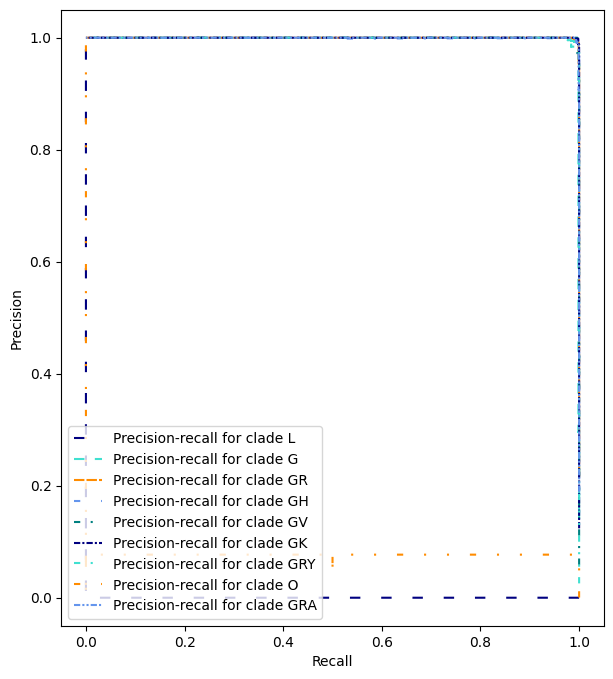

In [43]:
# Plot
linestyle_tuple = [
#      ('loosely dotted',        (0, (1, 10))),
#      ('dotted',                (0, (1, 1))),
#      ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
]
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7,8))

for i, color, linestyle in zip(CLADES, colors, linestyle_tuple):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        #average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for clade {i}", color=color, linestyle = linestyle[1])
plt.savefig("data/test/curve_pr.jpg")
plt.savefig("data/test/curve_pr.pdf")

In [44]:
### PLOTS.PY ###
"""
Plot accuracy and loss for train/val
Confusion matrix
"""
from pathlib import Path 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay

from parameters import PARAMETERS
KMER = PARAMETERS["KMER"]
PATH = Path("data")
PATH_PLOTS = PATH.joinpath("plots")
PATH_PLOTS.mkdir(exist_ok=True, parents=True)

In [45]:
## Training metrics
training_log = pd.read_csv(PATH.joinpath("train/training_log.csv"))

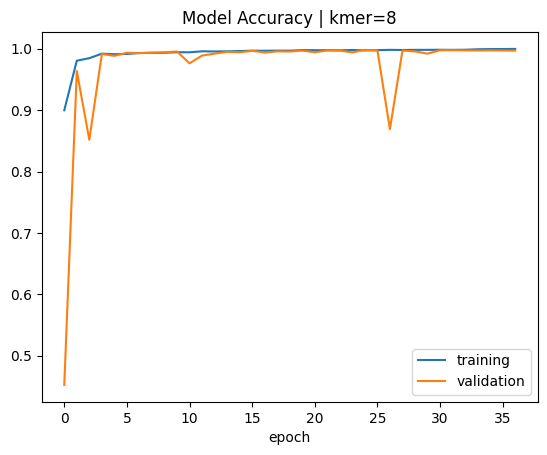

In [46]:
# Accuracy
training_log.rename({
                    "accuracy": "training", 
                    "val_accuracy": "validation",
                    },
                    axis=1,
                    ).plot("epoch", ["training", "validation"], 
                            title = f"Model Accuracy | kmer={KMER}")
plt.savefig(PATH_PLOTS.joinpath(f"accuracy_{KMER}mer.jpg"))
plt.savefig(PATH_PLOTS.joinpath(f"accuracy_{KMER}mer.pdf"))

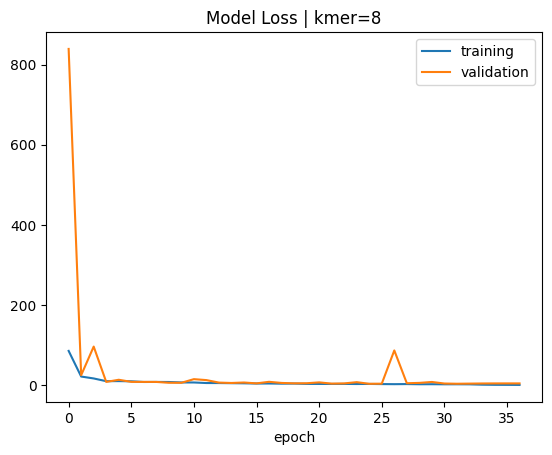

In [47]:
# Loss
training_log.rename({
                    "loss": "training",
                    "val_loss": "validation"
                    },
                    axis=1,
                    ).plot("epoch", ["training", "validation"], 
                            title=f"Model Loss | kmer={KMER}")
plt.savefig(PATH_PLOTS.joinpath(f"loss_{KMER}mer.jpg"))
plt.savefig(PATH_PLOTS.joinpath(f"loss_{KMER}mer.pdf"))

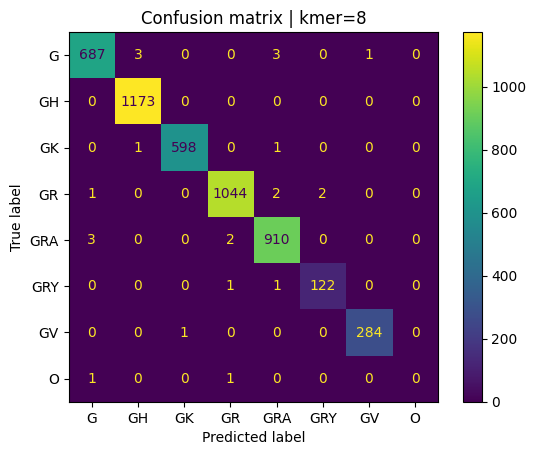

In [48]:
## Confusion matrix
predictions = pd.read_csv(PATH.joinpath("test/predictions.csv"))
y_true = predictions.ground_truth
y_pred = predictions.prediction
ConfusionMatrixDisplay.from_predictions(y_true, y_pred,)
plt.title(f"Confusion matrix | kmer={KMER}")
plt.savefig(PATH_PLOTS.joinpath(f"confusion_matrix_{KMER}mer.jpg"))
plt.savefig(PATH_PLOTS.joinpath(f"confusion_matrix_{KMER}mer.pdf"))

In [ ]:
### SALIENCY_MAP.PY ###
"""
Most relevant kmers for each clade based on saliency map
"""
import numpy as np
import pandas as pd 

from tqdm import tqdm
from pathlib import Path
from fcgr.fcgr import FCGR
from loaders.model_loader import ModelLoader
from feature_importance.saliency_maps import saliencymap
from fcgr.utils import (
    fcgrpos2kmers, 
    kmer_importance,
)
from preprocessing import Pipeline
from parameters import PARAMETERS

KMER = PARAMETERS["KMER"]
CLADES     = PARAMETERS["CLADES"] # order output model
PREPROCESSING = [(k,v) for k,v in PARAMETERS["PREPROCESSING"].items()]
MODEL_NAME  = f"resnet50_{KMER}mers"
PATH_SMAP = Path("data/saliency_map")
PATH_SMAP.mkdir(exist_ok=True)

In [ ]:
# get best weights
CHECKPOINTS  = [str(path) for path in Path("data/train/checkpoints").rglob("*.hdf5")]
epoch_from_chkp = lambda chkp: int(chkp.split("/")[-1].split("-")[1])
CHECKPOINTS.sort(key = epoch_from_chkp)
BEST_WEIGHTS =  CHECKPOINTS[-1]
print(f"using weights {BEST_WEIGHTS} to test")

In [ ]:
# load model 
loader = ModelLoader()
model = loader(model_name = MODEL_NAME,
               n_outputs  = len(CLADES),
               weights_path = BEST_WEIGHTS
            )

In [ ]:
# load preprocessing
preprocessing = Pipeline(PREPROCESSING)

# fcgr
fcgr = FCGR(k=KMER)
fcgrpos2kmer = fcgrpos2kmers(k=KMER) # dict with position in FCGR to kmer

In [ ]:
# Load predictions
predictions = pd.read_csv("data/test/predictions.csv")
predictions["TP"] = predictions.apply(lambda row: row["ground_truth"] == row["prediction"], axis=1)
# For each clade, compute the representative FCGR over all TP
for clade in tqdm(CLADES): 
    # path to save smap and relevant kmers for the clade
    PATH_CLADE = PATH_SMAP.joinpath(clade)
    PATH_CLADE.mkdir(exist_ok=True)

    # filter TP for each clade
    paths_tp_clade = predictions.query(f"`ground_truth`== '{clade}' and `TP` == True")["path"].tolist()

    # compute representative FCGR
    rep_fcgr = np.zeros((2**KMER,2**KMER))
    for path in paths_tp_clade: 
        fcgr = np.load(path)
        rep_fcgr = np.add(rep_fcgr, fcgr)
    rep_fcgr = rep_fcgr/len(paths_tp_clade) 

    # compute saliency map for the representative FCGR
    input_model = np.expand_dims(preprocessing(rep_fcgr), axis=0)
    smap, prob, pred_class = saliencymap(model, input_model, order_output=CLADES)

    # compute most relevant kmers
    list_kmers = kmer_importance(smap, 0.1, rep_fcgr, fcgrpos2kmer)
    if len(list_kmers)==0:
        list_kmers = kmer_importance(smap, 0, rep_fcgr, fcgrpos2kmer)
    
    np.save(file = PATH_CLADE.joinpath("saliency_map.npy"), arr = smap)
    np.save(file = PATH_CLADE.joinpath("representative_FCGR.npy"), arr = rep_fcgr)
    pd.DataFrame(list_kmers).to_csv(PATH_CLADE.joinpath("relevant_kmers.csv"))

In [ ]:
### SHAP_VALUES.PY ###
"""
Most relevant kmers for each clade based on shap values
"""
from tqdm import tqdm
import pandas as pd
import numpy as np 
import shap 

from pathlib import Path
from loaders.model_loader import ModelLoader
from fcgr.utils import (
    fcgrpos2kmers,
    kmer_importance_shap
)
from preprocessing import Pipeline
from parameters import PARAMETERS

CLADES = PARAMETERS["CLADES"]
KMER = PARAMETERS["KMER"]
PREPROCESSING = [(k,v) for k,v in PARAMETERS["PREPROCESSING"].items()]
MODEL_NAME  = f"resnet50_{KMER}mers"

In [ ]:
# get best weights
CHECKPOINTS  = [str(path) for path in Path("data/train/checkpoints").rglob("*.hdf5")]
epoch_from_chkp = lambda chkp: int(chkp.split("/")[-1].split("-")[1])
CHECKPOINTS.sort(key = epoch_from_chkp)
BEST_WEIGHTS =  CHECKPOINTS[-1]
print(f"using weights {BEST_WEIGHTS} for shap")

PATH_SMAP = Path(f"data/saliency_map") # to access (centroid) representative FCGR
PATH_SHAP = Path(f"data/shap_values")
for clade in CLADES: 
    PATH_SHAP.joinpath(f"{clade}").mkdir(exist_ok=True, parents=True)

In [ ]:
# load model 
loader = ModelLoader()
model = loader(model_name = MODEL_NAME,
               n_outputs  = len(CLADES),
               weights_path = BEST_WEIGHTS
            )

# load preprocessing
preprocessing = Pipeline(PREPROCESSING) 

In [ ]:
# dict with position in FCGR to kmer
fcgrpos2kmer = fcgrpos2kmers(k=KMER)

def f(x): 
    "Function inside explainer"
    tmp = x.copy()
    tmp = preprocessing(tmp)
    return model(tmp)

In [ ]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", [2**KMER,2**KMER,1])

In [ ]:
# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=CLADES)

for clade in tqdm(CLADES, desc="Computing Shap Values"): 
    fcgr = np.load(PATH_SMAP.joinpath(f"{clade}/representative_FCGR.npy"))
    x = fcgr.copy()
    x = np.expand_dims(x, axis=-1) # channel axis
    x = np.expand_dims(x, axis=0) # batch axis
    shap_values = explainer(x, max_evals=1000, batch_size=8,)
    
    # shap values for clade
    idx_clade = CLADES.index(clade)
    sv = shap_values[0,:,:,0,idx_clade].values 
    THRESHOLD = max( abs(sv.min()), sv.max() ) / 2
    
    # extract most relevant kmers based on shap values 
    kmer_imp_sv = kmer_importance_shap(sv, threshold= THRESHOLD, fcgr = fcgr, fcgrpos2kmer=fcgrpos2kmer, Nmin = 50)
    df_kmer_imp = pd.DataFrame(kmer_imp_sv)
    
    # Save shap values and most relevant kmers
    path_save = PATH_SHAP.joinpath(f"{clade}")
    df_kmer_imp.to_csv(path_save.joinpath("relevant_kmers.csv"))
    np.save(path_save.joinpath("shap_values.npy"), sv)

In [ ]:
### SVM_EXPERIMENT.PY ###
import sys
import json 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from collections import OrderedDict, namedtuple
from tqdm import tqdm
from pathlib import Path
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from fcgr.utils import fcgrpos2kmers
from parameters import PARAMETERS

feature_from = "shap_values" #sys.argv[1]  #INVERTITO

In [ ]:
# base parameters
#minN, maxN = 1,15 # Number of relevant kmers to try
rangeN = [1,2,3,4,5,10,15,20,25,30,35,40,45,50]
CLADES = PARAMETERS["CLADES"]#['S','L','G','V','GR','GH','GV','GK','GRY']
KMER = PARAMETERS["KMER"]
kmer2pos = {kmer: pos for pos,kmer in fcgrpos2kmers(KMER).items()}

In [ ]:
BASE_PATH = Path(f"data")

# load datasets
with open("data/train/datasets.json","r") as fp: 
    datasets = json.load(fp)

In [ ]:
# add complete path to fcgr
train = datasets["train"]
test  = datasets["test"]

In [ ]:
## FUNCTIONS
# extract label from path
label_from_path = lambda path: path.split("\\")[-2]

In [ ]:
path.split("\\")[-2]

In [ ]:
# input and output for SVM with relevant kmers and labels
def build_io_svm(paths_fcgr, list_relevant_kmers, kmer2pos):
    # list to save frequencies of each kmer for all fcgr
    freqs_fcgr = [] 
    labels = []

    # build train data
    for path_fcgr in tqdm(paths_fcgr, desc="Extracting kmers from fcgr"):
        # extract label
        label = label_from_path(path_fcgr)
        labels.append(label)
        
        # load fcgr
        fcgr = np.load(path_fcgr)

        # extract frecuency of each list_relevant_kmers in the fcgr
        freq_fcgr = OrderedDict()
        for kmer in list_relevant_kmers: 
            row,col=kmer2pos[kmer]
            freq_fcgr[kmer] = fcgr[row,col]
        freqs_fcgr.append(freq_fcgr)
        
    return pd.DataFrame(freqs_fcgr), labels

In [ ]:
# extract N relevant kmers based on centroid results for shap-values or saliency-map
def extract_N_relevant_kmers_clade(clade, feature_from, N):
    path_relevant_kmers = BASE_PATH.joinpath(f"{feature_from}/{clade}/relevant_kmers.csv")
    #print(path_relevant_kmers)
    df_relevant_kmers = pd.read_csv(path_relevant_kmers)
    #print(df_relevant_kmers.head())
    N_relevant_kmers = df_relevant_kmers["kmer"].tolist()[:N]
    return N_relevant_kmers

In [ ]:
# Collect relevant kmers
def collect_relevant_kmers_all_clades(feature_from, N, clades):
    relevant_kmers = set()
    for clade in clades: 
        relevant_kmers_clade = extract_N_relevant_kmers_clade(clade, feature_from, N)
        relevant_kmers = relevant_kmers.union(set(relevant_kmers_clade))

    list_relevant_kmers = list(relevant_kmers)
    list_relevant_kmers.sort() # sort lexicographically in ascending order
    
    return list_relevant_kmers

In [ ]:
## EXPERIMENT

Results = namedtuple("Results", ["N","acc","total_kmers"])
results = []
for N in rangeN:
    print(f"Working on {N}")
    # collect relevant kmers for all clades
    list_relevant_kmers = collect_relevant_kmers_all_clades(feature_from, N, CLADES)
    total_kmers = len(list_relevant_kmers)
    
    # build input and output for train and test sets
    df_train, labels_train = build_io_svm(train, list_relevant_kmers, kmer2pos)
    df_test, labels_test = build_io_svm(test, list_relevant_kmers, kmer2pos)
    
    # train svm
    clf = make_pipeline(StandardScaler(), SVC())
    clf.fit(df_test, labels_test)

    # test svm
    predictions = clf.predict(df_test)
    acc = accuracy_score(y_true = labels_test, y_pred = predictions)
    
    # collect results
    results.append(Results(N,acc, total_kmers))

In [ ]:
pd.read_csv('../src/data/shap_values/GRA/relevant_kmers.csv')

In [ ]:
# Save results and plot 
path_save = BASE_PATH.joinpath(f"svm/{feature_from}")
path_save.mkdir(exist_ok=True, parents=True)
df_results = pd.DataFrame(results)
df_results.to_csv(path_save.joinpath(f"results_svm_{KMER}mer.csv"))
df_results.plot("N","acc")
plt.savefig(path_save.joinpath(f"N_vs_acc_svm_{KMER}mer.jpg"))